## Formatting the data
The data available is not perfect. Some articles have missing information. Such texts will be filtered out - The data will be loaded from a JSON and converted to a Pandas dataframe. 

The necessary features are: __Domain, Body, Header__ and __Byline__. URI is nice to have, but not necessary.

Author: lkt259@alumni.ku.dk

In [1]:
import numpy as np
import pandas as pd
import os, re
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
import random
from difflib import SequenceMatcher
plt.style.use('seaborn')

scrape = True

In [2]:
#Load data - and show 120 characters of the body.
data = pd.read_json(r'data/data_0.json')
pd.set_option('display.max_colwidth', 220)
data.head(3)

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash
0,842325,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . FOR ABONNENTER »Der var ov...,Utilfreds passager: »Prøv selv en tur klokken 7.30 en hverdagsmorgen« - politiken.dk,2002-09-17T00:00:00,https://politiken.dk/forbrugogliv/art6088327/Utilfreds-passager-%C2%BBPr%C3%B8v-selv-en-tur-klokken-7.30-en-hverdagsmorgen%C2%AB,Annemette Grundtvig,-346867430
1,842324,politiken.dk,"Klimamonitor Byrummonitor Skolemonitor Sundhedsmonitor Kulturmonitor Følg os Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« For to år siden fik forfatter ...","Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« - politiken.dk",2013-01-18T00:00:00,https://politiken.dk/forbrugogliv/art6287464/%C2%BBOfte-st%C3%A5r-jeg-og-mangler-en-ting-og-bliver-irriteret-p%C3%A5-mig-selv-over-at-jeg-har-smidt-den-ud%C2%AB,Annemette Grundtvig,-1346564151
2,842323,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . Køb abonnement Den familie...,Digitalt forældreskab: Hvilken type er du som Facebook-forælder? - politiken.dk,2006-05-17T00:00:00,https://politiken.dk/forbrugogliv/art5934818/Hvilken-type-er-du-som-Facebook-for%C3%A6lder,Annemette Grundtvig,1473032676


### Removing duplicates and empty bodies
We don't want duplicate articles. First, we'll remove entries with the same URI and body. I save the entries, which have empty bodies and unique URI's - Perhaps we can get the body online, if needed.

In [3]:
def print_stats():
    print(f"{data.shape[0]} entries.")
    print(f"{data.Byline.unique().shape[0]} authors.")
    print(f"{data.Domain.unique().shape[0]} domains.")

def same_uri(uri):
    return data[data['Uri']==uri]

def remove_duplicates(data):
    print("With duplicates:", data.shape)
    data = data.drop_duplicates(subset=["Body", "Uri"]) #Remove entries with same body and URI
    empty_bodies = data[data['Body'] == '']    #Save empty bodied entries in another dataframe.
    data = data[data['Body'] != '']
    empty_bodies = empty_bodies[~empty_bodies['Uri'].isin(data['Uri'])] #Remove empty bodies, which are present in data.
    duplicate_bodies = data[data.duplicated(subset=["Body"])]
    data = data.drop_duplicates(subset=['Body']) #Can remove all duplicate bodies here, after None-bodies are removed.
    data = data.drop_duplicates(subset=["Uri"]) #Remove entries with same URI
    
    print("Without duplicates:", data.shape)
    return data, empty_bodies, duplicate_bodies

data, _, _ = remove_duplicates(data)

With duplicates: (10000, 8)
Without duplicates: (9070, 8)


### Removing unknown authors, headers and domains

In [4]:
def remove_missing_feats(data):
    no_author, no_header, no_domain = None, None, None
    
    if data['Byline'].isnull().values.any(): #Missing authors
        no_author = data[data['Byline'].isnull()]
        data = data.dropna(subset=['Byline'])
        print("Without unknown authors:", data.shape)

    if data['Header'].isnull().values.any():
        no_header = data[data['Header'].isnull()]
        data = data.dropna(subset=['Header'])
        print("Without unknown title:", data.shape)
    
    data = data[data.Header != '']

    if data['Domain'].isnull().values.any():
        no_domain = data[data['Domain'].isnull()]
        data = data.dropna(subset=['Domain'])
        print("Without unknown domains:", data.shape)
        
    return data, no_author, no_header, no_domain

data, _, _, _ = remove_missing_feats(data)

### Applying to all data files.
After investigating the data, let's apply the changes to the files. No need in formatting multiple times. Also, let's see how the distributions are when collecting all data.

In [5]:
#Load all data into one big dataframe. Oh yes, it is possible!
files = os.listdir('data')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('data/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('data/'+file)])

print_stats()

  0%|          | 0/80 [00:00<?, ?it/s]

808066 entries.
66994 authors.
268 domains.


In [6]:
#Used for plotting later...
body_lengths = data['Body'].str.len()
y2, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x2 = 0.5*(bin_edges[1:] + bin_edges[:-1])

#### Remove duplicated and missing data
Some data did not meet the requirements. How much data do we have left?

In [7]:
data, empty_bodies, duplicate_bodies = remove_duplicates(data)
data, no_author, no_header, no_domain = remove_missing_feats(data)

#Removing bad authors. Baaad author, shame on you!
bad_byline = data[data['Byline']==data['Uri']]
data = data[data['Byline']!=data['Uri']]
print("With bad authors removed:", data.shape)
print_stats()

With duplicates: (808066, 8)
Without duplicates: (431531, 8)
Without unknown authors: (398856, 8)
With bad authors removed: (348751, 8)
348751 entries.
7849 authors.
205 domains.


In [8]:
#Titel-ize Authors!
data.Byline = data.Byline.str.title()
print("Unique authors: ", len(data['Byline'].value_counts()))
print(data['Byline'].value_counts()[:-5],"\n...")

Unique authors:  7776
Anne Sophia Hermansen                                  13559
Karim Pedersen                                          7157
Thomas Treo                                             6172
Mads Elkær                                              4898
Benny Baagø                                             4271
                                                       ...  
Emil Bergløv | Sofie Synnøve Herschend                     1
Jo Carlsenn | Rie Carlsen                                  1
Kasper Schütt-Jensen | Mads Frost                          1
Steen Nedell Christensen | Jesper Haue Hansen              1
Michael Hjøllund | Jacob Haislund | Jesper Kongstad        1
Name: Byline, Length: 7771, dtype: int64 
...


In [9]:
print(len(empty_bodies), "empty bodies")
print(len(no_author), "without author")
#print(len(no_header), "without header")
#print(len(no_domain), "without domain")
print(len(bad_byline), "malformed authors")

448 empty bodies
32675 without author
28789 malformed authors


### Author cleanup! Removing multiple authors.
Some entries have multiple auhthors. How big a problem does this cause?

In [10]:
authors = list(data['Byline'])[1:] #First entry is empty.
multiple_authors_candidates = []
for author in authors:
    if any(x in author for x in ['|',',']):
        multiple_authors_candidates.append(author)

print("Entries with multiple authors (and titles, cities):" ,len(multiple_authors_candidates))
print(f"Unique combinations of authors: {len(set(multiple_authors_candidates))}")

#multiple_authors = [re.split('\||,',x) for x in multiple_authors]

Entries with multiple authors (and titles, cities): 11275
Unique combinations of authors: 4747


**Now! Let us remove entries with multiple authors.**

Some authors are actually not multiple authors, but cities and titles. These entries will be kept, but stripped from everything except the name. We don't want multiple authors, as this project focuses on single authors.

In [11]:
#Read txt file with words that should not be masked.
with open('data/additional/author_filter.txt', encoding='utf-8') as f:
    lst = f.read()
    lst = lst.split('\n')

author_filter = lst

print(f"{len(set([x for x in multiple_authors_candidates if '|' in x]))} authors removed by '|-rule'")
bar_rule = [x for x in multiple_authors_candidates if '|' in x]
multiple_authors_candidates = [x for x in multiple_authors_candidates if '|' not in x] #Remove entries with | in them.

new_authors_candidates = []
author_names_without_city = [] #Save the new, stripped name and the old one, to edit data fterwards.

for candidate in multiple_authors_candidates:
    names = candidate.split(',') #Split by , to separate authors or cities    
    
    append = True
    
    #Loop through names
    for name in names:
        name = name.strip()
        if len(name.split())>1: #Name is not two or more names.
            if any(ele in name for ele in author_filter): #Do not append if name found in filter.
                append = False
        else:
            append = False
    
    if append:
        new_authors_candidates.append(candidate)
    else:
        #Append to names list without cities. 
        if any(ele in names[0] for ele in author_filter): #If first name appears in filter, use second name.
            author_names_without_city.append((names[1], candidate))
        else:
            author_names_without_city.append((names[0], candidate))
            
print(f"{len(set(new_authors_candidates))} author combinations removed by filter.")
print(f"Kept {len(set([x[0] for x in author_names_without_city]))} authors (Not sure if they are new authors yet).")

already_there_hon = 0
uniques = data['Byline'].unique()
for i in set([x[0] for x in author_names_without_city]):
    if i in uniques:
        already_there_hon += 1
        
print(f"{already_there_hon} authors already present in data by themselves.")

2896 authors removed by '|-rule'
1463 author combinations removed by filter.
Kept 215 authors (Not sure if they are new authors yet).
139 authors already present in data by themselves.


In [12]:
#Drop multiple authors from data.
data = data[data['Byline'].isin(new_authors_candidates) == False]
data = data[data['Byline'].isin(bar_rule) == False]

#Convert wrong names to right names in data.
#Badly optimised...
print("Converting names...")
for entry in tqdm(author_names_without_city):
    name = entry[0]
    wrong_name = entry[1]
    
    data.loc[data["Byline"] == wrong_name, "Byline"] = name
print("Names are converted! That was slow.")

Converting names...


  0%|          | 0/1442 [00:00<?, ?it/s]

Names are converted! That was slow.


In [13]:
## Remove authors: Redaktionen and Ritzau /Nyheder
data = data[data.Byline.isin(['Redaktionen', 'Ritzau /Nyheder']) == False]

In [14]:
print_stats()

336788 entries.
3103 authors.
205 domains.


## Removing Unique Entries
We don't want unique author or domain names. We need **at least** two entries for each.

In [15]:
#Drop rows where domain only occurs once.
d = data['Domain'].value_counts()
data = data[data['Domain'].isin(d[d<2].keys()) == False]

In [65]:
#Find which author names that can be salvaged. (Are they calpitalized?)
def unique_author_removal(data):
    d = data['Byline'].value_counts()
    unique_authors = d[d<2].keys()
    common_authors = d[d>2].keys()

    for author in unique_authors:
        author = author.strip()
        if author.istitle():
            continue
        if author.isupper() or author.islower():
            if author.title() in common_authors:
                data.loc[data["Byline"] == author, "Byline"] = author.title()

    #Remove any entries with single-occuring authors.
    data = data[data['Byline'].isin(unique_authors) == False]
    return data

data = unique_author_removal(data)

In [17]:
#Drop rows where domain only occurs once.
d = data['Domain'].value_counts()
data = data[data['Domain'].isin(d[d<2].keys()) == False]

In [18]:
print_stats()

335583 entries.
1906 authors.
193 domains.


### Additional cleanup
Removing duplicated headers and foreign domains.

In [19]:
h = data['Header'].value_counts()
data = data[data['Header'].isin(h[h>20][1:].keys())==False]

**Remove foreign domains** - We don't want German texts!

In [20]:
domains = ('.dk', 'nordicwomeninfilm.com', 'linkedin.com', 'betxpert.com', 'kommunikation.com', 'radar.com', 'ea.com', 'ue.com','ce.com', '.international', 'e.nu')
print(data[data['Domain'].str.endswith(domains)==False].shape[0], "entries with foreign domains.")
data = data[data['Domain'].str.endswith(domains)]
print_stats()

24924 entries with foreign domains.
307953 entries.
1867 authors.
162 domains.


__Duplicate domains:__ computerworld.dk has 3 domains of different formats. Unify them.

In [21]:
data.loc[data.Domain.isin(["Computerworld.dk", "www.computerworld.dk"]), 'Domain'] = 'computerworld.dk'

In [22]:
data[(data.Domain=='bt.dk') & (data.Header=='Din profil er oprettet')].Uri.head(200)

396                          https://www.bt.dk/royale/grevinde-alexandra-gaar-fra-kaeresten-i-dramatisk-brud
397                    https://www.bt.dk/royale/skuespillerinde-naegter-venskab-med-prins-harry-det-er-loegn
398                                     https://www.bt.dk/royale/kronprins-frederik-deler-billede-fra-jordan
399                                        https://www.bt.dk/kendte/jackie-navarro-raser-over-vilde-beskeder
400                                       https://www.bt.dk/udland/skovbrand-ude-af-kontrol-50.000-evakueret
                                                       ...                                                  
678                                    https://www.bt.dk/samfund/dansk-domstol-i-broeler-jeg-er-meget-rystet
696             https://www.bt.dk/kendte/endnu-en-stjerne-paa-onlyfans-spiller-guitar-splitterravende-noegen
697                                 https://www.bt.dk/film-tv-og-streaming/black-lives-matter-overtog-showet
698    https://www.

## Scrape 35k articles
Some articles have the same header, same body. The domains are limited to bt.dk and berlingske.dk - making a scraper is not too hard.

In [23]:
remove = []
import traceback

if scrape:
    try:
        data = data.reset_index()
    except:
        pass
    import SeleniumScraper
    
    treo = data[data['Byline']=='Thomas Treo']
    anne = data[data['Byline']=='Anne Sophia Hermansen']
    corrupt_data = data[data['Header']=='Din profil er oprettet']
    corrupt_data = pd.concat((corrupt_data, treo, anne))
    
    errors = []
    _404s = []
    
    i = 0
    o = corrupt_data.shape[0]

    for idx, article in tqdm(corrupt_data.iterrows()):
        url = article.Uri

        try:
            header, body, author = SeleniumScraper.get_content(url)

        except Exception as e:
            i += 1
            errors.append((url, e))
            remove.append(article.Id)
            print(traceback.format_exc())
            continue
    
        if type(author) == list:
            errors.append((url, f"MULTIPLE AUTHORS:{author}"))
            remove.append(article.Id)
            continue
        
        if article.Domain == 'bt.dk' or article.Domain == 'berlingske.dk':
            author, body = '404', '404'
            
        if header != '404':
            data.iloc[idx, data.columns.get_loc('Header')] = header
        else:
            _404s.append(url)
            continue
            
        if body != '404':
            data.iloc[idx, data.columns.get_loc('Body')] = body
            
        if author != '404':
            data.iloc[idx, data.columns.get_loc('Byline')] = author

        print(header, f"({i}/{o})")
        i += 1

print_stats()
data = data[data.Id.isin(remove)==False]
data.to_json(r'data/additional/scraped_data_raw.json')

0it [00:00, ?it/s]

Non-names: ['Ansvarshavende chefredaktør']
Kulturen er pist borte (0/35236)
Non-names: ['Ansvarshavende chefredaktør']
Vi kalkulerer hver dag med menneskers død (1/35236)
Non-names: ['Ansvarshavende chefredaktør']
Gud nåde og trøste os, hvis Bernie Sanders bliver præsident (2/35236)
Non-names: ['Ansvarshavende chefredaktør']
Borgerlige burde stille sig på borgernes side mod regeringens forlorne folkelighed (3/35236)
Non-names: ['Kulturkommentator']
Vi forstår nu, hvorfor Katrine Marie Guldager er enestående. Selv når hun skriver for langt (4/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Det kan vi lære af den mest dysfunktionelle sæson af »Gift ved første blik« nogensinde (5/35236)
Non-names: ['Kulturkommentator']
Portræt af et røvhul: Ny Netflix-dokumentar genoptager sagen om den hvide IMF-konge og den sorte stuepige (6/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Latterligt, tænkte jeg, da jeg så en mand skrive, at han ikke ville ansætte attraktive 

En svensk dreng forsvandt sporløst fra sin 7. klasse – 28 år efter er han fundet i live (67/35236)
Sverige runder grimt hjørne under coronaepidemien: Löfven tager endnu en bid af kontrollen fra Tegnell (68/35236)
Farvel til EU-bureaukratiet: Briter lyngodkender coronavaccine og øver sig på tiden efter Brexit (69/35236)
Farvel til venlige henstillinger: Nu »skal« svenskerne følge coronareglerne (70/35236)
https://www.berlingske.dk/redaktionen/peter-suppli-benson?mobile=false&page=3  took too long to load...
EU vil lyngodkende coronavacciner. Kan være klar om få uger (71/35236)
Grevinde Alexandra går fra kæresten i dramatisk brud (72/35236)
Skuespillerinde nægter venskab med prins Harry: 'Det er løgn!' (73/35236)
Kronprins Frederik deler billede fra Jordan (74/35236)
Jackie Navarro raser over 'vilde beskeder' (75/35236)
Skovbrand ude af kontrol - 50.000 evakueret (76/35236)
Dansk tøjkæde er gået konkurs (77/35236)
PETA dropper nøgenkampagne efter tre årtier (78/35236)
Boris Johnsons påst

Blogger raser over SAS: 'Det er komplet vanvittigt!' (176/35236)
Dansker i Stockholm: 'De tager det ikke seriøst' (177/35236)
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 180, in get_content
    a = a[0].title()
IndexError: list index out of range

Mary-Kate Olsen vil skilles - smidt ud af ægtemanden (179/35236)
Peter Skaarup langer ud efter børneprogram på DR: 'Det fordærver vores børn' (180/35236)
Overskuddet svinder ind i dansk taskefirma (181/35236)
Konflikt i Alphabeat førte til dramatisk brud: Sådan går det nu (182/35236)
Justin Timberlake deler hjerteskærende billede: 'Han burde ikke være død' (183/35236)
Heroisk storebror redder lillesøster fra bidsk hund (184/35236)
Libratone er gået konkurs (185/35236)
Elvira Pitzner afslører kærestens navn (186/35236)
Dansk lappeløsning vækker o

Anni Fønsby om tidligere luksusliv: 'Jeg er lykkeligere nu' (287/35236)
Michelle Williams har født (288/35236)
Dronning Elizabeths hund er død (289/35236)
Forfatter: Meghan ville være 'verdens mest kendte person' (290/35236)
Stjernes ekskone bryder sammen på tv – blev droppet på sms (291/35236)
Kæmpe 'lorte'-skandale i australsk tv-program - brugte tandbørste som toiletbørste (292/35236)
Rockstjernen Noel Gallagher nægter at gå med mundbind (293/35236)
Berlingske Media bliver medejer af Radio LOUD (294/35236)
DR afslører: Her er vores kommende satsninger (295/35236)
Turist reddet op af brønd efter seks dage (296/35236)
Hollywood-instruktør laver remake af dansk flopfilm: Kæmpe stjerne i spil til hovedrollen (297/35236)
Pilou Asbæk advarer sine fans: 'Fald ikke for det her!' (298/35236)
Signe Molde er tilbage med ny programserie på DR2 (299/35236)
Sharon Osbourne chokerer med Johnny Depp-forsvar: 'Der skal to til tango' (300/35236)
Influencer politianmeldt for skjult reklame (301/35236)

Jokeren sender fuckfinger til Mette Frederiksen: Har dårligt råd til smøger (388/35236)
Egyptisk model anholdt for 'upassende' billeder (389/35236)
Christopher Nolan raser over filmgigant: 'Verdens værste streamingtjeneste!' (390/35236)
Lisbeth Østergaard i chok: 'Tror de, mit sexliv er kedeligt?!' (391/35236)
Verdenskendt instruktør langer ud efter Jake Gyllenhaal (392/35236)
103-årige Lise Nørgaard får livslang ydelse fra Statens Kunstfond: 'Bedre sent end aldrig' (393/35236)
Bubber chokerede 'alle': 'Snothamrende unødvendigt' (394/35236)
Mai Manniche sender uønskede reklamer: Kan være ulovligt (395/35236)
Realitypar under voldsomme beskyldninger: 'Skilsmisse er et bluffnummer!' (396/35236)
Kendt tryllekunstner knust efter indbrud: 'Hvorfor lige mig?' (397/35236)
Phil Collins' skilsmissekrig fortsætter: 'Han stinker og er impotent' (398/35236)
Kendisser jubler over Jodel-udvikling: 'Fryd for de svin!' (399/35236)
Coca-Cola dropper ikonisk reklame (400/35236)
Husker du ham her? Nu for

Nødret (437/35236)
Non-names: ['Ansvarshavende chefredaktør']
Vi er nødt til at tale om elefanten i rummet: Hvad vil de borgerlige? (438/35236)
Non-names: ['Ansvarshavende chefredaktør']
Derfor er også vi ramt af den store amerikanske mediekrig (439/35236)
Non-names: [' chefredaktør']
Velfærdsdogmer (440/35236)
Eliten ud af minefeltet (441/35236)
Multiple authors: ['Christian Marcussen', 'Debattør Og Kommunikationsrådgiver', 'Jarl Cordua', 'Amalie Lyhne', ' Lederskribent På Berlingske', 'Pierre Collignon', 'Mette Østergaard', 'Tom Jensen', 'Tom Jensen', 'Pierre Collignon', 'Jarl Cordua', 'Asmus Leth Olsen', 'Professor Mso Med Fokus På Den Offentlige Sektor', 'Pierre Collignon', 'Mikkel Andersson', 'Jarl Cordua', 'Mette Østergaard', 'Pierre Collignon', 'Tom Jensen', 'Pierre Collignon', 'Asmus Leth Olsen', 'Professor Mso Med Fokus På Den Offentlige Sektor', 'Christian Marcussen', 'Debattør Og Kommunikationsrådgiver', 'Lars Trier Mogensen', 'Asmus Leth Olsen', 'Professor Mso Med Fokus På 

Dobbeltmoral (457/35236)
Multiple authors: ['Jarl Cordua', 'Peter Kurrild-Klitgaard', 'Professor I Statskundskab', 'Anne Sofie Allarp', 'Forfatter Og Jurist', 'Jarl Cordua', 'Amalie Lyhne', ' Lederskribent På Berlingske', 'Anne Sofie Allarp', 'Forfatter Og Jurist', 'Mikkel Andersson', 'Anne Sofie Allarp', 'Forfatter Og Jurist', 'Jarl Cordua', 'Amalie Lyhne', ' Lederskribent På Berlingske', 'Anne Sofie Allarp', 'Forfatter Og Jurist', 'Peter Kurrild-Klitgaard', 'Professor I Statskundskab', 'Stine Bosse', 'Formand For Europabevægelsen', 'Peter Kurrild-Klitgaard', 'Professor I Statskundskab', 'Peter Kurrild-Klitgaard', 'Professor I Statskundskab', 'Asmus Leth Olsen', 'Professor Mso Med Fokus På Den Offentlige Sektor', 'Amalie Lyhne', ' Lederskribent På Berlingske', 'Jarl Cordua', 'Pierre Collignon', 'Tom Jensen', 'Peter Kurrild-Klitgaard', 'Professor I Statskundskab', 'Jarl Cordua', 'Peter Kurrild-Klitgaard', 'Professor I Statskundskab', 'Jarl Cordua', 'Jarl Cordua', 'Asmus Leth Olsen', 'P

Tom Jensen på Roskilde Festival: »I min alder er man blevet særdeles god til at gennemskue hykleriet« (518/35236)
Non-names: [' chefredaktør']
De fordomsfulde (519/35236)
»Nej, denne gang var Løkke ikke morsom. Det kan han jo godt være« (520/35236)
Non-names: [' chefredaktør']
Velfærd eller skattelettelser (521/35236)
Non-names: ['Ansvarshavende chefredaktør']
DFs symbolpolitik: »Det er bekymrende at se politikere jonglere med Radio24syv i en sen nattetime« (522/35236)
Non-names: [' chefredaktør']
For lud og koldt vand (523/35236)
Non-names: [' chefredaktør']
Kan du huske 1990erne? (524/35236)
Non-names: ['Ansvarshavende chefredaktør']
50 år: Medieprofilen valgte at blive politiker (525/35236)
Non-names: ['Ansvarshavende chefredaktør']
Når politikerne vil i krig med medierne (526/35236)
Non-names: [' chefredaktør']
En dobbelt Langballe der er blevet glemt (527/35236)
Non-names: [' chefredaktør']
Dobbelt lede (528/35236)
Non-names: ['Ansvarshavende chefredaktør']
Hvem har egentlig beste

En kvindelig statsminister - so what? (612/35236)
Og så er ironman i øvrigt fyringsgrund (613/35236)
Men det rager Morten Østergaard og Mette Frederiksen en fjer (614/35236)
Frihedsbrev (615/35236)
Anne Sophia Hermansen kalder Manu Sareens nye bog for et politisk karakterselvmord (616/35236)
Hvem står vagt om dem, der står vagt om ytringsfriheden? (617/35236)
Da verden af i går blev til verden af i dag (618/35236)
Lyver vi mere på LinkedIn end på Facebook? (619/35236)
Tag tøjet af - så snakker jeg lidt om mig selv (620/35236)
Dem, der gør det lidt bedre (621/35236)
Det er bedre at have klamydia end en karriereplan (622/35236)
Ellers manga tak (623/35236)
Først Carina, så Sofie, nu Fatima (624/35236)
Superkvinder tager ikke fuld barsel (625/35236)
Giv mig en baby, Big Mother (626/35236)
Allan Simonseeeeeeeeen (627/35236)
SMS til Antorini (628/35236)
Hvornår er der en politiker der opdager det? (629/35236)
Milena Penkowa - for lækker til KU? (630/35236)
Opgør med bordplanen (631/35236)
S

Non-names: ['Kulturkommentator']
Fotograferne fra de kulørte blade kender rutinen og knipser løs, når Christian Kjær placerer et par solide sedler i strømpebåndene. Man er ikke knibsk på Bakkens Hvile (702/35236)
Non-names: ['Kulturkommentator']
»Læsernes bogpris går i år til Danmarks nok modigste kvinde« (703/35236)
Multiple authors: ['Anne Sophia Hermansen', ' mag.art. og folketingskandidat for Liberal Alliance']
Non-names: [' kultur@berlingske.dk']
Romanen vrøvler uudslukkeligt (704/35236)
Non-names: ['Kulturkommentator']
Mediekommentar: Det globale mellemledersegment er optaget af at få en selfie med et bjerg, der er røvligeglad. Hvorfor? (705/35236)
Non-names: ['Kulturkommentator']
Hvad gør København til noget særligt? Vær med til at hylde byen (706/35236)
Non-names: [' pressechef']
Anne Sophia Hermansen har et spørgsmål til moren i 30erne: Er du nu også den bedste i verden? (707/35236)
Anne Sophia Hermansen: Kærligheden gør mere ondt i 30erne (708/35236)
Multiple authors: ['Anne 

Non-names: ['Kulturkommentator']
Kære Joy Mogensen, indfør en kedsomhedsknap og tryk på den, når kunstnere beder om flere penge (768/35236)
Non-names: [' kulturredaktør']
Mediekommentar: Jeg hader godt nok musicals, men ikke »La La Land« – længere (769/35236)
Non-names: [' kommentator']
TAK FOR KAMPEN (770/35236)
Non-names: [' kommentator']
Valgets Mest Nedgroede Negl (771/35236)
Non-names: [' kultur@berlingske.dk']
En forfatter, der hader sine personer (772/35236)
Non-names: [' kultur@berlingske.dk']
Anne Sophia Hermansen giver to stjerner til bog om friblødning: Jeg bløder, altså er jeg (773/35236)
Non-names: [' kulturredaktør']
»Vejret på DR2« handler om at være en reaktionær mand i en moderne verden (774/35236)
Non-names: [' pressechef']
Anne Sophia Hermansen: Der var engang dem, der troede, at jorden var flad. Sådan er der også mennesker i dag, som mener, kernefamilien er den eneste sande samlivsform (775/35236)
Non-names: [' kultur@berlingske.dk']
Anne Sophia Hermansen uddeler én

Sovende kvinde låst inde og efterladt på fly (848/35236)
Se videoen: 'X Factor'-taber bryder sammen (849/35236)
Skud ved synagoge i USA: Flere tilskadekomne (850/35236)
Mænd skaber frygt i lokalsamfund: Har henvendt sig til tre forskellige børn (851/35236)
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 180, in get_content
    a = a[0].title()
IndexError: list index out of range

'Tortur for åben skærm': Nu taler 'X Factor'-deltagere om stoledrama (853/35236)
Casper Christensen faldt ned i et sort hul: Folk gloede, og jeg kunne ikke holde det ud (854/35236)
Multiple authors: ['Laura Rode Nygaard', 'Kicki Søs Bengtsen']
Kennedy-barnebarn og søn forsvundet efter kanotur (855/35236)
Stephen Hawkings sygeplejerske har fået frataget sin autorisation (856/35236)
Johnny Depps ekskone fanget på opsig

Megan Fox trækker skilsmissen fra Brian Austin Green tilbage (944/35236)
Rikke Gøransson i blodigt køkkenuheld (945/35236)
'En af de værste vejrkatastrofer nogensinde': Dødstallet stiger og stiger efter voldsom orkan (946/35236)
Supermarkedsgigant går i krig: Investerer en halv milliard (947/35236)
Døde hvaler hober sig op: Amerikanske myndigheder efterlyser begravelsesplads (948/35236)
Nyt DR-program vækker opsigt: Nu er 'fars pige' ikke længere fed (949/35236)
Hollywoodstjerne hjalp Brad Pitt med at blive ædru (950/35236)
Kendis-advokat sigtet for at stjæle millioner fra pornostjerne (951/35236)
SF falder igen: Er det Hønge-effekten? (952/35236)
20-årig kvinde med to livmodere føder tvillinger en måned efter første fødsel (953/35236)
Jacob Riising afslører: Var fuld på direkte tv (954/35236)
Utæt parkeringshus ødelægger biler på stribe i Hillerød (955/35236)
Mette Reissmann skal giftes (956/35236)
Thomas Blachmans forlovede i modvind over amme-billede: 'Et forkert signal' (957/35236)

Norsk politi afslører: Har gjort nye fund i Hagen-sagen (1058/35236)
Tragisk historie om 17-årig pige gik verden rundt: Nu fortæller forældrene sandheden (1059/35236)
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 180, in get_content
    a = a[0].title()
IndexError: list index out of range

43-årig kvinde erkender massiv campingvogn-svindel (1061/35236)
Bubber og kommende ekskone sætter lejligheden til salg (1062/35236)
Google med markant ændring for brugernes privatliv (1063/35236)
Multiple authors: ['Niels Philip Kjeldsen', 'Kicki Søs Bengtsen']
Danmark har fået en ny konge (1064/35236)
Prins Harry straffede ven, som tvivlede på Meghan (1065/35236)
Tidligere tv- og radiovært lancerer ny kanal: Det gik for langsomt på DR (1066/35236)
Politisk kommentator om LA-komet: 'Går ikke galt med ham 

Medie: Tom Hagen nægter at underskrive afhøringer (1163/35236)
To altaner styrtet ned på nybygget plejehjem (1164/35236)
Ari Behns datter hyldes for rørende mindetale: 'Jeg savner dig allerede' (1165/35236)
Efter chokudmelding: Meghan har underskrevet kontrakt med Disney (1166/35236)
Dansk datingkonge i opråb: 'Folk bliver krænket alt for hurtigt' (1167/35236)
Mads Langer løfter sløret: 'Vi skal helt sikkert have børn' (1168/35236)
Fransk 'prinsesse' død efter motorcykelulykke (1169/35236)
Opsigtsvækkende fejl i jagten på drabsmistænkte teenagere (1170/35236)
Sundhedsstyrelsen betalte 119.000 kr. for artikel (1171/35236)
Tømrer raser: 'Kun dumme folk bliver håndværkere!' (1172/35236)
Harry og Meghan bryder etikette... igen (1173/35236)
Rockstjernen Steve Priest er død (1174/35236)
Ree Park er rasende og udskyder åbning (1175/35236)
Efter opsigtsvækkende dundertale: Nu taler Sofie Linde for første gang (1176/35236)
Dansk fiskefabrik tav om brutalt overfald: To rumænske mænd tævede kolle

Motorvej spærret efter uheld (1270/35236)
Snow Patrol aflyser koncert i K.B. Hallen (1271/35236)
Prins Charles giver lyd fra sig efter corona-diagnose (1272/35236)
Anders W. Berthelsen i corona-karantæne (1273/35236)
Blogger i chok: 'Han var splitterravende nøgen, gammel og med en erigeret penis' (1274/35236)
Sharon Osbourne vækker opsigt med Adele-kommentar: Tror ikke, tykke kvinder kan være glade (1275/35236)
Coronakrisen rammer lægerne på pengepungen: Patienterne bliver væk (1276/35236)
Lænset for flere tusinde kroner: Forbrugere vinder sag om falske mail (1277/35236)
Han overlevede mirakuløst - men dræbte han sin egen mor og morfar? (1278/35236)
'Vild med dans'-stjerne har mistet sit ufødte barn igen (1279/35236)
Brooklyn Beckham udskammes: 'Du kan vel ikke være så naiv...' (1280/35236)
Kim Kardashian bukker under for shitstorm: Dropper omstridt navn på ny undertøjskollektion (1281/35236)
Voldsom brand i industribygning i Rødovre (1282/35236)
Stormagasin styrtbløder - men ejerne hø

Paradise-vinder taber i retten: Kørekortet ryger (1381/35236)
Det sker der med prins Joachims apanage (1382/35236)
Ekspert: Derfor må zoologiske haver ikke åbne (1383/35236)
Alvorlig bilulykke: Lastbil og personbil stødt sammen (1384/35236)
'X Factor'-Kali om stofmisbrug: 'Min datter reddede mit liv' (1385/35236)
Kong Alberts datter på gule plader må opgive millionarv (1386/35236)
Spøgelsesbilist fanget på video: 'Hold kæft, det var tæt på!' (1387/35236)
Restauranter bestormes på åbningsdagen (1388/35236)
En film tilbage: Derfor gider Quentin Tarantino ikke mere (1389/35236)
Piers Morgan tordner mod Amanda Knox: 'Dit klamme svin' (1390/35236)
Eksmand langer ud efter Pamela Anderson (1391/35236)
Blac Chyna raser efter forvirring om Oscar-deltagelse (1392/35236)
The Minds of 99 aflyser kæmpekoncert i Parken (1393/35236)
Verdens rigeste mand i hidsigt navne-opgør mod otte lande (1394/35236)
Seks personer anholdt efter bizar opførsel på J-dag (1395/35236)
Amerikansk rapper i overraskende g

Vig Festival jubler over millionstort overskud (1495/35236)
Undtagelsestilstand i New York: Frygter hedebølge vil koste liv (1496/35236)
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 180, in get_content
    a = a[0].title()
IndexError: list index out of range

Gustav Salinas er single igen (1498/35236)
Kidnappet cykelrytter vågnede nøgen og bagbundet på en stol (1499/35236)
Den verdensberømte forfatter Carlos Ruiz Zafón er død (1500/35236)
Kronprinsesse Marys prikkede kjole vækker opsigt i udlandet (1501/35236)
En uge efter skolestart: Nu skal skole lukke (1502/35236)
R. Kelly tæsket af medindsat i fængslet (1503/35236)
Influencer hyldes for ærlige billeder - sådan ser min krop ud i virkeligheden (1504/35236)
Hård kritik af 'Aftenshowet'-værter: 'Pinligt' (1505/35236)
Kendisser kritiseres e

Voldsom video: Her bliver kvinde og hendes hund kørt over af flugtbilist (1596/35236)
20-årige 'Putte' deltog i eks-politikers gangbang-fester: 'Straffen er lidt lav' (1597/35236)
Norsk milliardærs bil stjålet fra ekskonen (1598/35236)
Tidligere taleskriver afslører hemmeligheder om Mette Frederiksen og Martin Rossen (1599/35236)
22-årig turist anholdt efter brutalt drab på 74-årig butiksindehaver (1600/35236)
Tusindvis af spanske feriebyer til salg for en slik (1601/35236)
Familien sagde farvel til Ari Behn: 'Vi skal nok passe på dine piger' (1602/35236)
Multiple authors: ['Berit Hartung', 'Kicki Søs Bengtsen']
Sarah Grünewald raser over ungdommen: 'De er så fucking dårlige...' (1603/35236)
Michèle Bellaiches kæreste taler ud om kæmpe sorg (1604/35236)
Kritikken er haglet ned: Nu svarer udskældt koncertarrangør igen (1605/35236)
Tandlæge om genåbning: 'Det kan blive et kæmpe problem' (1606/35236)
Familie raser over makabre lig-billeder af død turist (1607/35236)
Lina Rafn og Dar Salim

Nu er der godt nyt til kunder i konkursramt børneforretning (1697/35236)
Politiet undersøger 'kæmpe brag' (1698/35236)
Multiple authors: ['Maria Christine Madsen', 'Kicki Søs Bengtsen']
Naboer i chok: Så voldsomt var braget (1699/35236)
Sangerinde jubler: Har født en lille dreng (1700/35236)
Retsmediciner slår fast: Lesbisk par dræbte deres seks adoptivbørn (1701/35236)
Tog stødt sammen med lastbil i Tyskland: Mange tilskadekomne (1702/35236)
Politi med opsang: 'Tænk dig nu om' (1703/35236)
Himalayabjergene lukket ned: Danske kendissers velgørenhedstur i fare (1704/35236)
Skuespillerinde i krig mod tidligere NFL-stjerne: 'Hun forsøgte at afpresse mig' (1705/35236)
Nyskilt kvinde vandt i Lotto – eksmanden ville ikke have kuponen (1706/35236)
Michael Jacksons niece stukket i ansigtet med kniv (1707/35236)
Medie: Prinsesse Beatrice i tårer efter katastrofalt interview (1708/35236)
Formand for Fritidshusejerne raser over grænselukningen: Føler sig ført bag lyset (1709/35236)
Anmelder med b

https://www.berlingske.dk/internationalt/iran-opfordrer-danmark-til-at-udlevere-gerningsmaend-bag-angreb  took too long to load...
Multiple authors: ['Heidi Røndbjerg-Christensen', ' Berlingske Nyhedsbureau']
Non-names: [' krmo@berlingske.dk']
Analyse: Attentatsforsøget mod Benazir Bhutto ryster det internationale samfund (1796/35236)
To vrisne mænd (1797/35236)
https://www.berlingske.dk/politik/dansk-folkeparti-tager-stemmer-fra-bornholms-borgmester  took too long to load...
Blå kommuner tøver med at lette skatten (1798/35236)
https://www.berlingske.dk/business/lev-skjult-og-godt  took too long to load...
Efter trusler om boykot: Trump tvunget til at bryde med årelang tradition (1799/35236)
Multiple authors: ['Steen A. Jørgenssen', 'Stine Hansen', 'Souschef Og Journalist', 'Helle Lho Hansen']
Oman satser på eksport og udenlandske investeringer (1800/35236)
Non-names: [' Berlingske']
»Jagten« blev den sikre Bodil-vinder (1801/35236)
https://www.berlingske.dk/samfund/er-tiden-loebet-fra

Non-names: [' dr.phil.', ' cand.polit.']
Enhedslistens asociale udlændingepolitik (1862/35236)
Non-names: [' MF (V) og redaktør af Den Korte Avis']
Så kald da en spade for en spade (1863/35236)
Multiple authors: ['Elisabeth Thiis', 'Ditte Faber', 'Simon Skipper']
Pas nu på den lille familie (1864/35236)
Dansk eksport runder 1.000 milliarder (1865/35236)
Multiple authors: ['Kristian Lindberg', 'Lars Rix']
Svigtede flypassagerer er blevet »big business« (1866/35236)
Multiple authors: ['SIMON KRUSE', 'Global korrespondent']
»Folk vil også have sex, når der er krig« (1867/35236)
Non-names: [' High:Five']
Kriminelle bør behandles forskelligt (1868/35236)
https://www.berlingske.dk/kommentatorer/fred-i-syrien  took too long to load...
Non-names: [' Debat- og Navneredaktør']
Kælder-mennesker (1869/35236)
Non-names: [' cand.public.', ' hjemmegående']
En speltmors bekendelser (1870/35236)
Dansk spilfirma i lag med Opel (1871/35236)
Multiple authors: ['Carl Emil Arnfred', 'Chris Kjær Jessen']
Non

44. Lars Seier Christensen, Seier Capital (tidligere Saxo Bank), 2,7 milliarder kroner (1906/35236)
Multiple authors: ['Lars Nørgaard Pedersen', 'Undersøgende Journalist', 'Simon Bendtsen', 'Morten Crone']
https://www.berlingske.dk/sport/danskere-markerer-sig-paa-femte-etape-af-tour-down-under  took too long to load...
https://www.berlingske.dk/sport/ioc-fastholder-udelukkelsen-af-rusland-ved-vinter-ol  took too long to load...
https://www.berlingske.dk/politik/275-millioner-kroner-skal-skaffe-flere-laerere-i-folkeskolen  took too long to load...
Non-names: [' BNB']
Terry forsvarer sine holdkammerater efter Ibrahimovic-kritik (1907/35236)
Gud bevare Berlingske (1908/35236)
Multiple authors: ['Lisbeth Quass', ' Berlingske Nyhedsbureau']
76. Familien Fennet, Cabinn Holding, 1,7 milliarder kroner (1909/35236)
Multiple authors: ['Thomas Nørgaard Andersen', ' Berlingske Nyhedsbureau']
Vin fra 45. breddegrad (1910/35236)
Non-names: [' chefkonsulent og ikke mindst kommende adoptivfar']
Etisk 

Celine Dions nye album er lige så glat som en lørdag aften på Radio Soft (1965/35236)
Træt af cocktails og beachparties? Her er et hjørne af Spanien med fred og ro og skønhed og historie (1966/35236)
Non-names: ['Journalist']
Museer undrer sig over manglende genåbning: »Jeg er ærlig talt forbløffet« (1967/35236)
https://www.berlingske.dk/internationalt/94-aarig-sigtes-for-drab-paa-hundreder-i-kz-lejren-stutthof  took too long to load...
Multiple authors: ['Af Morten Hesseldahl', ' adm. direktør']
https://www.berlingske.dk/sport/christian-eriksen-det-var-ikke-prangende-fra-nogen  took too long to load...
https://www.berlingske.dk/nyheder/klimapenge-gaar-til-varm-luft-0  took too long to load...
Non-names: [' mms@berlingske.dk']
Min butik er et tag-selv-bord (1968/35236)
https://www.berlingske.dk/business/bankernes-organisation-vil-forhindre-ekstremt-dyre-kviklaan  took too long to load...
Non-names: ['Journalist']
Kan vi finde kammertonen på nettet? (1969/35236)
Med plads til børn og bø

Non-names: ['Ruslandskorrespondent']
Analyse: På kort tid har Putin sikret sig tre gasmotorveje til Europa, der kan holde USA fra fadet (2021/35236)
https://www.berlingske.dk/internationalt/ansat-i-hemmelig-tysk-tjeneste-anholdt-for-bombeplaner  took too long to load...
Multiple authors: ['Rikke Brøndum', ' rib@erhvervsbladet.dk og Annette Sand']
Stein Bagger spottet i Sverige med dyr Porsche: Nu skal han forklare sig (2022/35236)
Multiple authors: ['Jan Bjerre Lauridsen', ' Berlingske Nyhedsbureau']
Non-names: [' jwe@berlingske.dk']
Tivoli dropper omstridt højhus (2023/35236)
https://www.berlingske.dk/danmark/proteiner-fra-kaempeabe-aabner-for-ny-viden-om-evolution  took too long to load...
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journalist']
Danskeren, der var Camerons højre hånd (2024/35236)
Non-names: [' phfl@berlingske.dk']
Hundredvis af danskere kan vende hjem (2025/35236)
Guldpalmen til lesbisk love story (2026/35236)
Sådan blev Kødbyen forvandlet fra slagtehal

Klokkerne fra Avedøre (2067/35236)
Italien vil skærpe regler for NGOers redningsskibe i Middelhavet (2068/35236)
https://www.berlingske.dk/internationalt/regeringschef-takker-spansk-politi-afstemning-var-et-angreb-paa-retsstaten  took too long to load...
https://www.berlingske.dk/sport/pless-klar-til-danskermoede-i-kolding  took too long to load...
Non-names: ['Journalist']
De skjulte algoritmer er ved at tage magten fra dig – og du finder dig velvilligt i det (2069/35236)
Øremærket barsel skabte ballade om »ægte løftebrud« og »børnestraf«: Nu er den tilbage fra de døde (2070/35236)
Dansk VM-hold er bedst, når man mindst venter det (2071/35236)
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
https://www.berlingske.dk/internationalt/domstol-i-usa-trump-kan-ikke-bruge-militaerets-penge-til-mur  took too long to load...
Non-names: ['Journalist']
Patricia Asbæk: »Jeg følte mig meget presset, så jeg tog op i Tramuntana-bjergene, hvor jeg sad og hylede og hylede

Multiple authors: ['Lisbeth Quass', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/fredrik-reinfeldt-traekker-sig-som-partiformand-efter-valgnederlag  took too long to load...
Multiple authors: ['Lisbeth Quass', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/norsk-skib-redder-600-baadflygtninge-i-middelhavet  took too long to load...
En hård dag på kontoret (2119/35236)
https://www.berlingske.dk/samfund/kvindelig-fra-koebenhavns-havn-identificeret  took too long to load...
https://www.berlingske.dk/sport/live-danmark-er-i-finalen-29-27-over-kroatien  took too long to load...
Non-names: [' lha@berlingske.dk']
Vaccine... for & imod (2120/35236)
https://www.berlingske.dk/sport/klavs-bruun-det-er-noget-af-det-stoerste-som-traener  took too long to load...
https://www.berlingske.dk/navne/braender-bournonville  took too long to load...
https://www.berlingske.dk/sport/broendby-traener-hylder-mental-staerk-wilczek  took too long to load...
Non-names:

Multiple authors: ['Christian Bjørnskov', ' professor i økonomi']
Non-names: [' pebe@berlingske.dk']
Her er hr. Møllers fødselsdagsgave til sig selv (2169/35236)
Non-names: ['Journalist']
Ikonet Jane Birkin kiggede i sine dagbøger og fik sig noget af en overraskelse: »Jeg skammede mig over min krop« (2170/35236)
https://www.berlingske.dk/internationalt/melania-trump-har-bedt-sin-mand-laegge-telefonen-fra-sig  took too long to load...
Non-names: ['Journalist']
EU-præsident håber, at Storbritannien dropper Brexit (2171/35236)
https://www.berlingske.dk/ledere/respektpakke-ja-tak  took too long to load...
https://www.berlingske.dk/navne/et-liv-i-korn-og-foderstof  took too long to load...
Da jeg var rigtig smart (2172/35236)
Multiple authors: ['SARAH IBEN ALMBJERG', ' samt klummeskribent']
Non-names: [' phfl@berlingske.dk']
Fogh kritiserer Holland og USA i sagen om Hirsi Ali (2173/35236)
Multiple authors: ['SIMON KRUSE', 'Global korrespondent']
Non-names: [' Forfatter', ' antropolog og che

Non-names: ['Arkitekturredaktør']
MMMere af det: Metroringen er skabt til at gøre os genforelsket i København (2222/35236)
Multiple authors: ['HENRIK JENSEN', 'Journalist på Christiansborg']
Non-names: [' idskov@sporten.dk']
Håndskade sender landsholdsfløj ud en måned (2223/35236)
Multiple authors: ['Michael Birkjær', ' The Happiness Research Institute']
Non-names: [' od@berlingske.dk']
Iran og Pakistan: Atomaftale er dobbeltmoralsk (2224/35236)
Non-names: [' joe@berlingske.dk']
Bordinggaard forventer produktions-pause (2225/35236)
Non-names: ['Journalist']
Præst Pia Søltoft om kærlighed: »I løbet af ti minutter ved du, om der er potentiale til en forelskelse« (2226/35236)
Multiple authors: ['TOBIAS REINWALD', 'Journalist på Christiansborg']
Non-names: ['Journalist']
Nødhjælpskonvojen er nået frem: Men Assad har tømt lastbilerne (2227/35236)
https://www.berlingske.dk/kultur/skuespiller-oliver-reed-doed  took too long to load...
Multiple authors: ['Lars Nørgaard Pedersen', 'Undersøgende

https://www.berlingske.dk/politik/engell-om-barfoed-det-er-partihistorie  took too long to load...
https://www.berlingske.dk/politik/roed-blok-bevarer-flertal-i-region-midtjylland  took too long to load...
https://www.berlingske.dk/sport/lebron-james-viser-storspil-i-tiltraengt-cavaliers-sejr  took too long to load...
https://www.berlingske.dk/kultur/kyllingen-fra-toelloese  took too long to load...
Saint Etienne holder det høje bundniveau (2270/35236)
Thulesen på tysk (2271/35236)
https://www.berlingske.dk/kultur/ny-thailandsk-film  took too long to load...
The Square-instruktør vinder prestigefyldt svensk filmpris (2272/35236)
Non-names: [' krl@berlingske.dk']
Den der ler sidst (2273/35236)
Non-names: ['Kritiker']
Knirkende ener (2274/35236)
Kedelig Fifty Shades (2275/35236)
Dramachefens 1864 (2276/35236)
Talblinde (2277/35236)
Som hos Frode Fredegod (2278/35236)
https://www.berlingske.dk/kultur/traditionelle-julestykker  took too long to load...
Undværlig konservatisme (2279/35236)


Jordskred kan ske på alle metrobyggepladserne (2324/35236)
Multiple authors: ['SØREN DOMINO', 'Journalist på Christiansborg']
Non-names: [' business@berlingske.dk']
Nu stiger reklameforbruget (2325/35236)
Julia Lahme fik sin rapper (2326/35236)
Non-names: [' kultur@berlingske.dk']
En pragtfuld rondo (2327/35236)
Multiple authors: ['Adam Buschard', ' Premierløjtnant af linien']
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
https://www.berlingske.dk/samfund/scandinavian-star-kommission-fremlaegger-sine-opdagelser  took too long to load...
Multiple authors: ['Carl Emil Arnfred', 'Jette Aagaard']
Ramt af højtid, hyggeklubber og Hizb ut-Tahrir (2328/35236)
Multiple authors: ['Jørgen Johansen // kultur@berlingske.dk', ' Jørgen Johansen', ' // kultur@berlingske.dk']
Ottensten opruster med datterselskaber i Østeuropa (2329/35236)
Lyriske hug fra en veteran (2330/35236)
Nationale nederlag og kunstneriske højdepunkter (2331/35236)
Non-names: ['Kulturredaktør']
Dansk m

Klimaforandringerne har allerede ramt os (2370/35236)
Frygtet og berygtet: Mafiaklanen fra Kobe lever videre (2371/35236)
Sådan er topchefernes DNA i 2016 (2372/35236)
https://www.berlingske.dk/politik/danske-banks-topchef-advarer-mod-at-lette-topskatten  took too long to load...
Non-names: ['Journalist og virksomhedsredaktør']
Løfte­stangen, der knækkede (2373/35236)
Obligationer: Nervøsitet ventes at præge markedet (2374/35236)
https://www.berlingske.dk/politik/private-vil-betale-for-bro-over-kattegat  took too long to load...
Presset sikkerhedsbranche vil have bedre uddannelse (2375/35236)
Multiple authors: ['Stefan Singh Kailay', 'Mette Dalgaard']
https://www.berlingske.dk/sport/bayern-munchen-lider-foerste-nederlag-i-fire-maaneder  took too long to load...
Jobcentre vil give virksomheder deres egen headhunter (2376/35236)
Tyrkiske NATO-officerer tør ikke vende hjem og søger asyl i Tyskland (2377/35236)
Stålfast konkurrencemenneske skal få Kvickly på ret køl (2378/35236)
Multiple a

https://www.berlingske.dk/sport/wada-far-gront-lys-til-at-lukke-rusland-ind-i-varmen  took too long to load...
https://www.berlingske.dk/politik/engell-v-rokade-skal-daempe-floejkrigen-i-et-splittet-parti  took too long to load...
Multiple authors: ['Heidi Røndbjerg-Christensen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/trump-tordner-mod-iran-i-skal-aldrig-true-usa-igen  took too long to load...
Non-names: [' business@berlingske.dk']
Punktum for Klaus Riskær (2433/35236)
Film til tiden (2434/35236)
Kog ukrudtet væk (2435/35236)
Non-names: [' ct@erhvervsbladet.dk']
Få styr på lageret og øg produktiviteten (2436/35236)
Multiple authors: ['Erik Østergaard - Adm. direktør i Dansk Transport og Logistik (DTL)', ' der repræsenterer de danske transportvirksomheder']
Non-names: [' litteraturanmelder']
Tre stjerner: Sympatisk Blædel-krimi uden klimaks (2437/35236)
https://www.berlingske.dk/internationalt/mysteriet-om-josephs-doed  took too long to load...
https://www.

https://www.berlingske.dk/forskelle-saetter-fjendskab  took too long to load...
Non-names: [' kulturdebattør']
Katherine Diez: Han minder mig om, hvilke valg jeg i hvert fald ikke skal træffe, når mulighederne ligger åbne for mine gyldne millennium-fødder (2483/35236)
Non-names: [' kultur@berlingske.dk']
Den egoistiske pensionist (2484/35236)
(4/12 2005) Nuet er det bedste der findes (2485/35236)
https://www.berlingske.dk/internationalt/danmark-oeger-bidrag-med-fly-og-baad-til-at-vogte-eu-graense  took too long to load...
https://www.berlingske.dk/samfund/netto-haaber-at-genaabne-noerrebro-butik-0  took too long to load...
Mads Sebbelov var slet ikke forberedt. For to måneder siden mistede han sin 15-årige datter – nu er han i sorg, men ikke syg (2486/35236)
Non-names: ['Journalist']
Endelig hjemme – i Dublin (2487/35236)
https://www.berlingske.dk/samfund/dansker-opgiver-svoemmetur-paa-100-kilometer  took too long to load...
https://www.berlingske.dk/samfund/knallertkort-til-15-aarige-

Multiple authors: ['Af Elsebeth Mouritzen', ' kultur@berlingske.dk. Foto: Ibiza Turistkontor']
https://www.berlingske.dk/business/bilgiganten-ford-nedlaegger-ti-procent-af-alle-stillinger  took too long to load...
https://www.berlingske.dk/samfund/lufthavn-og-sygehus-advarer-bilister-om-loesnede-hjulbolte  took too long to load...
https://www.berlingske.dk/samfund/skal-man-have-en-vatpind-op  took too long to load...
Her er Middelhavets Miami (2525/35236)
Solooptrædener med fokus på seksualitet og krisetid (2526/35236)
Non-names: [' vw@berlingske.dk']
Pirrende spil på sengekanten (2527/35236)
https://www.berlingske.dk/internationalt/trump-melder-om-store-fremskridt-efter-snak-med-kinas-xi  took too long to load...
https://www.berlingske.dk/sport/randers-fc-traener-straffer-sur-spiller-med-u19-traening  took too long to load...
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
Multiple authors: ['THOMAS BERNT HENRIKSEN', ' cand. polit.']
Multiple authors: ['Kirst

https://www.berlingske.dk/samfund/filosof-og-teolog-peter-kemp-er-doed  took too long to load...
Vil du se min smukke navle? (2577/35236)
https://www.berlingske.dk/internationalt/danske-eu-politikere-vil-beskytte-det-britiske-folk  took too long to load...
Non-names: [' fhv. udenrigsminister (V)']
Trumps dødsensfarlige twitterfinger (2578/35236)
https://www.berlingske.dk/danmark/mundbind-i-boernestoerrelser-kan-snart-koebes-i-supermarkeder  took too long to load...
https://www.berlingske.dk/samfund/personlig-stregkode-til-mennesker-paa-vej  took too long to load...
https://www.berlingske.dk/til-stregen/ansigt-til-ansigt  took too long to load...
Det siger Bang i Cannes (2579/35236)
Multiple authors: ['Ivar Carstensen', 'Kristian Lindberg']
Non-names: ['Journalist']
Novo-chef: Milliard­satsning i England skal skabe job i Danmark (2580/35236)
Mette Bock: Tre svar og et ønske om flere banebrydende ideer (2581/35236)
Det begyndte at regne: Og så gik de højreradikale hjem (2582/35236)
Multi

Dansk Pilotforening om SAS-partners løntilbud: »Jeg har næsten ikke ord for det« (2630/35236)
Helt ny udgave af BMW X5 (2631/35236)
Non-names: ['USA-korrespondent', ' Washington D.C.']
Sådan kunne en IS-kvinde ødelægge Norges regering (2632/35236)
Non-names: ['Journalist']
Forfatter udstiller anmelder på Facebook: »Jeg ville gerne have lidt kog i gryden« (2633/35236)
https://www.berlingske.dk/annonce/vidensbaseret-optimering-til-fremtidige-behov  took too long to load...
https://www.berlingske.dk/oekonomi/falsk-medicin-koster-hundredtusindvis-af-boern-livet  took too long to load...
Fire firmaer kostede Tønder Bank 100 mio. (2634/35236)
Torsdagens aktier: Bank of America rystede markederne (2635/35236)
Non-names: ['Journalist']
Socialtilsyns whistleblowerordninger fik flere end 1.300 henvendelser på et år (2636/35236)
Non-names: [' sttr@berlingske.dk']
Pernilles Projekter (2637/35236)
Stort cyberangreb mod RSA (2638/35236)
Multiple authors: ['Mads Sixhøj', 'Povl Dengsøe']
https://www.b

SF i opgør om Dansk Folkeparti (2677/35236)
Reklamen i det offentlige rum (2678/35236)
Multiple authors: ['Anne Rosenørn-Lehn', ' tidligere selvstændig virksomhedsejer']
Non-names: ['Mad- og vinredaktør']
Søren Frank har været til gourmet-nørderi på højeste niveau: 148 af verdens førende kokke bytter opskrifter (2679/35236)
Non-names: ['Politisk kommentator']
Overlever Josephine Fock og Alternativet? Ikke hvis de fortsætter som nu (2680/35236)
Nødundervisning har været øjenåbner for minister: Coronakrise kan bane vej for helt ny og kortere skoledag (2681/35236)
Medie: Trump overvejer at købe Grønland (2682/35236)
Gammel klassiker i nye klæder (2683/35236)
Non-names: [' sognepræst', ' ph.d.']
Skåltale til konfirmandinden (2684/35236)
https://www.berlingske.dk/danmark/frankrig-og-kroatien-kan-snart-blive-lukket-for-danskere  took too long to load...
Multiple authors: ['Freja Marquardt', 'Frederik M. Juel']
https://www.berlingske.dk/internationalt/russiske-brandmaend-omkom-i-storbrand-ved

Club Matas skal sætte fart på den blåstribedes netsalg (2733/35236)
Non-names: ['Journalist']
Tidligere Pandora-top i forsvar for milliarddyr sommertavshed (2734/35236)
Danmarks hurtigste mand (2735/35236)
Non-names: ['journalist']
Danmarks Hilda (2736/35236)
Non-names: [' bestyrelsesformand']
Vi forlader vores kultur og vores værdigrundlag (2737/35236)
Ny kunstdirektør er kommet til stjernerne ad omveje (2738/35236)
https://www.berlingske.dk/karriere/47-familien-terp-nielsen-abena-formuen-falder-15-pladser  took too long to load...
Når hammeren falder, kan den første Apple1-computer blive din (2739/35236)
https://www.berlingske.dk/ledere/pia-kjaersgaard-glemmer-selv-vaerdigheden  took too long to load...
https://www.berlingske.dk/karriere/70-hans-henning-vestergaard-autohuset-vestergaard-11-mia.-kr  took too long to load...
Non-names: [' cheføkonom', ' Cepos']
Finansloven er bogholderi uden vækst (2740/35236)
Antikkens skulpturer var ikke hvide (2741/35236)
Beredskabet for sårede sold

https://www.berlingske.dk/sport/spansk-stjerne-stopper-17-aarigt-stortalent-i-denmark-open  took too long to load...
Non-names: ['Journalist']
Derfor måtte Uffe Ellemann-Jensen komme vennen Kjeld Hillingsø til undsætning (2792/35236)
Få børn før det er for sent (2793/35236)
Multiple authors: ['STINE HANSEN', 'Souschef og journalist']
https://www.berlingske.dk/samfund/islandske-studerende-maerker-krisen  took too long to load...
Non-names: [' jc@erhvervsbladet.dk']
Vinduesbranchen i stor tilbagegang (2794/35236)
https://www.berlingske.dk/fodbold/officielt-coronavirus-aflyser-europaeiske-storkampe  took too long to load...
Fra festival til skybar: Det skal du lave i weekenden i København (2795/35236)
https://www.berlingske.dk/samfund/rockere-skal-afsone-flere-aar-for-handel-med-kokain  took too long to load...
Helle Thorning: Jeg havde sagt ja til toppost i EU – men er glad for, at det ikke skete (2796/35236)
https://www.berlingske.dk/samfund/norsk-fodbolddommer-tiltalt-for-overgreb-mod-

Multiple authors: ['Michael Ørtz Christiansen', ' Berlingske Nyhedsbureau']
Vi hoster med vilje under klassiske koncerter (2838/35236)
Non-names: [' BNB']
Riis-dansker kæmper for sin fremtid (2839/35236)
https://www.berlingske.dk/ritt-bjerregaard-uacceptabel-adfaerd-blandt-unge  took too long to load...
Nationalisme har kun én betydning: Modstand mod EU (2840/35236)
https://www.berlingske.dk/samfund/aegtepar-faar-betinget-faengsel-for-at-narre-kvart-million-fra-doeende  took too long to load...
Hanssen ruster sig til generationsskifte (2841/35236)
Medarbejdere kunne vælte Ejbøl (2842/35236)
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journalist']
https://www.berlingske.dk/samfund/rapport-30-civile-doede-i-nato-angreb  took too long to load...
https://www.berlingske.dk/samfund/paedagoger-boykotter-sprogtest  took too long to load...
https://www.berlingske.dk/virksomheder/spar-nord-siger-nej-til-fjordbank  took too long to load...
Besparelse på halv milliard ligger og vente

Non-names: ['Journalist']
Havde han ret? Ny forskning skaber igen debat om Thor Heyerdahls omstridte teori (2880/35236)
Nu tæller briterne dagene: De første kan se frem til at få en coronavaccine næste måned (2881/35236)
https://www.berlingske.dk/business/haldor-topsoee-fyrer-200-medarbejdere  took too long to load...
https://www.berlingske.dk/virksomheder/novo-nordisks-bestyrelse-faar-ekstra-20-pct.-i-loenposen  took too long to load...
https://www.berlingske.dk/aktiespillet-studerende-er-handelsdage-fra-sejren  took too long to load...
https://www.berlingske.dk/nyheder/dansk-bjergbestiger-paa-mount-everest-det-var-satanedeme-haardt  took too long to load...
Multiple authors: ['Rasmus Boserup', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/forskere-stor-soe-fundet-paa-mars-mulighed-for-liv  took too long to load...
Mærsks driftsdirektør stopper (2882/35236)
Multiple authors: ['MORTEN LAUGESEN', 'Økonomisk journalist']
Non-names: ['Journalist']
K tilbyder: Vi er 

Multiple authors: ['Jan Bjerre Lauridsen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Søren Martin Olsen', 'Stefan Singh Kailay', 'Matias Ludvig Littauer']
Æresoprejsning: Neandertalerne bliver ved med at forbløffe (2934/35236)
Det Danmark du kender, har ondt i røven (2935/35236)
Eks-spindoktor vil kræve erstatning for »sjofel behandling« (2936/35236)
Non-names: ['Journalist']
Højskolesangbogen ligger nummer et på bestsellerlisten (2937/35236)
https://www.berlingske.dk/karriere/vil-du-med-paa-rundtur-i-operaen  took too long to load...
Liveblog: Følg 12. etape af Tour de France (2938/35236)
Egyptisk politiker: Alle kvinder bør omskæres for at skåne »seksuelt svage« mænd (2939/35236)
https://www.berlingske.dk/politik/professor-undskyldning-bliver-sidste-punktum-i-godhavn-sag  took too long to load...
https://www.berlingske.dk/politik/mette-f.-om-udgangsforbud-borgernes-adfaerd-er-afgoerende  took too long to load...
Non-names: ['Mad- og vinredaktør']
Madanmeldelse: Manzel (2940/352

https://www.berlingske.dk/fodbold/officielt-kasper-fisker-skifter-til-fremad-amager  took too long to load...
Non-names: ['Journalist']
Flere virksomheder venter fortsat på udbetaling fra hjælpepakkerne: Pengene er »altafgørende« (2978/35236)
https://www.berlingske.dk/kultur/premieredato-sat-dancer-dark  took too long to load...
Norsk amatørspion endte i russisk fængsel – nu sviner han den norske efterretningstjeneste til (2979/35236)
Non-names: [' redaktionen@berlingske.dk']
Talent100: Forretningsudvikling (2980/35236)
Lev længere med god sæd (2981/35236)
https://www.berlingske.dk/internationalt/roede-kors-frygter-mindst-100-draebte-i-luftangreb-i-yemen  took too long to load...
https://www.berlingske.dk/samfund/aarhus-borgmester-vil-have-forsikring-mod-plejekonkurser  took too long to load...
Koncerndirektør Anne Broeng forlader PFA (2982/35236)
Rejsebureau går konkurs (2983/35236)
Multiple authors: ['Nanna Jakobsgaard', ' Berlingske Nyhedsbureau']
Multiple authors: ['Jimmy Trolle', 

Multiple authors: ['Sarah Iben Almbjerg', ' Samt Klummeskribent', 'Kristian Lindberg']
Drømmen om 1974 (3032/35236)
LA dybt skuffet over Kristian Jensen: Jeg troede, vi skulle slås mod de røde og ikke hinanden (3033/35236)
Non-names: ['Journalist']
Amerikansk gigant giver Novo slagkraft i kamp mod ærkerival (3034/35236)
SAS-ansatte varsler nye lønkrav (3035/35236)
Multiple authors: ['Emil Rottbøll', 'Asger Ladefoged']
Multiple authors: ['THUE AHRENKILDE HOLM', 'Journalist på Christiansborg']
Non-names: ['Journalist']
Helsingør Dagblad risikerer lukning: »Det vil være en katastrofe for lokalsamfundet« (3036/35236)
Non-names: ['Arkitekturredaktør']
5 stjerner: Kompromisløst radikal og overstyret insisterende: Skønne skønvirke har fået sit store bogværk (3037/35236)
Multiple authors: ['SØREN JACOBSEN DAMM', ' klummeskribent og anmelder']
Non-names: ['Journalist']
Misbrugsekspert om »Druk«-eksperiment: »Alkohol lader de mere primitive grundfølelser få frit løb« (3038/35236)
https://www.ber

Non-names: ['Politisk kommentator']
Det fejlslagne eksperiment – dommen over 35 års dansk asylpolitik (3077/35236)
Grafikeren Freddy Pedersen er død (3078/35236)
Da Ken Bone reddede den amerikanske valgkamp (3079/35236)
Non-names: ['Finansjournalist']
Iværksætter træt af vilde postpriser: Nu tager han sagen i egen hånd (3080/35236)
Non-names: ['Økonomisk redaktør']
De negative renter kan skabe fundamentet til en ny finanskrise (3081/35236)
Logik for viderekomne (3082/35236)
Hemingway for let øvede (3083/35236)
https://www.berlingske.dk/samfund/15-aarig-faengslet-for-at-stikke-16-aarig-dreng-i-lysken  took too long to load...
https://www.berlingske.dk/politik/regeringen-har-bedt-fn-om-igen-at-faa-kvoteflygtninge-df-anklager-s-for  took too long to load...
Offentligt ansatte fylder stressklinikkerne (3084/35236)
MIT-konferencen - multitasking - blogs - Bezos. (3085/35236)
https://www.berlingske.dk/samfund/cataloniere-i-danmark-fejrede-nationaldag-med-paella-og-pyramider  took too long to

»Man kan ikke ramme hver gang« (3134/35236)
Gilbert fandt sig selv på Cauberg (3135/35236)
Non-names: ['Journalist']
Antallet af patienter, der henvises til kræftforløb, er halveret (3136/35236)
Er politiske embedsmænd vejen frem? (3137/35236)
https://www.berlingske.dk/politik/fagbevaegelse-vil-have-afgifter-paa-co2-og-fly  took too long to load...
Henne om hjørnet (3138/35236)
Kurator solgte på bunden (3139/35236)
Multiple authors: ['Jens Jørgen Nygaard', ' formand for Taxinævnet']
DF: Lærerne må ikke trynes af reform (3140/35236)
https://www.berlingske.dk/laesere/s-manipuleres-af-df-for-aabent-taeppe  took too long to load...
https://www.berlingske.dk/internationalt/bruxelles-tager-foelelsesladet-afsked-med-briterne  took too long to load...
Køb dit pasbillede på nettet og spar penge (3141/35236)
Fondsbørs efterlyser flere domme for insiderhandel (3142/35236)
https://www.berlingske.dk/samfund/baevere-flytter-ind-ved-arresoeens-bred  took too long to load...
Non-names: ['Journalist']


Preben Damgaard (3185/35236)
Non-names: ['Journalist']
Dem skal vi møde: (3186/35236)
https://www.berlingske.dk/kultur/mat-slutspil-om-palmemordet  took too long to load...
Non-names: [' kultur@berlingske.dk']
Skrumsprøjt og slavehandel (3187/35236)
Multiple authors: ['Birgit Straarup', ' Trine Munk-Petersen']
Forsikringsselskaber er værst til at håndtere klager (3188/35236)
Non-names: [' eah@berlingske.dk']
Mæglere skal løse etniske problemer på sygehusene (3189/35236)
Det tynder ud i præsidentkandidaterne: Nu trækker Fiorina sig (3190/35236)
https://www.berlingske.dk/internationalt/guerillaer-draeber-soldater-i-peru  took too long to load...
Multiple authors: ['Cecilie Tørper Winström', ' Berlingske Nyhedsbureau']
Multiple authors: ['Jan E. Jørgensen', ' MF (V)', ' og Troels Lund Poulsen']
Non-names: ['USA-korrespondent', ' Washington D.C.']
Medier: Corbyn ikke længere i tvivl – vil kræve ny afstemning om Brexit (3191/35236)
Xis kinesiske drøm (3192/35236)
Kamp om kommune-kasser (319

OBS: Vista-bøvl med den danske digitale signatur (3231/35236)
Hvad sker der i Hostrups Have? (3232/35236)
https://www.berlingske.dk/rokokoposten/rokokoposten-thomas-treo-anmelder-boernefoedselsdag-hysterisk-og-barnlig  took too long to load...
Non-names: [' ah@berlingske.dk']
P-pille til mænd snart klar (3233/35236)
Derfor skal man have sit eget fodboldhold (3234/35236)
https://www.berlingske.dk/samfund/efter-16-timer-gik-forhandlere-fra-hinanden-i-nat-vi-er-ikke-kommet-voldsomt  took too long to load...
Networking er ikke for sjovt (3235/35236)
Tidligere bandemedlemmer: Frank Jensens forslag er »en narresut« (3236/35236)
https://www.berlingske.dk/politik/journalistformand-haaber-politiker-traekker-falsk-historie-tilbage  took too long to load...
https://www.berlingske.dk/sport/matchvinder-eriksen-holder-tottenhams-cl-droem-i-live  took too long to load...
https://www.berlingske.dk/kultur/fakta-de-er-videre-til-eurovision-finalen-0  took too long to load...
Multiple authors: ['Laurits 

Non-names: [' lks@berlingskemedia.dk']
Melankoli af den fineste slags (3278/35236)
Og sådan fik jeg et klask på låret af en bjerggorilla i Rwanda ... (3279/35236)
Golf i den yderste klit (3280/35236)
Mr. Rockwool fylder rundt (3281/35236)
Mike var blandt de mange, der delte omdiskuteret billede: »Der bliver delt masser af fake news, så jeg kan ikke se noget problem i, at jeg også har gjort det« (3282/35236)
Multiple authors: ['Stefan Agger', ' lektor og tidligere kommunalbestyrelsesmedlem (K)']
Finanstilsynet kræver nedskrivninger på 31,8 mio hos Lån & Spar (3283/35236)
Non-names: ['Fotojournalist']
På Fjeldvej har de udsatte drenge endelig fundet et hjem (3284/35236)
Non-names: [' redaktion@boligen.dk/Foto: PR']
Med Georg Jensen på stranden (3285/35236)
https://www.berlingske.dk/samfund/tv-licens-computere-og-mobiler  took too long to load...
Natur-TV vil vise verden, når den er allerflottest – i håb om at redde den (3286/35236)
Scor luksusvin til lavpris (3287/35236)
Non-names: [' re

https://www.berlingske.dk/privatoekonomi/kan-man-virkelig-fraskrive-sig-arv-og-gaeld  took too long to load...
Non-names: ['Journalist']
Drømme-boliglån overlever efter rentefald (3321/35236)
https://www.berlingske.dk/samfund/groenlandschef-bliver-dronningens-jagtkaptajn  took too long to load...
https://www.berlingske.dk/ledere/dysfunktionelt  took too long to load...
https://www.berlingske.dk/internationalt/tre-russiske-soldater-draebt-i-baghold  took too long to load...
Astronomisk Selskab finder unikke breve fra Albert Einstein (3322/35236)
Stærkt design fra Hyundai - ny Santa Fe viser sin form (3323/35236)
https://www.berlingske.dk/politik/rabat-paa-faergebillet-og-storebaeltsbro-paa-forhandlingsbordet  took too long to load...
Christian Bitz: Tid til koldskål (3324/35236)
Multiple authors: ['Søren Schauser', ' // shx@berlingske.dk', ' Søren Schauser', ' // shx@berlingske.dk']
https://www.berlingske.dk/nyheder/co2-afgift-paa-co2-fri-stroem  took too long to load...
Multiple author

Vi arbejder kun to timer om dagen (3362/35236)
4, 3, 2, 1… fuser (3363/35236)
Non-names: [' bsn@berlingske.dk']
Unge byder på gammelt porcelæn (3364/35236)
»Man mister jo ikke lysten til kultur, bare fordi man flytter på plejehjem« (3365/35236)
Non-names: ['Journalist']
Sex og andre måder at undgå en skilsmisse på (3366/35236)
https://www.berlingske.dk/politik/samuelsen-siger-farvel-og-forsvarer-liberal-alliance-i-regering  took too long to load...
https://www.berlingske.dk/virksomheder/a-kasse-vil-have-millioner-af-kmd-efter-it-misere  took too long to load...
Multiple authors: ['THUE AHRENKILDE HOLM', 'Journalist på Christiansborg']
https://www.berlingske.dk/samfund/gyldendal-ser-frem-til-nyt-manuskript-fra-doemt-yahya-hassan  took too long to load...
Bageren fra Tingbjerg lever på lånt tid i Danmark: Ali Parnians opholdstilladelse udløber i år (3367/35236)
Multiple authors: ['Sultan Sahin', ' Berlingske Nyhedsbureau']
Bosatte danske vikinger sig i England - eller er det en myte? (33

https://www.berlingske.dk/samfund/der-var-ikke-planlagt-flere-moeder-nu-forventer-statslige-forhandlere-at-moedes  took too long to load...
https://www.berlingske.dk/internationalt/trump-anklager-medierne-for-at-ville-skade-ham-med-bombesag  took too long to load...
Ovnbraiseret torsk, sandart, sprødstegt laks (3418/35236)
https://www.berlingske.dk/samfund/kvindelig-faengselsbetjent-fik-taesk-indsat-naegtede-at-rydde-op  took too long to load...
Giganten og de to opkomlinge (3419/35236)
https://www.berlingske.dk/sport/ungdommen-skoed-ukraine-i-saenk  took too long to load...
https://www.berlingske.dk/ledere/stop-spekulationerne-om-hvem-der-skal-vaere-borgerlig-statsministerkandidat  took too long to load...
https://www.berlingske.dk/www-berlingske-dk/runde-tal-i-morgen-0  took too long to load...
Sådan undgik vores forfædre at få »tossede« børn (3420/35236)
Non-names: ['Udenrigskorrespondent']
Nedslået Theresa May søger trøst hos tidligere rivaler (3421/35236)
https://www.berlingske.dk

https://www.berlingske.dk/internationalt/warren-buffet-verdens-rigeste  took too long to load...
https://www.berlingske.dk/sport/soenderjyske-afklapsede-nordjyske-ispirater-i-maalfest  took too long to load...
Borgerlig værdikamp (3451/35236)
https://www.berlingske.dk/samfund/14-aar-drab-paa-vagt-hos-skat  took too long to load...
Non-names: [' red@erhvervsbladet.dk']
Respekt for rødderne (3452/35236)
https://www.berlingske.dk/sport/cheflaege-ol-i-japan-i-2021-bliver-svaert-uden-coronavaccine  took too long to load...
https://www.berlingske.dk/internationalt/usas-coronadoedsfald-overgaar-de-amerikanske-tab-i-vietnam  took too long to load...
https://www.berlingske.dk/sport/united-indkasserer-maal-i-overtid-og-misser-tredjeplads  took too long to load...
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.p

https://www.berlingske.dk/fodbold/medie-dansk-stjerne-afviser-fck  took too long to load...
Non-names: [' udland@berlingske.dk']
En usandsynlig demokrat er død (3473/35236)
Stor jobsucces kan blive knækket – seniorer og flygtninge kan blive to af de store tabere i coronakrisen (3474/35236)
Multiple authors: ['Mathilde Graversen', 'Line Tolstrup Holm', 'Jonas Stenbæk Christoffersen', 'Henriette Hejlskov']
Multiple authors: ['Jens Anton Bjørnager', 'Karen Haaning']
Non-names: ['Politisk kommentator']
Analyse: Med et klogt træk har Dronningen – igen – sikret kongehuset (3475/35236)
https://www.berlingske.dk/ledere/rigtigt-alt-sammen-statsminister-men-der-mangler-noget  took too long to load...
https://www.berlingske.dk/samfund/byret-vil-loefte-sloeret-en-smule-i-emilie-meng-sag  took too long to load...
Nunaminerals gør klar til redningsaktion (3476/35236)
Non-names: ['Journalist']
Fyldte bornholmerfly vækker undren: »Vi står oven på hinanden« (3477/35236)
Multiple authors: ['Inger Schrol

Facebook i skudlinien for datamisbrug fra WhatsApp og Instagram (3521/35236)
Lottomillionær hyrer vagter efter PETs anbefaling (3522/35236)
https://www.berlingske.dk/internationalt/fysiker-nobelpristagere-har-givet-os-nyt-vindue-til-verden  took too long to load...
»Alarmerende« mange sigtelser: Københavns Politi slår hårdt ned på elløbehjul (3523/35236)
Non-names: ['Mad- og vinredaktør']
Coronabevidste Tigermoms køkken sendte Søren Frank direkte ud til Fjernøstens gademarkeder (3524/35236)
Non-names: ['Journalist']
Den overraskende vinder af handelskrigen: Bitcoin er eksploderet 25 pct. i værdi på én uge (3525/35236)
https://www.berlingske.dk/sport/viborgs-jonas-kamper-stopper-karrieren  took too long to load...
https://www.berlingske.dk/samfund/verden-i-billeder-142  took too long to load...
Multiple authors: []
Et sted i Manu Sareens liv (3526/35236)
https://www.berlingske.dk/karriere/laerere-med-skaeve-arbejdstider-maa-haabe-paa-ny-arbejdstidsaftale  took too long to load...
Multip

Non-names: ['Virksomhedsredaktør']
Se listen: Er du blandt de mest eller mindst indtjenende danskere? (3570/35236)
Non-names: ['Souschef og journalist på udlandsredaktionen']
Mangemillionær, Mays væbner, Storbritanniens længst siddende sundhedsminister og ny udenrigsminister (3571/35236)
https://www.berlingske.dk/sport/uefa-lancerer-e-sportsudgave-af-champions-league  took too long to load...
Klimaaktivister jubler over Bidens klimaplan. Bliver klimaet Demokraternes topsag i 2020? (3572/35236)
Novozymes: USA holder hånden under majsbaseret bioethanol (3573/35236)
https://www.berlingske.dk/virksomheder/lundbeck-direktoer-tror-paa-milliard-saellert  took too long to load...
https://www.berlingske.dk/samfund/trafikant-naegter-uagtsomt-manddrab  took too long to load...
https://www.berlingske.dk/politik/statslige-bygninger-flager-paa-halv-for-terrorofre  took too long to load...
Kirkelukninger trækker ud (3574/35236)
https://www.berlingske.dk/privatoekonomi/kan-gaeldsbrev-nedbringes-uden-k

Non-names: ['Journalist']
Investorer har smidt millioner efter hypet juicepresser - men det er nemmere at presse i hånden (3622/35236)
Non-names: ['Ruslandskorrespondent']
Merkel mistænker Putin for at stå bag drab i Tyskland, men må alligevel gå på listefødder (3623/35236)
To stjerner: Kvindelig mandeterapeuts »gode« råd til mandlige ledere er én stor banalitet (3624/35236)
https://www.berlingske.dk/samfund/iss-fremgang-paa-20-procent  took too long to load...
Ugens nye job (3625/35236)
Multiple authors: ['Amalie Frøkjær-Rubbås', ' Berlingske Nyhedsbureau']
Non-names: ['Journalist']
Jarlov skoser Pind for slap flygtningepolitik under krisen i 2015 (3626/35236)
Non-names: [' teknofil.no']
Nu kan du snart bruge mobilen som flybillet (3627/35236)
https://www.berlingske.dk/politik/handleplan-skal-sikre-digitalt-tigerspring-med-5g  took too long to load...
https://www.berlingske.dk/virksomheder/coloplast-fornemmer-lobbyarbejde-virker  took too long to load...
Non-names: [' bwi@berlingske.d

Ølhunden glammer glad (3677/35236)
»Man plejer jo med en skævt grin at sige, at hvis journalister fra Politiken skal til Jylland, så er det, som om de skal lave reportage fra Afrika« (3678/35236)
Multiple authors: ['Bent Højgaard Sørensen', 'Simon Kruse', 'Global Korrespondent']
https://www.berlingske.dk/er-min-soen-universalarving  took too long to load...
Non-names: ['Journalist']
Plan for ny slags plejehjem: Parplejehjemmet med dobbeltsenge (3679/35236)
Multiple authors: ['Maria Christine Madsen', 'Uffe Jørgensen Odde']
Multiple authors: ['Christina Raabæk', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/politik/justitsminister-tibetkommissionen-har-haft-vide-rammer  took too long to load...
Trafikordfører tiggede Waterfront om DSB-billetter (3680/35236)
https://www.berlingske.dk/sport/immobile-bomber-videre-og-forlaenger-lazios-sejrsstime  took too long to load...
https://www.berlingske.dk/sport/joachim-b.-olsen-min-stoerste-sejr  took too long to load...
Non-names: ['Journa

https://www.berlingske.dk/danmark/corona-spreder-sig-i-europa-danske-hospitaler-tester-flere  took too long to load...
Multiple authors: ['Povl Dengsøe', 'Søren Martin Olsen']
https://www.berlingske.dk/politik/fire-skarpe-til-wammen-om-groenne-tiltag-i-finanslovsforslag  took too long to load...
https://www.berlingske.dk/danmark/danske-forskere-har-hjulpet-kinesisk-overvaagningsfirma  took too long to load...
Multiple authors: ['Marcus Aggersbjerg', ' Simon Læssøe (foto)']
Non-names: ['Journalist']
»Det er fantastisk at kunne hjælpe folk med at få deres allerhøjeste ønske opfyldt« (3717/35236)
Non-names: ['Økonomisk redaktør']
Analyse: Ny bund under oliepriserne (3718/35236)
Den amerikanske regering i brøler – solgte ænder og aber til superhelteland (3719/35236)
https://www.berlingske.dk/dine-penge/brevkassen-hvilke-muligheder-har-man-for-at-sidde-i-uskiftet-bo  took too long to load...
Bornholmsk strid spidser til: Topadvokat under pres (3720/35236)
https://www.berlingske.dk/internati

Sælgere af andelsboliger kan blive erstatningsansvarlige i ti år (3755/35236)
https://www.berlingske.dk/virksomheder/ejendomsgigant-kaemper-for-livet  took too long to load...
https://www.berlingske.dk/internationalt/se-videoen-53-aarig-kvinde-spiller-paa-violin-under-hjerneoperation  took too long to load...
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
https://www.berlingske.dk/laesere/mette-frederiksens-retfaerdighed  took too long to load...
Non-names: [' jln@berlingske.dk']
Søerne og vandforsyningen (3756/35236)
Farvel og tobak: Nu må postbuddet ikke længere ryge på ruten (3757/35236)
https://www.berlingske.dk/internationalt/ny-optaellingsmetode-reducerer-britisk-coronadoedstal-med-5000  took too long to load...
https://www.berlingske.dk/laesere/hvem-er-klar-til-at-betale-5.000-kr.-ekstra-i-skat-hver-eneste-maaned-i  took too long to load...
Non-names: [' ebbe@berlingske.dk']
Seje cykler og sød sex (3758/35236)
https://www.berlingske.dk/business/jer

Se billederne: Her er de vildeste Oscar-kjoler (3797/35236)
https://www.berlingske.dk/politik/partier-naar-ikke-til-enighed-om-genaabningsaftale-onsdag  took too long to load...
https://www.berlingske.dk/internationalt/trump-oensker-kim-jong-un-alt-vel-efter-rygte-om-daarligt-helbred  took too long to load...
Multiple authors: ['SARAH IBEN ALMBJERG', ' samt klummeskribent']
Michael Laudrup undrer sig: 'Hvad er problemet?' (3798/35236)
https://www.berlingske.dk/business/evangelist-bliver-i-arnborg  took too long to load...
En mystisk og dramatisk forvandlet mand: Trumps toprådgiver får i dag dom i »Russiagate« (3799/35236)
https://www.berlingske.dk/fodbold/anbefaling-et-spyt-paa-banen-skal-koste-gult-kort  took too long to load...
https://www.berlingske.dk/sport/kort-om-sport-1082  took too long to load...
Ole Krog forlader DI (3800/35236)
Non-names: [' sow@berlingske.dk']
Travlhed i Polaris: Fire køb og et salg (3801/35236)
Non-names: [' saal@berlingske.dk']
Kemi til folket (3802/35236

Mindre plads – mere glæde (3843/35236)
Politiet efterlyser 14-årig pige fra Svendborg (3844/35236)
Ekspert: Ny lukkelov gavner discount (3845/35236)
Non-names: ['Journalist']
Flygtningelejr er nu Jordans femtestørste by (3846/35236)
Ny undersøgelse: Indvandrere og danskere lukker sig om sig selv og skriver hadefuldt til hinanden (3847/35236)
https://www.berlingske.dk/virksomheder/comendo-vaekst-frem-for-udbytte  took too long to load...
https://www.berlingske.dk/politik/k-vil-have-hver-tredje-kommunale-opgave-udfoert-af-private  took too long to load...
https://www.berlingske.dk/samfund/den-tyrkiske-seta-rapport-er-et-instrument-til-at-saette-ytringsfriheden  took too long to load...
Bankpakker har kostet Nordea 5,2 milliarder (3848/35236)
https://www.berlingske.dk/internationalt/over-100-draebt-under-kampe-i-syrien  took too long to load...
Skrankepave Juncker (3849/35236)
https://www.berlingske.dk/cykling/live-foelg-10.-etape-tour-de-france  took too long to load...
https://www.berli

Trumps justitsminister grillet for at pynte på Mueller-rapports konklusioner (3898/35236)
https://www.berlingske.dk/karriere/77-familien-christiansen-bilsalget-steg-naesten-en-mia.-kr  took too long to load...
https://www.berlingske.dk/samfund/embedsmand-bag-noedloegn-bliver-politichef-i-nordsjaelland  took too long to load...
Non-names: [' redaktion@boligen.dk']
Samira Kudsks bedste indretningstip: »Gå aldrig ned på kunst« (3899/35236)
Multiple authors: ['Jens Jonatan Steen', ' Analysechef i Cevea']
Boeing overtager brasiliansk partners kommercielle jet-forretning (3900/35236)
https://www.berlingske.dk/tid-til-retssikkerhed  took too long to load...
Hvad mon den nye business-minister har med i tasken? (3901/35236)
Multiple authors: ['Chr. Juhl', ' udenrigsordfører Enhedslisten']
https://www.berlingske.dk/kultur/kom-bag-om-kunstens-jerntaeppe  took too long to load...
Multiple authors: ['Bent Jensen dr.phil.', ' professor emeritus']
Bookingselskab falder efter IT-problemer i flere luft

Computer laver overbevisende Barack Obama-kopi (3959/35236)
Multiple authors: ['Ida Laursen Brock', 'Marianne Fajstrup']
Tørre lommesmerter på Hotel d'Angletere (3960/35236)
Multiple authors: ['Mads Lebech', ' Adm. direktør', ' Industriens Fond']
https://www.berlingske.dk/ledere/spoerg-bare-i-ukraine  took too long to load...
Non-names: [' Mobilen.no']
Disse mobiltelefoner afgiver mest stråling (3961/35236)
Multiple authors: ['Mathilde Graversen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Ulla Tofte', ' direktør for Golden Days']
Multiple authors: ['Rasmus Kramer Schou', 'Kaspar Mørk']
Non-names: [' harvy@berlingske.dk']
Hjernen, hjertet og fædrelandet (3962/35236)
Non-names: ['Researcher']
Finanskalender: Din guide til de vigtigste begivenheder i uge 48 (3963/35236)
Kontanthjælpsreform skal gøre op med »meningsløs aktivering« (3964/35236)
https://www.berlingske.dk/internationalt/obama-vil-udnytte-besoeg-i-vietnam-til-vaabensalg  took too long to load...
Kaptajn Mickey og Disney 

https://www.berlingske.dk/laesere/pistoler-ved-daggry  took too long to load...
https://www.berlingske.dk/oekonomi/danske-bank-afviser-nets-mobilepay-far-ikke-mobilt-dankort  took too long to load...
https://www.berlingske.dk/internationalt/israelsk-militaer-skyder-og-draeber-15-aarig-dreng-ved-graensen  took too long to load...
Flere unge kvinder i chefstolen (4020/35236)
Non-names: ['Journalist']
Er du også en halvgammel krage? (4021/35236)
https://www.berlingske.dk/politik/folketinget-goer-borgerforslag-permanent  took too long to load...
Færøerne ifølge X-factor Linda (4022/35236)
Linda måtte vente ni måneder på at få ombyttet sit kørekort fra Schweiz: »Vi bliver tjekket i hoved og r-ø-v her i landet« (4023/35236)
Non-names: [' Formand', ' Liberal Alliances Ungdom København']
Liberale kvinder kan også blive trætte af klamme mænd (4024/35236)
https://www.berlingske.dk/business/ingenioerer-laerer-etik  took too long to load...
Den kvindelige vognmand (4025/35236)
Non-names: [' shx@be

https://www.berlingske.dk/annonce/digitalisering-har-ikke-gjort-det-offentlige-klogere-paa-borgerne  took too long to load...
Nets-medarbejdere skal dele mere end to milliarder (4076/35236)
Non-names: ['Journalist']
Pundet er svækket: Nu kan du kan spare ved at bestille julegaverne fra England (4077/35236)
Multiple authors: ['Anahita Taki', ' studerende 3. år på Falkonergårdens Gymnasium']
Non-names: [' boj@berlingske.dk']
Kommuner har ansvar for uhumske skoletoiletter (4078/35236)
Dansk ble-gigant rustet til vækst (4079/35236)
Non-names: [' fmj@erhvervsbladet.dk']
Dansk bilskat er i sin helt egen klasse (4080/35236)
https://www.berlingske.dk/karriere/farverige-navne-foerer-til-succes  took too long to load...
Tina Dickow: »Det har været en besynderlig og broget rejse fyldt med skuffelser og sejre« (4081/35236)
Delfi udenfor sæsonen (4082/35236)
https://www.berlingske.dk/politik/regeringen-vil-goere-det-billigere-for-kommuner-at-fjerne-boern  took too long to load...
Non-names: [' Boli

Non-names: [' børneordfører']
Vi har i den grad råd til at prioritere børnene, hvis vi vil (4133/35236)
https://www.berlingske.dk/karriere/naar-medarbejderen-goer-hvad-der-forventes-og-ikke-mere  took too long to load...
https://www.berlingske.dk/internationalt/overblik-briternes-svaere-vej-i-eu-begyndte-med-fransk-veto  took too long to load...
Hoteller på Madeira får topkarakterer (4134/35236)
https://www.berlingske.dk/samfund/undgaa-stress-sig-fra-saa-chefen-opdager-det  took too long to load...
Politi-app sender Apple på kollisionskurs med Kina (4135/35236)
Nu bliver det dyrere at låne til boligen (4136/35236)
https://www.berlingske.dk/business/soliditet-as  took too long to load...
https://www.berlingske.dk/samfund/aarhus-borgmester-stoetter-boelleregister-0  took too long to load...
Her er Tivolis klassiske sommerprogram (4137/35236)
Kalvefrikassé med små nye grøntsager og grønne ærter (4138/35236)
Her tager man julen alvorligt: Hyrer 100.000 medarbejdere til julesalget (4139/352

https://www.berlingske.dk/business/eu-chef-er-bekymret-for-kinesisk-gigant-de-udgoer-en-risiko  took too long to load...
https://www.berlingske.dk/sport/storebror-gytkjaer-forventer-at-slaa-lillebror-i-europa  took too long to load...
Non-names: ['Journalist']
Forbrugerrådet til Lauritz.com-kunder: Vær varsomme med at handle (4184/35236)
https://www.berlingske.dk/internationalt/nordkorea-ekspert-krig-er-meget-meget-usandsynligt  took too long to load...
Non-names: ['Journalist']
Mette Frederiksen vil have flere tvangsanbringelser – de seneste ti år er antallet fordoblet (4185/35236)
https://www.berlingske.dk/internationalt/overblik-saadan-fungerer-det-britiske-valgsystem  took too long to load...
Non-names: [' sof@berlingske.dk']
Vollmers: Enkel, men klassisk velsmag i Malmø (4186/35236)
Alle bilister på franske veje skal have eget alkometer (4187/35236)
Drømmetydning, uhygge og god chokolade: Her er din uge i København (4188/35236)
Multiple authors: ['Jan Bjerre Lauridsen', ' Berlings

https://www.berlingske.dk/samfund/skuddraebt-paa-diskotek-i-silkeborg  took too long to load...
https://www.berlingske.dk/samfund/menneskesmuglers-straf-nedsat  took too long to load...
https://www.berlingske.dk/samfund/markant-flere-tvivlere  took too long to load...
Multiple authors: ['Morten Messerschmidt', ' medlem af EU-Parlamentet og folketingskandidat (DF)']
https://www.berlingske.dk/business/hk-kritiserer-rabatkort-til-lo-medlemmer  took too long to load...
https://www.berlingske.dk/samfund/s-bagland-vil-have-ro  took too long to load...
https://www.berlingske.dk/diverse/kup-mod-pengetransport-gav-42-mio.-kr  took too long to load...
Peter Hummelgaard i samråd om 3F-sag: »Jeg har en klar forventning om, at 3F rydder op i den her sag« (4232/35236)
Non-names: ['Kulturredaktør']
»Nu siger jeg noget kontroversielt: Jeg tror, det er lettere for en mand at elske en kvindes børn end omvendt« (4233/35236)
Non-names: ['Kulturjournalist']
Aminata Amanda Corr: Højrefløjen er tydeligvis li

https://www.berlingske.dk/sport/bakkerud-satser-paa-saede-i-topteam  took too long to load...
3 kulturelle oplevelser i Sydafrika (4284/35236)
https://www.berlingske.dk/samfund/psykiatere-skal-aflastes  took too long to load...
Stadig for få kvinder i bestyrelserne (4285/35236)
Jordskælv i Chile kan blive historiens næstdyreste (4286/35236)
https://www.berlingske.dk/politik/blinkende-trump-reklame-paa-raadhuspladsen-bliver-slukket  took too long to load...
https://www.berlingske.dk/sport/dbu-kompenserer-slovakiet-for-kamp-mod-noedlandshold  took too long to load...
https://www.berlingske.dk/internationalt/putin-droefter-atomaftale-og-syrien-under-besoeg-i-iran  took too long to load...
Non-names: [' lumby@berlingske.dk']
Fra gøgerede til Svanepark (4287/35236)
Multiple authors: ['Amalie Thieden', 'Mikkel Randeris']
Chemometec-boss: Kina er også på vores fokusliste (4288/35236)
LA: Halvdelen af alle regler skal væk (4289/35236)
https://www.berlingske.dk/politik/r-med-krav-til-minimumsno

https://www.berlingske.dk/kultur/007-producer-afsloerer-foerstevalget-til-james-bond-rolle  took too long to load...
https://www.berlingske.dk/samfund/narkohund-stjaalet-kennelklub-hoerer-om-flere-tyverier  took too long to load...
Mads Christensen: Gad vide hvor alle vores gamle udkneppede og nyligt uønskede dieselbiler havner? (4337/35236)
https://www.berlingske.dk/internationalt/johnson-beskylder-eu-for-at-true-med-foedevareblokade  took too long to load...
Non-names: [' kultur@berlingske.dk']
Polsk Nobelprismodtager skriver vittigt og magisk om sit lands mystiske udkanter (4338/35236)
https://www.berlingske.dk/internationalt/dronning-elizabeth-paa-pligtbesoeg-i-australien  took too long to load...
»Jeg tror, at nogen sagde til John: Nu skal du edder­­mame presse den citron« (4339/35236)
Non-names: ['Virksomhedsredaktør']
Connie Hedegaard: Tænker grønt (4340/35236)
https://www.berlingske.dk/haandbold/kif-kolding-faar-stryg-i-foerste-ligakamp-med-ny-traener  took too long to load...


https://www.berlingske.dk/kultur/de-5-quizaftener  took too long to load...
Aktier: Røde markeder presset i bund af bankerne (4378/35236)
Medaljen uden bagside (4379/35236)
https://www.berlingske.dk/ledere/gymnasiereform-til-det-bedre  took too long to load...
Macron tørner sammen med EU-Kommissionen (4380/35236)
https://www.berlingske.dk/politik/mette-frederiksen-frygter-for-tv2-i-udenlandske-haender  took too long to load...
Non-names: [' nkr@berlingske.dk']
Pålægschokolade er okay (4381/35236)
Københavns nye ølbar er en ombygget fiskekutter (4382/35236)
Aktier: Supermarkeder slikker sårene efter kæberasler fra Amazon (4383/35236)
Non-names: ['Journalist']
Thornings nye kampagne overrasker med krav til udlændinge (4384/35236)
Non-names: [' bruno@aktieugebrevet.dk']
H+H bliver en vinder når konjunkturerne vender (4385/35236)
https://www.berlingske.dk/internationalt/islamisk-stat-tager-skylden-for-angreb-paa-afghansk-faengsel  took too long to load...
Lars Løkke: »Fantastisk at opleve,

https://www.berlingske.dk/sport/medie-koebenhavn-afviser-fransk-oenske-om-tour-flytning  took too long to load...
Matchvinder Jeppe Curth gik død til sidst (4429/35236)
https://www.berlingske.dk/internationalt/professor-borgerlige-naermer-sig-svensk-statsministerpost  took too long to load...
Bøgerne er tilbage i Mosul (4430/35236)
https://www.berlingske.dk/oevrig-sport/herning-sender-mestrene-hjem-med-store-kloe-paa-isen  took too long to load...
https://www.berlingske.dk/samfund/to-personer-anholdt-mistaenkt-for-drab-paa-aeldre-maend  took too long to load...
Ståle Solbakken har stor fidus til Cornelius (4431/35236)
Non-names: ['Journalist']
Arveafgifter kan blive forhøjet mere end i socialdemokratisk forslag (4432/35236)
Non-names: ['Nyhedschef']
Se og Hør-skandale sender Aller-direktør på orlov før tid (4433/35236)
https://www.berlingske.dk/business/totalstop-truer-eksport-af-fjerkrae  took too long to load...
Karen Sørensen: Undgå Rip-Rap-Rup-effekten (4434/35236)
Non-names: [' bo

Multiple authors: ['Andreas Nygaard Just', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/virksomheder/pfa-indsaetter-midlertidig-topchef  took too long to load...
Britisk kaos sætter finansmarkeder under tungt tryk (4483/35236)
Mand dræbt i elevatorulykke i Gladsaxe (4484/35236)
Al-con Conveyor tilbage i plus (4485/35236)
Isvinter truer i februar (4486/35236)
Sådan bliver Ingels nye Zootopia i givskud (4487/35236)
https://www.berlingske.dk/internationalt/stoltenberg-efter-nato-moede-konflikt-maa-nedtrappes  took too long to load...
Hæren har drevet udviklingen i samfundet frem gennem 400 år (4488/35236)
Non-names: ['Journalist']
Hulens eneste løvinde er på jagt efter stålsatte iværksættere med ild i øjnene (4489/35236)
Dansk Folkeparti angriber »kommunistisk« SF-forslag om topchefers løn: »Det har ingen gang på jord« (4490/35236)
Forskere skal tænke i køn for at få penge (4491/35236)
Im er blot ét af 1.000 afviste børn (4492/35236)
Multiple authors: ['Vibeke Lyngklip Svansø', '

https://www.berlingske.dk/internationalt/tysk-institut-tror-paa-coronavaccine-til-efteraaret  took too long to load...
https://www.berlingske.dk/laesere/luk-dansk-svineproduktion  took too long to load...
Banken advarer: Når chefen er på ferie slår svindlerne til (4528/35236)
Multiple authors: ['Jesper Beinov', ' Jesper Beinov']
Rasmus Paludan vil demonstrere i Bwalya Sørensens nabolag (4529/35236)
Non-names: [' sosp@berlingske.dk']
Mærsk-skibe forurener som ni milliarder biler (4530/35236)
https://www.berlingske.dk/politik/fogh-glaeder-sig-over-tredobbelt-villy  took too long to load...
Non-names: ['Journalist']
Rickard Gustafson har styret SAS ud af problemer før – kan han gøre det igen? (4531/35236)
https://www.berlingske.dk/politik/danske-soldater-skal-retur-til-estlands-raakolde-skove  took too long to load...
Alarm: Hackere tvinger sig adgang til din computer - Sådan sikrer du dig mod digital afpresning og identitetstyveri (4532/35236)
Manden med opskriften får IT-Prisen (4533/35

»Vi voksede op med troen på, at vi fejlede noget – i virkeligheden var vi bare meget intelligente« (4565/35236)
Mærsk køber 2 borerigge af Petrojack for 2,5 mia. kr. (Opd.) (4566/35236)
https://www.berlingske.dk/sport/bielefeld-rykker-op-i-bundesligaen-efter-11-aars-fravaer  took too long to load...
https://www.berlingske.dk/sport/avis-alle-ansatte-i-randers-fc-gaar-15-procent-ned-i-loen  took too long to load...
Roskilde Festival forventer tocifret millionoverskud trods regn (4567/35236)
Gulvelementer af fibergips (4568/35236)
https://www.berlingske.dk/sport/higuain-slog-til-i-ronaldos-fravaer-og-soergede-for-juventus-sejr  took too long to load...
Hackere i hælene på julemanden (4569/35236)
https://www.berlingske.dk/sport/jan-pytlick-overtager-herreholdet-i-soenderjyske  took too long to load...
https://www.berlingske.dk/sport/troels-bech-esbjerg-kan-naeppe-taale-at-tabe-en-kamp  took too long to load...
https://www.berlingske.dk/sport/dolberg-nettede-i-dramatisk-danskerduel-i-frankr

Non-names: [' lin@berlingske.dk']
Politiken og jægersoldatens forlag indgår hemmelig aftale (4596/35236)
https://www.berlingske.dk/sport/magnussen-slutter-som-nummer-12-i-kvalifikation  took too long to load...
Non-names: [' jeni@berlingske.dk']
Aldersgrænsen skal skærpes for computerspil (4597/35236)
https://www.berlingske.dk/fodbold/nu-bliver-fcks-kaempetalent-endelig-dansk  took too long to load...
Non-names: [' kultur@berlingske.dk']
Ane Riel skriver opbyggeligt uhyggeligt (4598/35236)
Non-names: ['journalist']
Kapløb med tiden om bedre mobildækning (4599/35236)
Hov - skulle Grækenland ikke gå bankerot i år? (4600/35236)
https://www.berlingske.dk/samfund/mand-er-sigtet-for-at-gaa-rundt-med-legetoejspistol-i-tivoli  took too long to load...
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
https://www.berlingske.dk/internationalt/optoejer-i-stockholm-forstad-er-stor-nyhed-i-usa-grundet-trump  took too long to load...
https://www.berlingske.dk/sport/tidligere-

https://www.berlingske.dk/internationalt/tre-soestre-fik-nok-af-voldelig-far-drabssag-griber-russerne  took too long to load...
Shipping-organisation: 2016 var et unikt år for containerbranchen (4631/35236)
Den Pape’ske orden (4632/35236)
Non-names: [' Kristen\xaddemokraterne']
Centralisering river Danmark i stykker (4633/35236)
Hvad kan jeg blive? (4634/35236)
Multiple authors: ['Anders Holm Thomsen', ' ph.d. og forfatter']
Non-names: ['Journalist']
Kronprinsens løb lukker gader i København og Frederiksberg (4635/35236)
Non-names: [' kultur@berlingske.dk']
Verdensnoter (4636/35236)
Kulturteori (4637/35236)
https://www.berlingske.dk/diverse/den-tilbagelaenede-kanarie-oe  took too long to load...
Multiple authors: ['Niels Brandt Petersen og Michael Ørtz Christiansen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/samfund/drabsmistaenkt-kvinde-er-tilbageholdt-i-28-dage-i-groenland  took too long to load...
Sort og humorforladt (4638/35236)
Verdensberømt på at gøre grin med Michae

Fra Adam Homo til Homo Faber (4706/35236)
Danskerne køber nettet (4707/35236)
https://www.berlingske.dk/samfund/29-aarig-mand-er-indlagt-med-kvaestelser-efter-ulykke-naer-ribe  took too long to load...
https://www.berlingske.dk/samfund/test-dig-selv-kan-du-klare-pisa-testene  took too long to load...
Multiple authors: ['Thomas Sand', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/tusinder-kraever-bedre-luft-i-madrid  took too long to load...
Non-names: [' Boligsiden.dk']
Her kan du spinde guld på at bygge til (4708/35236)
Interflora i slagsmål om Adwords (4709/35236)
https://www.berlingske.dk/ronald-reagan-en-stor-praesident  took too long to load...
Multiple authors: ['Henrik Gade Jensen', ' mag.art. og sognepræst']
Non-names: ['Journalist']
’Mine børn har grædt’ (4710/35236)
Pinds respektpakke får debut i byretten (4711/35236)
Hilton anklaget for spionage (4712/35236)
Multiple authors: ['Jens Raahauge', ' Formand for folkeskolesektionen i Dansklærerforeningen']


https://www.berlingske.dk/virksomheder/loehde-slaar-fast-staten-fyrer-danske-bank-ved-haard-dom  took too long to load...
Fejl i årsopgørelsen: 9.000 kan være blevet »snydt« for fradrag (4764/35236)
Non-names: ['Journalist']
»Hun er vaks, har charme, ved en masse og er velargumenterende« (4765/35236)
Kirke møder hård kritik efter afvisning af konservative præster i jobopslag (4766/35236)
Non-names: ['Journalist']
Lærerne er rasende over Bondos forlig - men de hælder til at stemme ja alligevel (4767/35236)
Politi undersøger mistænkelig genstand ved Nytorv i København (4768/35236)
Multiple authors: ['Cathrine Bloch', ' Berlingske Nyhedsbureau']
Goldman-selskab sætter DONG-aktier for over 5 milliarder kr. til salg (4769/35236)
https://www.berlingske.dk/laesere/plads-til-maend-og-kvinder-og-alle-derimellem  took too long to load...
Shimon Peres (1923-2016): Han var blandt de første – og han blev den sidste (4770/35236)
Non-names: ['Kulturjournalist']
Abdel Aziz Mahmouds debutbog vinder Læs

Non-names: ['Journalist']
I dag afgøres Kundby-pigens skæbne: Risikerer – igen – en af landets hårdeste straffe (4819/35236)
Det skal du opleve i oktober (4820/35236)
En filosofisk betonmand (4821/35236)
Multiple authors: ['Af Vibeke Skytte', ' direktør i Lederne']
Non-names: [' kultur@berlingske.dk']
Da kongen var en overtosse (4822/35236)
https://www.berlingske.dk/politik/prominente-politikere-kaprer-lygtepaele-for-tidligt  took too long to load...
Non-names: [' digital konsulent']
Absurd regel: Når du er død kan du ikke sige nej til reklamer (4823/35236)
Non-names: [' pode@berlingske.dk']
Sådan klarer fremtidens pensions-typer sig (4824/35236)
Non-names: [' redaktion@boligen.dk']
En dørkrans til hoveddøren kræver ikke diplom i blomsterbinding (4825/35236)
https://www.berlingske.dk/kultur/kendt-skuespiller-naegter-sig-skyldig-i-korruptionssag-i-usa  took too long to load...
Multiple authors: ['Dorte Hansen ', ' Dorte Hansen ']
https://www.berlingske.dk/sport/fuglsang-koerer-solo-og-v

https://www.berlingske.dk/samfund/landsret-afviser-at-loeslade-udvisningstruet-bandeleder  took too long to load...
Non-names: [' rejseliv@berlingske.dk']
Genbrug, graffiti og sjov shopping i Bristol (4880/35236)
https://www.berlingske.dk/samfund/kondiloeber-spotter-stort-kattedyr-naer-vejle  took too long to load...
Brexit: Labour i nedsmeltning, hastebesøg og klaps til det engelske sprog (4881/35236)
https://www.berlingske.dk/danmark/praest-forsvarer-homo-udtalelse-som-et-politisk-indlaeg  took too long to load...
Hr. Møller har forladt Esplanaden for sidste gang (4882/35236)
https://www.berlingske.dk/samfund/dansk-politi-loeslader-iranere-sigtet-for-billigelse-af-terror  took too long to load...
Carlsberg: Heineken køber 40 pct. af Kinas største bryggeri (4883/35236)
https://www.berlingske.dk/oekonomi/erik-skov-misbrugte-kasi-jesper  took too long to load...
Flot og ambitiøs danmarkshistorie fra DR (4884/35236)
Non-names: ['journalist']
Nu varsler Telia stor fyringsrunde (4885/35236

Lauritz.com bag fup med billige Kina-varer (4937/35236)
https://www.berlingske.dk/internationalt/pence-moede-mellem-trump-og-indiens-modi-var-historisk  took too long to load...
Her er din decemberplan - dag for dag (4938/35236)
https://www.berlingske.dk/internationalt/alitalias-skaebne-skal-afgoeres-mandag  took too long to load...
Non-names: ['Virksomhedsredaktør']
Paradigmeskifte på vej: Europa spås at overtage vækstrolle fra USA (4939/35236)
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
Multiple authors: ['Lis Lykke direktør', ' New Connexion']
Multiple authors: ['Anne Kirstine Cramon', ' cand.mag. og chefrådgiver']
Aktier: Høreapparater trækker op mens bankerne tynger (4940/35236)
Multiple authors: ['Thomas Breinstrup', 'Annette Sand']
Inden seks uger afgøres betalt DR-betalt frokost (4941/35236)
https://www.berlingske.dk/internationalt/vestagers-raes-om-toppost-valgsejr-giver-et-helt-andet-drive  took too long to load...
Krydstogter, du ikke vil med på

Non-names: [' Direktør', ' Lederne']
Det er tilladt at være stolt (4981/35236)
Medicinfejl skader 27.000 danskere (4982/35236)
Forsvaret har shoppet for millioner i strid med udbudsreglerne (4983/35236)
https://www.berlingske.dk/groft-sagt/groft-sagt-sundhedsstyrelsesanbefalet-sex-er-vel-lidt-ligesom-udkogt  took too long to load...
»Vi håber, at lærerne får skuldrene lidt ned nu« (4984/35236)
https://www.berlingske.dk/nyheder/spanien-slaar-trist-rekord-med-over-800-doede-paa-et-doegn  took too long to load...
Non-names: [' Boliga.dk']
Her er husene, der først bliver solgt i din kommune (4985/35236)
Formidleren af brugbar viden om vin (4986/35236)
https://www.berlingske.dk/groft-sagt/kommunale-vaekkeordninger-groft-sagt-slaar-hovedet-ned-i-bordet  took too long to load...
https://www.berlingske.dk/groft-sagt/hvorfor-skal-indsatte-i-faengslerne-have-det-bedre-end-aeldre-paa  took too long to load...
Tomme ejendomme skal brandes bedre – og enkeltvis (4987/35236)
https://www.berlingske.dk

Bomber over Aarhus: Gestapo-chefen blev dræbt, og stjernearkitekten blev begravet i murbrokker (5033/35236)
https://www.berlingske.dk/danmark/aarhus-fastholder-staevning-mod-tv2s-optagelser-af-omsorgssvigt  took too long to load...
https://www.berlingske.dk/samfund/borger.dk-ramt-af-hackerangreb-personlige-oplysninger-om-tusinder-stjaalet  took too long to load...
Pandora og Mærsk skubbede på lille C20-fald (5034/35236)
Aktier: Lundbeck og tre andre aktier flirter med rekord (5035/35236)
Multiple authors: ['Simon Bendtsen', 'Mikkel Randeris']
https://www.berlingske.dk/internationalt/coronastriks-ardern-faar-tre-aar-mere-med-historisk-opbakning  took too long to load...
Amerikanske NASA ville låne kinesisk rumfartøj (5036/35236)
Non-names: [' pode@berlingske.dk']
Sådan regner du den ud (5037/35236)
Non-names: ['Ruslandskorrespondent']
Fik Putin, hvad han håbede på? Efter fire år har russerne selv erkendt en af de store ulemper med Trump ved magten (5038/35236)
https://www.berlingske.dk/

Aktier: GN og WDH fortsætter stigninger i afventende marked (5076/35236)
Der findes masser af grøn varme under København og Nordsjælland: »Potentialet er meget stort« (5077/35236)
Danske våbenhandlere får monopol på salg af peberspray – men de vil ikke definere det som et våben (5078/35236)
Novo-boss: Distributionen – ikke prisen – er problemet (5079/35236)
Non-names: ['Journalist']
Kåre Schultz: Jeg er ikke en person, der går op i image (5080/35236)
Non-names: [' mille@aok.dk']
Årets julegave bliver dyr (5081/35236)
Non-names: [' miaa@berlingske.dk']
Pakistan peger på militante islamister (5082/35236)
Non-names: ['Udlandsredaktør']
Derfor spreder den blå influenza sig: Politibetjenten er centrum i USAs rasende kulturkrig (5083/35236)
Vi køber cigaretter, whisky og solcreme på charterflyet (5084/35236)
Asylcentre har mindst 400 ingeniører blandt flygtninge (5085/35236)
Danskerne skal stemme til december (5086/35236)
https://www.berlingske.dk/privatoekonomi/bank-beklager-anders-and-anno

Multiple authors: ['Zsuzsanna Szelényi', ' ungarsk politiker og ekspert i udenrigspolitik']
Non-names: ['Journalist']
Sidste uge stod de på ski i det fri. Nu er Cecilie og Christian ramt af coronavirus og må ikke være på deres altan (5122/35236)
Kvinder på toppen (5123/35236)
Nu svarer den amerikanske ambassade igen (5124/35236)
https://www.berlingske.dk/samfund/25-aarig-skal-betale-16-millioner-til-ofre-for-onlinekatalog  took too long to load...
https://www.berlingske.dk/sport/guardiola-henter-tysk-landsholdsspiller-til-city  took too long to load...
Hollywood-skiltet i fare (5125/35236)
https://www.berlingske.dk/internationalt/tyskland-regner-med-en-betydelig-oekonomisk-nedtur-i-2020  took too long to load...
https://www.berlingske.dk/politik/stoejberg-skal-afhoeres-om-instruks-til-unge-asylpar-i-maj  took too long to load...
Tidligere Kessler-promotor om karrierestop: En omgang varm luft (5126/35236)
https://www.berlingske.dk/internationalt/sveriges-talman-udsaetter-afstemning-om-n

https://www.berlingske.dk/danmark/testcentre-faar-styr-paa-it-boevl-og-er-genaabnet-for-test  took too long to load...
Banker balancerer på afgrunden (5170/35236)
Saxo Bank går ind i Formel 1 (5171/35236)
Tvilum-Scanbirk vil sælge billige køkkener i Danmark (5172/35236)
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
https://www.berlingske.dk/navne/kaerlighed-til-kunsten  took too long to load...
Multiple authors: ['Maja Hagedorn Hansen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/krydstogtskib-med-over-100-smittede-gaar-i-havn-i-uruguay  took too long to load...
https://www.berlingske.dk/samfund/mand-er-fundet-doed-efter-tyveri-af-politibil-og-vild-jagt  took too long to load...
En kongelig karettur gennem København (5173/35236)
Multiple authors: ['Bodil Jessen', 'Bent Winther']
https://www.berlingske.dk/virksomheder/saa-er-det-slut-med-fluesmaekkeren  took too long to load...
Danske Momondo er solgt til amerikanere i milliardhandel 

Novos Semaglutid-studie viser solide resultater (5215/35236)
Endeligt farvel til det gule sygesikringskort på rejser (5216/35236)
Multiple authors: ['Simon Andersen', 'David Rue Honoré']
https://www.berlingske.dk/globalt/venstre-og-radikale-venstre-vil-tvinge-regeringen-til-at-saette-en-stopper  took too long to load...
https://www.berlingske.dk/nyheder/radikale-vil-undersoege-oestergaard-og-eget-parti-for-sexchikane?referrer=RSS  took too long to load...
https://www.berlingske.dk/business/stor-gevinst-ved-skifte-til-discount-cigaretter  took too long to load...
https://www.berlingske.dk/sport/tennisfaenomen-er-klar-til-hyldest-i-polen-det-bliver-vildt?referrer=RSS  took too long to load...
Væbnet røveri i Gentofte: Nu offentliggør politiet overvågningsfoto (5217/35236)
Multiple authors: ['Michael Alsen', 'Journalistisk Chef', 'Maria Albrechtsen Mortensen']
Multiple authors: ['TOBIAS REINWALD', 'Journalist på Christiansborg']
https://www.berlingske.dk/internationalt/ny-rumstation-skal-

https://www.berlingske.dk/internationalt/hollands-politi-har-spraengt-stor-kokainring  took too long to load...
Multiple authors: ['Johan Blem Larsen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/sport/parken-boss-sportslig-succes-kommer-foer-semifinale-millioner  took too long to load...
Medie: USA vil genåbne stor militærbase i Island (5263/35236)
Ny bog fra Jonathan Safran Foer: At redde planeten begynder med morgenmaden (5264/35236)
Bush: Wall Street har tømmermænd (5265/35236)
Esselte fyrer 130 på fabrik i Randers (5266/35236)
Non-names: [' jos@sporten.dk']
VM-drømmen lever efter dansk sejr i Armenien (5267/35236)
https://www.berlingske.dk/internationalt/sverige-registrerer-yderligere-fire-coronadoedsfald  took too long to load...
Non-names: ['Journalist']
Burger King gør tykt grin med McDonald's: »The burger Big Mac wished it was« (5268/35236)
Multiple authors: ['Per Krogh Hansen', ' Per Krogh Hansen']
Sådan arbejder danskerne sort (5269/35236)
https://www.berlingske.dk

https://www.berlingske.dk/internationalt/japan-indfoerer-restriktioner-i-det-halve-land-af-coronafrygt  took too long to load...
https://www.berlingske.dk/internationalt/brasilien-passerer-70000-doedsfald-fra-coronavirus  took too long to load...
https://www.berlingske.dk/internationalt/fem-maend-draebte-russisk-oppositionsleder-for-kaempe-dusoer  took too long to load...
https://www.berlingske.dk/internationalt/skovrydning-i-amazonas-fortsaetter-med-oeget-styrke  took too long to load...
Hvad skal et salgsbrev kunne? (5302/35236)
Non-names: ['journalist']
Lov skal forbyde svækkelse af kryptering (5303/35236)
https://www.berlingske.dk/internationalt/doedstal-for-coronasmittede-stiger-igen-i-spanien  took too long to load...
https://www.berlingske.dk/danmark/eu-finansieret-rapport-stempler-danmark-som-islamofobisk  took too long to load...
https://www.berlingske.dk/internationalt/brasilianske-ekspraesidenter-sigtes-i-sag-om-bestikkelse-i-milliardklassen  took too long to load...
Familie

https://www.berlingske.dk/sport/dif-opfordrer-til-at-aflyse-al-sport-i-to-uger  took too long to load...
Non-names: [' soren@berlingske.dk']
Barndommens land (5349/35236)
Non-names: [' llb@berlingske.dk']
En lykkelig skilsmisse (5350/35236)
Non-names: [' gen@berlingske.dk']
Sundhedens lange vej (5351/35236)
Non-names: ['Journalist']
Den italienske skomand (5352/35236)
Divaen af den rappe replik (5353/35236)
Multiple authors: ['Morten Munkholm', 'Politisk Reporter', 'Kasper Kildegaard', 'Politisk Korrespondent']
https://www.berlingske.dk/politik/rigsrevisionen-skal-foelge-forsvarets-indkoeb  took too long to load...
Må man holde på fortovet? (5354/35236)
https://www.berlingske.dk/samfund/imam-efter-omstridte-joede-udtalelser-muslimer-er-de-rigtige-ofre-ikke-andre  took too long to load...
EU venter på fredsmøde: Nye sanktioner gælder først fra næste uge (5355/35236)
https://www.berlingske.dk/navne/med-udgangspunkt-i-hverdagen  took too long to load...
https://www.berlingske.dk/ledere/hj

Her er hovedpunkterne i regeringsgrundlaget (5405/35236)
Multiple authors: ['Heidi Røndbjerg-Christensen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Mikkel Randeris', 'Mikkel Walentin Mortensen']
https://www.berlingske.dk/samfund/terrorsag-noedhjaelpsarbejde-eller-vaabentraening-i-syrien  took too long to load...
Motörhead-fan headbanger sig til hjerneblødning (5406/35236)
Multiple authors: ['MARTIN TØNNER', 'Korrespondent i Sydeuropa']
Tre anholdt efter biljagt i København (5407/35236)
https://www.berlingske.dk/politik/mette-bock-tavs-efter-deadline-for-medieforlig  took too long to load...
https://www.berlingske.dk/internationalt/krybskytter-draeber-sjaelden-hvid-giraf-og-dens-kalv  took too long to load...
Kan shiamilitserne gå hjem? (5408/35236)
https://www.berlingske.dk/samfund/politiransagninger-paa-noerrebro-efter-tip-om-vaaben  took too long to load...
Rederier skeler frygtsomt mod kæmpernes toldkrig (5409/35236)
https://www.berlingske.dk/kultur/albert-schumann-er-doed  t

https://www.berlingske.dk/internationalt/briter-advarer-om-stoerre-terrortrussel-fra-nordirland  took too long to load...
Non-names: [' lha@berlingske.dk']
Hver 10. dansker kan ikke falde i søvn (5460/35236)
Jens Nauntofte: DR-monopolets magthaver (5461/35236)
https://www.berlingske.dk/internationalt/arktisk-raad-giver-kina-observatoerstatus  took too long to load...
Non-names: ['Journalist']
»Venstre har overlevet at miste Uffe og Anders Fogh, vi klarer også at miste Pia Allerslev« (5462/35236)
Non-names: [' kultur@berlingske.dk']
Skønheden og smerten (5463/35236)
EBH-direktører skjulte millionløn for kunder (5464/35236)
https://www.berlingske.dk/fodbold/medie-andreas-skov-olsen-skal-til-laegetjek-i-italiensk-klub  took too long to load...
Non-names: ['Journalist']
Det Etiske Råd er uenig med danskerne i spørgsmål om omskæring (5465/35236)
https://www.berlingske.dk/samfund/norske-feltrationer-til-danske-soldater  took too long to load...
Non-names: ['Sso-1235389', 'Journalist']
Teater

https://www.berlingske.dk/samfund/aarhus-byraad-kulegraver-eventuelle-tilskud-til-moske  took too long to load...
Robotten med det smukke ansigt (5505/35236)
Multiple authors: ['Johanne Haagerup', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/virksomheder/broedrefejde-ender-efter-60-aar  took too long to load...
Britiske kvinder skal ikke længere presses til naturlig fødsel (5506/35236)
Non-names: [' red@erhvervsbladet.dk']
MAN satser millioner i Danmark (5507/35236)
Non-names: [' altfordamerne.dk']
»Jeg blev ofte både tændt og irriteret af de billeder, han sendte« (5508/35236)
https://www.berlingske.dk/sport/david-nielsen-roser-sit-hold-efter-tredje-sejr-i-traek  took too long to load...
https://www.berlingske.dk/sport/messi-sender-barcelona-i-cl-kvartfinale-med-klar-sejr  took too long to load...
»Nikolaj er kunstner med stort K« (5509/35236)
https://www.berlingske.dk/politik/regionsdirektoer-holst-rapport-blev-for-dyr  took too long to load...
https://www.berlingske.dk/conte

https://www.berlingske.dk/business/uforudsigelig-toldstrid-mellem-eu-og-usa-bekymrer-hos-grundfos  took too long to load...
Multiple authors: ['SIMON KRUSE', 'Global korrespondent']
Non-names: ['Kritiker']
Anmeldelse: I »Swinger« kan skuffelsen ikke kneppes væk (5552/35236)
Non-names: ['Journalist']
Her var prins Henrik mest sig selv: Cayx var hans frirum (5553/35236)
Kastholm: At ideologi er noget bras, betyder ikke, at man kan (5554/35236)
Ekspert er forundret over ny prins Henrik-udmelding: Står han fast på det, må han bede om skilsmisse (5555/35236)
»Hele dagen sidder vi i mørke, kun med det oplyste glasrum foran os« (5556/35236)
Ansatte en bosnier og tredoblede omsætningen (5557/35236)
Langers Skarpe Aktietips: To måneders fest på aktiemarkedet rinder ud (5558/35236)
Multiple authors: ['Steven L. B. Jensen', ' Institut for Menneskerettigheder.']
Non-names: [' ejs@berlingske.dk']
Er iltmangel doping? (5559/35236)
Centralbankchef nedtoner juni- og juli-renteforventninger (5560/35236

Netværkeren Torben Möger fylder mere end selskabet (5613/35236)
DR klar med stor fyringsrunde: Vil satse på mere kultur og privatproduktion (5614/35236)
Glyptoteket skal levere tyvekoster tilbage til Italien (5615/35236)
Hvordan forsvarer man en massemorder? (5616/35236)
https://www.berlingske.dk/internationalt/overlaege-beroliger-kina-virus-har-begraenset-smittefare  took too long to load...
Hver anden er bange for nærmeste chef (5617/35236)
Københavns største anlægsprojekt nogensinde blev indviet med cykelparade (5618/35236)
https://www.berlingske.dk/internationalt/omstridt-graense-fylder-under-johnsons-foerste-nordirske-besoeg  took too long to load...
På viddernes vej til sjælen (5619/35236)
https://www.berlingske.dk/politik/saadan-gik-det-med-thornings-100-dages-plan  took too long to load...
https://www.berlingske.dk/business/pilot-loen-er-aarsag-til-ny-splid  took too long to load...
Non-names: ['Kritiker']
Sådan er længslens og savnets natur (5620/35236)
Er Sverige klar til Jim

Endnu en dommer forlader »Den store bagedyst« (5673/35236)
https://www.berlingske.dk/samfund/efterlyst-far-doed-i-trafikulykke-soen-koert-til-tjek  took too long to load...
»CH_445« (5674/35236)
Non-names: [' soren@berlingske.dk']
Kunstråd giver forfattere mundkurv på (5675/35236)
https://www.berlingske.dk/samfund/vidner-soeges-efter-overfald-paa-14-aarig-ved-espergaerde  took too long to load...
https://www.berlingske.dk/samfund/store-bandedag-sager-mod-14-bandemedlemmer-er-afgjort-i-tre-retssale  took too long to load...
Non-names: ['Udenrigskorrespondent']
Harry gifter sig med Meghan - og får den »naive og grådige« familie med (5676/35236)
https://www.berlingske.dk/kunstanmeldelser/westergaard-akvarel-solgt-100.000-kr.  took too long to load...
Muslimsk filmstjerne ophidser hinduer (5677/35236)
https://www.berlingske.dk/samfund/34-aarig-sigtet-for-tyveri-af-svinekoed-for-420.000-kroner  took too long to load...
https://www.berlingske.dk/navne/en-paa-kulturen-i-smilets-by  took too l

https://www.berlingske.dk/politik/danica-aabner-for-milliardinvestering-i-veje-og-broer  took too long to load...
https://www.berlingske.dk/rejser/check-in-italiensk-middelhavsluksus  took too long to load...
https://www.berlingske.dk/politik/forsvaret-moderniserer-kaserner  took too long to load...
https://www.berlingske.dk/til-stregen/it-genierne  took too long to load...
Non-names: ['Mad- og vinredaktør']
»Det er vigtigt med religionsfrihed, men det er bare noget andet, end at du ikke kan se folks ansigt« (5731/35236)
https://www.berlingske.dk/samfund/politiet-afvarsler-bombetrussel-i-koebenhavn  took too long to load...
https://www.berlingske.dk/aok/lav-dit-testamente-det-er-vigtigt  took too long to load...
Multiple authors: []
Multiple authors: ['Jan Dollerup', ' pensioneret lærer og skole- og ungdomsvejleder', ' Gedservej 104', ' 4800 Nykøbing F']
Offentligt ansatte løber stærkere, og vi får mere velfærd for vores skattekroner (5732/35236)
https://www.berlingske.dk/kultur/pubert

Kontant Scandlines-chef har skabt toptunet færgerederi (5789/35236)
Multiple authors: ['Mikkel Randeris', 'Philip Sune Dam', 'Mikkel Walentin Mortensen']
Multiple authors: ['CAROLINA KAMIL', 'Korrespondent i Mellemøsten']
https://www.berlingske.dk/samfund/zornig-efter-dom-for-menneskesmugling-jeg-er-virkelig-vred  took too long to load...
https://www.berlingske.dk/politik/df-vil-pa-ny-stemme-nej-til-statsborgerskab-til-over-3000  took too long to load...
https://www.berlingske.dk/politik/regering-og-df-vil-oege-indsats-mod-jordforurening  took too long to load...
https://www.berlingske.dk/internationalt/17-arigt-palaestinensisk-frihedsikon-skal-for-militaerdomstol  took too long to load...
https://www.berlingske.dk/internationalt/politiet-anholder-fem-terrormistaenkte-i-tyskland-og-holland  took too long to load...
Bayer, Monsanto og bagersønnen der vil erobre verdens landbrug (5790/35236)
Flere skoler kan ikke finde nye lærere - se om din kommune har problemer (5791/35236)
Lykkeligt s

Multiple authors: ['Berit A. Faber', ' cand. jur.', ' cert. coach', ' medlem af Stresstænketanken']
https://www.berlingske.dk/internationalt/kinesiske-soldater-rykker-ind-i-hongkong-for-at-rydde-op  took too long to load...
https://www.berlingske.dk/det-sunde-liv/top-10-ved-benvenuto-brunello  took too long to load...
Farvel til en underspillet teaterchef (5847/35236)
Kinesernes store spillelyst avler svindel (5848/35236)
https://www.berlingske.dk/business/et-nyt-grundlag-kaedesamarbejde  took too long to load...
Mobning gjorde Mehmet til iværksætter (5849/35236)
Uffe Elbæk danser igen cancan iført lysegrønt tyl – nu med skyklapper på (5850/35236)
Non-names: ['Journalist']
LO-boss forventer at Uber lukker ned i Danmark (5851/35236)
https://www.berlingske.dk/internationalt/amerikansk-fly-med-noedhjaelp-lander-naer-venezuelas-graense  took too long to load...
Multiple authors: ['Ulla Gunge', 'Mette Dahlgaard']
Multiple authors: ['Jens Dinesen Strandbech', ' projektleder hos Syddansk Sund

https://www.berlingske.dk/politik/maaling-viser-doedt-loeb-mellem-roed-og-blaa-blok-inden-valg  took too long to load...
Egentlig var Mogens Lykketoft meget enig med Svend Auken. Alligevel valgte han ham fra i et usædvanligt opgør (5893/35236)
Multiple authors: ['Ida Laursen Brock og Thomas Sand', ' Berlingske Nyhedsbureau']
Christian Bitz: Verdens bedste bær (5894/35236)
https://www.berlingske.dk/virksomheder/novo-venter-diabetes-eksplosion-i-mellemoesten  took too long to load...
Musling: Her er Fiskebarens nye lillesøster (5895/35236)
Den store klapjagt på boligejerne (5896/35236)
https://www.berlingske.dk/samfund/mand-sigtet-for-uagtsomt-manddrab-efter-mdma-doedsfald  took too long to load...
Multiple authors: ['Ali Watkins', ' Benjamin Weiser og Amy Julia Harris']
Paludan demonstrerer i Lyngby: Unge kaster med fyrværkeri (5897/35236)
https://www.berlingske.dk/samfund/skaarup-df-kan-bringe-flere-s-borgmestre-til-magten  took too long to load...
https://www.berlingske.dk/internation

Defensive danskere vil have grovvarebranche for sig selv (5953/35236)
Salget af Cheminova godkendt i Brasilien (5954/35236)
Beskedapp har fart på krypterede beskeder (5955/35236)
Multiple authors: ['Malthe Sommerand', 'Cathrine Bloch', 'Journalist På Christiansborg', 'Peter Burhøi']
https://www.berlingske.dk/internationalt/menneskeretsgruppe-is-begik-massedrab-syd-for-mosul  took too long to load...
https://www.berlingske.dk/politik/tesfaye-afviser-ide-om-at-folketinget-skal-fratage-pas  took too long to load...
Non-names: [' pode@berlingske.dk']
Minister vil forbedre ratepensioner (5956/35236)
»Der er sket et kollektivt svigt«: Regeringen præsenterer seks uddannelsestilbud til unge uden job (5957/35236)
https://www.berlingske.dk/internationalt/svensk-tilsyn-finder-stribevis-af-coronafejl-i-aeldreplejen  took too long to load...
Multiple authors: ['Thomas Larsen', ' Thomas Larsen', ' Berlingske tla@berlingske.dk']
https://www.berlingske.dk/samfund/antallet-af-nummerpladetyverier-falder

https://www.berlingske.dk/samfund/sigtelse-mand-misbrugte-pige-gennem-syv-aar  took too long to load...
https://www.berlingske.dk/internationalt/obduktion-i-atlanta-sort-mand-blev-draebt-af-skud-i-ryggen  took too long to load...
Anmeldere revser Flaskepost fra P: Tyndere end en kop kaffe fra 7-Eleven (6002/35236)
https://www.berlingske.dk/samfund/styrelse-holder-fast-i-graenser-for-alkohol-trods-ny-viden  took too long to load...
Non-names: [' redaktion@bny.dk']
Krisen kalder på kvinder (6003/35236)
https://www.berlingske.dk/samfund/jysk-imam-tiltales-for-at-forhaane-homoseksuelle  took too long to load...
https://www.berlingske.dk/internationalt/briter-indfoerer-karantaene-for-rejsende-fra-frankrig  took too long to load...
https://www.berlingske.dk/politik/det-stod-i-sass-sms-til-bandidos-rockeren  took too long to load...
Jyllands-Postens chefredaktør stopper (6004/35236)
https://www.berlingske.dk/oekonomi/atp-direktoers-afgang-vaekker-glaede-paa-christiansborg  took too long to lo

https://www.berlingske.dk/danmark/universiteter-dropper-fredagsbar-og-forbereder-fjernundervisning  took too long to load...
https://www.berlingske.dk/business/ledigheden-er-fortsat-stabil-men-svaert-at-faa-job-i-coronakrise  took too long to load...
Gade: En dybt uheldig hyldest til forsvaret (6046/35236)
Nu taber dit Rolex i værdi (6047/35236)
Multiple authors: ['Søren Ploug Lilmoes', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/politik/professor-kalder-hoejere-pensionsalder-et-effektivt-kneb  took too long to load...
Tiltale: Kvinde voldtaget til fredagsbar på universitet (6048/35236)
Nordea taber boliglånskunder i Sverige for femte måned i træk (6049/35236)
Ny mystik om trusler i Sass-sag (6050/35236)
https://www.berlingske.dk/fodbold/mor-og-soen-chokeret-efter-tumult-ved-kmd-cup-jeg-blev-bange  took too long to load...
https://www.berlingske.dk/samfund/tv2-folk-slipper-straf-i-vaabenlovs-sag  took too long to load...
Non-names: ['Journalist']
Amys forløsende ord til 19-år

Non-names: ['Journalist']
Afdøde kendisser lever videre i København - og Københavns (måske) sexistiske murere (6098/35236)
Anmelderne er hårde ved dansk krigsfilm (6099/35236)
»Gud skaber os – og derfor er abort et mord« (6100/35236)
Katten er en hund efter fugle (6101/35236)
Multiple authors: ['Mikkel Danielsen', 'Henrik Jensen', 'Journalist På Christiansborg', 'Thomas Mikkel Mortensen']
https://www.berlingske.dk/internationalt/polen-truer-eu-med-forsinkelser  took too long to load...
https://www.berlingske.dk/sport/blatter-vil-se-brasilien-og-forlade-vm-som-en-glad-mand  took too long to load...
Multiple authors: ['Fannie Isabel Couderc Pramming', ' Berlingske Nyhedsbureau']
Storkommune vrager vejsalt fra Mariager (6102/35236)
Australierne er workaholics (6103/35236)
Non-names: ['Asienkorrespondent']
Fravalg af Huawei vækker opsigt på den kinesiske ambassade: »Handlingerne skal matche ordene« (6104/35236)
Non-names: [' ture@berlingskemedia.dk']
Taxibestilling på den fede måde (6105/3

Skal du være matros for verdens rigeste? (6162/35236)
Centralbank: Ingen boligboble i Sverige (6163/35236)
Non-names: [' sof@berlingske.dk', ' Berlingske']
Madanmeldelse: Condesa (6164/35236)
Her er DONGs fejlslagne investeringer (6165/35236)
Aktier: Mærsk i rødt efter forrygende mandag - tynger C25 (6166/35236)
Farvel til fortiden koster 9 milliarder for Danske Bank (6167/35236)
https://www.berlingske.dk/samfund/ung-mand-blev-draebt-paa-job-i-lyngby  took too long to load...
Non-names: ['Journalist']
»The Underwoods« og eksrygernes nye, frygtløse smøg (6168/35236)
https://www.berlingske.dk/samfund/indlevering-af-vaaben-og-haandgranater-lukkede-politistation  took too long to load...
https://www.berlingske.dk/virksomheder/genmab-aktien-falder-til-laveste-i-fem-aar  took too long to load...
Non-names: [' michaelkuttner@yahoo.de']
Hans livs lagkage (6169/35236)
Non-names: ['Journalist']
Historiker om nyt kolonihistorisk museum: »Det er et tvivlsomt projekt« (6170/35236)
LA-lokalformænd p

Trygvesta får AXA som ny international partner (6227/35236)
https://www.berlingske.dk/design-mode-og-arkitektur/jaegersborgsgades-sjove-shopping  took too long to load...
https://www.berlingske.dk/danmark/yderligere-73-er-testet-positiv-for-coronavirus  took too long to load...
Guide: Det kan du stadig nå at lave i vinterferien (6228/35236)
Sørg for at geninvestere udbytte (6229/35236)
https://www.berlingske.dk/politik/laerere-aergrer-sig-over-at-test-bestaar-indtil-videre  took too long to load...
https://www.berlingske.dk/samfund/koch-ud-af-folketinget  took too long to load...
Supergløgg (6230/35236)
https://www.berlingske.dk/business/ekspert-uden-rette-uddannelse  took too long to load...
Claus Meyer høster kæmpe ros i USA: Byens nye hotdog-mester (6231/35236)
Multiple authors: ['Birgitte Baadegaard', ' Cand. merc.']
Byggematador i konkurs-strid (6232/35236)
Non-names: ['Arkitekturredaktør']
Arkitekturanmeldelse: Her er endelig et hjem, der bryder med tidens kedsommelige kataloghus

Canadiske gødningsgiganter i fusionssnak (6286/35236)
Non-names: [' mih@berlingske.dk']
Flekslånerne vinder igen (6287/35236)
Norsk Hydro ramt af faldende eksport til Kina (6288/35236)
https://www.berlingske.dk/privatoekonomi/boligerne-til-5.mio-kr-0  took too long to load...
Non-names: [' ang@berlingske.dk']
Gud skal ind i hverdagen (6289/35236)
https://www.berlingske.dk/navne/cirkus-danmarks-korkprop  took too long to load...
Multiple authors: ['Henrik Jensen', 'Journalist På Christiansborg', 'Jens Anton Bjørnager']
https://www.berlingske.dk/business/store-landmaend-presser-ledelsen-i-danish-crown  took too long to load...
Sådan laver du den perfekte flæskesteg - med sprød svær (6290/35236)
Non-names: [' ksg@berlingske.dk']
Is i fødderne (6291/35236)
https://www.berlingske.dk/sport/resultater-235  took too long to load...
Pristjek: Forlænget weekend med St. Bededag (6292/35236)
Multiple authors: ['SØREN JACOBSEN DAMM', ' klummeskribent og anmelder']
https://www.berlingske.dk/internat

Sidste nyt fra mobiltoppen (6342/35236)
AsgerJornformillioner (6343/35236)
https://www.berlingske.dk/samfund/blaesten-generer-de-store-broer  took too long to load...
FLSmidth Fastholder forventningerne i nyt kvartalregnskab (6344/35236)
https://www.berlingske.dk/internationalt/norsk-kronprins-faar-homo-pris  took too long to load...
https://www.berlingske.dk/internationalt/erdogan-har-kurs-mod-solid-sejr  took too long to load...
Multiple authors: ['THUE AHRENKILDE HOLM', 'Journalist på Christiansborg']
Lisbeth Knudsen: En tv-kanal var det eneste, vi manglede (6345/35236)
Multiple authors: ['Michael Alsen Lauridsen', ' Berlingske Nyhedsbureau']
DRs Anne Hjernøe og Anders Agger tegner et alt for rosenrødt billede af forholdene i Mellemøsten (6346/35236)
Non-names: [' ha@berlingske.dk']
Motion på recept virker (6347/35236)
https://www.berlingske.dk/internationalt/aserbajdsjan-valgt-til-fns-sikkerhedsraad  took too long to load...
Non-names: ['Arkitekturredaktør']
Københavnersnuden: Jo, 

Kvinde kend din krop – gennem tiderne (6385/35236)
Multiple authors: ['Jakob Ussing', 'Lasse Friis']
Multiple authors: ['Sten Jensen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Søren Domino', 'Journalist På Christiansborg', 'Jens Ejsing']
https://www.berlingske.dk/business/udsaettelser-i-hollywood-er-med-til-at-ramme-hasbros-salg  took too long to load...
https://www.berlingske.dk/samfund/34-kommuner-faar-nedrivningsstoette  took too long to load...
Multiple authors: ['STINE HANSEN', 'Souschef og journalist']
Nu får Nordsjælland endnu en gourmetrestaurant (6386/35236)
https://www.berlingske.dk/groft-sagt/groft-sagt-hvem-skal-vaere-europas-foerer  took too long to load...
Uber nægter at lade sig bremse af ny taxilov (6387/35236)
Nordicom har lavet aftaler med alle kreditorer på nær én (6388/35236)
https://www.berlingske.dk/internationalt/pornostjerne-oensker-trump-afhoert-i-retten  took too long to load...
https://www.berlingske.dk/danmark/25000-danskere-har-bestilt-coronatest-ude

https://www.berlingske.dk/business/sjaelsoe-gruppen-paa-bondegaarden  took too long to load...
Multiple authors: ['Magnus Ulveman', ' Berlingske Nyhedsbureau']
Multiple authors: ['ADAM HOLM', 'Journalist og forfatter']
Multiple authors: ['Af Lasse Marker', ' rådgiver og iværksætter']
https://www.berlingske.dk/internationalt/109-lejligheder-skadet-ved-formodet-bombeeksplosion-i-sydsvensk-by  took too long to load...
Slumdogs (6427/35236)
https://www.berlingske.dk/danmark/skoleelever-vil-straekke-sig-langt-for-undgaa-aflyste-eksaminer  took too long to load...
Briter køber mursten på Strøget for kvart milliard (6428/35236)
https://www.berlingske.dk/business/rekord-aar-for-ib-andresen-industri  took too long to load...
https://www.berlingske.dk/ejendomme/moms-af-nyopfoerte-udlejningsejendomme  took too long to load...
Caroline Teglstrup blev forladt som nybagt mor: »Jeg venter stadig på, at der er en, der skriver til mig, at hun var sammen med ham« (6429/35236)
https://www.berlingske.dk/p

https://www.berlingske.dk/karriere/turister-svigter-danske-strande  took too long to load...
https://www.berlingske.dk/politik/stoejberg-om-asylpar-jeg-var-klar-til-at-gaa-helt-til-graensen  took too long to load...
https://www.berlingske.dk/business/optimismen-stiger-i-tyskland-oekonomer-ser-bunden-passeret  took too long to load...
https://www.berlingske.dk/samfund/tidligere-tyrkisk-dodsfange-far-lov-at-blive-i-danmark  took too long to load...
https://www.berlingske.dk/internationalt/eu-parlament-kraever-indsats-mod-hvidvask-og-kritiserer  took too long to load...
https://www.berlingske.dk/politik/mette-frederiksen-bakker-op-om-vestager-som-kommissionsformand  took too long to load...
Non-names: ['Journalist']
S og DF uenige: Hvad er en flygtningelandsby? (6471/35236)
Nu skal Messi stå skoleret for spanske skattemyndigheder (6472/35236)
Non-names: [' business@berlingske.dk']
Mærsk bygger verdens første energivenlige containerskibe (6473/35236)
Outsourcing øger risiko for svindel (64

Non-names: ['Politisk kommentator']
Mette F. har haft et suverænt første år – men alle planer kan med ét blive ændret (6516/35236)
Industri-produktion i voldsomt fald (6517/35236)
Non-names: ['Journalist']
Silas Holst får hovedrollen i "Flashdance - The Musical" (6518/35236)
Multiple authors: ['Heidi Røndbjerg-Christensen', ' Berlingske Nyhedsbureau']
Øjenvidne i Mexico City: Det var ganske roligt (6519/35236)
ALK-formand: Er i fuld gang med at overtage fra partner i USA (6520/35236)
https://www.berlingske.dk/virksomheder/pas-paa-aktietippet-kan-vaere-spam  took too long to load...
Non-names: ['Finansjournalist']
Bolig- og aktiefest får dansk finanskæmpe til at opjustere (6521/35236)
https://www.berlingske.dk/privatoekonomi/efterloensbonus-er-en-fed-fidus  took too long to load...
Nu skal Google til lommerne (6522/35236)
Fra silotænkning til samarbejde (6523/35236)
https://www.berlingske.dk/samfund/ryger-taber-historisk-strid-i-landsretten-2  took too long to load...
Non-names: [' maga

https://www.berlingske.dk/politik/eu-formand-hylder-christophersen-for-hans-rolle-i-eu  took too long to load...
Non-names: ['Journalist']
Mette Frederiksen var ikke velkommen i Aalborg – i Ballerup blev hun hyldet (6557/35236)
Multiple authors: ['António Guterres', ' generalsekretær for De Forenede Nationer']
Non-names: ['Nyhedschef']
»Kritikken er pustet voldsomt op« (6558/35236)
Ny træningsdille vinder frem (6559/35236)
Multiple authors: ['Søren Dosenrode', ' dr. phil']
Non-names: ['Journalist']
Topøkonom: Det kan ikke betale sig at presse folk i arbejde (6560/35236)
Tvangsudsendte flygtninges sager skal gå om (6561/35236)
Non-names: ['Virksomhedsredaktør']
Jyske Bank kommer med aggressivt træk i kampen om boliglån (6562/35236)
Multiple authors: ['Rikke Gjøl Mansø', ' Berlingske Nyhedsbureau']
Arla buldrer frem – men profitten tager et drastisk dyk (6563/35236)
Bliver det en blød Brexit? (6564/35236)
Non-names: [' chje@berlingske.dk']
Minister: Kvinder skal droppe flinkeskolen (6565

https://www.berlingske.dk/samfund/fynsk-far-faar-syv-aar-for-overgreb-paa-to-doetre  took too long to load...
Non-names: [' sof@berlingske.dk', ' Berlingske']
Anmeldelse: Wilhelm (6619/35236)
https://www.berlingske.dk/politik/stoejberg-forsvarer-muhammedtegning-som-baggrundsskaerm-paa-sin-ipad-tegningerne  took too long to load...
https://www.berlingske.dk/danmark/de-studerende-klumper-sig-fortsat-sammen-i-de-store-byer  took too long to load...
Non-names: [' master i sexologi fra Aalborg Universitet og lærer i specialregi']
Børn skal undervises i seksualitet og sundhed fra 1. klasse – det er vigtigt som aldrig før (6620/35236)
Fyrede venter i måneder på løn fra LG (6621/35236)
Chefredaktøren fejrede rund fødselsdag med kolleger og gæster (6622/35236)
Multiple authors: ['PETER THOMSEN', 'Undersøgende journalist']
Massakrer og modstand på Kreta (6623/35236)
Markedsoversigt: Unibrew gik på weekend i kursrekord (6624/35236)
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journal

https://www.berlingske.dk/politik/kammeradvokaten-tjekker-tilladelser-til-alle-havbrug  took too long to load...
Non-names: [' lordag@berlingske.dk']
Grillede vagtler (6676/35236)
Multiple authors: ['Lars Otto Andersen', ' Elisabeth Arnsdorf Haslund']
https://www.berlingske.dk/ledere/leder-misforstaaelser-om-fri-hash  took too long to load...
Non-names: [' bsn@berlingske.dk']
Chefer mobber mest på arbejdspladsen (6677/35236)
https://www.berlingske.dk/sport/soenderjyder-maa-vinke-farvel-til-danmark-rundt-naeste-aar  took too long to load...
Multiple authors: ['Niels Rytter', 'Jeppe Elkjær Andersen', 'Tinie Maibøll']
https://www.berlingske.dk/internationalt/brasiliens-ekspraesident-lula-kalder-korruptionssag-en-farce  took too long to load...
Multiple authors: ['Rasmus Walther Jensen og Johanne Haagerup', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/samfund/skestorken-saetter-ynglerekord-i-danmark  took too long to load...
Nørrebrosk café-favorit er rykket til Østerbro (6678/352

https://www.berlingske.dk/haandbold/tv-eksperten-laerke-moeller-har-foedt  took too long to load...
Non-names: [' advokat (H) og mediator', ' www.ForumAdvokater.dk']
Skal udlejer erstatte værdiløse gardiner? (6720/35236)
Spar over 50.000 kr: Så nemt får du billigere boliglån (6721/35236)
Nyt madkoncept giver gratis fordele i København (6722/35236)
Multiple authors: ['Christian Nørgaard Larsen', ' Berlingske Nyhedsbureau']
David Lettermans ny Netflix-talkshow med Barack Obama er gnidningsløs egopleje (6723/35236)
Non-names: ['Kulturredaktør']
Munthe går ind i boligtekstiler (6724/35236)
Multiple authors: ['Jens Anton Bjørnager', 'Mette Dahlgaard']
Multiple authors: ['Pernille Rosenkrantz-Theil', ' folketingskandidat (S) og Jakob Bang', ' forbundssekretær (FOA)']
https://www.berlingske.dk/kultur/lars-mikkelsen-herrens-veje-rolle-har-styrket-min-tro  took too long to load...
https://www.berlingske.dk/business/danske-bank-ignorerede-advarsler-om-kunders-tab-i-gebyrsag  took too long to loa

https://www.berlingske.dk/internationalt/usa-iran-og-syrien-bag-statsterrorisme  took too long to load...
»Mange mellemmænd står til at lide en hurtig og voldsom død« (6771/35236)
Tommy Ahlers vinker farvel til 20 selskaber (6772/35236)
Non-names: [' udenrigsordfører (S) og fhv. forsvarsminister']
Kommer russerne? (6773/35236)
https://www.berlingske.dk/annonce/hvorfor-vaelge-et-projektbaseret-erp-system-som-vidensvirksomhed  took too long to load...
Dit sorterede madaffald bliver sendt på lang køretur – men det kan stadig være en grøn løsning (6774/35236)
Muses nye album eksemplificerer rockens krise (6775/35236)
https://www.berlingske.dk/samfund/vaernepligt-hitter  took too long to load...
Multiple authors: ['Rikke Gjøl Mansø', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/ledere/politiet-under-mistanke  took too long to load...
Excentriker på fuld tid (6776/35236)
Politisk establishment på afveje (6777/35236)
I Belgien får de raske lovlig dødshjælp (6778/35236)
https://www.be

Non-names: ['Udenrigskorrespondent']
Førende norsk børneekspert var pædofil – nu skal bunkevis af sager efterforskes (6837/35236)
På cykel i de østrigske alper (6838/35236)
Fond bag storbank flytter hovedsæde fra Catalonien (6839/35236)
Multiple authors: ['Af Birger Riis-Jørgensen', ' tidl. ambassadør', ' seniorrådgiver i Rasmussen Global']
Non-names: ['Journalist']
Tænketank kræver ligestilling for mænd (6840/35236)
https://www.berlingske.dk/internationalt/sverige-efter-nordkorea-moede-nu-er-det-op-til-kim-og-trump  took too long to load...
Slowlife i italienske Salento (6841/35236)
https://www.berlingske.dk/internationalt/norges-justitsminister-gaar-af-efter-sag-om-opdigtet-chikane  took too long to load...
Vi spiser italiensk og lokalt på ferien (6842/35236)
Sig farvel til samlebåndsledelse (6843/35236)
De 5 hverdagsfester (6844/35236)
Cirkusrevyen dropper populært indslag i år (6845/35236)
Læserne skriver: Har DSB glemt den daglige ledelse? (6846/35236)
Aarsleff-bestyrelse godkende

Amalie på 16 år har angst: »I sjette klasse gik jeg slet ikke i skole i otte måneder« (6896/35236)
https://www.berlingske.dk/samfund/svaert-tolke-oemu-stemning-erklaerer-nationalbanken  took too long to load...
Multiple authors: ['Christian Nørgaard Larsen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Jens Beck Nielsen', ' // jeni@berlingske.dk', ' Jens Beck Nielsen', ' // jeni@berlingske.dk']
https://www.berlingske.dk/sport/nba-stjerne-forventes-ude-i-mindst-tre-maaneder  took too long to load...
Mens vi venter på valg... (6897/35236)
Medie: Trump blev advaret om coronavirus mere end 12 gange i januar og februar (6898/35236)
https://www.berlingske.dk/virksomheder/salget-af-oekovarer-steg-under-finanskrisen  took too long to load...
Portræt: Livvagten (6899/35236)
Nye dansekoncepter udfordrer dig til at gå amok (6900/35236)
https://www.berlingske.dk/business/ny-uro-i-toppen-af-lauritzen-koncernen  took too long to load...
Non-names: ['Journalist']
Netbutikken Asos kæmper med indtje

Centralbankchefs brexit-kommentar skubber pundet endnu lavere (6947/35236)
Non-names: ['journalist']
Google bliver nu undersøgt i USA (6948/35236)
Volvo sparer sig til større overskud trods presset salg (6949/35236)
Politikere og banker er klar – nu mangler blot signalet fra Finanstilsynet (6950/35236)
Non-names: ['journalist']
Teleselskaber: Hvad skal vi gøre ved ulovlig dataindsamling, Pape? (6951/35236)
Non-names: ['Journalist']
Bagmandspolitiet tiltaler Atea for bestikkelse (6952/35236)
https://www.berlingske.dk/samfund/utaet-vandtaarn-aarsag-til-vandforurening  took too long to load...
Non-names: ['journalist']
Google skal oplyse om databrug (6953/35236)
Check-in: Swissôtel the Stamford (6954/35236)
https://www.berlingske.dk/politik/kommentator-frank-jensens-politiske-liv-haenger-i-tynd-traad  took too long to load...
Non-names: ['Journalist']
Tilbud til børn af kræftramte og hurtigere udredning af unge med hjerneskade: Her er de initiativer, som udskydes på grund af corona (6955/

Non-names: [' asj@berlingske.dk']
De sorte knives bagmænd (7006/35236)
Bikini babes forbudt i reklamer (7007/35236)
Bonusbanken: Opjusterer helårsforventninger (2.opdat.) (7008/35236)
https://www.berlingske.dk/oekonomi/antallet-af-offentligt-forsoergede-det-laveste-i-20-aar  took too long to load...
Non-names: ['Journalist']
De nye bilmodeller har tabt 98 kilo (7009/35236)
LM Group havde medvind fra markedet og valuta (7010/35236)
Fransk valg kan blive afgjort i TV-duel: Macron vil »i nærkamp« med Le Pen (7011/35236)
Officielt: Kvindekvoter kommer i Tyskland (7012/35236)
Non-names: [' kkh@berlingske.dk']
Blågårds Plads-bande fordoblet i størrelse (7013/35236)
Non-names: [' gamer.no']
Spilanmeldelse: Ringenes Herre i Lego er god familieunderholdning (7014/35236)
Anders Runevad er helt på linje med sin strategi (7015/35236)
Non-names: [' tidl. kultur- og kirkeminister m.v.']
Bertel Haarder: Moralske pegefingre, Lilleør? Ja tak (7016/35236)
Privatskoler tager imod forsvindende få flygtnin

https://www.berlingske.dk/business/forskere-frikender-mobilmaster-for-straalefare  took too long to load...
Aktier: Jyske Bank falder tungt i C25 efter skuffende regnskab (7076/35236)
https://www.berlingske.dk/privatoekonomi/kan-grundejerforeningen-bestemme-over-mit-hus-og-min-have  took too long to load...
https://www.berlingske.dk/fodbold/faerdig-i-fcm-marc-dal-hende-skifter-til-soenderjyske  took too long to load...
Mænd kræves fængslet efter stort narkofund på landejendom (7077/35236)
Multiple authors: ['MARTIN TØNNER', 'Korrespondent i Sydeuropa']
https://www.berlingske.dk/business/boligsalget-saetter-rekord-med-to-maaneder-tilbage-af-2020  took too long to load...
Non-names: [' sof@berlingske.dk', ' Berlingske']
Anmeldelse: Krebsegården (7078/35236)
Ildtelefon forbydes af flere flyselskaber (7079/35236)
Multiple authors: ['CAROLINA KAMIL', 'Korrespondent i Mellemøsten']
Multiple authors: ['MARTIN TØNNER', 'Korrespondent i Sydeuropa']
Tysk gigant optrapper dansk modekrig (7080/352

https://www.berlingske.dk/samfund/mand-i-ligvogn-forsoegt-genoplivet  took too long to load...
Stort strømsvigt rammer København på grund af teknisk fejl (7130/35236)
Non-names: ['journalist']
Zuckerberg solgte Facebook-aktier for milliarder op til dataskandalen (7131/35236)
https://www.berlingske.dk/samfund/alvorlig-brand-paa-kalundborgs-havn-er-under-kontrol  took too long to load...
Dårlige afkast hos danske kapitalfonde (7132/35236)
Kronik: Sådan er vores Danmark ikke (7133/35236)
https://www.berlingske.dk/samfund/specialgruppe-efterforsker-tre-drab-med-udbraendte-huse  took too long to load...
https://www.berlingske.dk/politik/kortlaegning-af-forbrugsdata-skal-give-mere-groen-energi  took too long to load...
Fredagens aktier: Spar Nord belønnet i grønt marked med GN i top af C25 (7134/35236)
Non-names: ['journalist']
Danmark vil mærke god dataetik fra 2020 (7135/35236)
Non-names: ['journalist']
Ny ballade om Googles skat (7136/35236)
Svenske og norske SAS-aktier solgt med 5,5 pct.

https://www.berlingske.dk/sport/opereret-tennisstjerne-goer-comeback-i-melbourne  took too long to load...
Tryg henter ny finansdirektør fra egne rækker (7188/35236)
https://www.berlingske.dk/samfund/glem-kattegatbro-og-loes-i-stedet-de-daglige-problemer  took too long to load...
Multiple authors: ['Morten Jasper', 'Poul Malling']
https://www.berlingske.dk/samfund/dsbs-administration-skal-skaeres-med-30-pct  took too long to load...
Non-names: [' jons@berlingske.dk']
Gunbak PA vil stifte ny PR-brancheforening (7189/35236)
Non-names: ['journalist']
Kinesisk gigantopkøb af mikrochips brolagt med forhindringer (7190/35236)
Axcel, PFA og PKA køber majoritet i Danmarks Skibskredit (7191/35236)
Non-names: ['journalist']
Slagsmål om udlevering af Huawei-topchef er i gang (7192/35236)
Se hele listen: Er dit gymnasium det bedste i landet? (7193/35236)
Multiple authors: ['Kaare Kronberg', 'Thomas Nørmark Krog']
https://www.berlingske.dk/virksomheder/jesper-kofoed  took too long to load...
Multip

Birgitte Borup: Hvad har vi lært af eskimogate? Den er en ispind, ikke et stykke kulturel verdensarv (7249/35236)
En storkøbmand af den sjældne slags (7250/35236)
Multiple authors: ['Svend Thorhauge', ' landsformand for Radikale Venstre']
Multiple authors: ['Hans Skovgaard Andersen', 'Journalist På Christiansborg', 'Thomas Søgaard Rohde']
https://www.berlingske.dk/sport/fc-helsingoer-faar-dispensation-til-at-bruge-hjemmebane  took too long to load...
https://www.berlingske.dk/formel-1/ny-f1-regel-kan-sikre-magnussen-ekstra-point  took too long to load...
Non-names: ['Debatredaktør']
Kapitalisme og demokrati er stadig en fantastisk succeshistorie (7251/35236)
Non-names: ['Digital redaktionschef']
Episode 3: 9. NOVEMBER – BERLIN (7252/35236)
Non-names: [' suha@berlingske.dk']
HR-chefer er fanget i praktiske gøremål (7253/35236)
Multiple authors: ['Søren Sorgenfri Frederiksen', ' Michael Qureshi']
Non-names: [' cheføkonom', ' CEPOS']
Økonom: Her er fem skattelettelser, der vil skabe vækst

https://www.berlingske.dk/internationalt/seks-franskmaend-og-to-lokale-hjaelpere-draebt-i-niger  took too long to load...
Non-names: ['Journalist']
Medicinalansatte spinder guld på jobfest (7293/35236)
5 tips til vinter i Paris (7294/35236)
https://www.berlingske.dk/internationalt/prins-edward-gift-med-sin-sophie  took too long to load...
https://www.berlingske.dk/internationalt/lektor-tvivlsomt-om-fbi-nyt-giver-clinton-vaelgerboom  took too long to load...
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journalist']
https://www.berlingske.dk/privatoekonomi/hvad-indgaar-i-det-uskiftede-bo  took too long to load...
Kvinder skal ikke bare tage jern (7295/35236)
https://www.berlingske.dk/politik/mette-frederiksen-gaar-bomstaerkt-ind-i-efteraaret  took too long to load...
https://www.berlingske.dk/politik/stoettepartier-har-fokus-paa-unge-og-uddannelse-i-genopretning  took too long to load...
Non-names: [' mjo@berlingske.dk']
Aarstiderne spinder guld på økologi (7296/35236)
https

Forskere: Først i juli ventes varmen at bremse smitten i Danmark (7338/35236)
Tysklands nye stærke kvinde overlevede magtkamp. Men vælgerne vender hende ryggen (7339/35236)
https://www.berlingske.dk/sport/giroens-foerertroeje-aergrer-sig-over-krigerisk-tilnavn  took too long to load...
https://www.berlingske.dk/samfund/amerikansk-udgave-af-klatretoesen-et-hit-i-millionklassen  took too long to load...
https://www.berlingske.dk/sport/liverpool-fortsaetter-stormloebet-mod-mesterskabet  took too long to load...
Poulsen sælger 25 millioner stykker tøj om året (7340/35236)
Google forsøgte at købe Twitter (7341/35236)
https://www.berlingske.dk/internationalt/branche-haaber-nye-eu-regler-stopper-udnyttelse-af-chauffoerer  took too long to load...
Rejsekataloget forsvinder (7342/35236)
»Det skal ikke ligne en stor kamp!« (7343/35236)
Non-names: ['USA-korrespondent', ' Washington D.C.']
Endelig! Gode nyheder fra Sverige: Nu kan du rejse frit til Skåne (7344/35236)
Multiple authors: ['Maria M. B

Havsalt er det nye kildevand (7396/35236)
Jørgen Dragsdahl: Det er politisk teater (7397/35236)
Multiple authors: ['Søren Ploug Lilmoes', ' Berlingske Nyhedsbureau']
Mona Lisa skabte sammenbrud på nettet (7398/35236)
Partiet, der betyder lighed på tyrkisk, vil forandre hollandsk politik indefra (7399/35236)
Multiple authors: ['Mads Bindesbøll Ohsten', 'Louise Norup Hellener']
Multiple authors: ['Henrik Dahl', ' sociolog og forfatter']
Mesterskribent om det døde, der bliver levende igen (7400/35236)
Non-names: [' soren@berlingske.dk']
En kanon uden krudt (7401/35236)
Multiple authors: ['Henrik Jensen', 'Journalist På Christiansborg', 'Søren Martin Olsen']
https://www.berlingske.dk/samfund/mogens-camre-er-doed  took too long to load...
https://www.berlingske.dk/samfund/eurovision-formand-lukker-ned-for-offentligheden  took too long to load...
Flügger vil rydde op i butiksnettet - skal tættere på håndværkerne (7402/35236)
Trump giver sig efter nederlag på 420-0: »Lad folk se« Muellers rap

https://www.berlingske.dk/samfund/her-er-de-gyldne-loefter  took too long to load...
Den store saxofonmester (7448/35236)
Non-names: [' jln@berlingske.dk']
Et liv i journalistik (7449/35236)
Multiple authors: ['Niels Brandt Petersen', ' Berlingske Nyhedsbureau']
Smørmættet sommeraften på strandhotellet (7450/35236)
Multiple authors: ['Povl Dengsøe', 'Louise Kastberg']
Non-names: [' fhv. folketingsmedlem for Venstre og fhv. minister']
De røde vil have stanken tilbage i den københavnske opgang (7451/35236)
https://www.berlingske.dk/oekonomi/business-kalenderen-25.-november-2015  took too long to load...
Non-names: ['Politisk kommentator']
Efter coronakrisen tvinges Mette Frederiksen til at gøre regnebrættet op (7452/35236)
Forelsket i sprog (7453/35236)
https://www.berlingske.dk/samfund/da-loenomkostninger-steget-32-procent  took too long to load...
»Herfra får den seks stramme stjerner. Det skal der nok være nogen, der får ondt i røven over…« (7454/35236)
Non-names: [' suha@berlingske.d

Test dig selv: Har du været utro? (7521/35236)
Multiple authors: ['Rune-Christoffer Dragsdahl', ' generalsekretær i Dansk Vegetarisk Forening']
Multiple authors: ['Søren Martin Olsen', 'Vibeke Lyngklip Svansø']
Obligationer: Risikovillighed sender renten en smule op (7522/35236)
Non-names: [' MF', ' Enhedslisten']
Hvad skaber egentlig velstanden, Berlingske? (7523/35236)
Multiple authors: ['Otto Brøns-Petersen', ' tænketanken CEPOS']
https://www.berlingske.dk/samfund/peter-lauritzen-ny-ruc-universitetsdirektoer  took too long to load...
Verdens største to’er kunne lige så nemt være blevet et'er (7524/35236)
Antallet af smittede vokser dag for dag: Men Donald Trump mener stadig, at virussen vil »forsvinde« (7525/35236)
Non-names: [' sv@berlingske.dk']
Man skal holde sig orienteret (7526/35236)
Multiple authors: ['Kristian Ditlev Jensen', ' forfatter og medlem af Det Konservative Folkeparti']
Non-names: [' sth@berlingske.dk']
Kanon Jon (7527/35236)
https://www.berlingske.dk/karriere/her-

Non-names: ['Kulturredaktør']
Novo et skridt nærmere fedmemiddel (7572/35236)
Danske virksomheder er vilde med talent (7573/35236)
Minister: Forældre har nøglen til dansk blandt tosprogede (7574/35236)
https://www.berlingske.dk/business/corona-giver-stoerste-nedtur-i-dansk-oekonomi-siden-finanskrisen  took too long to load...
Nedbrændt badehotel: Et nationalt klenodie i yderste klit-række (7575/35236)
Multiple authors: ['CATHRINE BLOCH', 'Journalist på Christiansborg']
Karakterfuld og charmerende Seat Ibiza er alle pengene værd (7576/35236)
Non-names: ['Journalist']
Fotograf "maler" med lys på balletdansere (7577/35236)
https://www.berlingske.dk/samfund/resultaterne-af-det-svenske-valg  took too long to load...
Non-names: [' bso@berlingske.dk']
Frygt for udslip af olie ved Esbjerg (7578/35236)
Multiple authors: ['CATHRINE BLOCH', 'Journalist på Christiansborg']
Non-names: ['Journalist']
Formodet gerningsmand bag mindre Bruxelles-bombe dræbt: Råbte »Allahu Akbar« før eksplosionen (7579/

https://www.berlingske.dk/samfund/rathsack-risikerer-faengselsstraf  took too long to load...
https://www.berlingske.dk/samfund/nordjysk-slange-aad-loesgaaende-katte  took too long to load...
https://www.berlingske.dk/politik/regeringens-stoettepartier-vil-stoppe-oliejagt-i-nordsoeen  took too long to load...
Stadil og Stadil slipper grebet om familiekoncernen (7629/35236)
Obama nægter at støtte demokratiske våbentilhængere (7630/35236)
Danske virksomheder frygter masse-jobtab ved digitalisering (7631/35236)
Philips overrasker positivt med pæn fremgang i første kvartal (7632/35236)
https://www.berlingske.dk/virksomheder/jeanette-lorenzen  took too long to load...
https://www.berlingske.dk/samfund/vaeltet-gravko-forsinker-mange-tog-rejsende  took too long to load...
Non-names: ['journalist']
Google undskylder for »Adolf-Hitler-Platz« (7633/35236)
https://www.berlingske.dk/samfund/glatfoere-sender-biler-paa-afveje-rundt-om-i-landet  took too long to load...
Jakob Ellemann til Özlem Cekic

https://www.berlingske.dk/business/ny-magnet-de-smarteste-butikker  took too long to load...
Journalist dropper alligevel anke i Se og Hør-sagen (7679/35236)
Non-names: ['Journalist']
Nye tal: Lejlighedspriserne taber pusten (7680/35236)
TV: Kan man sælge maling på nettet? (7681/35236)
Ny fondsbørschef tror på rekordår for Nasdaq i Norden (7682/35236)
Non-names: ['Kulturredaktør']
Ejendomsfallent igen på banen (7683/35236)
https://www.berlingske.dk/oekonomi/yousee-har-oprustet-for-at-undgaa-nyt-nytaarstale-nedbrud  took too long to load...
H&M løftede salget med 7 pct. i april (7684/35236)
https://www.berlingske.dk/danmark/cybercenter-vi-bruger-for-svage-og-daarlige-kodeord  took too long to load...
Non-names: ['Journalist']
Supermarkedskæde satser stort på lokale fødevarer (7685/35236)
Talepædagoger med sprogproblemer (7686/35236)
Khader om Egypten: Det svarer til Murens fald (7687/35236)
https://www.berlingske.dk/samfund/saadan-styrer-du-uden-om-trangen-til-en-eftersnack  took too lo

ALK-Abelló rejser knap 700 mio. kr. (7740/35236)
Forældreløs baby med tilknytning til Danmark ligger syg i IS-lejr i Syrien (7741/35236)
Pres for flere kvinder i bestyrelser (7742/35236)
Multiple authors: ['Søren Dalsgaard', ' tolk i Europa-Parlamentet og rumentusiast']
Danske anmeldere beskyldes for rygklapperi (7743/35236)
Multiple authors: ['Anders Park Egedal', ' Berlingske Research']
Dirty Dancing skal spille i Operaen (7744/35236)
Non-names: ['journalist']
Telia-topchef: Mobilkrigen fortsætter (7745/35236)
Kommuner: Vi kan godt tage imod flere flygtninge (7746/35236)
Mareridt på SFO: Jysk dreng låst inde og glemt, da han sad på toilettet (7747/35236)
Nu booker københavnerne bord på restauranter: »Jeg vil ikke være superoptimist, men jeg tror heller ikke, det her bliver tre år i mørke« (7748/35236)
Non-names: ['Virksomhedsredaktør']
Danske Banks tidligere vikartopchef fyret (7749/35236)
Non-names: ['Journalist']
Nedturen for københavnske ejerlejligheder er vendt – men forude »true

Multiple authors: ['Povl Dengsøe', 'Frederik M. Juel']
Non-names: [' MF (V) og fhv. minister.']
Brems asylstrømmen med flere straksafslag – og fodlænker (7795/35236)
https://www.berlingske.dk/internationalt/militaerjunta-fortsaetter-jagt-paa-opposition  took too long to load...
https://www.berlingske.dk/det-sunde-liv/undgaa-det-farlige-kolesterol  took too long to load...
Non-names: ['Journalist']
Nets har tabt en halv milliard (7796/35236)
Multiple authors: ['Jens Velling', ' Morten Kjeldsen og Gert C. Nielsen']
https://www.berlingske.dk/sport/skidronning-skal-generobre-trone-efter-svaer-tid-og-uheld  took too long to load...
Aktier: Udsigt til grøn start - fokus på regnskaber fra peers (7797/35236)
https://www.berlingske.dk/samfund/dansker-doed-i-snorkelulykke  took too long to load...
https://www.berlingske.dk/business/efter-otte-maaneders-pause-sas-vil-igen-flyve-til-kina  took too long to load...
Business-overblik: Regeringen udskyder højere aktieskat (7798/35236)
Danske Bank over

https://www.berlingske.dk/oekonomi/bankerne-nedsaetter-egen-taskforce-mod-hvidvask  took too long to load...
Non-names: ['Virksomhedsredaktør']
Danske Bank vil forære hvidvask-indtjening til samfundsgavnlige tiltag (7852/35236)
Non-names: ['USA-korrespondent', ' Washington D.C.']
Hollywood-stjerne og rige forældre risikerer fængsel: Købte børnene adgang til prestigefyldte universiteter (7853/35236)
Non-names: ['Journalist']
Berlingske nuancerer: Løb Jorden virkelig tør for ressourcer en dag i slutningen af juli? (7854/35236)
https://www.berlingske.dk/nyheder/aftale-om-nyt-udligningssystem-er-paa-plads  took too long to load...
Ny skattesag skaber stor forvirring (7855/35236)
Non-names: ['Journalist']
Debatduet? Gimmicks af syngende Trump og Clinton går verden rundt (7856/35236)
Mange misforstår ejerskifteforsikringen (7857/35236)
Multiple authors: ['Peter Burhøi', 'Bent Winther']
https://www.berlingske.dk/samfund/giftig-roeg-er-under-kontrol-i-vallensbaek  took too long to load...
Mult

https://www.berlingske.dk/politik/hastelov-traeder-i-kraft-stoerre-forsamlinger-kan-forbydes  took too long to load...
Multiple authors: ['Michala Rask Mikkelsen', ' Berlingske Nyhedsbureau']
Marianne Jelved i Hundredmeterskoven (7907/35236)
Non-names: [' kultur@berlingske.dk']
Letlæsningsbøger sætter nye standarder (7908/35236)
Hotelkrigen raser: Nyt kæmpehotel på vej til København (7909/35236)
Multiple authors: ['Cathrine Bloch', 'Journalist På Christiansborg', 'Thomas Søgaard Rohde']
https://www.berlingske.dk/sport/riis-livsvaerk-lukker-som-kasseret-russisk-legetoej  took too long to load...
Non-names: ['Journalist']
På fredag bliver aktiernes nære fremtid afgjort – i en bjergflække i Wyoming (7910/35236)
Kæmpekoncerner med flytteplaner (7911/35236)
Non-names: [' kaen@berlingske.dk']
Harlang: »Jeg har betalt moms tilbage« (7912/35236)
Weiss: Den hårdeste dom passende til den hårdeste forbrydelse (7913/35236)
https://www.berlingske.dk/internationalt/israels-premierminister-i-karantae

Non-names: ['Journalist']
Mandag klokken 18 blev Vestjysk Bank 90 procent mindre værd: »Det ligner verdens dårligste timing« (7945/35236)
Anne Sophia Hermansen langer ud efter KVINFO: Pinligt at institutionen støtter had mod borgerlige kvinder (7946/35236)
https://www.berlingske.dk/politik/engell-om-lynskilsmisser-las-hvide-flag-er-meget-slidt  took too long to load...
https://www.berlingske.dk/business/danske-boligejere-har-faaet-nye-laan-for-over-123-milliarder  took too long to load...
https://www.berlingske.dk/samfund/31-aarig-drabsmistaenkt-er-blevet-frisk-til-at-moede-i-retten  took too long to load...
Swift vil hjælpe sexofre efter gramsesag (7947/35236)
Danone løfter overskuddet med dyrere yoghurt (7948/35236)
https://www.berlingske.dk/danmark/groen-sfer-nyder-nutidens-fokus-paa-klima  took too long to load...
https://www.berlingske.dk/sport/disse-danskere-skal-i-ilden-ved-ol-i-dag  took too long to load...
https://www.berlingske.dk/danmark/han-var-kongen-af-80ernes-komediefilm

Dansk fodbolds søvnige dreng har gang i en revolution (8009/35236)
Syv alternativer i Sydney (8010/35236)
Advarsel: Pas på med hjemmetests af sygdomme (8011/35236)
https://www.berlingske.dk/aok/fra-skolelaerer-til-direktoer  took too long to load...
Non-names: ['Redaktør']
»Vores samfund vil ændres radikalt, hvis vi fortsætter med særhensyn og tilsidesætter danske kerneværdier« (8012/35236)
Fagforening: En del af en kedelig tendens (8013/35236)
Non-names: [' boligen@berlingske.dk']
Made in Sweden (8014/35236)
Non-names: ['Musikredaktør']
17. låge: De store numsers indtog i poppen (8015/35236)
»Det er en valuta, som landene i Afrika forstår« (8016/35236)
Jesper Lohmann: »Det er jo, når man sætter børn i verden, at det gælder, og at man skal vise, hvem man er« (8017/35236)
Her er det helt rigtige headset til løbeturen (8018/35236)
Non-names: [' sof@berlingske.dk']
Rå fisk, marsvin og kartofler (8019/35236)
Pia Kjærsgaard: Jeg kan ikke holde feminisme ud (8020/35236)
Multiple authors: ['A

Non-names: ['Journalist']
Rentestigning kan gøre dit realkreditlån gratis (8087/35236)
Non-names: ['Redaktør']
Kan man købe sig til bedre samvittighed? (8088/35236)
Non-names: [' rejseliv@berlingske.dk']
10 Michelin-restauranter i Hong Kong (8089/35236)
Verdens største fodboldmuseum (8090/35236)
»Jeg tager aldrig nogensinde noget for givet« (8091/35236)
https://www.berlingske.dk/rokokoposten/rokokoposten-clement-faar-nyt-program-hvor-han-skal-afbryde-sig-selv  took too long to load...
Non-names: ['Journalist']
Bliver man hurtigere ædru af stærk kaffe? (8092/35236)
Non-names: ['Finansjournalist']
Jeg kom til New York – men kufferten kom først senere (8093/35236)
Non-names: ['Journalist']
Oliebranchens stærke dame får milliarder af Buffett til budkrig (8094/35236)
https://www.berlingske.dk/rokokoposten/rokokoposten-elgiganten-indfoerer-shoppedag-for-den-oevre  took too long to load...
https://www.berlingske.dk/aok/trine-pallesen-det-er-laererigt-at-bryde-sine-vaner  took too long to load

https://www.berlingske.dk/sport/barcelona-blaeser-til-angreb-i-finalen  took too long to load...
Passagerfly lander i havet: Alle om bord overlever (8143/35236)
Non-names: ['Journalist']
Da staten bad erhvervslivet om hjælp. »Når man bliver kaldt ind på den måde, stiller man selvfølgelig« (8144/35236)
Multiple authors: ['Jan Bjerre Lauridsen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/samfund/df-savner-kaj-munk-og-christmas-moeller-i-drs-danmarkshistorie  took too long to load...
Coloplast indgår amerikansk forlig og betaler 21,5 mio. kr. (8145/35236)
https://www.berlingske.dk/business/246-06-portraet-af-ib-kunoee-jeg-vil-vinde-med-samme-sind  took too long to load...
Non-names: [' miry@berlingske.dk']
SF: Unge kriminelle skal kunne straffes med konfliktråd (8146/35236)
Clara Tauson ude i Kina: Fik ikke et ben til jorden (8147/35236)
Forfatteren Salman Rushdie bliver hovednavn på kulturfestival ved Egeskov Slot (8148/35236)
Fremtidens forbrugere skal vindes gennem data (814

Non-names: [' simk@berlingske.dk']
IKEA: Russiske bureaukrater spænder ben for forretningen (8206/35236)
https://www.berlingske.dk/samfund/drabssigtet-var-hashmisbruger  took too long to load...
https://www.berlingske.dk/virksomheder/jeudan-forbereder-direktoer-farvel  took too long to load...
DSV Q1: Bedre end ventet i årets tre første måneder (8207/35236)
https://www.berlingske.dk/samfund/airbnb-loft-kan-vaere-paa-vej-i-koebenhavn  took too long to load...
Pandora opjusterer (8208/35236)
Non-names: [' redaktion@bny.dk']
Gaver og lån er bedre end forældrekøb (8209/35236)
Non-names: ['Journalist']
FN tvinger erhvervslivet til at overholde menneskerettigheder (8210/35236)
https://www.berlingske.dk/kultur/den-kongelige-opera-fyrer-instruktoer  took too long to load...
Multiple authors: ['Mikkel Randeris', 'Simon Valeur']
https://www.berlingske.dk/samfund/muslimer-flygter-fra-danmark  took too long to load...
https://www.berlingske.dk/kultur/sort-temaaften-i-hollywood  took too long to lo

Non-names: ['Politisk kommentator']
Analyse: Kan Løkke vinde danskernes hjerter? (8254/35236)
Mærsks prestigehavn er havnet i it-problemer (8255/35236)
Multiple authors: ['Jonas Stenbæk Christoffersen', 'Peter Thomsen', 'Undersøgende Journalist']
https://www.berlingske.dk/politik/minister-for-mange-virksomheder-med-lavt-it-sikkerhedsniveau  took too long to load...
Multiple authors: ['Louise Kastberg', 'Privatøkonomisk Journalist', 'Thomas Breinstrup']
Non-names: ['Journalist']
Ejerledere ønsker, at børnene fortsætter traditionen – men ikke i familievirksomheden (8256/35236)
https://www.berlingske.dk/business/saelgers-marked-det-laveste-antal-boliger-til-salg-siden-2006  took too long to load...
https://www.berlingske.dk/sport/pione-sisto-skal-igen-have-ny-traener-i-spanien  took too long to load...
HBO Nordic gnider sig i hænderne over dragefyldt premiere (8257/35236)
Multiple authors: ['Mathilde Graversen', ' Berlingske Nyhedsbureau']
Non-names: [' jebe@berlingske.dk']
Fra deling til

DSB: Første timer med id-tjek er gået stille og roligt (8298/35236)
Ecco går en økonomisk skostørrelse op (8299/35236)
Sara Omar i nyt opgør med muslimsk voldskultur: »Kvinden er ikke en skabning, man ustraffet kan tvangsgifte væk, tæve eller dræbe« (8300/35236)
Multiple authors: ['Jakob Chor', 'Simon Andersen']
Multiple authors: ['Af Allan J. Christensen', ' ledelsesrådgiver i Cambiamento']
Multiple authors: ['Thue Kjærhus', ' Rønshoved Højskole']
Multiple authors: ['Lasse Vøge', ' Lasse Vøge']
Multiple authors: ['SIMON KRUSE', 'Global korrespondent']
https://www.berlingske.dk/privatoekonomi/130.000-flygter-fra-multimedieskatten  took too long to load...
Bestyrelsesformanden der sagde fra (8301/35236)
https://www.berlingske.dk/politik/kristian-jensen-roser-potentiel-banemand-han-er-partiets-sjael  took too long to load...
Et godt lager sparer penge (8302/35236)
Multiple authors: ['Kirstine Benedicta Lauritzen', 'Sigurd Jørgensen']
Udenlandske hedgefonde i milliardsats på dansk aktiedy

Nordeas salg af aktive investeringsfonde tager fart (8354/35236)
https://www.berlingske.dk/samfund/flere-foraeldre-sender-deres-boern-i-privat-og-friskoler  took too long to load...
https://www.berlingske.dk/kultur/populaer-serieskuespiller-er-doed-af-kraeft  took too long to load...
https://www.berlingske.dk/internationalt/flere-tilskadekomne-efter-bal-eksploderer-i-london  took too long to load...
Gyldendal vil udgive digtsamling med voldssigtet Yahya Hassan (8355/35236)
https://www.berlingske.dk/content/item/654683  took too long to load...
Elbil blev årets varebil i Danmark (8356/35236)
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
https://www.berlingske.dk/haandbold/coronavirus-udsaetter-stjernes-landsholdscomeback-sport-betyder  took too long to load...
https://www.berlingske.dk/business/salget-af-headsets-haler-ind-paa-hoereapparaterne-hos-gn  took too long to load...
Non-names: ['Journalist']
Patienter indlagt efter trafikuheld eller hofteoperati

Multiple authors: ['Søren Ploug Lilmoes', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/bolig-bil-og-baad/faa-liv-paa-vaeggene  took too long to load...
Non-names: ['journalist']
Telenor mister kunder og nedskriver for milliarder (8401/35236)
Europas varme er godt nyt for de klimabekymrede (8402/35236)
https://www.berlingske.dk/sport/resultater-fra-soendag-16.-december  took too long to load...
https://www.berlingske.dk/content/item/604209  took too long to load...
Ikonisk Meyers lukker - bliver overtaget af Lagkagehuset (8403/35236)
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
Han advarede mod landbrugets lånecirkus (8404/35236)
https://www.berlingske.dk/samfund/saa-lidt-tid-sparer-du-ved-at-koere-for-staerkt  took too long to load...
Multiple authors: ['Michael Alsen Lauridsen', ' Berlingske Nyhedsbureau']
Non-names: [' rejseliv@berlingske.dk']
Indonesiens øer under overfladen (8405/35236)
USA-myndigheder udsætter igen godkendelsen af Novo-pro

https://www.berlingske.dk/internationalt/trump-udpeger-afloeser-for-usas-energiminister  took too long to load...
https://www.berlingske.dk/samfund/hoejesteret-skal-vurdere-masseanholdelse-i-koebenhavn  took too long to load...
Tyrkiske lira har bedste måned i fire år (8442/35236)
Multiple authors: ['SIMON KRUSE', 'Global korrespondent']
https://www.berlingske.dk/diverse/nyhedstip-1100-norsk-pornostjerne-aabner-natklub-i-koebenhavn  took too long to load...
Multiple authors: ['Lisbeth Quass', ' Berlingske Nyhedsbureau']
Kulturarv på glasplader (8443/35236)
https://www.berlingske.dk/kommentatorer/danmark-har-mindst-af-alt-brug-for-en-storkonflikt  took too long to load...
Non-names: [' Bestyrelsesformand']
De profundis (8444/35236)
Multiple authors: ['Søren Ploug Lilmoes og Jakob Chor', ' Berlingske Nyhedsbureau']
Multiple authors: ['Heidi Røndbjerg-Christensen', ' Berlingske Nyhedsbureau']
Non-names: [' les@berlingske.dk']
Luksuslejligheder ramt af nedtur (8445/35236)
https://www.berli

Tre stærke kvinder sænker boligskatten (8491/35236)
Multiple authors: ['CAROLINA KAMIL', 'Korrespondent i Mellemøsten']
https://www.berlingske.dk/virksomheder/nyrup-graadigheden-vandt-i-tdc  took too long to load...
https://www.berlingske.dk/ledere/den-haeslige-antisemitisme  took too long to load...
Stine Bosse får ny mega-bestyrelsespost (8492/35236)
https://www.berlingske.dk/videnskab/berlingske-digital-avis-til-ipad-og-iphone  took too long to load...
Årets ti bedste: Teater (8493/35236)
»New Yorks mest fashionable kvarter« (8494/35236)
https://www.berlingske.dk/nyheder/staale-solbakken-forlaenger-kontrakten-med-fck-til-2023  took too long to load...
https://www.berlingske.dk/internationalt/uffe-ellemann-jensen-et-godt-eksempel-paa-at-der-kan-komme-en-gut-fra-junglen-i  took too long to load...
I krig med kaffe og kage (8495/35236)
https://www.berlingske.dk/haandbold/saa-du-det-paa-tv-kronprins-frederik-ville-have-fat-i-bestemt-vm-helt  took too long to load...
Fra ven til fjende: 

May: Hvidbog for EU-farvel er baseret på vælgernes vision (8548/35236)
Historien om Det Skjulte Maleri (8549/35236)
Kærlighedens smerte (8550/35236)
https://www.berlingske.dk/politik/jelved-runder-30-aar-i-folketinget-her-er-hendes-raad  took too long to load...
Miami Beach til kamp mod hudkræft med gratis solcreme (8551/35236)
https://www.berlingske.dk/danmark/prins-henriks-samlinger-kommer-paa-auktion  took too long to load...
Multiple authors: ['Peter Nyholm', 'Jette Aagaard og Jakob Ussing', ' Peter Nyholm', 'Jette Aagaard og Jakob Ussing']
https://www.berlingske.dk/internationalt/usa-nordkorea-kan-have-atomvaabenmissil-klar-allerede-naeste-aar  took too long to load...
https://www.berlingske.dk/kultur/jeg-tager-det-hele  took too long to load...
Multiple authors: ['Pia Olsen', ' Fotos: Frederikke Lea Heiberg']
https://www.berlingske.dk/samfund/nazilederen-marcel-schilf-doed  took too long to load...
https://www.berlingske.dk/privatoekonomi/ny-vejledning-om-regnskaber-i-andelsforen

https://www.berlingske.dk/samfund/erfaren-kriminel-mistaenkt-megakup  took too long to load...
Danske Andelskassers Bank skifter formand øjeblikkeligt (8599/35236)
https://www.berlingske.dk/internationalt/brexit-har-gjort-danskerne-positivt-stemt-for-eu  took too long to load...
https://www.berlingske.dk/internationalt/15-stater-udsaetter-primaervalg-paa-grund-af-coronavirus  took too long to load...
Værtshuse udsat for hærværk og afpresning: »Nørrebro hører under sharia« (8600/35236)
https://www.berlingske.dk/samfund/pas-paa-dine-oejne-og-undgaa-synstab  took too long to load...
https://www.berlingske.dk/samfund/gifte-par-misforstaar-de-oekonomiske-regler-i-et-aegteskab  took too long to load...
https://www.berlingske.dk/aktier/gn-resound-chef-ingen-panik-ovr-at-vaere-bagud  took too long to load...
Forsikringsekspert: »Accepter ikke prisstigninger« (8601/35236)
https://www.berlingske.dk/det-sunde-liv/nakkesmerter-vaelg-pude-efter-din-soveposition  took too long to load...
https://www

https://www.berlingske.dk/det-sunde-liv/chris-nettet-giver-unge-syge-madvaner  took too long to load...
Oliver Zahle: »Der findes ingen større lykke end at sidde i et band, og det swinger, eller at lave en film og vide, at det er os sammen, der skaber noget, frem for det enkelte ego« (8676/35236)
Non-names: [' bilen@berlingske.dk']
Det var li' godt grov' (8677/35236)
Her er den: Mercedes-Benz går til angreb på Tesla med ny SUV (8678/35236)
Non-names: ['Journalist']
Da en tynd dansk rotte blev til en fed milliardforretning i USA (8679/35236)
Non-names: [' wib@urbanavis.dk']
Dyrt for turister at veksle (8680/35236)
Gode råd når flere køber sommerhus (8681/35236)
Nannas køkkenskole: Let's Brunch (8682/35236)
Gode råd før og under netdating (8683/35236)
Non-names: [' bilen@berlingske.dk']
Lastbilerne kører uden om køerne (8684/35236)
Valuta: Dollar presses af såvel euro som yen og pund (8685/35236)
Non-names: ['Journalist']
Coop blander sig igen i danskernes madvaner: Spis flere grøntsager

De her film må du ikke misse til BUSTER filmfestival (8759/35236)
Multiple authors: ['Mette Dalgaard', 'Jakob Chor']
»Musthaves« til flygtningelejren: Internationale hjælpeorganisationer er endt i stormvejr efter »upassende« kampagner (8760/35236)
Non-names: [' reje@berlingske.dk']
Pavillonen på søens bred (8761/35236)
Thomas Cook-fly i Danmark er aflyst efter kollaps (8762/35236)
Vejen fra Danish Crown til kinesernes maver går gennem Alibaba (8763/35236)
Multiple authors: ['Annette Sand', ' Berlingske Nyhedsbureau']
Guide: 7 nye butikker du skal kende (8764/35236)
Multiple authors: ['TORBEN STENO', 'Vært på Berlingske-programmet »Cordua og Steno« og musiker']
Multiple authors: ['Jacob Mchangama', ' direktør i tænketanken Justitia']
Køkkenredskaber med en lang historie (8765/35236)
Her er verdens skøreste vækkeure (8766/35236)
Non-names: [' boligen@berlingske.dk']
Bungalow i ny fortolkning (8767/35236)
Burgerdysten: AOK anmelder Hard Rock Café (8768/35236)
https://www.berlingske.dk/sam

Ugens vindere og tabere: Tillykke med opstillingen, Riskær. Nu rammer virkeligheden (8851/35236)
Multiple authors: ['Peter Suppli Benson', 'Jens Chr. Hansen']
Multiple authors: ['Peter Suppli Benson', 'Michael Bjerre', 'Simon Kruse', 'Global Korrespondent']
Hvorfor holdt Swedbank-direktør ikke bare sin mund? (8852/35236)
Blev Bitcoin-kursen sendt for langt ned? Japansk Amazon-konkurrent tror på krypto (8853/35236)
Nu begynder Tyskland at genåbne – og det sker med mundbind (8854/35236)
»Der er noget galt med, hvordan det kapitalistiske system fungerer« (8855/35236)
Alle taler om told og grænser – men for de britiske virksomheder ligger problemet et helt andet sted (8856/35236)
Berlingske tager næste skridt mod salg (8857/35236)
Færøerne efter USA-møde: Vi skal rykke tættere på USA – men glem alt om et militært samarbejde (8858/35236)
»Jeg er 33 år og indlagt med coronavirus. Det føles som at blive kørt over af en lastbil« (8859/35236)
I Norge er to af de coronaindlagte under 24 år. I US

Den lille tiger brøler (8944/35236)
Kommentar: Fuppet af Fætter BR (8945/35236)
Tysklands svar på Jægerkorpset er rygraden i krigen mod terror: Nu er ni soldater mistænkt for ekstremisme (8946/35236)
Han har kontor i et gammelt jetfly, elsker heste og sportsvogne, og så er han manden, der skal sikre coronavacciner til hele verden (8947/35236)
Selv gamle cirkusheste må genopfinde sig selv (8948/35236)
Jeg tror på Skat, når milliarderne er i hånden – ikke et sekund før (8949/35236)
Jeg ville nødigt have Hard-Kåres ånde i nakken (8950/35236)
Anmelder: Jeg sad ikke ligefrem med en voldsom øvfølelse over mit manglende kendskab til denne forfatter (8951/35236)
Hvad må Søren Skou sige? (8952/35236)
Søfolk i kø for at klage over elendig mad (8953/35236)
Sveriges statsminister advarer: Situationen er meget alvorlig (8954/35236)
Tysklands to magtfulde kvinder er havnet på kollisionskurs (8955/35236)
Ugens vindere og tabere: 3F formand Per Christensen fanget i lianerne (8956/35236)
Den korte lunt

Dagens overblik: Sydamerikas hårdeste coronabenægter må give op - er selv blevet smittet (9023/35236)
Mærsk Mc-Kinney Møller begræder lukning (9024/35236)
https://www.berlingske.dk/virksomheder/berlingske-ejer-stort-potentiale-i-nationale-brands  took too long to load...
https://www.berlingske.dk/virksomheder/berlingske-media-i-national-offensiv-efter-salg-af-jyske-aviser  took too long to load...
Statsminister Mette Frederiksen: Vi ser på behovet for at stramme op på måden, danskerne mødes på (9025/35236)
Mere snak og få beslutninger – derfor er møder så svære at leve med (9026/35236)
Prisregn over dansk detailhandel (9027/35236)
Dansk motions-app får 25.000 nye brugere om dagen (9028/35236)
Banker kendte IT-Factory-svindel (9029/35236)
Multiple authors: ['Simon Nyborg', 'Morten Johnsen', 'Peter Suppli Benson']
Højesteret: Medarbejder-repræsentanter må gerne dele insiderviden (9030/35236)
Island kan blive finansparia (9031/35236)
Elon Musk har fået en besværlig tysk modstander: Ingen 

Multiple authors: ['Jens Chr. Hansen', 'Peter Suppli Benson']
Solens bagside (9106/35236)
Multiple authors: ['Peter Suppli Benson', 'Simon Bendtsen']
Multiple authors: ['Søren Springborg', 'Peter Suppli Benson']
Ugens vindere og tabere i erhvervslivet: En dansker i Tyskland hiver milliarder hjem til Adidas (9107/35236)
Med Carlsbergs fremtid som indsats (9108/35236)
Spillet uden for banen (9109/35236)
Velskrevet fotobog om Tjernobylulykken ryger i »fotofælden« (9110/35236)
Multiple authors: ['Peter Suppli Benson', 'Jens Chr. Hansen']
Non-names: ['Journalist']
Her er de 30 iværksættere, som går videre i Business Boost-konkurrencen (9111/35236)
Monopoler er noget Fanden har skabt (9112/35236)
Lindegaard stopper i ISS (9113/35236)
Den daglige kop kaffe bliver dyrere (9114/35236)
De kaldes slaver og arbejder på hemmelige tekstilfabrikker midt i engelsk storby. Nu spreder coronaen sig (9115/35236)
Bilfirma mistænkes for grov svindel (9116/35236)
Multiple authors: ['Peter Suppli Benson', 'Sø

»Utroligt, helt vanvittigt«. Eksperter og læger er rystede over svenske lempelser (9176/35236)
Multiple authors: ['Jens Chr. Hansen', 'Peter Suppli Benson']
I Berlin demonstrerede coronaskeptikere, højreradikale og vaccinemodstandere. Nu pønser politikere på et stop for demonstrationer (9177/35236)
Kommentar: Den dag den norske dobbeltmoral gled i olien (9178/35236)
Multiple authors: ['Peter Suppli Benson', 'Tobias Kobborg']
Sverige kæmper med coronavirussens mørketal og et højt antal døde. Men alt er under kontrol, lyder det (9179/35236)
Skal militære baser opkaldt efter sydstatsgeneraler have nye navne? Præsident Trump nægter at følge krav fra aktivister (9180/35236)
De tog bare på ferie. Nu får de coronatallene til at stige mange steder i Europa (9181/35236)
Multiple authors: ['Mikkel Danielsen', 'Peter Suppli Benson']
Non-names: [' pebe@berlingske.dk']
Rekordmange skibe lægges op (9182/35236)
Ah. Så alt bliver ikke bedre med Brexit... Nu gør briter gigantisk redningskrans klar (918

Multiple authors: ['Peter Suppli Benson', 'Jens Chr. Hansen']
Multiple authors: ['Peter Suppli Benson', 'Jens Chr. Hansen']
Norge lukkede tophemmelig ubådsbase. Nu tripper USA for at få åbnet basen for sine atomubåde (9238/35236)
Berlingske Media klar til køb af TV 2 (9239/35236)
Velkommen til en tur i pensions-rutschebanen (9240/35236)
Multiple authors: ['Peter Suppli Benson', 'Jens Chr. Hansen']
Multiple authors: ['Peter Suppli Benson', 'Simon Bendtsen']
Non-names: [' pebe@berlingske.dk']
Asger Jensby: »Folk har nok berøringsangst i forhold til mig« (9241/35236)
Multiple authors: ['Jens Chr. Hansen', 'Peter Suppli Benson']
Multiple authors: ['Birgitte Erhardtsen', 'Peter Suppli Benson']
Non-names: [' erhvervsredaktør på Berlingske']
Velkommen til Business Boost - Danmarks nye store iværksætterkonkurrence (9242/35236)
Multiple authors: ['Jens Chr. Hansen', 'Peter Suppli Benson']
Multiple authors: ['Jens Chr. Hansen', 'Peter Suppli Benson']
Borgmester kalder sigtet i voldtægtssag for '

Brug en fiskestang i restauranten (9285/35236)
https://www.berlingske.dk/business/tarco-truet-af-kaempegaeld  took too long to load...
Multiple authors: ['Lisbeth Quass', ' Berlingske Nyhedsbureau']
Indianere frygter Trumps støtte til omstridt olieledning (9286/35236)
Multiple authors: ['TOBIAS REINWALD', 'Journalist på Christiansborg']
»Reform er ikke muligt i Mellemøsten« (9287/35236)
Non-names: ['Debatredaktør']
Britt Bager afslører en borgerlig åndløshed (9288/35236)
Multiple authors: ['MICHAEL ALSEN', 'Journalistisk chef']
Multiple authors: ['MICHAEL ALSEN', 'Journalistisk chef']
Nordea: Doha-aftale vil ikke ændre udbud - men øge olieprisen (9289/35236)
https://www.berlingske.dk/internationalt/buttigieg-slaar-snaevert-sanders-i-raes-om-delegerede-i-iowa  took too long to load...
Guide til spa- og selvforkælelse (9290/35236)
Multiple authors: ['Niels Houkjær', ' Niels Houkjær', ' // kultur@berlingske.dk']
https://www.berlingske.dk/samfund/danske-kraftvaerker-sender-kullene-paa-pens

Robbie til grin på Smukfest (9412/35236)
Muse amok: En fordel at være døv (9413/35236)
Ulidelig Smukfest endelig slut (9414/35236)
Thomas Helmig helt nøgen i Tivoli (9415/35236)
Alvorligt syg: Se Clapton i kørestol (9416/35236)
'The Wall' - liveopdateringer fra Parken (9417/35236)
Skidt-Mads: Tomme Tønders buldren (9418/35236)
Springsteens uægte søn på Smukfest (9419/35236)
Vilde rocklegender til Roskilde (9420/35236)
Forrykt i Forum: Den ægte Bieber (9421/35236)
Hanne Boel med buler i bluesen (9422/35236)
Halleluja for Tom Jones! (9423/35236)
I Nirvana med Mudhoney (9424/35236)
Pinagtige Volbeat: Fiasko før Parken (9425/35236)
Uforglemmelig: Hitmager er død (9426/35236)
Satans: Mega svipser i Royal Arena (9427/35236)
Multiple authors: ['Thomas Treo', 'Jonas Sand']
Får fingeren: Ulideligt i Royal Arena (9428/35236)
Fælt: Vinder af 'X Factor' i megaflop (9429/35236)
Verdensstjerne svigtede i Royal Arena (9430/35236)
K.B. Hallen genåbner med festival (9431/35236)
Frygtløs furie (9432/352

Stor dansk festival ramt af brand (9593/35236)
Vanvid i Vega: Tossen tabte sutten (9594/35236)
Olsen forgyldt af Hausgaard (9595/35236)
Visne evergreens fra The Stone Roses (9596/35236)
Bag Dolly Partons barm (9597/35236)
- Jeg virker fandeme altid så tyk (9598/35236)
Julen er Sting-død (9599/35236)
Ustyrlig legende forbavser igen (9600/35236)
Engelsk rockpioner er død (9601/35236)
Førsteelskeren: Uafbrudt samleje (9602/35236)
Uvis fremtid for kæmpe jysk band (9603/35236)
Citybois chokerer (9604/35236)
Elvis: Da prinsen blev konge (9605/35236)
Lady Gaga: Pornopop for hele familien (9606/35236)
Anita Lane er død (9607/35236)
Festival får kæmpe hovednavn (9608/35236)
Bossen uden Bruce (9609/35236)
Berygtet sanger i vild brandulykke (9610/35236)
- Jeg sms'er med Frederik (9611/35236)
Pearl Jam: Vi kommer til København! (9612/35236)
Kåring: Årets udenlandske album (9613/35236)
Rockgiganter er uhelbredeligt syge (9614/35236)
Lucy Love er danish dynamite (9615/35236)
35.000 Elvis-fans kan ik

Volbeat storhitter i udlandet (9781/35236)
Rasmus Walter rammer bunden (9782/35236)
Kæmpe fiasko for Rasmus Seebach (9783/35236)
Niels Hausgaard kvajer sig i Tivoli (9784/35236)
F-A-R pisser på regnen (9785/35236)
Chok: Kæmpe nedtur for Katy Perry (9786/35236)
Slappe Stones: Viagraen svigtede (9787/35236)
Bare for meget: Furien er sexgal (9788/35236)
Kongebandet: De er færdige (9789/35236)
Svines til: 'Skulle skamme sig!' (9790/35236)
Kæmpen helt oppe i det røde felt (9791/35236)
50 Cents plade er også blevet skudt (9792/35236)
Plakaten klar: Meganavn på Roskilde (9793/35236)
Svensk popstjerne er umenneskelig (9794/35236)
Nu igen: Frygtelig fadæse (9795/35236)
Stakkels Annisette: 95.000 blev væk (9796/35236)
Sagde nej tak til 2,5 milliarder kroner (9797/35236)
Johnny Madsen: Medrivende rabalder (9798/35236)
Eksklusivt: Popdiva til Danmark (9799/35236)
For latterlig: Afstumpet tumpe (9800/35236)
Det bliver ikke bedre i 2021 (9801/35236)
Simon Kvamm: - Jeg bliver sindssyg (9802/35236)
St

Kopivare: Seebach efterligner (9956/35236)
Oh Land er ikke dygtig nok (9957/35236)
Hittede stort: Legende pludseligt død (9958/35236)
Lunken ny single fra Larsen (9959/35236)
Uimodståelig: 152 cm sex og charme (9960/35236)
Multiple authors: ['Thomas Treo', 'Nanna Bay Madsen', 'Laura A. Hellensberg']
Stjerne fra INXS i frygtelig ulykke (9961/35236)
Beckerlee om kræftramt Larsen: Vi taler ikke sammen (9962/35236)
Non-names: ['Af', 'Af']
Rockens psykopat (9963/35236)
Vildt: Han slår Seebach og Larsen (9964/35236)
Legenden har været færdig længe (9965/35236)
Kongens datter: Min far blev myrdet (9966/35236)
Klap du bare i Clapton (9967/35236)
Multiple authors: ['Thomas Treo', 'Jonas Sand']
Jyske bank: Depp slog til i Fængslet (9968/35236)
Nicki Minaj: Røvtur på Roskilde (9969/35236)
'Branchens bedste': Hitsanger er død (9970/35236)
Johnny Madsen i modvind (9971/35236)
Roskilde: Band overgået af nøgenstunt (9972/35236)
Stjernegal! Binzer anmelder Metallica (9973/35236)
Popchok: Dansk legende

Johnny begår majestætsfornærmelse (10123/35236)
Fængslende fotos af Phil Spector (10124/35236)
Overrasker: Burde ikke være muligt (10125/35236)
Bramsen og Volbeat i rockchok (10126/35236)
Efter 37 år: Depeche Mode går i sort (10127/35236)
Legender siger farvel på Copenhell (10128/35236)
Ingen vej tilbage: Springsteen falleret (10129/35236)
Vild nedtur for Emmelie de Forest (10130/35236)
Det er slut for danske topgangstere (10131/35236)
40.000 venter: Årets koncert i fare (10132/35236)
Dansk topband går hver til sit (10133/35236)
Dansk model springer ud (10134/35236)
Multiple authors: ['Thomas Treo', 'Peter Roelsgaard', 'Laura A. Hellensberg', 'Jonas Sand']
Danske gangstere scorer kassen (10135/35236)
Verdensnavn til Royal Arena (10136/35236)
Utrolig fadæse: Hun er færdig (10137/35236)
Anden styrtdykker (10138/35236)
Historisk: Bundløs fiasko for Medina (10139/35236)
DM i Rock: Dizzy trynede D-A-D (10140/35236)
Multiple authors: ['Thomas Treo', 'Pernille Christensen', 'Nanna Bay Madsen'

Hugo Helmig efteraber Thomas (10287/35236)
Larsens søn: Lige til glemmebogen (10288/35236)
Flot afsked: Farvel og tak til Nephew (10289/35236)
Kønsløs lolita i Royal Arena (10290/35236)
Popstjerne viste bryster i Aarhus (10291/35236)
Tudefjæs på TV2: Nu må de stoppe! (10292/35236)
Amatøragtige: Ulideligt jysk band (10293/35236)
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 157, in get_content
    a = soup_text(driver, domain.author)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 46, in soup_text
    html = driver.find_element(By.CLASS_NAME, class_).get_attribute('innerHTML')
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 1246, in find_element
    'value': value})['value']
  File "c:\python37\lib\site-packages\selen

Aretha Franklin er den største (10426/35236)
Rekord i Roskilde: 110.000 kom ikke (10427/35236)
Kanye West anklages for 'ondskab' (10428/35236)
Topguitarist svært hjerneskadet (10429/35236)
Legendarisk promotor er død (10430/35236)
Derfor er musikken så lav i Tivoli (10431/35236)
Karen i kæmpe fiasko (10432/35236)
Sparks slår gnister i galehuset (10433/35236)
Op fra rendestenen (10434/35236)
Rockstjerne død af kræft (10435/35236)
Bluesgigant er død (10436/35236)
Rocksanger død af kræft (10437/35236)
Sumpræven kommer til Danmark (10438/35236)
Pædofildømte Glitters comeback var fup (10439/35236)
Åh nej: Stjerne druknede i smatten (10440/35236)
Blueskæmpe er død (10441/35236)
Magtfuldt Metallica (10442/35236)
Uspændende Springsteen (10443/35236)
Adele: Jeg skider i bukserne! (10444/35236)
Legender siger farvel i Royal Arena (10445/35236)
Rockstjerne: Jeg skar i mig selv (10446/35236)
Popstjerne død af kræft (10447/35236)
Punkikon sparker til kultklassikere (10448/35236)
Sanger smed kogende

Chok: Rockstjerne død af lungebetændelse (10613/35236)
Signe Svendsen: Bare ikke god nok (10614/35236)
Non-names: ['Af', 'Af']
U2 slår til igen (10615/35236)
Sjælden rockøgle viste tænder (10616/35236)
Nephew trynet af Ferdinand (10617/35236)
Line fra 'X Factor' i megaflop (10618/35236)
Manden er stadig syg - heldigvis (10619/35236)
Hundegalskab: Trump bjæffer af Dogg (10620/35236)
Peter O.K. i Jelling (10621/35236)
Når musik smiler (10622/35236)
Enspænder i ødemarken (10623/35236)
Et gammelt vidunderbarn går igen (10624/35236)
Popcrooner: Jeg har alzheimers (10625/35236)
Privat fest i selvsving (10626/35236)
'Dødsdømt' rockikon: Jeg er rask! (10627/35236)
Før Parken: Madonna uden magien (10628/35236)
Mystisk: Stjerne var helt væk i Forum (10629/35236)
Chok: Rockstjerne pludseligt død (10630/35236)
Black Sabbaths uvorne nevø slår til igen (10631/35236)
Øl, isse og metalmusik (10632/35236)
Rockstjerne sviner Rolling Stones (10633/35236)
Veto i hælene på Madonna (10634/35236)
Født til at

Død rocklegende tager på stor turné (10799/35236)
Cool? Metallica spiller på Sydpolen (10800/35236)
62-årig blondine forførte københavnerne (10801/35236)
Beastie Boys' funky frikvarter (10802/35236)
Asfalttigeren (10803/35236)
Rocklegende mister guitarist (10804/35236)
Legenden stopper: Nu er det slut (10805/35236)
Emmelie storsælger efter sejren (10806/35236)
Fire stjerner til alsidige McCartney (10807/35236)
Visne evergreens af Paul McCartney (10808/35236)
Dinosaur Jr. raserede København (10809/35236)
Musiker styrtet i døden fra femte sal (10810/35236)
Countrystjerne er død (10811/35236)
Nik & Jay: Vi har lavet årets album (10812/35236)
Black Sabbath kommer til Danmark (10813/35236)
Berygtet metalikon rammer Copenhell (10814/35236)
De kom fra fremtiden (10815/35236)
Skæg og ballade med ZZ Top (10816/35236)
D-A-D lammetævede Kim Larsen i Valby (10817/35236)
Uægte blondine: Rockfusk på festival (10818/35236)
Rockstjerne dræbte skuespiller: Skaber ny furore (10819/35236)
Madonna styrer 

Pink Floyd slår One Directions rekord (10986/35236)
Satan i selvsving (10987/35236)
Vanvid: Helt amok i Royal Arena (10988/35236)
Efter fadæse: Martin redder Smukfest (10989/35236)
Rockens amerikanske drøm (10990/35236)
Stjernerne hylder død rapper (10991/35236)
Chili Peppers: Hotte på Heden! (10992/35236)
Knap så rap Kid Rock (10993/35236)
Efter hit på hit: Nu er stjernen død (10994/35236)
Manden er gal - og helt genial! (10995/35236)
Kate Bush som sensuel snedronning (10996/35236)
Hittede overalt: Stjerne død af kræft (10997/35236)
Norsk musiker anholdt for at planlægge massakre (10998/35236)
Total kaos med legende på Orange (10999/35236)
Stjerne faldt igennem i Royal Arena (11000/35236)
Legendarisk musiker er død (11001/35236)
Tonsende tomgang (11002/35236)
Multiple authors: ['Thomas Treo', 'Jan Körner', 'Maria Lützen']
AC/DC forsinkes af sygdom (11003/35236)
Tyndt hjerteblod (11004/35236)
Afbrudt samleje med soulprins (11005/35236)
Nørdernes triumf (11006/35236)
Rocklegende genfind

Rockdinosaur knurrer igen (11169/35236)
Lunken opvarmning til AC/DC (11170/35236)
Pinligt: Legender helt afdankede (11171/35236)
Plat texaner fladpander dansk pop (11172/35236)
Rapper død af slagtilfælde (11173/35236)
Dylan sviner 'onde motherfuckers' (11174/35236)
NorthSide 0 - 0 Noel (11175/35236)
Garbage tog skraldet i Aarhus (11176/35236)
Roskilde afslører spilleplanen (11177/35236)
Heftig AC/DC-stjerne rocker Danmark (11178/35236)
Rockstjerne tog tit pistol med på fly 'uden problemer' (11179/35236)
De var fede: Juveler i smatten (11180/35236)
Vedkommende Niels Skousen (11181/35236)
Halleluja for Mavis Staples! (11182/35236)
Nu sælger gamle album bedre end nye (11183/35236)
Popprins er sexet med charme (11184/35236)
Solid brøler: Halvblind tømrer på 63 (11185/35236)
Knap så skæg: Nedtur på NorthSide (11186/35236)
Mr. Swing King (11187/35236)
Den sorte svane (11188/35236)
Elvis' guitarist er død af kræft (11189/35236)
Britney: Smølfine er helt færdig (11190/35236)
Dylan som Sinatra 

Dårligt nyt for fans af Muse (11354/35236)
Rockikon har fået pacemaker (11355/35236)
Cirkus Britney i selvsving (11356/35236)
Træk og Slipknot (11357/35236)
Svensk rockikon går i sort igen (11358/35236)
Lars Ulrich: Jeg er en belieber! (11359/35236)
Notorisk rockband dropper doping (11360/35236)
Achtung! Tyskerne er tilbage (11361/35236)
Countrysanger skuddræbt på bar (11362/35236)
Superband i dansk festivalhelvede (11363/35236)
Sebastian på tur med skotsk legende (11364/35236)
Spændt spandex fra The Donnas (11365/35236)
Rockband går i opløsning (11366/35236)
Mystik om sangers pludselige død (11367/35236)
AC/DC's Phil Rudd: Jeg er uskyldig (11368/35236)
Jazzstjerne kvæstet i dødsulykke (11369/35236)
Ke$ha: Et billigt dollargrin (11370/35236)
Rockgud på eventyr i Odense (11371/35236)
Vild, vildere, Brian Wilson (11372/35236)
Endelig ny larm fra gamle rocklegender (11373/35236)
Debutalbum lige fra hjertet (11374/35236)
Niels Hausgaard kunne fylde Parken (11375/35236)
Elvis med århusiansk

Legender aflyser: Jysk festival mister hovednavn (11541/35236)
Røvspark til rocklegender (11542/35236)
Åndsforladt guitargud (11543/35236)
Satans også på Staden (11544/35236)
Rasmus Walter i bedring (11545/35236)
Nephew med pacemaker (11546/35236)
Lyden af lykke (11547/35236)
Gigants sange var 47 år undervejs (11548/35236)
Totalt bananas til Majorens abefest (11549/35236)
Ida fra 'X Factor' chokerer (11550/35236)
Efter 30 gode år: Rockstjerne går solo (11551/35236)
Popstjerne har kræft: - Jeg kæmper (11552/35236)
xxtremt syge af kærlighed (11553/35236)
Ingen National-følelse i Forum (11554/35236)
Volbeat banket på hjemmebane (11555/35236)
Satans svenskere: Død på Djævleøen (11556/35236)
Skydegal cowboy plaffede løs (11557/35236)
Cool rocklegende på hedetur (11558/35236)
Laid Back: Udynamisk duo (11559/35236)
På grænsen til storhed (11560/35236)
Træt af pis: L.O.C. slog til (11561/35236)
Ny bommert: Stjerne er håbløs (11562/35236)
Popfest: Meganavn til Royal Arena (11563/35236)
Tim tørv

Big Fat fiasko (11730/35236)
Storsælgende rockstjerne er død (11731/35236)
Tyggegummi uden smag fra The Raveonettes (11732/35236)
Frank Blacks dårlige Deal (11733/35236)
Robust råstyrke fra Foo Fighters (11734/35236)
Landevejsrøveren Leonard Cohen (11735/35236)
Stakkels mand: Rockstjerne forbløder (11736/35236)
Elvis lever og har det godt (11737/35236)
Radikal furie indtager Marmorkirken (11738/35236)
Jyder på hjemmebane i København (11739/35236)
Gode gamle popdrenge (11740/35236)
Markant rockstjerne er død (11741/35236)
Sadisterne slår til igen (11742/35236)
Rockturné udsolgt på to minutter (11743/35236)
Fupmagere: Boyband i forklædning (11744/35236)
Britisk rockstjerne indlagt i Danmark: Faldt fra balkon (11745/35236)
Rockstjerne sviner danskerne: Hjernevaskede! (11746/35236)
Coldplay: Vi fikser dyresex (11747/35236)
Rockstjerne død: Ramt af hjerteanfald (11748/35236)
Hit på hit på hit på hit på hit på hit (11749/35236)
Rap over fingrene (11750/35236)
Bossens guitarist lovpriser dans

Skod-nyheder fra Prince (11916/35236)
Helt forrykt: Hasselhoff chokerer (11917/35236)
Stakkels Simpson (11918/35236)
Green Day-sanger går amok og i rehab (11919/35236)
Duksedrenge er pænt dygtige (11920/35236)
Bon Iver ude af fokus (11921/35236)
Rockhelte har aldrig lydt værre (11922/35236)
Utrolig: Rocklegende blotter sig (11923/35236)
Lystig rockklovn på slap line (11924/35236)
The Sandmen: Helt godnat (11925/35236)
Historisk: Stones flipper helt ud igen (11926/35236)
Jagger i spinaten (11927/35236)
Sort candyfloss fra The Raveonettes (11928/35236)
Rasmus Seebach slår sig selv (11929/35236)
The Darkness lyste op før Lady Gaga (11930/35236)
Aber på sexet natteroderi (11931/35236)
Pet Shop Boys: Nu som mænd (11932/35236)
Løverne tager tyren ved hornene (11933/35236)
Vild original stadig vildt original (11934/35236)
Pjatrøv strammer op (11935/35236)
Lyden af punkterede rygerlunger (11936/35236)
Feinschmecker uden smæk på (11937/35236)
Overvurderet: Dansk stjerne svigter (11938/35236)
Næ

Dem fra reklamerne (12103/35236)
What the folk?! Det' lige på grænsen (12104/35236)
Sidste festival: Amerikanerne kommer (12105/35236)
Non-names: ['Af', 'Af']
Kvalitet, nej tak (12106/35236)
Popstjerne er død (12107/35236)
Legende rask igen: Det er et mirakel! (12108/35236)
Legendarisk pigeband siger farvel (12109/35236)
Dansk rockband går i opløsning (12110/35236)
Scoop: Jysk festival afslører topnavn (12111/35236)
Sjældne ørkenrotter løs på Vesterbro (12112/35236)
Barband i luksusklassen (12113/35236)
Foo Fighters: Hverdagens rockhelte (12114/35236)
Rynkerock på rutinen (12115/35236)
Megaband overrasker - og går kolde (12116/35236)
Anmeldelse: Halsbrækkende hamskifte (12117/35236)
Arcade Fire til Ballerup (12118/35236)
På vingerne igen (12119/35236)
Forgudet rocklegende er død (12120/35236)
Ice Cube: 40, fit og frisk (12121/35236)
Non-names: ['Af', 'Af']
Broderskabets band (12122/35236)
Sværmeri fra Jonas Bjerre (12123/35236)
Se dybt bizar tv-optræden af Eminem (12124/35236)
Festival

Skadet Jon Bon Jovi rocker Horsens (12284/35236)
I hælene på Johnny Cash (12285/35236)
Leonard Cohen får bank af børn (12286/35236)
Dizzy Mizz Tim overrasker (12287/35236)
Ildsjæl med fut i (12288/35236)
Bragende boogiemand (12289/35236)
Tøserne elsker dem stadig (12290/35236)
Hansi über alles! (12291/35236)
Mageløs hustler (12292/35236)
Langemand til modeluner (12293/35236)
Australske hitmagere opløst (12294/35236)
Solouheld: Binzer får bank af popidol (12295/35236)
Utroligt: Medina får bank af blogger (12296/35236)
Død Bamse sælger stadig (12297/35236)
Adele er på størrelse med 'Titanic' (12298/35236)
Ludere, lommetyve og en soullegende (12299/35236)
Tronskifte: Fynsk jomfru slår Larsen (12300/35236)
Suspekt Take That-succes (12301/35236)
Derfor går Roskilde glip af rockgigant (12302/35236)
Triumf for Christopher (12303/35236)
Veloplagte Volbeat (12304/35236)
Popidol død af Alzheimer (12305/35236)
Ikke bare en skaldet popsanger (12306/35236)
Efterskælv fra Massive Attack (12307/35236

Rockstjerne ladt i stikken på Orange (12476/35236)
Heavyhygge med Metallica (12477/35236)
Gamle gnavne mænd (12478/35236)
Sting skindød i Tivoli (12479/35236)
The Weeknd aflyser dansk koncert (12480/35236)
Grøn Koncert afslører hovednavn (12481/35236)
Roskilde gik fuldkommen Slipnuts! (12482/35236)
Roskilde røber en stribe nye navne (12483/35236)
Katy Perry mere 'cold' end 'hot' (12484/35236)
Den pudsigste prins (12485/35236)
Lortemusik fra Take That (12486/35236)
Green Days dage er talte (12487/35236)
Medina på tur med Christopher (12488/35236)
Stadig popsmarte (12489/35236)
Bisensuel på silkelagener (12490/35236)
Svensker bag nyt Primal Scream (12491/35236)
Take That bedre end frygtet (12492/35236)
Pæn stjerne afvist til Grøn Koncert (12493/35236)
Superstjerne skabte kaos i Tivoli (12494/35236)
Randy Newman: Jeg er defekt (12495/35236)
Se nye fotos af syg AC/DC-legende (12496/35236)
Nik & Jay knuste Citybois i Kolding (12497/35236)
Tro, håb og Coldplay (12498/35236)
Paul Simon vender

Gigant stopper: Farvel i Royal Arena (12658/35236)
Superstjerne kommer i Royal Arena (12659/35236)
Kongen og jomfruen (12660/35236)
Vild nedtur for dansk hitband (12661/35236)
Rockikon udfører bizart dyreforsøg (12662/35236)
Neil Young er tilbage i sadlen (12663/35236)
Trist gensyn med drømmeband (12664/35236)
AC/DC: Så har vi balladen! (12665/35236)
Neil Young & Crazy Horse til Danmark (12666/35236)
Bister rockøgle hærger igen (12667/35236)
Rustfrit stål fra Raunchy (12668/35236)
Rockgigant til Royal Arena og Boxen (12669/35236)
Noels edderkop skabte festival-panik (12670/35236)
Stærkt opkog af Chili Peppers (12671/35236)
Adele chokerer: Måske er det helt slut (12672/35236)
Storskrald fra Garbage (12673/35236)
Scoop: Megastjerne på jysk festival (12674/35236)
Forrykt verdensstjerne til Royal Arena (12675/35236)
Langt fra Foo Fighters (12676/35236)
Tøserock med Mizz Lizzy (12677/35236)
Tamme løver (12678/35236)
Se listen: De bedst betalte musikere (12679/35236)
Metallica kommer til Dan

Neil Young & Crazy Horse foler i juni (12836/35236)
Gale pyromaner svitser Tinderbox (12837/35236)
Formørkelse: Copenhell gik i sort (12838/35236)
Lukas Graham smadrer Aquas rekord (12839/35236)
L.O.C. rasende på jysk festival (12840/35236)
Torden i nord: AC/DC ramte Oslo (12841/35236)
Kikset: Grotesk start på NorthSide (12842/35236)
Ordinær Duffy (12843/35236)
Sensation fra One Direction (12844/35236)
Skandale: Guns N' Roses destrueret i Parken (12845/35236)
Festival raseret: En på lampen (12846/35236)
Udvandet: Surt show med Robbie (12847/35236)
Guddommelig Clapton (12848/35236)
Lady Gaga-koncert bandlyses (12849/35236)
Helt godnat: Festival stoppede festen (12850/35236)
Mumfords synder: Fupnumre i Forum (12851/35236)
Festival raseret: Fem mænd bersærk (12852/35236)
Helmig på katastrofekurs (12853/35236)
Rocklegender kommer til Jylland (12854/35236)
Utroligt: Den vildeste død (12855/35236)
Halshug henretter dansk rock (12856/35236)
Festival afslører de sidste stjerner (12857/35236)
S

Tinnitus drev rockstjerne til selvmord (13020/35236)
Tyskerne er kronisk syge - heldigvis (13021/35236)
Popstjerner i sexskandale stopper (13022/35236)
Skandale: VM-sang trækkes tilbage (13023/35236)
Legendarisk: Klar til Royal Arena (13024/35236)
Newman + Steinway = mesterklasse (13025/35236)
Djævelsk kultikon rocker København (13026/35236)
Åh gud: Rockikon kom 50 år for sent (13027/35236)
80'er-festen fortsætter (13028/35236)
Blev 52: Stor rapper pludseligt død (13029/35236)
Popkonge kommer i Royal Arena (13030/35236)
Stjernemusiker er død (13031/35236)
Fiasko for Emmelie før finalen (13032/35236)
Tinderbox: Vi håber at gå i nul (13033/35236)
Håbløst: Fynbo saboteret på festival (13034/35236)
Forrykt: På flugt fra festivals topnavn (13035/35236)
Bevidstløse på Crazy Daisy (13036/35236)
Priest uden pondus (13037/35236)
Beskidt triumf: Rock fra rendestenen (13038/35236)
Triumf: Dansk band nummer 1 i USA (13039/35236)
Sort Sol pønser på koncerter (13040/35236)
For useriøst: Hovednavnet 

Højt til himlen over Island (13203/35236)
Festival rystet: Sikke noget svineri (13204/35236)
Fupnumre: For smarte til Danmark (13205/35236)
Verdensnavn til jysk festival (13206/35236)
Tøsedrengen: Spændt op til piger (13207/35236)
Et paradis for groovers (13208/35236)
Gnags' swingerklub er åben igen (13209/35236)
Sexgalskab: Teenage-orgie gik amok (13210/35236)
Til afdansningsbal med Infernal (13211/35236)
Han er for vild: Splitter det hele ad (13212/35236)
Svensk rockstjerne er død (13213/35236)
Da rockgud blev et boyband (13214/35236)
Stjernenavn kommer til Royal Arena (13215/35236)
Sygelig: Forrykt Beyoncé i Parken (13216/35236)
Kærlighed og kedsomhed (13217/35236)
Ekstremister med måde (13218/35236)
Kæmpe fiasko for Thomas Helmig (13219/35236)
Roskildesyge: Mor, jeg vil hentes! (13220/35236)
Det' alt for sent for Seebach (13221/35236)
PJ Harvey som uforløst furie (13222/35236)
Tragisk genhør med boybandikon (13223/35236)
12 hårde omgange med Tricky (13224/35236)
Metalstjerne tæt på

Multiple authors: ['Thomas Treo', 'Rune Melchior Sjørvad', 'Emma Busk', 'Jonas Sand']
Harme AC/DC-fans får penge retur (13383/35236)
Christopher er børneplager (13384/35236)
Ikke godt nok: Supergruppe svigter (13385/35236)
Popgeni spiller klassiker i Jylland (13386/35236)
Det umulige sker: ABBA gør comeback (13387/35236)
Store Stygge Ulv på nye eventyr (13388/35236)
Intet værd: Discount fra Kato (13389/35236)
Ham med Helena (13390/35236)
Se Willie som potskæv Gandalf (13391/35236)
Seebach-single: Knust glas og jalousi (13392/35236)
Regn med Roskilde (13393/35236)
Dommedag aflyst: Reddet af familien (13394/35236)
Hovednavn aflyser før dansk festival (13395/35236)
Glansløs Aura (13396/35236)
Ulvene er løs i Danmark (13397/35236)
Tosset skaldepande til Tønder (13398/35236)
Uvis fremtid for presset dansk festival (13399/35236)
Tunghør AC/DC-stjerne søger hjælp (13400/35236)
Sveddryppende soul (13401/35236)
James Hetfield har 800 riffs klar (13402/35236)
Medina: Nyt popchok efter narkodom (

Pigernes Rasmus (13564/35236)
Berusende rabalder (13565/35236)
Rockstjerne ikke 5 bucks værd (13566/35236)
Sprængstofeksperter på Staden (13567/35236)
Rødtop forsvandt på Roskilde (13568/35236)
Fidusmager vil snyde dig igen (13569/35236)
Fadæse: Håbløs start på Roskilde (13570/35236)
Rosendahl afslører intim nyhed (13571/35236)
Legende troede AXL/DC var aprilsnar (13572/35236)
Poptøser groft skamferet på Amager (13573/35236)
Lukasevangeliet ifølge Graham (13574/35236)
Populært dansk popband genopstår (13575/35236)
Rock'n'roll eksploderer i Danmark (13576/35236)
Sort Sommer (13577/35236)
Peter Pan møder Emil fra Lønneberg (13578/35236)
Garvet rocker i ny triumf (13579/35236)
Gamle køtere pisser territoriet af (13580/35236)
Charmerende sjusk fra Kurt Vile (13581/35236)
Kniven dybt i pophjertet (13582/35236)
Dopet med gammel recept (13583/35236)
Lykke er ulykkelig (13584/35236)
Febrilsk rock-centrifuge (13585/35236)
Sensation fra Anne Linnet (13586/35236)
Rend og hiphop på Roskilde (13587

Jay-Z & Kanye: Det blir ikke meget større (13746/35236)
The Storm i medvind (13747/35236)
Candyfloss fra Katy Perry (13748/35236)
Jernedødt: Legendarisk jysk fadæse (13749/35236)
Rock'n'rolls actionhelt er tilbage! (13750/35236)
Rocklegende til København (13751/35236)
Seebach synger duet med Lionel Richie (13752/35236)
Helmig får rødt kort: VM-sang er en afbrænder (13753/35236)
Aqua udskyder album (13754/35236)
Lukas Graham når milepæl i USA (13755/35236)
Popstjerne 'bestjålet' for 30 millioner (13756/35236)
Cirkus Beatles (13757/35236)
Død legende spøger stadig (13758/35236)
Vanen tro: Gigant falder af på den (13759/35236)
Fuldskæg og fuldskab i Tønder (13760/35236)
Legendarisk: Farvel til Mr. Rock'n'Roll (13761/35236)
Legendernes pianomand er død (13762/35236)
James Hetfield flov over kæmpe kiks (13763/35236)
Rocklegende er forsvundet (13764/35236)
Efter sviner: Vild triumf for jysk band (13765/35236)
Laber lir: Uafbrudt samleje (13766/35236)
Nyt til Orange: Roskilde slipper 24 navne

Kannibalerne gør det igen (13932/35236)
Kikset: Popsild stank i Forum (13933/35236)
Lukas Graham: Næste stop Europa (13934/35236)
Lars Top-Galia: Mainstream er terror! (13935/35236)
Forrykt topband går rockamok (13936/35236)
One Direction overgik sig selv i Horsens (13937/35236)
Crazy cowboy (13938/35236)
Utroligt! Lukas Graham slår Rihanna (13939/35236)
Ballademageren Jimmy Jørgensen (13940/35236)
Kønsløst klynkeri af Mads Langer (13941/35236)
Rocksanger håner Rolling Stones (13942/35236)
En rejse i billeder og lyd (13943/35236)
Rebeller uden sag (13944/35236)
Pålidelig håndværker (13945/35236)
Roger Waters storsviner Bob Dylan (13946/35236)
Euforiserende broderskab (13947/35236)
Non-names: ['Af', 'Af']
ANMELDELSE: Respekt (13948/35236)
Thåström: Glødende ildsjæl (13949/35236)
Surprise! Hun skal åbne Orange (13950/35236)
Popamok: Verdensnavn i Royal Arena (13951/35236)
Lana Del Rey: Slatten i Seattle (13952/35236)
Kandis på toppen (13953/35236)
Portishead tilbage i triumf (13954/35236

Sådan forbedrer man magi (14120/35236)
Sydende opvarmning til Metallica (14121/35236)
Scoop: Tinderbox scorer popgiganter (14122/35236)
Lewis Hamilton laver pop mellem løb (14123/35236)
Gudemusik af en anden verden (14124/35236)
Filmikon kommer til København (14125/35236)
Seebach: Julie ikke sur over 'Olivia' (14126/35236)
Panik i fjeldene (14127/35236)
Adeles nye album er ’endnu bedre’ (14128/35236)
Kikset: Rockgigant flippede i Forum (14129/35236)
Ny fiasko for L.O.C. (14130/35236)
Legendarisk larm hærger Danmark igen (14131/35236)
Adele behøver rehab og aflyser turné (14132/35236)
Dem skal du se på Roskilde (14133/35236)
Rocklegende kommer til Danmark (14134/35236)
Rod’en til alt godt (14135/35236)
Rockikon kommer i Royal Arena (14136/35236)
Chaka Khan som flad skrigeballon (14137/35236)
Rockens Kain og Abel (14138/35236)
Rablende: En gal mands værk (14139/35236)
Rockikon: Måske vores sidste koncert (14140/35236)
Dansk popstjerne stemplet som ligegyldig i England (14141/35236)
Jysk 

Hun er ulidelig: Håbløs romantiker (14301/35236)
Dybt godnat: For sent for Dizzy (14302/35236)
Endelig: Nu er det slut med festival (14303/35236)
Annisette er syg: Aflyser stor festival (14304/35236)
Efter 40 år: Stort rockband stopper (14305/35236)
Hun er gigantisk: Bliver ikke større (14306/35236)
Roskilde-stjerne: Nu laver hun porno (14307/35236)
Alfahanner forsvarer enemærker (14308/35236)
Diva er besat af sex (14309/35236)
Stjerner går sammen i liberal alliance (14310/35236)
Galninge går helt amok igen (14311/35236)
Rædsel: Megafadæse i Royal Arena (14312/35236)
Ad helvede til på Copenhell (14313/35236)
Kæmpe flop af Fallulah (14314/35236)
Hun laver vist også musik (14315/35236)
Rockamok: Superband flipper ud (14316/35236)
Elton John: Temmelig fed i Forum (14317/35236)
Svensk popstjerne gør det ikke igen (14318/35236)
Endelig: Vågner fra skønhedssøvn (14319/35236)
Musiker brutalt myrdet: Filmet på Facebook (14320/35236)
L.O.C. scorer kassen på TDC-fidus (14321/35236)
Voodoo-dronni

Jysk scoop: - Det er ren porno! (14480/35236)
The Killers: De er dræbende (14481/35236)
Danmarks bedste band: Vi slår os selv ihjel (14482/35236)
Ordinær ny single fra U2 - hør selv (14483/35236)
Afgørende nyt fra kræftramt jysk rockstjerne (14484/35236)
Godfatheren er død (14485/35236)
Musikstjerne er død (14486/35236)
Simon Kvamm i kikset sidespring (14487/35236)
Allerede: Ben & Tan er færdige (14488/35236)
Rocklegende ramt af blodprop (14489/35236)
Povl Dissing - tak for kaffe (14490/35236)
Popsild stank: Røvtur på Roskilde (14491/35236)
Stine og drengene i afbrudt samleje (14492/35236)
Punkteret Dolly Parton i København (14493/35236)
Rosanne Cash: Fars store pige (14494/35236)
Narrefisse: Vild røvtur på Roskilde (14495/35236)
Legendarisk dj er død (14496/35236)
Ufatteligt: De har vundet igen! (14497/35236)
Hausgaard smitter: Døjer med røvsyge (14498/35236)
Legendarisk sanger alvorligt syg (14499/35236)
Ramt af demens: Hitsanger er død (14500/35236)
Sebastian flopper fælt (14501/352

Nick Cave tilbydes køretimer (14672/35236)
Nordjyde er ikke så skidt endda (14673/35236)
Non-names: ['Af', 'Af']
Anmeldelse: Blændende Boss (14674/35236)
Hitmager er død (14675/35236)
Ringvrag (14676/35236)
Østligt swing (14677/35236)
Glimt af en lille stjerne (14678/35236)
Følsom færing (14679/35236)
Dødpopulære Johnny (14680/35236)
Sys Bjerre - kedelig kegle (14681/35236)
Popkongens pragtværker og makværker (14682/35236)
Nyt Dylan-album i april (14683/35236)
Mastodontisk Richterskala-rock (14684/35236)
Prinsen i det blå græs (14685/35236)
Fordrukken rockstjerne ville hænge sig (14686/35236)
Maximal brutalitet (14687/35236)
Pilgrimz med pondus (14688/35236)
Cowboy på krigsstien (14689/35236)
Rockpionerer kommer til København (14690/35236)
Suverænt systemskifte (14691/35236)
Popmusiker død af hjernesvulst (14692/35236)
Legendes barnebarn hærger Roskilde (14693/35236)
Legende kommer på Roskilde (14694/35236)
Nyt stortalent i dansk metal (14695/35236)
Robyn vender tilbage - igen! (14696/

Non-names: ['Af']
Tirsdagens Roskilde-babe: Det er klart fyrene synes jeg er lækker (14831/35236)
Multiple authors: ['Nick Sturm', 'Ditte O. Lynge']
Nervøse mødre følger One Direction på EB (14832/35236)
Mad og drikke koster knaster på Roskilde (14833/35236)
Tavs Johnny Depp forlod Aarhus-hotellet (14834/35236)
Se hvem vi fandt midt i vandkampen (14835/35236)
Fede vibes: Gense fredagsbraget med Alphabeat (14836/35236)
Endnu en fuser på Orange (14837/35236)
Kosmisk forløsning i Roskilde (14838/35236)
Treo om Medinas ærespris: Det er helt til grin (14839/35236)
Michael gik til skolen hver dag i to år: Tabte sig 52 kilo (14840/35236)
Multiple authors: ['Christian Kloster', 'Kristian Hansen', 'Christian Ørtoft', 'Peter Boier', 'Jonas J Larsen']
Multiple authors: ['Anders Bergmann Nielsen', 'Stine Eskildsen']
Multiple authors: ['Christian Ørtoft', 'Lars Sejr']
Non-names: ['Af']
Roskilde-løb gik galt: Blev tromlet og blødte (14841/35236)
Multiple authors: ['Christian Kloster', 'Christian Ørt

Roskilde i regn: Se de vilde billeder fra mudderbadet (14946/35236)
Non-names: ['Af']
Thomas Helmig i fornemt selskab - men falder han helt igennem? (14947/35236)
Roskilde sparket i gang: Her vælter hegnet! (14948/35236)
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 157, in get_content
    a = soup_text(driver, domain.author)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 46, in soup_text
    html = driver.find_element(By.CLASS_NAME, class_).get_attribute('innerHTML')
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 1246, in find_element
    'value': value})['value']
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 424, in execute
    self.error_handler.check_response(response)
  Fi

Masse-anmeldelser: Seksuelle forulempelser på Roskilde (15003/35236)
Non-names: ['Ritzau Fokus']
Scarlet Pleasure græd til koncert (15004/35236)
Multiple authors: ['Rune Melchior Sjørvad', 'Nanna Bay Madsen']
De trænger vist til en coach... (15005/35236)
Ekspert: Det er sundt at tage på festival (15006/35236)
Ingen stilhed før storm: Roskilde koger allerede (15007/35236)
Binzer: - Treo har altid ret (15008/35236)
Trussel på festival: 'Døde kvinder sladrer ikke' (15009/35236)
Jeg vil have lov til at elske One Direction (15010/35236)
Jævnet med jorden: RoSKRALDE Festival er slut (15011/35236)
Treo ikke alene: Bieber savet over af anmeldere (15012/35236)
Treo får folk op i det røde felt (15013/35236)
Multiple authors: ['Lars Sejr', 'Jonas J Larsen']
Multiple authors: ['Caroline Clante', 'Nanna Bay Madsen']
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desk

Publikum efter koncert-ulykke: Forfærdeligt! (15095/35236)
Av for en udgift: Festival er hård ved mobiltelefoner (15096/35236)
Ny bog tager tykt pis på Blachman, Treo og Nephew (15097/35236)
Albummelum - Her er årets 10 værste lorteskiver (15098/35236)
Kvinde anmelder mulig voldtægt på festival (15099/35236)
Rihanna takker Gud efter udskældt koncert (15100/35236)
Non-names: ['Af']
Efter udskældt koncert: Bieber-magien er væk (15101/35236)
Metallicas medlemmer 'slås' i pladebutik (15102/35236)
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 157, in get_content
    a = soup_text(driver, domain.author)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 46, in soup_text
    html = driver.find_element(By.CLASS_NAME, class_).get_attribute('innerHTML')
  File "c:\

18-årig anmelder voldtægt på Roskilde Festival (15133/35236)
'Jammerlig' og 'katastrofal': Anmeldere sviner Springsteens lyd (15134/35236)
Kanye West kommer igen til Danmark (15135/35236)
Sådan skal du forholde dig i festival-trafikken (15136/35236)
Festivalgæster sparket i hovedet: To anholdt (15137/35236)
Take That: Sårene er helede (15138/35236)
Kvindelig festivalgæst overfaldet af maskerede mænd: Bed gerningsmand i penis (15139/35236)
Teenageidol ramt af bil: Turné i fare (15140/35236)
Paradise-Carolines første festival: Vi skal onanere hele ugen (15141/35236)
Non-names: ['Af']
ROSKILDE-LIVE: Dagen derpå: Så klamt er der på pladsen (15142/35236)
Alle højdepunkterne fra Lukas Graham i Royal Arena (15143/35236)
Robbie afslører: Dopet i Parken (15144/35236)
Beliebers ikke enige med Treo (15145/35236)
Populært topband til Danmark (15146/35236)
Janet Jackson til Danmark (15147/35236)
Seks slagkraftige bands til Copenhell (15148/35236)
Hestepiger truer Treo med lejemorder (15149/35236)
O

'Popstars'-Jon hjalp: Sådan blev Alexandra popprinsesse (15199/35236)
Nu vil Tulle ud (15200/35236)
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 157, in get_content
    a = soup_text(driver, domain.author)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 46, in soup_text
    html = driver.find_element(By.CLASS_NAME, class_).get_attribute('innerHTML')
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 1246, in find_element
    'value': value})['value']
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 424, in execute
    self.error_handler.check_response(response)
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 247, in check_response
    raise excep

Dansk topband: Vi er for dårlige musikere (15236/35236)
Multiple authors: ['Nanna Cecilia Pedersen', 'Jacob Andersen', 'Nick Sturm']
Dårlig Roskilde-start: Købte brugte telte med alvorlige mangler (15237/35236)
Ekspert: Derfor er Bieber-fans og anmeldere altid uenige (15238/35236)
Myndigheder slår alarm: Bliv inden døre! (15239/35236)
Roskilde erkender: Superprogram har kostet kassen (15240/35236)
https://ekstrabladet.dk/flash/udlandkendte/article4729004.ece  took too long to load...
Pressen er ikke en fanklub (15241/35236)
Roskilde: Vi har brugt 50 millioner (15242/35236)
Dansk rapper overrasker: Går solo (15243/35236)
Efter chok-aflysning: Bieber afslører årsagen (15244/35236)
Her er ALLE Roskilde Festival-navnene (15245/35236)
Så mange penge har Roskilde Festival tjent (15246/35236)
Dansk megaband på stor turné (15247/35236)
Non-names: ['Ritzau /Sport']
Tennisspiller udelukket på livstid (15248/35236)
Non-names: ['Ritzau /Nyheder']
Så meget øl og kaffe bliver der drukket på Roskilde

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'fyens.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'fyens.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'fyens.dk'

Traceback 

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'fyens.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'fyens.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'fyens.dk'

Traceback 

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'fyens.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'fyens.dk'

Et år med sex og stoffer, Anne Sophia Hermansen? Glem det (15347/35236)
Non-names: ['Kulturkommentator']
Jordan B. Peterson har skrevet endnu en bog, der vil blive elsket – og hadet af Generation Thunberg (15348/35236)
Anne Sophia Hermansen bliver TV-vært (15349/35236)
Non-names: [' kulturredaktør']
Mediekommentar: Derfor er »Alene i vild

Multiple authors: ['MORTEN LAUGESEN', 'Økonomisk journalist']
Non-names: ['Journalist']
Alexander har været med til at vækste Bjarke Ingels' virksomhed fra 100 til 600 medarbejdere på få år (15407/35236)
Non-names: ['Kulturkommentator']
To stjerner: Kære Jo Nesbø, lad Harry Hole gå til de evige whisky-marker (15408/35236)
Non-names: ['Kulturkommentator']
»Tatovøren fra Auschwitz« er fremragende og spektakulær – og desværre også middelmådig (15409/35236)
Non-names: ['Kulturkommentator']
6 stjerner: Vil du gerne have et langt liv? Så læs denne bog, skrevet af en blændende begavet mand på kun 25 år (15410/35236)
Non-names: ['Kulturkommentator']
5 stjerner: »Åh nej, det er så synd for ham«, gentog jeg igen og igen, indtil min kæreste var nødt til at gå (15411/35236)
Non-names: ['Journalist']
Anne Sophia Hermansen om at blande sig i alt: »Jeg har ikke temperament til politik« (15412/35236)
Non-names: ['Kulturkommentator']
Kære Katherine Diez, du har min fulde opbakning. Fordi du har ret (15

Non-names: [' kulturredaktør']
Anne Sophia Hermansen: Det er synd og forfærdeligt, når venstreorienterede politikere trues på livet. Men højrefløjens - de er selv lidt ude om det (15462/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Derfor er kulturdebatten forsvundet - og det samme er den dannelsesmæssige stræben (15463/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen om LEGO-arvings biltur: Hvis vi kan indføre en skat på misundelse, har vi hurtigt betalt regningen for covid-19 (15464/35236)
Non-names: ['Kulturkommentator']
Så er det weekend - med Anne Sophia Hermansen (15465/35236)
Non-names: [' Alt for damerne']
Anne Sophia Hermansen: »Det kunne være interessant, hvis damebladene en dag havde Stine Bosse eller Hanne-Vibeke Holst på forsiden.« (15466/35236)
Anne Sophia Hermansen: Du kan få et feminint los i drengerøven (15467/35236)
Non-names: ['Kulturkommentator']
5 stjerner til Svend Brinkmann for at være skæbnens forsvarsadvokat. Anne Sophia Hermansen 

Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Der er al mulig grund til at tage de »latterlige« krænkelsessager dybt alvorligt (15518/35236)
Anne Sophia Hermansen: Stikker man måsen frem... (15519/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Lykken er ikke at stå på toppen af Maslows behovspyramide og være helt hvid om millionærnæsen (15520/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Man må faktisk beundre Joy Mogensen for ikke at tage sit gode tøj og gå (15521/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Det kan vi lære af den mest dysfunktionelle sæson af »Gift ved første blik« nogensinde (15522/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Engang kaldte jeg kvindesagen for død og indrykkede en dødsannonce. Det er jeg lidt flov over i dag (15523/35236)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Grov misforståelse? Dybt misvisende? Nej, vi gengav Joy Mogensens egne ord, godkendt af hendes eg

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'www.dr.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'www.dr.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'www.dr.dk'

Traceba

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'www.femina.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'www.femina.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'www.femina.

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'www.femina.dk'

Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 106, in get_content
    domain = domains[urlparse(url).netloc]
KeyError: 'www.femina.dk'

Uvildig udreder: Brostrøm svigtede politikerne under nedlukning (15618/35236)
Foie gras bliver hevet af menukortet: »Jeg orker ikke at deltage i den der aldeles hysteriske kamp« (15619/35236)
Non-names: ['Kulturkommentator']
Delphine de Vigans roman om taknemmelighed er ikke noget at sige tak for (15620/35236)
Non-names: ['Kultu

Non-names: [' Pressechef']
Anne Sophia Hermansen: Dahlin, Möger og Schwalbe udstiller fantasiløsheden i en levebrødspolitikers anatomi (15662/35236)
Som Jørgen Leth (15663/35236)
For rene til noget så griset og bananstat-agtigt som bestikkelse? (15664/35236)
Ingen kærlighed i Whiskybæltet? (15665/35236)
En burger og en børnebog, I'm Lovin' It (15666/35236)
Femi-pamperne (15667/35236)
Alt for (de dumme) Damer (15668/35236)
Når man stikker millionøsemåsen frem... (15669/35236)
Smummys Dag - ja da (15670/35236)
Non-names: [' Pressechef']
Anne Sophia Hermansen: Hvad har vi lært? Tja, tjek kommentarsporet til dette Indspark, når det bliver lagt på nettet. (15671/35236)
Martyrmuseum hviler muligvis på en pervers præmis, men... (15672/35236)
Multiple authors: ['Anne Sophia Hermansen', ' TV-vært og debattør']
Anne Sophia Hermansen langer ud efter motionstosser: Mick Jagger var ikke ultraløber på munkediæt (15673/35236)
Max 15 % politikere under 35 år (15674/35236)
Nørrebro er Orange Scene for 

Non-names: [' kultur@berlingske.dk']
Anne Sophia Hermansen om Jakob Olriks »Natsværmer«: En hæmningsløs klichévulkan (15763/35236)
Non-names: [' Pressechef']
Anne Sophia Hermansen: En caféejer i Illum har nemlig forbrudt sig mod det 11. bud: Du må ikke nægte en kvinde at amme i det offentlige rum (15764/35236)
Non-names: [' Pressechef']
Anne Sophia Hermansen: Undskyld til næste generation. Særligt for alt det speltlort, vi har hældt i jer (15765/35236)
Non-names: [' Pressechef']
Anne Sophia Hermansen: Farvel og tak til min a-kasse. Jeg gider ikke være til grin og betale 5.544 kr. hvert år til folk med dårlig arbejdsmoral (15766/35236)
Non-names: [' pressechef']
Anne Sophia Hermansen: Vi forelsker os i ham, der kan få os til at mærke, at størst af alt er kærligheden. Og den slags lærer man ikke på de højere læreanstalter, sorry (15767/35236)
Non-names: [' kultur@berlingske.dk']
Aberoman er ret fantastisk (15768/35236)
Non-names: [' Pressechef']
Anne Sophia Hermansen: Når folkekirken ikk

Non-names: [' kultur@berlingske.dk']
Langt fra luksus­andedammen (15824/35236)
Det' er jul, det' er cool - øh nej (15825/35236)
Non-names: [' asmh@berlingske.dk']
Der er nu en cool cat mindre på Islands Brygge (15826/35236)
Non-names: [' kultur@berlingske.dk']
»Vingeskudt« begynder med begæret og ender med tantrisk sex og et brag af en kundalinirejsning. Anne Sophia Hermansen er begejstret (15827/35236)
Non-names: [' kultur@berlingske.dk']
Roman: Kunsten at elske en irriterende mand (15828/35236)
Non-names: [' kommentator']
Anne Sophia Hermansen: Torvehallerne har i løbet af to år vist, at gastrosex ikke er forbeholdt den kreative klasse (15829/35236)
Non-names: [' kultur@berlingske.dk']
Anne Sophia Hermansen: Alle mødre burde forære »Pigen med røv­geviret« til deres døtre (15830/35236)
Non-names: ['Kulturkommentator']
Fem stjerner til Svend Brinkmann, der i ny bog fremfører en af de væsentligste pointer i samfundsdebatten lige nu (15831/35236)
Non-names: ['Kulturkommentator']
»Gift ve

Ujævn men tankevækkende (15888/35236)
Multiple authors: ['Christina Majcher // chma@berlingske.dk', ' Christina Majcher // chma@berlingske.dk']
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
Multiple authors: ['Birgitte Baadegaard', ' instruktør og coach']
Multiple authors: ['Johan Winther', 'Jakob Ussing']
Multiple authors: ['Karin Friis Bach', ' Copenhagen Centre for Regulatory Science', ' KU. Formand for Sundhedsudvalget Region Hovedstaden (R)']
Stakkels dumme tigre (15889/35236)
Multiple authors: ['Bertel Haarder', ' MF (V)']
Multiple authors: ['Kai Sørlander', ' filosof og forfatter']
https://www.berlingske.dk/samfund/beboere-paa-lur-efter-vindueskigger  took too long to load...
Non-names: [' analysechef', ' CEVEA']
Middelklassens værdikamp (15890/35236)
Viljefast avismand på vej mod nye mål (15891/35236)
Pop-elegantieren som trodsede janteloven (15892/35236)
Non-names: [' tow@berlingske.dk']
Gæsten fra kosmos (15893/35236)
Nyt nordisk projekt vil re

Non-names: [' studerende', ' KU']
Unge piger er ikke idioter, fordi de går op i grønne bukser (15957/35236)
Multiple authors: ['Pia Allerslev', ' Børne- og ungdoms\xadborgmester']
Multiple authors: ['Otto Brøns-Petersen', ' Tænketanken Cepos']
Non-names: ['Musikredaktør']
Nøgen i et træ, fyldt med svampe (15958/35236)
Danskerne i nazisternes brutale mordmaskine (15959/35236)
Multiple authors: ['Jørgen Ørstrøm Møller', ' Visiting Senior Research Fellow', ' Institute of Southeast Asian Studies']
Somaliske unge frygter stigmatisering (15960/35236)
https://www.berlingske.dk/ledere/bryd-det-boligpolitiske-tabu  took too long to load...
https://www.berlingske.dk/sceneanmeldelser/informationstungt  took too long to load...
Multiple authors: ['Af Jon Stephensen', ' teaterdirektør på Aveny-T']
Multiple authors: ['Niels Vedersø Østergaard', ' Niels Vedersø Østergaard']
Multiple authors: ['Mikkel Holm-Pedersen', ' PrimeTime Kommunikation']
Non-names: [' kultur@berlingske.dk']
Gertrud Højlund: Såd

Non-names: [' BNB']
Todd tager Kamper til nåde (15998/35236)
Multiple authors: ['HANS SKOVGAARD ANDERSEN', 'Journalist på Christiansborg']
Samuelsen retter skarp kritik af Myanmar efter FN-møde (15999/35236)
Multiple authors: ['Niels Vedersø Østergaard', 'Anna Gottschalck']
Choktal: Hoteller og restauranter har allerede fyret 15.000 (16000/35236)
Non-names: [' Pressechef']
Vagthund eller jagthund? (16001/35236)
Red Barnet: Børnene betaler for ventetid på afhøringer (16002/35236)
Multiple authors: ['Andreas Nygaard Just', ' Berlingske Nyhedsbureau']
Glæden ved at rejse hjem (16003/35236)
Luksusweekend i Sjællands smørhul (16004/35236)
Non-names: ['Journalist']
Muslimske organisationer aflyser fredagsbøn og undervisning: »Vi spørger Allah om at beskytte Danmark fra alt ondt« (16005/35236)
Kammeradvokaten går løs på bjerg af skattegæld (16006/35236)
Non-names: [' The New York Times']
Religiøs sekt kritiserer israelsk lov om jødisk identitet (16007/35236)
Millionprojekt i Kandestederne stø

Analyse: Venstre vil vælte Gentoftes bykonge – men det bliver ikke nemt (16052/35236)
Multiple authors: ['Huda El Kot', 'Jonas Stenbæk Christoffersen']
Multiple authors: ['Hanne Leth Andersen og Per Holten-Andersen', ' hhv. rektor på RUC og CBS']
Non-names: ['Journalist']
Designvirksomhed vinder millioner fra Lars Seier (16053/35236)
Non-names: [' fmj@berlingske.dk']
Friværdierne får luft igen (16054/35236)
https://www.berlingske.dk/politik/radikale-anders-samuelsen-skal-hoejst-have-en-lille-naese  took too long to load...
Westernpoesi på heden: Ida Jessen har skrevet et monumentalt historisk epos (16055/35236)
https://www.berlingske.dk/samfund/kommuner-vil-have-flere-penge-til-terrorsikring  took too long to load...
https://www.berlingske.dk/samfund/to-maend-overfalder-19-aarig-med-knivstik-og-spark-i-ballerup  took too long to load...
Du er, hvad du læser (16056/35236)
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journalist']
Non-names: [' anb@berlingske.dk']
Seniorer vi

https://www.berlingske.dk/internationalt/trump-og-farage-besegler-deres-venskab-paa-moede-i-london  took too long to load...
https://www.berlingske.dk/internationalt/tyrkiet-skal-opfylde-eu-krav  took too long to load...
https://www.berlingske.dk/business/stridbar-topchef-forlader-scandlines  took too long to load...
https://www.berlingske.dk/internationalt/italien-vil-sikre-asylboern-ved-lov  took too long to load...
Non-names: [' lw@berlingske.dk']
Usynlig ledelse giver ineffektive medarbejdere (16108/35236)
»Satiren skal være grovkornet og gerne ramme personligt« (16109/35236)
Multiple authors: ['Joachim Talbro Paulsen', 'Mads Klitgaard', 'Frederikke Palmu Johansen']
Multiple authors: ['Erik Pedersen', ' Bodilvej 7', ' 3060 Espergærde']
Multiple authors: ['Andreas Karker', 'Søren Mortensen', 'Politisk Reporter']
https://www.berlingske.dk/virksomheder/it-factory-fik-moms-retur  took too long to load...
Upolerede erindringer kan varmt anbefales alle, der interesserer sig for indvandre

Anders Fogh Rasmussen: Afrika har selv ansvar for fattigdom (16156/35236)
https://www.berlingske.dk/samfund/eftersoegt-mafia-leder-anholdt-i-frederikshavn  took too long to load...
Nu kan du se de bedste musikvideoer fra 90erne i præmiekvalitet (16157/35236)
Multiple authors: ['Hanne Leth Andersen og Mikkel Haarder', ' hhv. fmd. for Rektorkollegiets udvalg om uddannelsespolitik og direktør i Danmarks Evalue']
Non-names: [' lodr@berlingske.dk']
Finanskrisen redder parforholdet (16158/35236)
https://www.berlingske.dk/laesere/nej-lyhne-fagligheden-er-ikke-faldet-i-gymnasiet  took too long to load...
Non-names: [' Anmelder']
Succes gennem netværk (16159/35236)
Multiple authors: ['Af Niels B. Christiansen', ' adm. direktør i Danfoss og formand for Energikommissionen']
Multiple authors: ['SØREN JACOBSEN DAMM', ' klummeskribent og anmelder']
https://www.berlingske.dk/kultur/over-200.000-festede-loes-til-distortion-i-koebenhavn  took too long to load...
Multiple authors: ['Mathilde Marie Lange

Multiple authors: ['Ida Meyer', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/samfund/boernetelefonen-skal-ogsaa-hjaelpe-unge-om-natten  took too long to load...
Blomsternes herre (16206/35236)
Multiple authors: ['Chris Kjær Jessen', 'Peter Burhøi']
Non-names: [' tsn@berlingske.dk']
Beyoncé kan bedst selv (16207/35236)
Non-names: [' forfatter', ' cand.jur.']
Hvad er du parat til at dø for? (16208/35236)
https://www.berlingske.dk/kultur/100-morten-korch-boeger-bliver-genudgivet  took too long to load...
Multiple authors: ['Niels Rytter', 'Sanne Fahnøe']
Multiple authors: ['Mikkel Walentin Mortensen', 'Malene Kruse']
Kursus skal forhindre angst for klovne (16209/35236)
Non-names: [' business@business.dk']
Krise eller ej – vi vil spille (16210/35236)
Non-names: [' cbr@berlingske.dk']
Ukraine skal flyve for det danske flyvevåben i Grønland (16211/35236)
Virksomheder gør klar til ny jagt på faglærte og akademikere (16212/35236)
Åbent kursus om patenter (16213/35236)
Multiple authors

Non-names: ['Mad- og vinredaktør']
Der var ikke meget glam over Søren Frank efter en nat i telt, men han fik det perfekte sommermåltid i Tisvilde (16257/35236)
Non-names: [' ejs@berlingske.dk']
Pudlen og bavianen snerrer af glitterfissen (16258/35236)
Non-names: ['Kulturredaktør']
Roses opskrift på et sundt liv: Øko-mad, ingen skærme og i seng kl. 21.30 (16259/35236)
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
Hyklerisk? (16260/35236)
Non-names: ['Journalist']
Retssag: Johan Schlüter var plaget af sortsyn om fremtiden (16261/35236)
Gud mildner luften (16262/35236)
Muslimen og ateisten (16263/35236)
Multiple authors: ['Yildiz Akdogan', ' Cand.scient. og MBR (S)']
Udenlandske journalister giver Eurovision-logistik dumpekarakter (16264/35236)
Multiple authors: ['Bent Christensen', ' tidl. hospitalsdirektør', ' Øster Søgade 32']
Drilling-salg volder Mærsk kvaler: Bejlerne bliver væk (16265/35236)
Non-names: ['Journalist']
Novos superstjerne siger op: Han var s

Københavnersnuden: Skal vi ikke få tændt for den boblemaskine? (16308/35236)
Kritik: OL-dækning er småracistisk (16309/35236)
Non-names: [' mbe@berlingske.dk']
Sodoma og camorra (16310/35236)
Non-names: ['Arkitekturredaktør']
Københavnersnuden: Her er, hvad der gik galt med Nørreport (16311/35236)
Non-names: [' anlo@berlingske.dk']
Politisk opbakning til fusion mellem kunstskoler (16312/35236)
Non-names: ['Udenrigskorrespondent']
May: Rusland stod bag Salisbury-angreb - og med den farligste nervegift nogensinde (16313/35236)
Multiple authors: ['SØREN DOMINO', 'Journalist på Christiansborg']
https://www.berlingske.dk/navne/naar-kun-det-bedste-er-godt-nok  took too long to load...
Non-names: [' kultur@berlingske.dk']
Bøger til øresneglen (16314/35236)
IS-sympatisører: Danmark bliver næste mål (16315/35236)
Non-names: [' tow@berlingske.dk']
Forunderlig poesi i lyd og billeder (16316/35236)
Non-names: [' ri@berlingske.dk']
Personalemangel giver tomme celler (16317/35236)
Non-names: [' jhg@

https://www.berlingske.dk/sport/sagans-hold-nedlaegger-protest-mod-udelukkelse  took too long to load...
Agger bliver klar til landskamp (16361/35236)
Beskeden engelsk sejr over Norge (16362/35236)
Non-names: [' rejseliv@berlingske.dk']
Olympiske heste flyver til Rio (16363/35236)
https://www.berlingske.dk/internationalt/iran-har-frigivet-tilbageholdt-svensk-tankskib  took too long to load...
Den omvendte synder (16364/35236)
Multiple authors: ['Peter Nedergaard', ' professor i statskundskab']
Nye tyske film i Grand (16365/35236)
https://www.berlingske.dk/politik/politiforbund-beder-politikere-om-afklaring-paa-optag  took too long to load...
Non-names: [' mnf@berlingske.dk']
Pensionister beskudt – politiet holdt sig væk (16366/35236)
https://www.berlingske.dk/politik/danmark-skal-laere-usa-om-vindenergi-efter-haandtryk-med-obama  took too long to load...
Multiple authors: ['Signe Damgaard', ' Berlingske Nyhedsbureau']
De folkemusikalske rødder (16367/35236)
Nye spanske historier (16368

https://www.berlingske.dk/business/discount-chef-skal-redde-kvickly  took too long to load...
Non-names: [' riro@berlingske.dk']
Et forsinket fly uden luft under vingerne (16417/35236)
https://www.berlingske.dk/samfund/19-aarig-mand-er-i-kritisk-tilstand-efter-paakoersel-i-hjoerring  took too long to load...
For meget og for lidt (16418/35236)
Lad dog børnene være i fred (16419/35236)
Multiple authors: ['Jesper Kongskov', 'Birgitte Erhardtsen']
Multiple authors: ['Michael Kobbernagel Andresen', ' Michael Kobbernagel Andresen']
Non-names: [' Ritzau']
Nyt liv på landet kræver planlægning (16420/35236)
https://www.berlingske.dk/sport/spanske-fodboldspillere-naegter-at-spille-ligakampe-i-usa  took too long to load...
Non-names: [' kultur@berlingske.dk']
Så let kan sandheden manipuleres (16421/35236)
https://www.berlingske.dk/samfund/der-mangler-folkeskolelaerere-i-hele-landet  took too long to load...
Non-names: ['Journalist']
Silas Holst får hovedrollen i »Flashdance - The Musical« (16422

Skjult merpris på 10.000 kr. ved konvertering (16472/35236)
Non-names: ['Kulturjournalist']
Borgmester efter brud på lydregler: Distortion skal tage affære, hvis de vil fortsætte (16473/35236)
MI6-chef: Vore fjender gnider sig i hænderne (16474/35236)
Pengeregn fra store danske virksomheder (16475/35236)
https://www.berlingske.dk/internationalt/doedstal-efter-voldsom-skovbrand-i-californien-stiger-til-ni  took too long to load...
https://www.berlingske.dk/sport/dansk-golfspiller-kravler-op-i-topfeltet-i-paris  took too long to load...
Multiple authors: ['Henrik Jensen', ' lektor og forfatter']
Gentest kan afsløre, om Viktor er født til at spille rugby (16476/35236)
Multiple authors: ['Christian Have', ' kreativ direktør i Have Kommunikation']
https://www.berlingske.dk/internationalt/323-rensdyrkadavere-blev-til-stort-natureksperiment  took too long to load...
Multiple authors: ['Karoline Spenner Kjeldberg', 'Simone Okkels']
Non-names: ['Redaktør']
Sebastian Dorset: Jeg vil helst være a

Multiple authors: ['Lars Nørgaard Pedersen', 'Undersøgende Journalist', 'Jens Anton Bjørnager']
Multiple authors: ['Af Heidi Røndbjerg-Christensen', ' Berlingske Nyhedsbureau']
Blå Planet kan give liv til dødt område (16533/35236)
https://www.berlingske.dk/politik/stoejberg-venstre-har-ikke-brug-for-et-nyt-politisk-projekt  took too long to load...
Guide: 5 i Denver (16534/35236)
Ingen ved, hvor mange der har dobbelt statsborgerskab (16535/35236)
Juraprofessor fyret fra jobbet – han ville forsvare Harvey Weinstein (16536/35236)
https://www.berlingske.dk/business/nu-er-der-mere-business-paa-berlingske.dk  took too long to load...
Multiple authors: ['Birgitte Rahbek', 'Nynne Hein Møller']
https://www.berlingske.dk/internationalt/tidligere-officer-anklages-for-tortur-af-4000-fanger-i-damaskus  took too long to load...
https://www.berlingske.dk/internationalt/may-spiller-ud-med-risikofyldt-og-ambitioes-exitstrategi  took too long to load...
https://www.berlingske.dk/internationalt/fransk-d

Non-names: ['Journalist']
Fra i dag drosler DSB ned: »Vi har kørt med mange tomme tog« (16578/35236)
https://www.berlingske.dk/kultur/dr-vaert-i-musikalsk-graazone-0  took too long to load...
Han var hofchef for prins Henrik. Nu ejer han en boghandel på Vesterbro: »Der er visse bøger, man ganske enkelt bliver et bedre menneske af at have læst« (16579/35236)
Non-names: [' mija@berlingske.dk']
Politik er liv og død (16580/35236)
Non-names: [' bge@bny.dk']
Solo-stævning mod stjerne-advokat (16581/35236)
https://www.berlingske.dk/samfund/politiet-sigter-17-gaester-og-ejer-af-vandpibecafe-i-aarhus  took too long to load...
Non-names: ['Journalist']
Danske netshoppere bestiller tusindvis af pakker fra Kina: »Det kan undre, at så mange bestiller billigt skrammel hjem« (16582/35236)
https://www.berlingske.dk/internationalt/von-der-leyen-lover-mere-groent-eu  took too long to load...
https://www.berlingske.dk/samfund/regler-for-asylansoegere-i-danmark  took too long to load...
Analyse: Mette Fr

Højt profileret journalist undersøges i sag om kursmanipulation (16619/35236)
56-årig påkørt og dræbt ved Struer (16620/35236)
Glæden ved at finde den rigtige gasflaske (16621/35236)
https://www.berlingske.dk/kultur/jens-unmack-musiker  took too long to load...
Non-names: [' kultur@berlingske.dk']
Ny natklub mødes af kritik af handjobs og Viagra-udlevering: »Vi korsfæstede også engang en dværg« (16622/35236)
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journalist']
https://www.berlingske.dk/sport/ny-vejle-traener-faar-sent-point-i-debut-mod-vendsyssel  took too long to load...
Non-names: [' faab@sporten.dk']
Simon Makienok har accepteret tilpasningsvanskeligheder i Italien (16623/35236)
Dan-løft vil hæve eksporten (16624/35236)
Kodedrengene rykker ind hos el- og VVS-installatører (16625/35236)
https://www.berlingske.dk/danmark/styrelse-erkender-fejl-i-indfoedsretsproeve-ikke-godt-nok  took too long to load...
Stort anlæg i Odense skal levere cannabis til 60.000 patienter (

Multiple authors: ['Jan Bjerre Lauridsen', ' Berlingske Nyhedsbureau']
Derfor er Novos nye pille den vildeste nyhed (16671/35236)
https://www.berlingske.dk/internationalt/polens-praesident-underskriver-sidste-del-af-retsreform  took too long to load...
https://www.berlingske.dk/nyheder/dr-fyrer-hjemsendt-p1-vaert-efter-kraenkelsessager  took too long to load...
Non-names: [' marco@berlingske.dk']
Peter Gade på kontrakt til OL 2012 (16672/35236)
https://www.berlingske.dk/samfund/mand-udvises-efter-knivoverfald-paa-nordjysk-asylcenter  took too long to load...
https://www.berlingske.dk/internationalt/trump-deler-video-med-white-power-raab-og-sletter-igen  took too long to load...
Non-names: [' marco@berlingske.dk']
Kan Joachim Persson overraske i finalen? (16673/35236)
https://www.berlingske.dk/internationalt/egypten-anholder-26-facebook-brugere  took too long to load...
Høj udlejningsprocent sikrer Jeudan tilfredsstillende start (16674/35236)
https://www.berlingske.dk/aktier/daarlig-ste

Non-names: [' hal@berlingske.dk']
Danmark er på vej op i trafiksikkerhedens superliga (16729/35236)
https://www.berlingske.dk/sport/holger-rune-stryger-ubesejret-igennem-til-semifinale  took too long to load...
https://www.berlingske.dk/sport/sandra-toft-forlaenger-med-team-esbjerg-til-2021  took too long to load...
Multiple authors: ['CATHRINE BLOCH', 'Journalist på Christiansborg']
Multiple authors: ['Jan Neiiendam', ' Interactive Denmark']
https://www.berlingske.dk/internationalt/foerste-kvinde-leder-tyske-socialdemokrater  took too long to load...
Non-names: [' manj@berlingske.dk']
»Når vi finder hende, skal jeg have et stort kram!« (16730/35236)
https://www.berlingske.dk/opinion/farvel-til-den-tragiske-enlige-mor  took too long to load...
https://www.berlingske.dk/virksomheder/danske-bank-europaeiske-udmeldinger-vaekker-opsigt  took too long to load...
https://www.berlingske.dk/politik/bankdirektoer-godkendte-laan-for-at-faa-ministerpost-hos-trump  took too long to load...
https:/

Non-names: ['Politisk kommentator']
Hvem lyver (mest) hos de Radikale? (16775/35236)
Non-names: ['Journalist']
Eksperter med opråb til forældre: Vær opmærksom på særligt én type app (16776/35236)
https://www.berlingske.dk/internationalt/usa-goer-klar-til-at-henrette-foerste-kvinde-i-syv-aartier  took too long to load...
https://www.berlingske.dk/internationalt/serbien-kalder-eu-usolidarisk-i-dag-kom-hjaelpen-fra-rusland  took too long to load...
Han malede verden som et klarhedsspejl (16777/35236)
Non-names: ['Journalist og virksomhedsredaktør']
Efter oprydning og slankekur: Carlsberg-boss er klar til milliardopkøb (16778/35236)
https://www.berlingske.dk/aktier/tirsdagens-aktier-brutal-dag-for-bo-carlsberg-og-ambu-loeftede-c25  took too long to load...
6 stjerner: Gotfredsens bog er et eksistentielt Kinder-æg for voksne (16779/35236)
Multiple authors: ['Laura Labarca Clausen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Sten Jensen', ' Berlingske Nyhedsbureau']
Kritikere håner Jord

Multiple authors: ['Latifa Ljørring', ' byrådskandidat for Venstre i Greve']
Non-names: ['Journalist']
»Fordomme er et godt sted at starte, når man skal tegne en karakter« (16836/35236)
https://www.berlingske.dk/ledere/synonymordbogen-er-ren-gift-for-de-borgerlige  took too long to load...
Non-names: ['Journalist']
Hvis dine børn stener iPad, og det ikke irriterer dig, er du ganske normal (16837/35236)
Non-names: ['Musikredaktør']
Det må du ikke gå glip af på Roskilde (16838/35236)
Danmark uddanner flest til job, som ikke findes (16839/35236)
Politikere kræver ren straffeattest til flere kriminelle (16840/35236)
Multiple authors: ['Ann Mariager', ' journalist og forfatter']
https://www.berlingske.dk/samfund/politiets-bevis-i-fartsag-afvist  took too long to load...
Det nye Nørreport gør plads til masser af cykler (16841/35236)
Multiple authors: ['Dennis Nørmark', ' Antropolog og forfatter']
Non-names: ['Journalist']
Ekspert: Lego-angreb er »kynisk kalkyle« (16842/35236)
Da krigen kom t

Non-names: ['Journalist']
Den forudsigelige terrorist (16882/35236)
Multiple authors: ['Naja Dandanell', ' Berlingske Nyhedsbureau']
Virksomheder skruer ned for salgsomkostninger (16883/35236)
Hvidvasksagen: Amerikansk advokatfirma undersøger Danske Bank (16884/35236)
Ny DR-serie er fascinerende - og kaotisk (16885/35236)
Non-names: ['Journalist']
Børnehave indførte vinkeforbud for forældre: »Det var en lettelse« (16886/35236)
Her er fradragene du glemmer (16887/35236)
Svømmer bryder stort tabu. Kinesere spørger: »Hvorfor er der ikke blod i bassinet«? (16888/35236)
Multiple authors: ['SARAH IBEN ALMBJERG', ' samt klummeskribent']
Råvarer: Olielagrene i USA faldt mere end ventet sidste uge (16889/35236)
Løkke: Intet behov for at møde Dalai Lama igen (16890/35236)
Dells aktionærer godkender overtagelse (16891/35236)
Hasteplan skal rette op på 1813-kaos (16892/35236)
https://www.berlingske.dk/samfund/danske-soldater-i-ildkamp-i-irak  took too long to load...
Stor cannabis-demo i København

5 stjerner: En hårdtarbejdende skiderik med et hjerte af guld (16930/35236)
https://www.berlingske.dk/samfund/politiker-glad-for-at-facebook-trusler-foerer-til-faengsel  took too long to load...
https://www.berlingske.dk/danmark/forsker-frivillige-coronatest-giver-meget-lidt-brugbar-viden  took too long to load...
Konservative: Fusk med alternativ behandling skal føre til hårdere fængselsstraf (16931/35236)
Bred enighed om tilbagefald på New York-børsen (16932/35236)
https://www.berlingske.dk/bil/blaeret-bilferie-alperne-er-den-ultimative-legeplads  took too long to load...
Snævert fokus giver it-firma succes (16933/35236)
https://www.berlingske.dk/danmark/minister-med-appel-tag-corona-anbefalinger-alvorligt  took too long to load...
Multiple authors: ['MORTEN LAUGESEN', 'Økonomisk journalist']
Bryder Alka et kundeløfte ved salg til konkurrenter? (16934/35236)
Non-names: [' teaterdirektør', ' Aveny-T']
Hvis Gud var en kvinde (16935/35236)
https://www.berlingske.dk/politik/loekke-aabner

Svenske pizzabakker fejer råvarekrise af banen (16968/35236)
https://www.berlingske.dk/sport/broendbys-skarpe-angrebsduo-afgoer-arvefjendeopgoer-mod-fck  took too long to load...
Non-names: ['Journalist']
Debatten der lukker munden på hærdede debattører (16969/35236)
Non-names: ['Kulturredaktør']
Vild $mith blæste torsdagsfesten i gang (16970/35236)
Kunøe & co. drøfter kapitalfonds opkøbstilbud (16971/35236)
Morten Olsen: Liverpools Agger-beslutning er en fejl (16972/35236)
Non-names: ['journalist']
EU: Google skal advare om kameraer (16973/35236)
Multiple authors: ['Heidi Røndbjerg-Christensen og Maja Hagedorn Hansen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/dine-penge/ramt-af-stormfloden-saadan-er-du-stillet  took too long to load...
Her er Disneys spritnye Cars-temapark (16974/35236)
Når man åbenbart rejser fra alle sine fine principper (16975/35236)
Multiple authors: ['SØREN DOMINO', 'Journalist på Christiansborg']
Non-names: ['journalist']
Jazz over byen (16976/35236

Hvad skete der, da biograferne ikke længere måtte være kultur? (17023/35236)
Min bog "Bedrag" kommer 1. april og det er ingen aprilsnar (17024/35236)
https://www.berlingske.dk/internationalt/italiens-senat-baner-vej-for-retsforfoelgelse-af-salvini  took too long to load...
Non-names: [' asa@erhvervsbladet.dk']
Modefirmaer skal tage økonomiske briller på (17025/35236)
Non-names: ['Journalist']
Storsælgende hiphoppere har for første gang tilladt, at deres musik bliver brugt i en politisk reklame – »de er nok mere mod Trump end for Biden« (17026/35236)
https://www.berlingske.dk/internationalt/lektor-trumps-svigersoen-har-selektivt-hukommelsestab  took too long to load...
Jysk milliardær-familie køber Illum-bygningen (17027/35236)
https://www.berlingske.dk/politik/enhedslisten-koebenhavn-ramt-af-voldtaegtssag  took too long to load...
https://www.berlingske.dk/virksomheder/indlaan  took too long to load...
Non-names: ['Journalist']
Eva Selsing om gakket arkitektur i København: En stang dyn

Non-names: ['Kulturjournalist']
Kommentar: Omdannelsen af Hagia Sophia til moske er en langstrakt langefinger til den kulturelle verdensarv (17071/35236)
https://www.berlingske.dk/ledere/drabet-pa-nedim-yasar-er-uanset-motivet-ogsa-et-anslag-mod-det-frie-ord  took too long to load...
https://www.berlingske.dk/danmark/tolke-naegter-at-melde-sig-ind-i-nyt-samarbejde-med-politiet  took too long to load...
Non-names: [' afu@berlingske.dk']
Anne Linnet: En tid med engle og dæmoner (17072/35236)
Luksussmykker fra Tiffany hitter (17073/35236)
Non-names: ['Journalist']
Bilindustriens nedtur fortsætter: Renault opgiver indtægtsmål for 2019 (17074/35236)
Multiple authors: ['STINE HANSEN', 'Souschef og journalist']
https://www.berlingske.dk/sport/vanvittigt-lyngby-spiller-leverer-vild-redning-se-videoen  took too long to load...
https://www.berlingske.dk/samfund/over-40.000-gange-har-beboere-paa-udrejsecenter-brudt-reglerne  took too long to load...
Multiple authors: ['LYKKE FRIIS', 'Tidl. Tyskla

Bedemænd satser på internetsalg (17117/35236)
Multiple authors: ['Finn Larsen Selektiv Management', ' arrangerer kurser og konferencer på Korsika']
Non-names: [' pauli@berlingske.dk']
Eksperter roser miljø-forskere (17118/35236)
Multiple authors: ['FLEMMING KJÆRSDAM', 'gt; fkd@erhvervsbladet.dk']
Yoga på thailandsk (17119/35236)
https://www.berlingske.dk/danmark/horesta-nedlukning-af-barer-vil-skabe-mere-fest-paa-gaderne  took too long to load...
https://www.berlingske.dk/samfund/18-aarig-idoemt-faengsel-for-at-skyde-13-aarig-i-brystet  took too long to load...
Multiple authors: ['Michael Bjerre', 'Søren Bidstrup']
Skagen-reder bygger ny kæmpekutter (17120/35236)
https://www.berlingske.dk/business/direktoeren-vil-goere-en-forskel  took too long to load...
https://www.berlingske.dk/internationalt/britisk-underhus-godkender-vilkaar-for-johnsons-brexit-aftale  took too long to load...
E-tinglysning: Advarsel i 2000. Slagsmål om erstatning. (17121/35236)
Non-names: ['Journalist']
Svenske o

Multiple authors: ['Thomas Sand', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/samfund/mand-mister-livet-i-vandgrav-ved-christiania  took too long to load...
https://www.berlingske.dk/danmark/koebenhavnsk-moske-knyttet-til-kritiseret-islamisk-organisation  took too long to load...
Kunstverdenens nye, store dame (17170/35236)
https://www.berlingske.dk/samfund/fire-loeslades-efter-overfald-med-kniv-i-vollsmose  took too long to load...
Multiple authors: ['Helene Kristine Holst', 'Undersøgende Journalist', 'Thomas Søgaard Rohde']
Kina bør få klimaklapsalverne (17171/35236)
Europæisk hedebølge rammer Grønland. Nu storsmelter isen (17172/35236)
Psykiske lidelser og sociale problemer plager whistleblowere: »Det koster ens liv at stå frem med sandheden« (17173/35236)
Non-names: [' ph.d.', ' redaktør']
Vi skulle skamme os (17174/35236)
Aktier: Chr. Hansen tager føringen i helt grønt C20 (17175/35236)
Svensk kometaktie dykker efter lækket prognose (17176/35236)
Multiple authors: ['Mads

https://www.berlingske.dk/virksomheder/svensk-pensionsgigant-lurer-paa-fih  took too long to load...
Multiple authors: ['TOBIAS REINWALD', 'Journalist på Christiansborg']
https://www.berlingske.dk/samfund/politi-over-hele-landet-rykker-ud-til-gymnasiefester-musik-og-stoej  took too long to load...
https://www.berlingske.dk/kampagnesporet/kampagnesporet-hvordan-vinder-trump-valget  took too long to load...
https://www.berlingske.dk/internationalt/overblik-det-ved-vi-om-eksplosionen-i-beirut  took too long to load...
https://www.berlingske.dk/www-b-dk/14220455  took too long to load...
https://www.berlingske.dk/samfund/politi-gaar-i-taenkeboks-efter-byrets-afvisning-af-coronaboeder  took too long to load...
De nominerede for bedste film er... (17226/35236)
https://www.berlingske.dk/kultur/fint-salg-i-new-york  took too long to load...
https://www.berlingske.dk/samfund/parken-vil-koebe-bella-center  took too long to load...
Til karneval i Parken (17227/35236)
Non-names: ['journalist']
TDC

Non-names: [' business@berlingske.dk']
Stolen vakler under formand for vurderingsankenævn (17273/35236)
https://www.berlingske.dk/sport/topsvoemmere-faar-groent-lys-til-at-hoppe-i-bassinet  took too long to load...
https://www.berlingske.dk/politik/fakta-danmark-har-postet-milliarder-i-afghanistan  took too long to load...
Har mennesket sine rødder i Europa? Forsker rokker ved den gængse opfattelse (17274/35236)
https://www.berlingske.dk/oekonomi/skatteindtaegter-fra-nordsoeen-er-skrumpet-kraftigt  took too long to load...
https://www.berlingske.dk/samfund/navneforbud-ophaevet-topchef-mistaenkt-i-dan-bunkering-sag  took too long to load...
Her er den oversete genvej til et billigt fritidshus (17275/35236)
Non-names: ['Nyhedschef']
Tiltaler på vej mod ejendomsmatadorer (17276/35236)
Multiple authors: ['Niels Brandt Petersen', ' Berlingske Nyhedsbureau']
Stabile Carlsberg på jagt efter vækst (17277/35236)
Non-names: [' st@berlingske.dk']
Salmesang så det vil noget (17278/35236)
Non-names

Carlsberg skænker op ved vinter-OL (17317/35236)
Non-names: ['Journalist']
Biotekmilliardær åbner dør på klem: Vi vil gerne tale med Novo (17318/35236)
Multiple authors: ['Arne Vexøe', ' statsaut. ejendomsmægler og valuar MDE', ' formand for Safe-ejendomsmæglerne']
Non-names: [' afdelingsleder']
Sæt os til salg via H&M (17319/35236)
https://www.berlingske.dk/karriere/frederik-harhoff  took too long to load...
Non-names: [' tidl. udenrigsminister']
Mere åbenhed over for omverdenen (17320/35236)
Multiple authors: ['Søren Domino', 'Journalist På Christiansborg', 'Cathrine Bloch', 'Journalist På Christiansborg', 'Pia Glud Munksgaard']
Storentreprenøren Bøje Nielsens gods solgt med kæmpe rabat (17321/35236)
Non-names: [' rejseliv@berlingske.dk']
Frodig vandreø langt, langt ude i ingenting (17322/35236)
Mellemøstekspert: Retfærdigheden vil aldrig ske fyldest i Syrien (17323/35236)
Cool, farlig og uopslidelig diva (17324/35236)
Non-names: ['Journalist']
En ambitiøs familie (17325/35236)
https

Finanstilsynet kræver nedskrivninger på 31,8 mio hos Lån & Spar (17357/35236)
Non-names: ['Fotojournalist']
På Fjeldvej har de udsatte drenge endelig fundet et hjem (17358/35236)
Non-names: [' redaktion@boligen.dk/Foto: PR']
Med Georg Jensen på stranden (17359/35236)
https://www.berlingske.dk/samfund/tv-licens-computere-og-mobiler  took too long to load...
Natur-TV vil vise verden, når den er allerflottest – i håb om at redde den (17360/35236)
Scor luksusvin til lavpris (17361/35236)
Non-names: [' redaktion@boligen.dk Foto: PR']
Forår fra Japan og vintage fra Frankrig (17362/35236)
Non-names: [' forfatter']
Vor tids stalinister (17363/35236)
https://www.berlingske.dk/samfund/fiskebestand-gidsel-i-dansk-faeroesk-uenighed  took too long to load...
Non-names: ['Økonomisk redaktør']
IMF med dyster melding: Orkanen Donald hærger den globale økonomi (17364/35236)
Helle Helle får De Gyldne Laurbær (17365/35236)
Non-names: ['Journalist og virksomhedsredaktør']
Carlsbergs diskrete hollænder med

Astronomisk Selskab finder unikke breve fra Albert Einstein (17396/35236)
Stærkt design fra Hyundai - ny Santa Fe viser sin form (17397/35236)
https://www.berlingske.dk/politik/rabat-paa-faergebillet-og-storebaeltsbro-paa-forhandlingsbordet  took too long to load...
Christian Bitz: Tid til koldskål (17398/35236)
Multiple authors: ['Søren Schauser', ' // shx@berlingske.dk', ' Søren Schauser', ' // shx@berlingske.dk']
https://www.berlingske.dk/nyheder/co2-afgift-paa-co2-fri-stroem  took too long to load...
Multiple authors: ['Michael Alsen Lauridsen', 'Jakob Chor']
Kollerup vil bruge dansk ordentlighed som trumfkort i Silicon Valley (17399/35236)
Multiple authors: ['Jan Hedegaard', 'Jens Grønbech']
https://www.berlingske.dk/oekonomi/forhandlinger-om-overenskomst-flytter-fra-laerere-til-loen  took too long to load...
https://www.berlingske.dk/samfund/politiet-anholder-ni-bandefolk-for-trusler-mod-vidner  took too long to load...
https://www.berlingske.dk/samfund/flere-er-anholdt-for-alvor

https://www.berlingske.dk/politik/samuelsen-siger-farvel-og-forsvarer-liberal-alliance-i-regering  took too long to load...
https://www.berlingske.dk/virksomheder/a-kasse-vil-have-millioner-af-kmd-efter-it-misere  took too long to load...
Multiple authors: ['THUE AHRENKILDE HOLM', 'Journalist på Christiansborg']
https://www.berlingske.dk/samfund/gyldendal-ser-frem-til-nyt-manuskript-fra-doemt-yahya-hassan  took too long to load...
Bageren fra Tingbjerg lever på lånt tid i Danmark: Ali Parnians opholdstilladelse udløber i år (17441/35236)
Multiple authors: ['Sultan Sahin', ' Berlingske Nyhedsbureau']
Bosatte danske vikinger sig i England - eller er det en myte? (17442/35236)
Sådan forløb »Majonæsekrigen« og andre sprogstrider gennem tiden (17443/35236)
https://www.berlingske.dk/internationalt/exceptionel-situation-i-sverige-endnu-en-by-evakueres-mens-skovbrande-haerger  took too long to load...
Multiple authors: ['Christian Nørgaard Larsen', ' Berlingske Nyhedsbureau']
https://www.berli

Ovnbraiseret torsk, sandart, sprødstegt laks (17492/35236)
https://www.berlingske.dk/samfund/kvindelig-faengselsbetjent-fik-taesk-indsat-naegtede-at-rydde-op  took too long to load...
Giganten og de to opkomlinge (17493/35236)
https://www.berlingske.dk/sport/ungdommen-skoed-ukraine-i-saenk  took too long to load...
https://www.berlingske.dk/ledere/stop-spekulationerne-om-hvem-der-skal-vaere-borgerlig-statsministerkandidat  took too long to load...
https://www.berlingske.dk/www-berlingske-dk/runde-tal-i-morgen-0  took too long to load...
Sådan undgik vores forfædre at få »tossede« børn (17494/35236)
Non-names: ['Udenrigskorrespondent']
Nedslået Theresa May søger trøst hos tidligere rivaler (17495/35236)
https://www.berlingske.dk/sport/mors-thy-forstaerker-sig-med-rutineret-malmand  took too long to load...
Multiple authors: ['Christina Nordvang Jensen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Pia Fuglsang Bach', 'Hella Andersen']
https://www.berlingske.dk/samfund/endnu-et-dash-8

Borgerlig værdikamp (17524/35236)
https://www.berlingske.dk/samfund/14-aar-drab-paa-vagt-hos-skat  took too long to load...
Non-names: [' red@erhvervsbladet.dk']
Respekt for rødderne (17525/35236)
https://www.berlingske.dk/sport/cheflaege-ol-i-japan-i-2021-bliver-svaert-uden-coronavaccine  took too long to load...
https://www.berlingske.dk/internationalt/usas-coronadoedsfald-overgaar-de-amerikanske-tab-i-vietnam  took too long to load...
https://www.berlingske.dk/sport/united-indkasserer-maal-i-overtid-og-misser-tredjeplads  took too long to load...
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 104, in get_content
    driver.get(url)
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 436, in get
    self.execute(Command.GET, {'url': url})
  File "c:\python37

En usandsynlig demokrat er død (17546/35236)
Stor jobsucces kan blive knækket – seniorer og flygtninge kan blive to af de store tabere i coronakrisen (17547/35236)
Multiple authors: ['Mathilde Graversen', 'Line Tolstrup Holm', 'Jonas Stenbæk Christoffersen', 'Henriette Hejlskov']
Multiple authors: ['Jens Anton Bjørnager', 'Karen Haaning']
Non-names: ['Politisk kommentator']
Analyse: Med et klogt træk har Dronningen – igen – sikret kongehuset (17548/35236)
https://www.berlingske.dk/ledere/rigtigt-alt-sammen-statsminister-men-der-mangler-noget  took too long to load...
https://www.berlingske.dk/samfund/byret-vil-loefte-sloeret-en-smule-i-emilie-meng-sag  took too long to load...
Nunaminerals gør klar til redningsaktion (17549/35236)
Non-names: ['Journalist']
Fyldte bornholmerfly vækker undren: »Vi står oven på hinanden« (17550/35236)
Multiple authors: ['Inger Schroll-Fleischer', ' Ba.scient.pol. og blogger på damefrokosten.com']
En menneskelig kerne-nedsmeltning (17551/35236)
Aggressive 

Lottomillionær hyrer vagter efter PETs anbefaling (17595/35236)
https://www.berlingske.dk/internationalt/fysiker-nobelpristagere-har-givet-os-nyt-vindue-til-verden  took too long to load...
»Alarmerende« mange sigtelser: Københavns Politi slår hårdt ned på elløbehjul (17596/35236)
Non-names: ['Mad- og vinredaktør']
Coronabevidste Tigermoms køkken sendte Søren Frank direkte ud til Fjernøstens gademarkeder (17597/35236)
Non-names: ['Journalist']
Den overraskende vinder af handelskrigen: Bitcoin er eksploderet 25 pct. i værdi på én uge (17598/35236)
https://www.berlingske.dk/sport/viborgs-jonas-kamper-stopper-karrieren  took too long to load...
https://www.berlingske.dk/samfund/verden-i-billeder-142  took too long to load...
Multiple authors: []
Et sted i Manu Sareens liv (17599/35236)
https://www.berlingske.dk/karriere/laerere-med-skaeve-arbejdstider-maa-haabe-paa-ny-arbejdstidsaftale  took too long to load...
Multiple authors: ['Mathilde Graversen', 'Malene Kruse']
https://www.berlingsk

Non-names: ['Virksomhedsredaktør']
Se listen: Er du blandt de mest eller mindst indtjenende danskere? (17643/35236)
Non-names: ['Souschef og journalist på udlandsredaktionen']
Mangemillionær, Mays væbner, Storbritanniens længst siddende sundhedsminister og ny udenrigsminister (17644/35236)
https://www.berlingske.dk/sport/uefa-lancerer-e-sportsudgave-af-champions-league  took too long to load...
Klimaaktivister jubler over Bidens klimaplan. Bliver klimaet Demokraternes topsag i 2020? (17645/35236)
Novozymes: USA holder hånden under majsbaseret bioethanol (17646/35236)
https://www.berlingske.dk/virksomheder/lundbeck-direktoer-tror-paa-milliard-saellert  took too long to load...
https://www.berlingske.dk/samfund/trafikant-naegter-uagtsomt-manddrab  took too long to load...
https://www.berlingske.dk/politik/statslige-bygninger-flager-paa-halv-for-terrorofre  took too long to load...
Kirkelukninger trækker ud (17647/35236)
https://www.berlingske.dk/privatoekonomi/kan-gaeldsbrev-nedbringes-u

https://www.berlingske.dk/business/forbrugere-vil-betale-tv-paa-mobilen  took too long to load...
Non-names: ['Journalist']
Investorer har smidt millioner efter hypet juicepresser - men det er nemmere at presse i hånden (17694/35236)
Non-names: ['Ruslandskorrespondent']
Merkel mistænker Putin for at stå bag drab i Tyskland, men må alligevel gå på listefødder (17695/35236)
To stjerner: Kvindelig mandeterapeuts »gode« råd til mandlige ledere er én stor banalitet (17696/35236)
https://www.berlingske.dk/samfund/iss-fremgang-paa-20-procent  took too long to load...
Ugens nye job (17697/35236)
Multiple authors: ['Amalie Frøkjær-Rubbås', ' Berlingske Nyhedsbureau']
Non-names: ['Journalist']
Jarlov skoser Pind for slap flygtningepolitik under krisen i 2015 (17698/35236)
Non-names: [' teknofil.no']
Nu kan du snart bruge mobilen som flybillet (17699/35236)
https://www.berlingske.dk/politik/handleplan-skal-sikre-digitalt-tigerspring-med-5g  took too long to load...
https://www.berlingske.dk/virks

Non-names: ['Politisk redaktør']
Foghs portræt afsløret (17747/35236)
Non-names: [' guide-aok@berlingske.dk']
Ølhunden glammer glad (17748/35236)
»Man plejer jo med en skævt grin at sige, at hvis journalister fra Politiken skal til Jylland, så er det, som om de skal lave reportage fra Afrika« (17749/35236)
Multiple authors: ['Bent Højgaard Sørensen', 'Simon Kruse', 'Global Korrespondent']
https://www.berlingske.dk/er-min-soen-universalarving  took too long to load...
Non-names: ['Journalist']
Plan for ny slags plejehjem: Parplejehjemmet med dobbeltsenge (17750/35236)
Multiple authors: ['Maria Christine Madsen', 'Uffe Jørgensen Odde']
Multiple authors: ['Christina Raabæk', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/politik/justitsminister-tibetkommissionen-har-haft-vide-rammer  took too long to load...
Trafikordfører tiggede Waterfront om DSB-billetter (17751/35236)
https://www.berlingske.dk/sport/immobile-bomber-videre-og-forlaenger-lazios-sejrsstime  took too long to load..

Ingen effekt af tidlig indsats for integration af kvinder: »Det er bekymrende« (17786/35236)
https://www.berlingske.dk/internationalt/store-lande-enes-om-libysk-loesning-men-krigens-parter-fnyser  took too long to load...
https://www.berlingske.dk/danmark/corona-spreder-sig-i-europa-danske-hospitaler-tester-flere  took too long to load...
Multiple authors: ['Povl Dengsøe', 'Søren Martin Olsen']
https://www.berlingske.dk/politik/fire-skarpe-til-wammen-om-groenne-tiltag-i-finanslovsforslag  took too long to load...
https://www.berlingske.dk/danmark/danske-forskere-har-hjulpet-kinesisk-overvaagningsfirma  took too long to load...
Multiple authors: ['Marcus Aggersbjerg', ' Simon Læssøe (foto)']
Non-names: ['Journalist']
»Det er fantastisk at kunne hjælpe folk med at få deres allerhøjeste ønske opfyldt« (17787/35236)
Non-names: ['Økonomisk redaktør']
Analyse: Ny bund under oliepriserne (17788/35236)
Den amerikanske regering i brøler – solgte ænder og aber til superhelteland (17789/35236)
ht

Danskernes skattemoral er høj – bare ikke når det gælder én særlig type snyd (17823/35236)
Multiple authors: ['Andreas Nygaard Just', ' Berlingske Nyhedsbureau']
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
10 ting du ikke vil gå glip af i 2010 (17824/35236)
Non-names: ['Journalist']
Sælgere af andelsboliger kan blive erstatningsansvarlige i ti år (17825/35236)
https://www.berlingske.dk/virksomheder/ejendomsgigant-kaemper-for-livet  took too long to load...
https://www.berlingske.dk/internationalt/se-videoen-53-aarig-kvinde-spiller-paa-violin-under-hjerneoperation  took too long to load...
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
https://www.berlingske.dk/laesere/mette-frederiksens-retfaerdighed  took too long to load...
Non-names: [' jln@berlingske.dk']
Søerne og vandforsyningen (17826/35236)
Farvel og tobak: Nu må postbuddet ikke længere ryge på ruten (17827/35236)
https://www.berlingske.dk/internationalt/ny-optaelling

Multiple authors: ['SARAH IBEN ALMBJERG', ' samt klummeskribent']
Multiple authors: ['CASPAR STEFANI', ' Officer i Hæren og cand.scient.pol']
Med damptog ad verdens smukkeste jernbane (17864/35236)
Non-names: ['Journalist']
Hvis Socialdemokratiet vinder valget, kommer de ikke Radio24syv til undsætning (17865/35236)
Aarsleff-direktør: Formentlig ikke noget at komme efter i kartelsag (17866/35236)
Se billederne: Her er de vildeste Oscar-kjoler (17867/35236)
https://www.berlingske.dk/politik/partier-naar-ikke-til-enighed-om-genaabningsaftale-onsdag  took too long to load...
https://www.berlingske.dk/internationalt/trump-oensker-kim-jong-un-alt-vel-efter-rygte-om-daarligt-helbred  took too long to load...
Multiple authors: ['SARAH IBEN ALMBJERG', ' samt klummeskribent']
Michael Laudrup undrer sig: 'Hvad er problemet?' (17868/35236)
https://www.berlingske.dk/business/evangelist-bliver-i-arnborg  took too long to load...
En mystisk og dramatisk forvandlet mand: Trumps toprådgiver får i dag d

Non-names: ['Journalist']
Lindeløv troede bank stod bag Parkens aktieopkøb (17911/35236)
https://www.berlingske.dk/politik/oestergaard-efter-tysk-melding-graensen-boer-aabnes-15-maj  took too long to load...
https://www.berlingske.dk/samfund/betjente-frifundet-skyderi  took too long to load...
Non-names: ['Journalist']
Dansk forfatter: »Nej, der er ikke belæg for at kalde Churchill racist« (17912/35236)
Non-names: [' boligen@berlingske.dk']
Mindre plads – mere glæde (17913/35236)
Politiet efterlyser 14-årig pige fra Svendborg (17914/35236)
Ekspert: Ny lukkelov gavner discount (17915/35236)
Non-names: ['Journalist']
Flygtningelejr er nu Jordans femtestørste by (17916/35236)
Ny undersøgelse: Indvandrere og danskere lukker sig om sig selv og skriver hadefuldt til hinanden (17917/35236)
https://www.berlingske.dk/virksomheder/comendo-vaekst-frem-for-udbytte  took too long to load...
https://www.berlingske.dk/politik/k-vil-have-hver-tredje-kommunale-opgave-udfoert-af-private  took too long t

Danfoss-boss satser på selv at være disruptive (17965/35236)
Non-names: [' mbe@berlingske.dk']
Her stod mafiaens vugge (17966/35236)
Non-names: ['journalist']
Atea betaler tre mio. for at undgå ny bestikkelsessag (17967/35236)
https://www.berlingske.dk/internationalt/cykelrytter-har-mistet-livet-i-sjaeldent-pumaangreb-i-usa  took too long to load...
https://www.berlingske.dk/internationalt/92-er-doede-i-stormflod-i-indonesien-og-andre-75-er-savnet  took too long to load...
Dansk tøjmærke samarbejder med kvindelige fanger om ny kollektion af silkekjoler (17968/35236)
Trumps justitsminister grillet for at pynte på Mueller-rapports konklusioner (17969/35236)
https://www.berlingske.dk/karriere/77-familien-christiansen-bilsalget-steg-naesten-en-mia.-kr  took too long to load...
https://www.berlingske.dk/samfund/embedsmand-bag-noedloegn-bliver-politichef-i-nordsjaelland  took too long to load...
Non-names: [' redaktion@boligen.dk']
Samira Kudsks bedste indretningstip: »Gå aldrig ned på kunst

Politiet undersøger Bodil Jørgensens traktorulykke (18024/35236)
https://www.berlingske.dk/samfund/studerende-deler-anmeldelser-af-undervisere-paa-nettet  took too long to load...
Multiple authors: ['SØREN DOMINO', 'Journalist på Christiansborg']
Tivoli holder tresserfest (18025/35236)
De unge bestormer Kraks Blå Bog (18026/35236)
Boston: Baseball, JFK og Sam's bar (18027/35236)
Non-names: ['Journalist']
Vandtryks-kandidat møder kritik for brug af eget medie til valgkamp (18028/35236)
Non-names: [' soren@berlingske.dk']
Forsvar for bondsk Blicher (18029/35236)
Non-names: ['Journalist']
Computer laver overbevisende Barack Obama-kopi (18030/35236)
Multiple authors: ['Ida Laursen Brock', 'Marianne Fajstrup']
Tørre lommesmerter på Hotel d'Angletere (18031/35236)
Multiple authors: ['Mads Lebech', ' Adm. direktør', ' Industriens Fond']
https://www.berlingske.dk/ledere/spoerg-bare-i-ukraine  took too long to load...
Non-names: [' Mobilen.no']
Disse mobiltelefoner afgiver mest stråling (18032/

https://www.berlingske.dk/samfund/obduktion-aeldre-mand-i-esbjerg-blev-draebt  took too long to load...
Non-names: [' tist@berlingske.dk']
Min perfekte lørdag: Frokost på Flakfortet (18084/35236)
Danske skilte til hele verden (18085/35236)
Fem gange spa på skiferien (18086/35236)
Klar advarsel når banken siger nej (18087/35236)
Byggebranchen finder sine ben efter krisen (18088/35236)
Villaer der vil noget (18089/35236)
Multiple authors: ['Jasmina Blichert', ' Berlingske Nyhedsbureau']
Non-names: ['journalist']
En hvirvelvind af opkøb og frasalg i TDC (18090/35236)
Multiple authors: ['Cecilie Tørper Winström', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/laesere/pistoler-ved-daggry  took too long to load...
https://www.berlingske.dk/oekonomi/danske-bank-afviser-nets-mobilepay-far-ikke-mobilt-dankort  took too long to load...
https://www.berlingske.dk/internationalt/israelsk-militaer-skyder-og-draeber-15-aarig-dreng-ved-graensen  took too long to load...
Flere unge kvinder i che

Non-names: [' fmj@berlingske.dk']
Jagten går ind på privates aktieskat (18139/35236)
Skybrud ruller henover Danmark: Her bliver det allerværst (18140/35236)
Non-names: ['Journalist']
Hundeejernes version af Airbnb vil forsikre mod huller i ansvarsforsikring (18141/35236)
Moesgaard frifundet i sag om illegale arbejdere (18142/35236)
Stor offentlig sektor – stor nedtur (18143/35236)
Non-names: ['Journalist']
De fem centrale spørgsmål i sagen om Bo Lidegaard og »storspionen« (18144/35236)
Non-names: ['Udenrigskorrespondent']
Trumps ven: Russerne forsøgte at sende prostituerede op til hans suite (18145/35236)
Non-names: [' lodr@berlingske.dk']
Investorer hiver Griffin i retten for pengefusk (18146/35236)
https://www.berlingske.dk/annonce/digitalisering-har-ikke-gjort-det-offentlige-klogere-paa-borgerne  took too long to load...
Nets-medarbejdere skal dele mere end to milliarder (18147/35236)
Non-names: ['Journalist']
Pundet er svækket: Nu kan du kan spare ved at bestille julegaverne fra En

Ligestillingsminister: Du tager fejl, Eva Selsing, Kronprinsessen leger overhovedet ikke med ilden (18197/35236)
Bill Gates og malke-pigerne (18198/35236)
Mette Bock: Må jeg være fri, Sørine Gotfredsen (18199/35236)
»Jeg frygtede at ende i samme spiral som andre, der køber nyt hus eller ny bil, hver gang de savner noget i deres parforhold« (18200/35236)
Non-names: [' myre@berlingske.dk']
Askepop til kamp i Byretten (18201/35236)
Non-names: ['Digital forsideredaktør']
Glistrups tomatketsjer, Holger K.'s æggeangreb og Thornings fløjtekor: Her er 1. majs største dramaer (18202/35236)
Britisk pund styrkes efter øget indkøbslyst (18203/35236)
https://www.berlingske.dk/laesere/kaere-supermarkedskaeder-lad-ikke-jeres-ansatte-arbejde-ekstra-i-paasken  took too long to load...
Non-names: [' børneordfører']
Vi har i den grad råd til at prioritere børnene, hvis vi vil (18204/35236)
https://www.berlingske.dk/karriere/naar-medarbejderen-goer-hvad-der-forventes-og-ikke-mere  took too long to load...

Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
Så meget koster de nye pengesedler (18253/35236)
Non-names: ['journalist']
Internetpioneren Amazon fylder 20 år – eller hvad? (18254/35236)
https://www.berlingske.dk/samfund/christian-nissen-fyret-0  took too long to load...
https://www.berlingske.dk/politik/de-radikale-vil-afskaffe-kongehuset  took too long to load...
https://www.berlingske.dk/samfund/tillidsmand-antallet-af-aflyste-tog-stiger  took too long to load...
https://www.berlingske.dk/tennis/michael-mortensen-storroser-tauson-det-er-der-slet-ikke-noget-problem-i  took too long to load...
https://www.berlingske.dk/samfund/landsret-fastholder-boeder-til-fire-uber-chauffoerer  took too long to load...
https://www.berlingske.dk/sport/ufc-stjernes-steddatter-kidnappet-nu-er-der-nyt  took too long to load...
https://www.berlingske.dk/business/eu-chef-er-bekymret-for-kinesisk-gigant-de-udgoer-en-risiko  took too long to load...
https://www.berlingske.dk/sport

https://www.berlingske.dk/privatoekonomi/kan-min-far-snydes-for-arv  took too long to load...
Er du klar til den fjerde industrielle revolution? (18299/35236)
Non-names: [' business@berlingske.dk']
Ny chance for lejere med andelsambitioner (18300/35236)
https://www.berlingske.dk/usa/trump-er-paa-vej-med-melding-om-nedlukning-og-graensesikkerhed  took too long to load...
Non-names: ['Journalist']
Gigantisk underskud: Illum har for sjette år i træk hul i kassen (18301/35236)
https://www.berlingske.dk/samfund/tiltalt-for-at-dele-sexvideo-jeg-ville-ikke-kraenke-nogen  took too long to load...
Arbejdede for Danmarks rigeste - nu er han selv mangemillionær: Jeg gør det ikke for pengenes skyld (18302/35236)
https://www.berlingske.dk/samfund/snegle-haerger-de-danske-marker  took too long to load...
https://www.berlingske.dk/politik/klima-og-miljoe-staar-lavt-paa-dagsordenen-hos-de-unge-vaelgere  took too long to load...
https://www.berlingske.dk/samfund/skuddraebt-paa-diskotek-i-silkeborg  too

I den sorte bog (18350/35236)
Multiple authors: ['Holger Rosendal', ' chefjurist i Danske Medier og Christian Kierkegaard', ' journalistisk direktør i Danske Medier']
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journalist']
https://www.berlingske.dk/samfund/til-valg-paa-de-bloede-temaer-i-1998  took too long to load...
Nyt vidne i gammel mordsag blev vred og forlod afhøring (18351/35236)
Multiple authors: ['Henrik Jensen', 'Journalist På Christiansborg', 'Chris Kjær Jessen']
Bag rattet: Først ulovligt, så tilladt - og en dag lovpligtigt (18352/35236)
Nordhavn får butikker for en halv milliard (18353/35236)
https://www.berlingske.dk/sport/malmo-dansker-skifter-til-belgisk-fodbold  took too long to load...
https://www.berlingske.dk/oevrig-sport/viktor-axelsen-overvinder-smaaproblemer-i-malaysia  took too long to load...
Non-names: ['journalist']
Socialdemokratiet og Venstre kræver åbenhed om konkurskarantæne (18354/35236)
https://www.berlingske.dk/sport/bakkerud-satser-paa-

Non-names: ['Udlandsredaktør']
Lise Rønnes opråb indvarsler et farvel til »fuckability« (18403/35236)
Non-names: [' harvy@berlingske.dk']
Ishockey er ikke for tøsedrenge (18404/35236)
Ny artilleriild i slaget om »Bøllebank« rammer ikke målet (18405/35236)
Non-names: ['Journalist']
Arla Foods i kovending – lancerer nu havredrikke (18406/35236)
Multiple authors: ['Thomas Nørgaard Andersen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/15-omkommet-i-oversvoemmelser-i-makedoniens-hovedstad  took too long to load...
https://www.berlingske.dk/sport/nordisk-matchfixing-indsats-skal-lukke-smuthul  took too long to load...
https://www.berlingske.dk/sport/kenyaner-saetter-maratonrekord-i-koebenhavn  took too long to load...
https://www.berlingske.dk/samfund/16-aarig-er-faengslet-i-sag-om-knivstikkeri  took too long to load...
Dansk firma scorer millioner på myggenet (18407/35236)
Multiple authors: ['Jasmina Blichert', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/

Multiple authors: ['Af Ngozi Okonjo-Iweala', ' tidligere direktør i Verdensbanken og formand for vaccinealliancen Gavi']
WDH/CEO: Potentiale for ketchup-effekt i salg af høreapparater (18447/35236)
Rorgængeren i Cowi (18448/35236)
https://www.berlingske.dk/karriere/mikkel-damgaard-kring  took too long to load...
5 svimlende oplevelser i Sydney (18449/35236)
Pandora varsler lagersalg (18450/35236)
https://www.berlingske.dk/business/prince-faar-konkurrence-fra-lavpriscigaretter  took too long to load...
https://www.berlingske.dk/business/naar-40-timer-er-nedsat-tid  took too long to load...
https://www.berlingske.dk/diverse/fakta-saadan-fungerer-nato-i-praksis-5  took too long to load...
https://www.berlingske.dk/fodbold/povlsen-om-david-nielsens-kontraktforlaengelse-man-skal-praestere-for-at  took too long to load...
https://www.berlingske.dk/kultur/staerk-erotik  took too long to load...
https://www.berlingske.dk/internationalt/hubei-provinsen-aabner-paa-klem-efter-corona-nedlukning  t

En krydstogtsskeptiker går til bekendelse: Særligt én ting overraskede mig (18497/35236)
Non-names: [' trads@berlingske.dk']
Vi har lært lektien om kriser (18498/35236)
https://www.berlingske.dk/samfund/s-togene-koerer-igen-efter-kabeltyveri  took too long to load...
Nyt fra Yahya Hassan: »Prinsgemalen har vist sig at være et vekselvarmt røvhul« (18499/35236)
Non-names: [' rejseliv@berlingske.dk']
5 madmarkeder i New York (18500/35236)
Non-names: [' vw@berlingske.dk']
Babyballerinaer og verdensstjerner (18501/35236)
https://www.berlingske.dk/internationalt/amnesty-militaer-og-politi-angreb-demonstranter-i-beirut  took too long to load...
https://www.berlingske.dk/internationalt/gule-veste-trodser-coronaforbud-og-moedes-med-taaregas  took too long to load...
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
https://www.berlingske.dk/danmark/danskerne-faar-groent-lys-til-at-rejse-til-skaane  took too long to load...
https://www.berlingske.dk/samfund/region-pol

Multiple authors: ['MORTEN LAUGESEN', 'Økonomisk journalist']
https://www.berlingske.dk/business/stor-moebelordre  took too long to load...
Non-names: ['USA-korrespondent', ' Washington D.C.']
Diktatur forbyder ordet »coronavirus« (18548/35236)
Multiple authors: ['Kenneth Kristensen Berth', ' MF (DF)']
Non-names: [' rejseliv@berlingske.dk']
Langt fra Havana (18549/35236)
Non-names: ['Journalist']
Han vågnede op med tømmermænd og begyndte at læse (18550/35236)
https://www.berlingske.dk/internationalt/milliardaeren-tom-steyer-opgiver-sit-praesidentkandidatur  took too long to load...
Non-names: ['Journalist']
Danmarks første tørklædemodel - positiv mangfoldighed eller accept af ulighed? (18551/35236)
Det gamle København: På vandkur i Klampenborg (18552/35236)
Multiple authors: ['CATHRINE BLOCH', 'Journalist på Christiansborg']
Unge strømmer til de gamle loger (18553/35236)
https://www.berlingske.dk/sport/lebron-james-sender-cleveland-videre-med-ny-storkamp  took too long to load...
Norda

https://www.berlingske.dk/politik/fogh-glaeder-sig-over-tredobbelt-villy  took too long to load...
Non-names: ['Journalist']
Rickard Gustafson har styret SAS ud af problemer før – kan han gøre det igen? (18604/35236)
https://www.berlingske.dk/politik/danske-soldater-skal-retur-til-estlands-raakolde-skove  took too long to load...
Alarm: Hackere tvinger sig adgang til din computer - Sådan sikrer du dig mod digital afpresning og identitetstyveri (18605/35236)
Manden med opskriften får IT-Prisen (18606/35236)
https://www.berlingske.dk/politik/overblik-mette-frederiksen-kalder-velfaerden-slidt  took too long to load...
https://www.berlingske.dk/laesere/identitetspolitik-eller-numerologi  took too long to load...
https://www.berlingske.dk/internationalt/putin-bestiller-ti-af-verdens-stoerste-bombefly-til-ruslands-atommissiler-det-vil  took too long to load...
Non-names: ['Journalist']
Borgerlige og liberale bakker op om Venstres forslag om stikprøver og tvangskarantæne – venstrefløjen siger

Roskilde Festival forventer tocifret millionoverskud trods regn (18641/35236)
Gulvelementer af fibergips (18642/35236)
https://www.berlingske.dk/sport/higuain-slog-til-i-ronaldos-fravaer-og-soergede-for-juventus-sejr  took too long to load...
Hackere i hælene på julemanden (18643/35236)
https://www.berlingske.dk/sport/jan-pytlick-overtager-herreholdet-i-soenderjyske  took too long to load...
https://www.berlingske.dk/sport/troels-bech-esbjerg-kan-naeppe-taale-at-tabe-en-kamp  took too long to load...
https://www.berlingske.dk/sport/dolberg-nettede-i-dramatisk-danskerduel-i-frankrig  took too long to load...
https://www.berlingske.dk/sport/medie-13-tyske-klubber-truet-af-konkurs-i-de-bedste-raekker  took too long to load...
https://www.berlingske.dk/sport/varde-traener-fck-er-storfavoritter  took too long to load...
https://www.berlingske.dk/sport/sevilla-smider-to-point-i-champions-league-raes  took too long to load...
https://www.berlingske.dk/sport/traener-serena-williams-ville-elske

Non-names: [' kultur@berlingske.dk']
Ane Riel skriver opbyggeligt uhyggeligt (18672/35236)
Non-names: ['journalist']
Kapløb med tiden om bedre mobildækning (18673/35236)
Hov - skulle Grækenland ikke gå bankerot i år? (18674/35236)
https://www.berlingske.dk/samfund/mand-er-sigtet-for-at-gaa-rundt-med-legetoejspistol-i-tivoli  took too long to load...
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
https://www.berlingske.dk/internationalt/optoejer-i-stockholm-forstad-er-stor-nyhed-i-usa-grundet-trump  took too long to load...
https://www.berlingske.dk/sport/tidligere-marseille-praesident-er-doed-efter-coronasmitte  took too long to load...
https://www.berlingske.dk/internationalt/chiles-praesident-undskylder-foto-paa-karantaeneomraade  took too long to load...
https://www.berlingske.dk/virksomheder/saa-meget-kan-du-nu-spare-paa-de-tidligere-iphones  took too long to load...
Skal vi tale ærligt om bestyrelser? Om fyringer, teflon-mænd og netværk. (18675/35236)
ht

Hvad kan jeg blive? (18708/35236)
Multiple authors: ['Anders Holm Thomsen', ' ph.d. og forfatter']
Non-names: ['Journalist']
Kronprinsens løb lukker gader i København og Frederiksberg (18709/35236)
Non-names: [' kultur@berlingske.dk']
Verdensnoter (18710/35236)
Kulturteori (18711/35236)
https://www.berlingske.dk/diverse/den-tilbagelaenede-kanarie-oe  took too long to load...
Multiple authors: ['Niels Brandt Petersen og Michael Ørtz Christiansen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/samfund/drabsmistaenkt-kvinde-er-tilbageholdt-i-28-dage-i-groenland  took too long to load...
Sort og humorforladt (18712/35236)
Verdensberømt på at gøre grin med Michael Jackson (18713/35236)
Vi er på vej mod en verden med mere plastik end fisk i oceanerne (18714/35236)
https://www.berlingske.dk/internationalt/theresa-may-vil-konfrontere-trump-med-usas-manchester-laek  took too long to load...
https://www.berlingske.dk/internationalt/putin-har-stemt-og-er-paa-vej-mod-ny-praesidentperiode  

Multiple authors: ['Thomas Sand', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/tusinder-kraever-bedre-luft-i-madrid  took too long to load...
Non-names: [' Boligsiden.dk']
Her kan du spinde guld på at bygge til (18782/35236)
Interflora i slagsmål om Adwords (18783/35236)
https://www.berlingske.dk/ronald-reagan-en-stor-praesident  took too long to load...
Multiple authors: ['Henrik Gade Jensen', ' mag.art. og sognepræst']
Non-names: ['Journalist']
’Mine børn har grædt’ (18784/35236)
Pinds respektpakke får debut i byretten (18785/35236)
Hilton anklaget for spionage (18786/35236)
Multiple authors: ['Jens Raahauge', ' Formand for folkeskolesektionen i Dansklærerforeningen']
https://www.berlingske.dk/forsoemt-parforhold-giver-daarlige-foraeldre  took too long to load...
Non-names: [' kultur@berlingske.dk']
Læderdynasti sikrer romersk kulturarv (18787/35236)
Influenza spreder sig i Danmark: Det er meget anderledes, end vi plejer at se (18788/35236)
Non-names: [' jrc@b

Non-names: ['Journalist']
»Hun er vaks, har charme, ved en masse og er velargumenterende« (18839/35236)
Kirke møder hård kritik efter afvisning af konservative præster i jobopslag (18840/35236)
Non-names: ['Journalist']
Lærerne er rasende over Bondos forlig - men de hælder til at stemme ja alligevel (18841/35236)
Politi undersøger mistænkelig genstand ved Nytorv i København (18842/35236)
Multiple authors: ['Cathrine Bloch', ' Berlingske Nyhedsbureau']
Goldman-selskab sætter DONG-aktier for over 5 milliarder kr. til salg (18843/35236)
https://www.berlingske.dk/laesere/plads-til-maend-og-kvinder-og-alle-derimellem  took too long to load...
Shimon Peres (1923-2016): Han var blandt de første – og han blev den sidste (18844/35236)
Non-names: ['Kulturjournalist']
Abdel Aziz Mahmouds debutbog vinder Læsernes Bogpris (18845/35236)
Non-names: ['Journalist']
Se kortet: Postnummer har betydning for, hvor mange pædagoger der passer dit barn (18846/35236)
https://www.berlingske.dk/internationalt/ek

En filosofisk betonmand (18896/35236)
Multiple authors: ['Af Vibeke Skytte', ' direktør i Lederne']
Non-names: [' kultur@berlingske.dk']
Da kongen var en overtosse (18897/35236)
https://www.berlingske.dk/politik/prominente-politikere-kaprer-lygtepaele-for-tidligt  took too long to load...
Non-names: [' digital konsulent']
Absurd regel: Når du er død kan du ikke sige nej til reklamer (18898/35236)
Non-names: [' pode@berlingske.dk']
Sådan klarer fremtidens pensions-typer sig (18899/35236)
Non-names: [' redaktion@boligen.dk']
En dørkrans til hoveddøren kræver ikke diplom i blomsterbinding (18900/35236)
https://www.berlingske.dk/kultur/kendt-skuespiller-naegter-sig-skyldig-i-korruptionssag-i-usa  took too long to load...
Multiple authors: ['Dorte Hansen ', ' Dorte Hansen ']
https://www.berlingske.dk/sport/fuglsang-koerer-solo-og-vinder-etape-i-romandiet-rundt  took too long to load...
Roslyng blev 10 år ældre på en uge (18901/35236)
Tysk bilkrise: Nu udskifter Audi halvdelen af sin ledelse

Non-names: [' rejseliv@berlingske.dk']
Genbrug, graffiti og sjov shopping i Bristol (18955/35236)
https://www.berlingske.dk/samfund/kondiloeber-spotter-stort-kattedyr-naer-vejle  took too long to load...
Brexit: Labour i nedsmeltning, hastebesøg og klaps til det engelske sprog (18956/35236)
https://www.berlingske.dk/danmark/praest-forsvarer-homo-udtalelse-som-et-politisk-indlaeg  took too long to load...
Hr. Møller har forladt Esplanaden for sidste gang (18957/35236)
https://www.berlingske.dk/samfund/dansk-politi-loeslader-iranere-sigtet-for-billigelse-af-terror  took too long to load...
Carlsberg: Heineken køber 40 pct. af Kinas største bryggeri (18958/35236)
https://www.berlingske.dk/oekonomi/erik-skov-misbrugte-kasi-jesper  took too long to load...
Flot og ambitiøs danmarkshistorie fra DR (18959/35236)
Non-names: ['journalist']
Nu varsler Telia stor fyringsrunde (18960/35236)
Mobilglas har succes med reparationer af bilruder (18961/35236)
Non-names: [' redaktionen.dk']
Yes we can - 

https://www.berlingske.dk/internationalt/pence-moede-mellem-trump-og-indiens-modi-var-historisk  took too long to load...
Her er din decemberplan - dag for dag (19013/35236)
https://www.berlingske.dk/internationalt/alitalias-skaebne-skal-afgoeres-mandag  took too long to load...
Non-names: ['Virksomhedsredaktør']
Paradigmeskifte på vej: Europa spås at overtage vækstrolle fra USA (19014/35236)
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
Multiple authors: ['Lis Lykke direktør', ' New Connexion']
Multiple authors: ['Anne Kirstine Cramon', ' cand.mag. og chefrådgiver']
Aktier: Høreapparater trækker op mens bankerne tynger (19015/35236)
Multiple authors: ['Thomas Breinstrup', 'Annette Sand']
Inden seks uger afgøres betalt DR-betalt frokost (19016/35236)
https://www.berlingske.dk/internationalt/vestagers-raes-om-toppost-valgsejr-giver-et-helt-andet-drive  took too long to load...
Krydstogter, du ikke vil med på (19017/35236)
https://www.berlingske.dk/politik/thu

Non-names: [' Direktør', ' Lederne']
Det er tilladt at være stolt (19056/35236)
Medicinfejl skader 27.000 danskere (19057/35236)
Forsvaret har shoppet for millioner i strid med udbudsreglerne (19058/35236)
https://www.berlingske.dk/groft-sagt/groft-sagt-sundhedsstyrelsesanbefalet-sex-er-vel-lidt-ligesom-udkogt  took too long to load...
»Vi håber, at lærerne får skuldrene lidt ned nu« (19059/35236)
https://www.berlingske.dk/nyheder/spanien-slaar-trist-rekord-med-over-800-doede-paa-et-doegn  took too long to load...
Non-names: [' Boliga.dk']
Her er husene, der først bliver solgt i din kommune (19060/35236)
Formidleren af brugbar viden om vin (19061/35236)
https://www.berlingske.dk/groft-sagt/kommunale-vaekkeordninger-groft-sagt-slaar-hovedet-ned-i-bordet  took too long to load...
https://www.berlingske.dk/groft-sagt/hvorfor-skal-indsatte-i-faengslerne-have-det-bedre-end-aeldre-paa  took too long to load...
Tomme ejendomme skal brandes bedre – og enkeltvis (19062/35236)
https://www.berlin

Non-names: ['Arkitekturredaktør']
Bomber over Aarhus: Gestapo-chefen blev dræbt, og stjernearkitekten blev begravet i murbrokker (19108/35236)
https://www.berlingske.dk/danmark/aarhus-fastholder-staevning-mod-tv2s-optagelser-af-omsorgssvigt  took too long to load...
https://www.berlingske.dk/samfund/borger.dk-ramt-af-hackerangreb-personlige-oplysninger-om-tusinder-stjaalet  took too long to load...
Pandora og Mærsk skubbede på lille C20-fald (19109/35236)
Aktier: Lundbeck og tre andre aktier flirter med rekord (19110/35236)
Multiple authors: ['Simon Bendtsen', 'Mikkel Randeris']
https://www.berlingske.dk/internationalt/coronastriks-ardern-faar-tre-aar-mere-med-historisk-opbakning  took too long to load...
Amerikanske NASA ville låne kinesisk rumfartøj (19111/35236)
Non-names: [' pode@berlingske.dk']
Sådan regner du den ud (19112/35236)
Non-names: ['Ruslandskorrespondent']
Fik Putin, hvad han håbede på? Efter fire år har russerne selv erkendt en af de store ulemper med Trump ved magten 

Non-names: ['Journalist']
Antisemitisk mobning fik Jacob til at skifte skole: Klassekammerater heilede, og falsk Facebook-profil jokede med holocaust (19150/35236)
Aktier: GN og WDH fortsætter stigninger i afventende marked (19151/35236)
Der findes masser af grøn varme under København og Nordsjælland: »Potentialet er meget stort« (19152/35236)
Danske våbenhandlere får monopol på salg af peberspray – men de vil ikke definere det som et våben (19153/35236)
Novo-boss: Distributionen – ikke prisen – er problemet (19154/35236)
Non-names: ['Journalist']
Kåre Schultz: Jeg er ikke en person, der går op i image (19155/35236)
Non-names: [' mille@aok.dk']
Årets julegave bliver dyr (19156/35236)
Non-names: [' miaa@berlingske.dk']
Pakistan peger på militante islamister (19157/35236)
Non-names: ['Udlandsredaktør']
Derfor spreder den blå influenza sig: Politibetjenten er centrum i USAs rasende kulturkrig (19158/35236)
Vi køber cigaretter, whisky og solcreme på charterflyet (19159/35236)
Asylcentre ha

Ti råd til at blive godt selskab: »Man kan ikke nå at blive et interessant menneske en time før, man skal ud af døren« (19196/35236)
https://www.berlingske.dk/danmark/forskere-mangler-3000-danskere-til-test-af-mundbind  took too long to load...
Multiple authors: ['Zsuzsanna Szelényi', ' ungarsk politiker og ekspert i udenrigspolitik']
Non-names: ['Journalist']
Sidste uge stod de på ski i det fri. Nu er Cecilie og Christian ramt af coronavirus og må ikke være på deres altan (19197/35236)
Kvinder på toppen (19198/35236)
Nu svarer den amerikanske ambassade igen (19199/35236)
https://www.berlingske.dk/samfund/25-aarig-skal-betale-16-millioner-til-ofre-for-onlinekatalog  took too long to load...
https://www.berlingske.dk/sport/guardiola-henter-tysk-landsholdsspiller-til-city  took too long to load...
Hollywood-skiltet i fare (19200/35236)
https://www.berlingske.dk/internationalt/tyskland-regner-med-en-betydelig-oekonomisk-nedtur-i-2020  took too long to load...
https://www.berlingske.dk/pol

Non-names: ['Journalist']
På nippet til at springe ud – lige om lidt er Bispebjerg Kirkegård på ny badet i lyserødt (19242/35236)
Overblik: Terrorangreb i Frankrig de seneste år (19243/35236)
Nyhedsdirektør sadler om - »Sandheden er, at der bliver passet virkelig godt på pengene i DR« (19244/35236)
https://www.berlingske.dk/danmark/testcentre-faar-styr-paa-it-boevl-og-er-genaabnet-for-test  took too long to load...
Banker balancerer på afgrunden (19245/35236)
Saxo Bank går ind i Formel 1 (19246/35236)
Tvilum-Scanbirk vil sælge billige køkkener i Danmark (19247/35236)
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
https://www.berlingske.dk/navne/kaerlighed-til-kunsten  took too long to load...
Multiple authors: ['Maja Hagedorn Hansen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/krydstogtskib-med-over-100-smittede-gaar-i-havn-i-uruguay  took too long to load...
https://www.berlingske.dk/samfund/mand-er-fundet-doed-efter-tyveri-af-polit

https://www.berlingske.dk/internationalt/bulgariens-praesident-oploeser-parlamentet  took too long to load...
https://www.berlingske.dk/sport/undertippet-dansker-faar-forventede-kloe-i-em-semifinale  took too long to load...
https://www.berlingske.dk/internationalt/irakiske-militser-aftaler-pause-i-angreb-paa-soldater-fra-usa?referrer=RSS  took too long to load...
Novos Semaglutid-studie viser solide resultater (19289/35236)
Endeligt farvel til det gule sygesikringskort på rejser (19290/35236)
Multiple authors: ['Simon Andersen', 'David Rue Honoré']
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
https://www.berlingske.dk/nyheder/radikale-vil-undersoege-oestergaard-og-eget-parti-for-sexchikane?referrer=RSS  took too long to load...
https://www.berlingske.dk/business/stor-gevinst-ved-skifte-til-discount-cigaretter  took too long to load...
https://www.berlingske.dk/sport/tennisfaenomen-er-klar-til-hyldest-i-polen-det-bliver-vildt?referrer=RSS  took too long

Mr. Måløv Maskinudlejning (19333/35236)
Hovedstaden suger handel og industri til sig, men jyderne vinder på service (19334/35236)
https://www.berlingske.dk/sport/fck-indloeser-billet-til-europa-league-i-nervekamp  took too long to load...
SAS går til Højesteret - nægter passagerer erstatning (19335/35236)
https://www.berlingske.dk/internationalt/hollands-politi-har-spraengt-stor-kokainring  took too long to load...
Multiple authors: ['Johan Blem Larsen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/sport/parken-boss-sportslig-succes-kommer-foer-semifinale-millioner  took too long to load...
Medie: USA vil genåbne stor militærbase i Island (19336/35236)
Ny bog fra Jonathan Safran Foer: At redde planeten begynder med morgenmaden (19337/35236)
Bush: Wall Street har tømmermænd (19338/35236)
Esselte fyrer 130 på fabrik i Randers (19339/35236)
Non-names: [' jos@sporten.dk']
VM-drømmen lever efter dansk sejr i Armenien (19340/35236)
https://www.berlingske.dk/internationalt/sverige-re

https://www.berlingske.dk/samfund/stort-nederlag-til-s-i-randers-borgmesterstolen-vakler  took too long to load...
https://www.berlingske.dk/kultur/ny-skuespilchef-det-kongelige-er-ikke-en-skid-stoevet  took too long to load...
Non-names: [' chr@berlingske.dk']
Sommerprofil: Katrine Vogelsang (19374/35236)
https://www.berlingske.dk/internationalt/konservativ-top-rygtes-at-ville-bytte-fillon-ud-med-juppe  took too long to load...
https://www.berlingske.dk/internationalt/japan-indfoerer-restriktioner-i-det-halve-land-af-coronafrygt  took too long to load...
https://www.berlingske.dk/internationalt/brasilien-passerer-70000-doedsfald-fra-coronavirus  took too long to load...
https://www.berlingske.dk/internationalt/fem-maend-draebte-russisk-oppositionsleder-for-kaempe-dusoer  took too long to load...
https://www.berlingske.dk/internationalt/skovrydning-i-amazonas-fortsaetter-med-oeget-styrke  took too long to load...
Hvad skal et salgsbrev kunne? (19375/35236)
Non-names: ['journalist']
Lov

https://www.berlingske.dk/aktier/pandora-falder-21-milliarder-i-vaerdi-efter-mareridtsuge  took too long to load...
Non-names: [' Filosof']
Rettigheder i folkekirken (19418/35236)
https://www.berlingske.dk/samfund/amagermotorvejen-genaabnet-efter-ulykke  took too long to load...
Valgets 10 største stemmeslugere: Messerschmidt slog alle (19419/35236)
Fra øl til hundefoder (19420/35236)
Når sindet er sygt (19421/35236)
Multiple authors: ['Søren Ploug Lilmoes', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/sport/dif-opfordrer-til-at-aflyse-al-sport-i-to-uger  took too long to load...
Non-names: [' soren@berlingske.dk']
Barndommens land (19422/35236)
Non-names: [' llb@berlingske.dk']
En lykkelig skilsmisse (19423/35236)
Non-names: [' gen@berlingske.dk']
Sundhedens lange vej (19424/35236)
Non-names: ['Journalist']
Den italienske skomand (19425/35236)
Divaen af den rappe replik (19426/35236)
Multiple authors: ['Morten Munkholm', 'Politisk Reporter', 'Kasper Kildegaard', 'Politisk Kor

Dyre aftaler spænder ben for SAS-frasalg (19475/35236)
https://www.berlingske.dk/business/forlig-i-toerklaedesag-paa-toms  took too long to load...
https://www.berlingske.dk/fodbold/al-fodbold-suspenderes-i-spanien  took too long to load...
https://www.berlingske.dk/nyheder/sager-om-infektioner  took too long to load...
https://www.berlingske.dk/internationalt/17-aarig-afghaner-raabte-allahu-akbar-og-gik-amok-med-oekse-i-tysk-tog  took too long to load...
Gymnasieelev dømt for karakterfusk (19476/35236)
Holm efter tab af supersprinter: Jeg tror vi kan komme os (19477/35236)
Her er hovedpunkterne i regeringsgrundlaget (19478/35236)
Multiple authors: ['Heidi Røndbjerg-Christensen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Mikkel Randeris', 'Mikkel Walentin Mortensen']
https://www.berlingske.dk/samfund/terrorsag-noedhjaelpsarbejde-eller-vaabentraening-i-syrien  took too long to load...
Motörhead-fan headbanger sig til hjerneblødning (19479/35236)
Multiple authors: ['MARTIN TØNNER',

Forskere usikre på karrieren (19531/35236)
https://www.berlingske.dk/virksomheder/storkunde-i-amagerbanken-krakker  took too long to load...
https://www.berlingske.dk/politik/kritiske-forbund-gaar-i-taenkepause-efter-lo-ftf-fusion  took too long to load...
https://www.berlingske.dk/fodbold/carsten-werge-tordner-over-beslutning-det-er-haabloest  took too long to load...
Vin vinder kampen (19532/35236)
https://www.berlingske.dk/internationalt/usa-rejser-17-nye-sigtelser-mod-julian-assange  took too long to load...
Multiple authors: ['Morten Hesseldahl', ' Det Kongelige Teater']
https://www.berlingske.dk/internationalt/briter-advarer-om-stoerre-terrortrussel-fra-nordirland  took too long to load...
Non-names: [' lha@berlingske.dk']
Hver 10. dansker kan ikke falde i søvn (19533/35236)
Jens Nauntofte: DR-monopolets magthaver (19534/35236)
https://www.berlingske.dk/internationalt/arktisk-raad-giver-kina-observatoerstatus  took too long to load...
Non-names: ['Journalist']
»Venstre har overle

https://www.berlingske.dk/samfund/tiltalt-dfer-kendte-draebt-synagogevagt-jeg-havde-ingen-skrupler-over-el-hussein  took too long to load...
Non-names: [' sof@berlingske.dk']
Bobler uden grænser (19574/35236)
Multiple authors: ['Sten Jensen', ' Berlingske Nyhedsbureau']
Non-names: ['Journalist og virksomhedsredaktør']
Arveafgift bremser familiefirmas vækstdrømme (19575/35236)
De rigeste danskere smider 51 milliarder i statskassen (19576/35236)
Multiple authors: ['Per Krogh Hansen', ' Per Krogh Hansen']
Stol ikke på nogen (19577/35236)
https://www.berlingske.dk/samfund/overblik-vind-og-vand-udfordrer-kyster-og-trafik  took too long to load...
https://www.berlingske.dk/samfund/aarhus-byraad-kulegraver-eventuelle-tilskud-til-moske  took too long to load...
Robotten med det smukke ansigt (19578/35236)
Multiple authors: ['Johanne Haagerup', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/virksomheder/broedrefejde-ender-efter-60-aar  took too long to load...
Britiske kvinder skal ikke 

Kritikere: Derfor er Trump så optaget af aflytning og overvågning (19623/35236)
Multiple authors: ['Cecilie Felicia Stokholm Banke', ' historiker og forsker', ' DIIS og Dan Meyrowitsch', ' lektor KU']
Kvinfo: Vi kæmper også for minoritetskvinderne (19624/35236)
Multiple authors: ['Jens Anton Bjørnager', 'Henrik Jensen', 'Journalist På Christiansborg']
Multiple authors: ['Mathilde Graversen', 'Henrik Jensen', 'Journalist På Christiansborg']
https://www.berlingske.dk/internationalt/japans-befolkning-skrumper  took too long to load...
Multiple authors: ['Lene Frøslev', ' // rejseliv@berlingske.dk']
https://www.berlingske.dk/internationalt/tidligere-mi6-agent-bag-trump-rapport-gaar-under-jorden  took too long to load...
https://www.berlingske.dk/business/uforudsigelig-toldstrid-mellem-eu-og-usa-bekymrer-hos-grundfos  took too long to load...
Multiple authors: ['SIMON KRUSE', 'Global korrespondent']
Non-names: ['Kritiker']
Anmeldelse: I »Swinger« kan skuffelsen ikke kneppes væk (19625/35236

https://www.berlingske.dk/samfund/tiltalt-i-voldtaegtssag-pige-var-for-paavirket-til-sex  took too long to load...
https://www.berlingske.dk/sport/badminton-danmark-opsiger-aftale-med-viktor-axelsen-co  took too long to load...
Test: Hvilke ski skal jeg købe? (19680/35236)
Han, hun og hemmelighederne (19681/35236)
Non-names: ['Kritiker']
Julian Barnes skildrer tabet suverænt (19682/35236)
https://www.berlingske.dk/internationalt/danmark-er-inviteret-til-mere-samarbejde-med-eurolande  took too long to load...
Michael J. Fox donerer millioner til Lundbeck (19683/35236)
NKT Cables får hollandsk ordre til værdi af 580 mio. kr. (19684/35236)
Ugens vindere og tabere: Nets-charmeoffensiv preller af (19685/35236)
Netværkeren Torben Möger fylder mere end selskabet (19686/35236)
DR klar med stor fyringsrunde: Vil satse på mere kultur og privatproduktion (19687/35236)
Glyptoteket skal levere tyvekoster tilbage til Italien (19688/35236)
Hvordan forsvarer man en massemorder? (19689/35236)
https://w

Multiple authors: ['Mathilde Graversen og Cathrine Borup Bloch', ' Berlingske Nyhedsbureau']
Næsehornsgangstere slår til i Danmark (19742/35236)
https://www.berlingske.dk/politik/anmeldere-ny-bog-om-thorning-er-god-men-meget-ukritisk  took too long to load...
https://www.berlingske.dk/politik/minister-advarer-virksomheder-om-at-genaabne-for-tidligt  took too long to load...
Non-names: ['Journalist']
To store erhvervsorganisationer vil slå sig sammen (19743/35236)
Non-names: [' jln@berlingske.dk']
Amager var ikke for de sarte (19744/35236)
https://www.berlingske.dk/dine-penge/deleoekonomien-skal-bruges-rigtigt-for-at-vaere-groen  took too long to load...
Vestkysten sikres med store mængder sand (19745/35236)
Endnu en dommer forlader »Den store bagedyst« (19746/35236)
https://www.berlingske.dk/samfund/efterlyst-far-doed-i-trafikulykke-soen-koert-til-tjek  took too long to load...
»CH_445« (19747/35236)
Non-names: [' soren@berlingske.dk']
Kunstråd giver forfattere mundkurv på (19748/35236

Non-names: [' lumby@berlingske.dk']
De venlige bamser i Odsherred (19801/35236)
https://www.berlingske.dk/politik/konservative-islamdebat-er-haard-og-fair  took too long to load...
https://www.berlingske.dk/karriere/investering-i-vaekst  took too long to load...
Multiple authors: ['Alex Ahrendtsen', ' MF (DF)', ' kultur- og undervisningsordfører']
Møbelbranchen bløder (19802/35236)
https://www.berlingske.dk/samfund/groft-roeveri-hos-mand-paa-falster-0  took too long to load...
Non-names: ['Journalist']
Test dig selv: Er du fakta-blind? (19803/35236)
https://www.berlingske.dk/internationalt/iran-angribere-var-klaedt-som-kvinder  took too long to load...
https://www.berlingske.dk/internationalt/retsudvalg-forkaster-igen-to-kandidater-til-eu-kommissionen  took too long to load...
https://www.berlingske.dk/politik/danica-aabner-for-milliardinvestering-i-veje-og-broer  took too long to load...
https://www.berlingske.dk/rejser/check-in-italiensk-middelhavsluksus  took too long to load...
htt

Ingen plads til Israels Golda Meir i Cairo (19856/35236)
Multiple authors: ['Vibeke Skytte', ' Direktør hos Lederne']
Lån & Spar får en røffel af Finanstilsynet (19857/35236)
https://www.berlingske.dk/groft-sagt/groft-sagt-choknyhed-til-statsministeren-danskere-kan-taenke-selv  took too long to load...
https://www.berlingske.dk/oekonomi/sag-om-hoeje-elpriser-kommer-ikke-for-hoejesteret  took too long to load...
Non-names: ['Journalist']
Fagboss klar til slagsmål om natarbejde i detailbutikker (19858/35236)
Årets bedst sælgende forfattere (19859/35236)
https://www.berlingske.dk/karriere/tjeklisten-til-direktoerkontrakten  took too long to load...
Non-names: [' fm@erhvervsbladet.dk']
Prisbelønnet dansk hi-fi-udstyr storsælger (19860/35236)
Domicil med base i historien (19861/35236)
Dom kan betyde nye regler for familiesammenføring (19862/35236)
Kontant Scandlines-chef har skabt toptunet færgerederi (19863/35236)
Multiple authors: ['Mikkel Randeris', 'Philip Sune Dam', 'Mikkel Walentin Mo

Politimand indlagt efter fodbolduro - fire andre kom til skade (19915/35236)
Multiple authors: ['Steen A. Jørgenssen', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/virksomheder/harboes-bryggeri-fortsaetter-med-roede-tal-trods-omsaetningsvaekst  took too long to load...
Multiple authors: ['CATHRINE BLOCH', 'Journalist på Christiansborg']
https://www.berlingske.dk/internationalt/erdogan-der-er-kriminelle-handlinger-bag-valgoptaelling  took too long to load...
DDR-ledere skal bag tremmer (19916/35236)
Multiple authors: ['John T. Lauridsen', ' Rasmus Mariager', ' Thorsten Borring Olesen']
Opgangens dystre hemmeligheder (19917/35236)
Bog med nye oplysninger om MH370s mystiske forsvinden (19918/35236)
Sort skuespiller opdigter racistiske og homofobiske overgreb på sig selv (19919/35236)
Nuttede pelsdyr sælges på det sorte marked (19920/35236)
Multiple authors: ['Berit A. Faber', ' cand. jur.', ' cert. coach', ' medlem af Stresstænketanken']
https://www.berlingske.dk/internationalt/k

Multiple authors: ['Michala Rask Mikkelsen', ' Berlingske Nyhedsbureau']
Non-names: ['Journalist']
Danskere vil køerne til livs i verdens største lufthavne (19961/35236)
Brexit og terror piller ikke ved legelysten i Legoland (19962/35236)
Non-names: ['Journalist']
Jude Law om begravet Woody Allen-film: »En forfærdelig skam« (19963/35236)
Torsdagens aktier: Chr. Hansens nedjustering trykkede markedet i rødt (19964/35236)
https://www.berlingske.dk/dine-penge/du-er-skakmat-i-sager-om-smartphone-aflytning  took too long to load...
https://www.berlingske.dk/laesere/goer-op-med-enoejet-dansk-kritik-af-israel  took too long to load...
Non-names: ['Journalist']
Feministisk veganercafé indfører »mandeskat« (19965/35236)
https://www.berlingske.dk/business/nyt-hotel-med-farver-paa  took too long to load...
Non-names: [' kama@berlingske.dk']
Jørn Moos: Bo Weymann er min ven (19966/35236)
https://www.berlingske.dk/politik/maaling-viser-doedt-loeb-mellem-roed-og-blaa-blok-inden-valg  took too long t

https://www.berlingske.dk/privatoekonomi/kan-arving-frasige-sig-al-arv  took too long to load...
Skyd julen ind (20021/35236)
»Pigerne til den her koncert var altså meget unge, måske helt ned til 12 år« (20022/35236)
https://www.berlingske.dk/samfund/foerste-afhoering-efter-mord-paa-dansker  took too long to load...
Ugens dilemma: Lyt og lær – men bevar din integritet (20023/35236)
Non-names: [' pode@berlingske.dk']
Har du skat til gode i Spanien? (20024/35236)
Non-names: ['Journalist']
Kundby-pige skrev »fiktiv« selvbiografi, hvor hun selv var heltinde (20025/35236)
Non-names: [' jte@berlingske.dk']
Spinnokrati er kommet for at blive (20026/35236)
Multiple authors: ['Jakob Stig Jørgensen', 'Rikke Gjøl Mansø']
https://www.berlingske.dk/annonce/bolia-i-kraftig-vaekst-viser-vejen-for-nye-detail-trends  took too long to load...
Multiple authors: ['Sebastian Persson', 'Jonas Ingvardsen']
Defensive danskere vil have grovvarebranche for sig selv (20027/35236)
Salget af Cheminova godkendt i B

Kevin Magnussen drømmer om Le Mans: Men kun på en særlig betingelse (20070/35236)
Detailsalget afspejler mere forbrugsmod (20071/35236)
Trumps svigersøn vil skabe fred i Mellemøsten – uden en tostatsløsning (20072/35236)
Multiple authors: ['Jakob Chor', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/danmark/voksen-smittet-med-maeslinger-i-nordsjaelland  took too long to load...
https://www.berlingske.dk/danmark/nyt-studie-flere-vil-gaa-gennem-livet-uden-at-faa-boern  took too long to load...
Taler de om det samme forlig? (20073/35236)
Multiple authors: ["lt;a href='mailto:sali@berlingske.dk'", 'gt;Sarah van Hagen Lind', "lt;a href='mailto:rula@berlingske.dk'", 'gt;Rune Langhoff']
Multiple authors: ['Rikke Gjøl Mansø', ' Berlingske Nyhedsbureau']
Multiple authors: ['Jakob Steen Olsen', ' Berlingske Tidende']
Planlov kvæler vækst i Udkantsdanmark (20074/35236)
Var dronning Silvias far uskyldsren eller kynisk nazist? (20075/35236)
https://www.berlingske.dk/samfund/sigtelse-mand-mis

https://www.berlingske.dk/samfund/femaarig-dreng-skraemt-af-halloween-maske-loeb-ud-foran-lastbil  took too long to load...
https://www.berlingske.dk/politik/carl-holst-rykker-et-skridt-naermere-folketinget  took too long to load...
Non-names: ['journalist']
Kommission anbefaler opsplitning af TDC (20115/35236)
Asus tror på stort PC-salg (20116/35236)
https://www.berlingske.dk/politik/medie-skat-forsoeger-at-faa-tilbagebetalt-milliarder-fra-usa  took too long to load...
Hop ind i en verden af luksus (20117/35236)
Løve til berømt kampagne (20118/35236)
https://www.berlingske.dk/danmark/krydstogtskibe-skal-slukke-motoren-og-taende-for-stroemmen  took too long to load...
https://www.berlingske.dk/politik/demonstranter-sender-kaempeballon-i-luften-trods-aflysning  took too long to load...
Dræbende alger på stranden (20119/35236)
https://www.berlingske.dk/internationalt/fransk-politi-tilbageholder-vrede-foraeldre-efter-drab-paa-laerer  took too long to load...
https://www.berlingske.dk/danm

Multiple authors: ['Af Jeppe Christiansen', ' adm. direktør i Maj Invest']
Multiple authors: ['Jette Aagaard', 'Anders Bæksgaard']
Hvalsafari i Argentina (20166/35236)
https://www.berlingske.dk/business/koeen-af-ledige-vokser-med-1200-personer  took too long to load...
Non-names: [' hlu@erhvervsbladet.dk']
Horsens-firma opfinder guldæg (20167/35236)
Non-names: ['journalist']
Tyske 5G-sikkerhedskrav til mobilleverandører først klar til efteråret (20168/35236)
https://www.berlingske.dk/rejser/24-timer-i-london  took too long to load...
Vintermad: Porchetta og stiltonost (20169/35236)
Utilfredse elever slutter sig sammen (20170/35236)
https://www.berlingske.dk/samfund/pensionist-frifindes-for-racisme-efter-indlaeg-paa-facebook  took too long to load...
https://www.berlingske.dk/internationalt/saddam-retten-19.-oktober  took too long to load...
Non-names: ['journalist']
Populær app til videomøder og fjernundervisning skruer op for sikkerheden efter kritik (20171/35236)
Non-names: ['Journal

Non-names: ['Journalist']
Bagmandspolitiet beslaglægger milliondyr ejendom fra mistænkt i sag om udbyttesvindel (20227/35236)
Internettet udskammer skuespiller for at have givet Trump hånden (20228/35236)
Nu skal der stemmes om rigsretssagen mod Trump: Her er, hvad du skal holde øje med (20229/35236)
Non-names: [' rapa@berlingske.dk']
Helena Christensen er Ole Lynggaard Copenhagens nye ansigt (20230/35236)
Orkanen Irma har farvet caribiske øer brune (20231/35236)
Halvandet får badezone og varme baller i år (20232/35236)
Non-names: [' red@aok.dk']
De 5 chokolade- kalendere i luksusklassen (20233/35236)
Multiple authors: ['Carsten Steno // cs@berlingske.dk', ' Carsten Steno // cs@berlingske.dk']
Unge kvinder melder sig under ligestillingsfanerne (20234/35236)
https://www.berlingske.dk/business/travle-skibe-oeger-danmarks-energiforbrug  took too long to load...
Historisk gennembrud: Har forskere fundet ungdomseliksiren? (20235/35236)
https://www.berlingske.dk/business/nye-retningslinjer-k

https://www.berlingske.dk/politik/soeren-pind-vil-trodse-flertal-udleverer-ikke-irak-dokumenter  took too long to load...
Non-names: [' dalu@sporten.dk']
Patrick Nielsen: »Jeg ved, at jeg kan gå hele vejen« (20293/35236)
Multiple authors: ['STINE HANSEN', 'Souschef og journalist']
Vild, vildere, Willumsen (20294/35236)
500 år senere: Kejserens CV imponerer stadig (20295/35236)
https://www.berlingske.dk/internationalt/who-advarer-mod-at-give-kurerede-coronapatienter-fripas  took too long to load...
Ud af skabet (20296/35236)
Non-names: ['Journalist og virksomhedsredaktør']
Haldor Topsøe sælger fra og tager trecifret milliontab (20297/35236)
https://www.berlingske.dk/diverse/skroget-af-en-vandrefigur  took too long to load...
https://www.berlingske.dk/business/online-shopping-giver-nike-stoerre-overskud-end-ventet  took too long to load...
Spansk golflegende går i land i Portugal (20298/35236)
Multiple authors: ['Jakob Ussing', 'Morten Crone']
AOK anbefaler: Fantastiske tips til din by #

https://www.berlingske.dk/business/developer-tilbage-i-rampelyset  took too long to load...
GN har masser af kunder at slås om trods store detail-opkøb (20337/35236)
Hvor meget ferie kan du få for 1.500 kr? (20338/35236)
Kendte danskere misbrugt i falske reklamer: »Jeg er ked af, at mit ansigt bliver brugt til at snyde andre mennesker med« (20339/35236)
Træning kan blive en besættelse (20340/35236)
Non-names: [' ug@berlingske.dk']
Når olien slipper op (20341/35236)
Non-names: [' AOK']
Guide: Her bliver du lækker inderst inde (20342/35236)
https://www.berlingske.dk/aktier/aktier-c25-gik-fra-plus-til-minus-trods-stigning-til-novo  took too long to load...
Multiple authors: ['Ingrid Stokholm Lauridsen', ' Ældre Sagen']
Non-names: [' ma@berlingske.dk']
Til 30 års børnefødselsdag (20343/35236)
Non-names: ['Journalist']
Novos ærkerival frygter politisk stormvejr og prisknas i USA (20344/35236)
Multiple authors: ['Af Lasse Marker', ' stifter af kunstplatformen Pars']
»Man kan jo ikke stå og s

Multiple authors: ['Vibeke Lyngklip Svansø', 'Thomas Larsen']
Non-names: ['Musikredaktør']
Heartland Festival vil ændre dit liv med kultur og intelligente samtaler (20397/35236)
Non-names: [' Tekstwerk']
Ordbog: Få styr på de svære forsikringsord (20398/35236)
https://www.berlingske.dk/samfund/helveg-staar-med-regning-efter-tabt-se-og-hoer-sag  took too long to load...
Non-names: [' hortonom']
Sådan får du haven op i højden (20399/35236)
https://www.berlingske.dk/samfund/politiker-faar-afvist-krav-i-se-og-hoer-sag  took too long to load...
Spænding om nybyggeriers betydning for kontormarkedet (20400/35236)
Lang ventetid for boligejere kan være i strid med menneskerettighederne (20401/35236)
https://www.berlingske.dk/internationalt/donald-trump-besoeger-london-faa-dage-foer-britisk-valg  took too long to load...
https://www.berlingske.dk/business/boligejerne-staar-fortsat-til-lave-renter-med-eu-kabale-paa-plads  took too long to load...
https://www.berlingske.dk/sport/viktor-axelsen-sen

De første år var værst (20445/35236)
Multiple authors: ['Jens Ejsing', 'Jens Beck Nielsen']
Multiple authors: ['Birgitte Erhardtsen', 'Thomas Bernt Henriksen', ' Cand. Polit.']
Multiple authors: ['Martin Wiinholt', ' adm. direktør', ' Gonzo Media']
Multiple authors: ['Af Kasper Krogh', ' Ulla Gunge Hansen og Simon Bendtsen']
https://www.berlingske.dk/politik/tekniske-problemer-kan-forsinke-signalsystemer-endnu-mere  took too long to load...
https://www.berlingske.dk/navne/farvel-til-en-musikalsk-inspirator  took too long to load...
https://www.berlingske.dk/politik/thulesen-jeg-lover-ikke-skattelettelser-foer-jul  took too long to load...
Multiple authors: ['Kasper Kildegaard', 'Politisk Korrespondent', 'Martin Borre']
Bør filminstruktører m/k have særlig støtte til børnepasning? (20446/35236)
https://www.berlingske.dk/politik/politisk-flertal-vil-give-boern-ret-til-juridisk-koensskifte  took too long to load...
https://www.berlingske.dk/virksomheder/caregruppen-er-gaaet-konkurs  took 

Non-names: ['Journalist']
Forlagschef om Yahya Hassans nye digte: De handler om vanvid, men de er ikke vanvittige (20485/35236)
Non-names: [' filosof']
Medinas flygtninge-bling (20486/35236)
https://www.berlingske.dk/oevrig-sport/kvinden-i-badedragten-scorer-kassen-paa-nyt-stunt  took too long to load...
Non-names: ['Journalist']
Skats erstatningskrav mod Bech-Bruun kan løbe op i mere end en milliard kroner (20487/35236)
Prosa-strejke har minimal virkning (20488/35236)
Multiple authors: ['Naja Dandanell', ' Berlingske Nyhedsbureau']
Non-names: [' marco@berlingske.dk']
Brasilien måtte nøjes med uafgjort (20489/35236)
https://www.berlingske.dk/laesere/hvorfor-skal-danskerne-bruge-saa-mange-penge-for-at-reducere-landets  took too long to load...
Non-names: ['Journalist']
Klinger de grønne investeringer også i kassen? (20490/35236)
Non-names: ['Journalist']
Cannabis-komet bag dansk kæmpesats i krise (20491/35236)
Non-names: [' sse@berlingske.dk']
Nokia vil også være internetselskab (20492/

https://www.berlingske.dk/internationalt/hundredvis-af-franske-kvinder-kraever-ny-indenrigsministers-afgang  took too long to load...
https://www.berlingske.dk/politik/regningen-for-danske-f-35-kampfly-kan-blive-mindre-efter-trump-kritik  took too long to load...
https://www.berlingske.dk/virksomheder/thranes-salg-til-cobham-gennemfoert-aktien-afnoteres  took too long to load...
Multiple authors: ['Peter Skaarup', ' Alex Ahrendtsen og Morten Marinus', ' alle MF for Dansk Folkeparti']
Multiple authors: ['Naja Dandanell', ' Berlingske Nyhedsbureau']
Multiple authors: ['Frank Dybdal Lilleøre', ' Group HR', ' Danske Bank']
Multiple authors: ['Nikolai Steensgaard', 'Morten Johnsen']
https://www.berlingske.dk/virksomheder/klimaministre-strammer-grebet-om-skibsfarten  took too long to load...
Ejendomsmægler konkurs (20538/35236)
https://www.berlingske.dk/sport/thomasberg-aergrer-sig-over-skaevt-playoff-program  took too long to load...
https://www.berlingske.dk/samfund/godhavnsdreng-faar-ikke

https://www.berlingske.dk/samfund/markant-faerre-sager-om-overgreb-mod-boern-under-coronakrisen  took too long to load...
Coop fremlægger dårligste regnskab i 9 år (20583/35236)
https://www.berlingske.dk/danmark/laege-hjemmearbejde-kan-begraense-smitte-i-hele-landet  took too long to load...
Vær ærlig om din egen krise (20584/35236)
Non-names: [' psykolog']
Kommentar: Fædre i kvindelighedens kult (20585/35236)
Mange gode projekter driver fremgang i MT Højgaard (20586/35236)
Multiple authors: ['CATHRINE BLOCH', 'Journalist på Christiansborg']
Multiple authors: ['PETER THOMSEN', 'Undersøgende journalist']
Non-names: ['USA-korrespondent', ' Washington D.C.']
Efter politiets pressemøde: Det ved vi om brutalt skuddrab i Malmø (20587/35236)
Non-names: ['Journalist']
Michael overlevede 977 dage som gidsel hos somaliske pirater: »Håb er som heroin - og det kan være lige så destruktivt« (20588/35236)
Non-names: ['journalist']
YouSee slukker for FM-radiosignalet til februar (20589/35236)
Nyt uds

Non-names: ['Journalist']
Topøkonom: Det kan ikke betale sig at presse folk i arbejde (20635/35236)
Tvangsudsendte flygtninges sager skal gå om (20636/35236)
Non-names: ['Virksomhedsredaktør']
Jyske Bank kommer med aggressivt træk i kampen om boliglån (20637/35236)
Multiple authors: ['Rikke Gjøl Mansø', ' Berlingske Nyhedsbureau']
Arla buldrer frem – men profitten tager et drastisk dyk (20638/35236)
Bliver det en blød Brexit? (20639/35236)
Non-names: [' chje@berlingske.dk']
Minister: Kvinder skal droppe flinkeskolen (20640/35236)
Fra æggebakker til udlånsvirksomhed (20641/35236)
https://www.berlingske.dk/diverse/konkurrenceevnen-i-top  took too long to load...
Check-in: Femstjernet italiensk nostalgi (20642/35236)
Non-names: ['Kulturjournalist']
Anders Matthesen: »Janteloven er så småt ved at blive udryddet, men det har fandeme ikke gjort folk rarere at se på« (20643/35236)
Et sted i Sonja Richters liv (20644/35236)
Det eneste ene øjeblik (20645/35236)
Multiple authors: ['Niels Brandt 

Non-names: [' master i sexologi fra Aalborg Universitet og lærer i specialregi']
Børn skal undervises i seksualitet og sundhed fra 1. klasse – det er vigtigt som aldrig før (20695/35236)
Fyrede venter i måneder på løn fra LG (20696/35236)
Chefredaktøren fejrede rund fødselsdag med kolleger og gæster (20697/35236)
Multiple authors: ['PETER THOMSEN', 'Undersøgende journalist']
Massakrer og modstand på Kreta (20698/35236)
Markedsoversigt: Unibrew gik på weekend i kursrekord (20699/35236)
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journalist']
Serie om Kim Walls død sættes på pause (20700/35236)
https://www.berlingske.dk/kultur/prins-henrik-broed-med-flere-hundrede-aars-begravelsestradition  took too long to load...
Silas’ mor bliver 90 (20701/35236)
Multiple authors: ['Frederik M. Juel', 'Povl Dengsøe', 'Peter Nyholm']
https://www.berlingske.dk/business/kaenguru-obligationer-frister-med-hoeje-renter  took too long to load...
Kritik af Hollywoodfilm: Renvasker »racistisk« ci

Non-names: [' bsn@berlingske.dk']
Chefer mobber mest på arbejdspladsen (20753/35236)
https://www.berlingske.dk/sport/soenderjyder-maa-vinke-farvel-til-danmark-rundt-naeste-aar  took too long to load...
Multiple authors: ['Niels Rytter', 'Jeppe Elkjær Andersen', 'Tinie Maibøll']
https://www.berlingske.dk/internationalt/brasiliens-ekspraesident-lula-kalder-korruptionssag-en-farce  took too long to load...
Multiple authors: ['Rasmus Walther Jensen og Johanne Haagerup', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/samfund/skestorken-saetter-ynglerekord-i-danmark  took too long to load...
Nørrebrosk café-favorit er rykket til Østerbro (20754/35236)
Undgå at forværre din gæld efter livsændringer (20755/35236)
11 år undervejs: Godsejer undgår straffesag (20756/35236)
2 procent boliglån tilbage i drømmekurs (20757/35236)
Non-names: ['Journalist']
Aldi indkasserer igen kæmpe øretæve i discountkrigen (20758/35236)
Non-names: [' nyheder@berlingske.dk']
»Forbud mod bederum vil ikke stoppe

Nyt madkoncept giver gratis fordele i København (20799/35236)
Multiple authors: ['Christian Nørgaard Larsen', ' Berlingske Nyhedsbureau']
David Lettermans ny Netflix-talkshow med Barack Obama er gnidningsløs egopleje (20800/35236)
Non-names: ['Kulturredaktør']
Munthe går ind i boligtekstiler (20801/35236)
Multiple authors: ['Jens Anton Bjørnager', 'Mette Dahlgaard']
Multiple authors: ['Pernille Rosenkrantz-Theil', ' folketingskandidat (S) og Jakob Bang', ' forbundssekretær (FOA)']
https://www.berlingske.dk/kultur/lars-mikkelsen-herrens-veje-rolle-har-styrket-min-tro  took too long to load...
https://www.berlingske.dk/business/danske-bank-ignorerede-advarsler-om-kunders-tab-i-gebyrsag  took too long to load...
https://www.berlingske.dk/kultur/coco-o.-efter-quadron-der-opstod-en-lille-identitetskrise  took too long to load...
Holdt første bryllup hemmeligt i 12 år (20802/35236)
https://www.berlingske.dk/politik/de-konservatives-marcus-knuth-bliver-vikar-paa-central-post  took too long to

Non-names: [' udenrigsordfører (S) og fhv. forsvarsminister']
Kommer russerne? (20850/35236)
https://www.berlingske.dk/annonce/hvorfor-vaelge-et-projektbaseret-erp-system-som-vidensvirksomhed  took too long to load...
Dit sorterede madaffald bliver sendt på lang køretur – men det kan stadig være en grøn løsning (20851/35236)
Muses nye album eksemplificerer rockens krise (20852/35236)
https://www.berlingske.dk/samfund/vaernepligt-hitter  took too long to load...
Multiple authors: ['Rikke Gjøl Mansø', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/ledere/politiet-under-mistanke  took too long to load...
Excentriker på fuld tid (20853/35236)
Politisk establishment på afveje (20854/35236)
I Belgien får de raske lovlig dødshjælp (20855/35236)
https://www.berlingske.dk/sport/15-aarigt-skaktalent-bliver-danmark-yngste-stormester  took too long to load...
https://www.berlingske.dk/internationalt/eu-og-usa-sender-ny-byge-af-sanktioner-mod-rusland  took too long to load...
https://www.ber

På cykel i de østrigske alper (20915/35236)
Fond bag storbank flytter hovedsæde fra Catalonien (20916/35236)
Multiple authors: ['Af Birger Riis-Jørgensen', ' tidl. ambassadør', ' seniorrådgiver i Rasmussen Global']
Non-names: ['Journalist']
Tænketank kræver ligestilling for mænd (20917/35236)
https://www.berlingske.dk/internationalt/sverige-efter-nordkorea-moede-nu-er-det-op-til-kim-og-trump  took too long to load...
Slowlife i italienske Salento (20918/35236)
https://www.berlingske.dk/internationalt/norges-justitsminister-gaar-af-efter-sag-om-opdigtet-chikane  took too long to load...
Vi spiser italiensk og lokalt på ferien (20919/35236)
Sig farvel til samlebåndsledelse (20920/35236)
De 5 hverdagsfester (20921/35236)
Cirkusrevyen dropper populært indslag i år (20922/35236)
Læserne skriver: Har DSB glemt den daglige ledelse? (20923/35236)
Aarsleff-bestyrelse godkender ændring til holding-selskab (20924/35236)
Sejl verden rundt i milliarddyrt Monaco-kopi (20925/35236)
Er det snart slut 

https://www.berlingske.dk/samfund/svaert-tolke-oemu-stemning-erklaerer-nationalbanken  took too long to load...
Multiple authors: ['Christian Nørgaard Larsen', ' Berlingske Nyhedsbureau']
Multiple authors: ['Jens Beck Nielsen', ' // jeni@berlingske.dk', ' Jens Beck Nielsen', ' // jeni@berlingske.dk']
https://www.berlingske.dk/sport/nba-stjerne-forventes-ude-i-mindst-tre-maaneder  took too long to load...
Mens vi venter på valg... (20974/35236)
Medie: Trump blev advaret om coronavirus mere end 12 gange i januar og februar (20975/35236)
https://www.berlingske.dk/virksomheder/salget-af-oekovarer-steg-under-finanskrisen  took too long to load...
Portræt: Livvagten (20976/35236)
Nye dansekoncepter udfordrer dig til at gå amok (20977/35236)
https://www.berlingske.dk/business/ny-uro-i-toppen-af-lauritzen-koncernen  took too long to load...
Non-names: ['Journalist']
Netbutikken Asos kæmper med indtjeningen (20978/35236)
https://www.berlingske.dk/samfund/folkekirkens-noedhjaelp-bistand-gaar-ikk

Non-names: ['journalist']
Google bliver nu undersøgt i USA (21025/35236)
Volvo sparer sig til større overskud trods presset salg (21026/35236)
Politikere og banker er klar – nu mangler blot signalet fra Finanstilsynet (21027/35236)
Non-names: ['journalist']
Teleselskaber: Hvad skal vi gøre ved ulovlig dataindsamling, Pape? (21028/35236)
Non-names: ['Journalist']
Bagmandspolitiet tiltaler Atea for bestikkelse (21029/35236)
https://www.berlingske.dk/samfund/utaet-vandtaarn-aarsag-til-vandforurening  took too long to load...
Non-names: ['journalist']
Google skal oplyse om databrug (21030/35236)
Check-in: Swissôtel the Stamford (21031/35236)
https://www.berlingske.dk/politik/kommentator-frank-jensens-politiske-liv-haenger-i-tynd-traad  took too long to load...
Non-names: ['Journalist']
Tilbud til børn af kræftramte og hurtigere udredning af unge med hjerneskade: Her er de initiativer, som udskydes på grund af corona (21032/35236)
https://www.berlingske.dk/design-mode-og-arkitektur/her-kan-

Non-names: [' asj@berlingske.dk']
De sorte knives bagmænd (21083/35236)
Bikini babes forbudt i reklamer (21084/35236)
Bonusbanken: Opjusterer helårsforventninger (2.opdat.) (21085/35236)
https://www.berlingske.dk/oekonomi/antallet-af-offentligt-forsoergede-det-laveste-i-20-aar  took too long to load...
Non-names: ['Journalist']
De nye bilmodeller har tabt 98 kilo (21086/35236)
LM Group havde medvind fra markedet og valuta (21087/35236)
Fransk valg kan blive afgjort i TV-duel: Macron vil »i nærkamp« med Le Pen (21088/35236)
Officielt: Kvindekvoter kommer i Tyskland (21089/35236)
Non-names: [' kkh@berlingske.dk']
Blågårds Plads-bande fordoblet i størrelse (21090/35236)
Non-names: [' gamer.no']
Spilanmeldelse: Ringenes Herre i Lego er god familieunderholdning (21091/35236)
Anders Runevad er helt på linje med sin strategi (21092/35236)
Non-names: [' tidl. kultur- og kirkeminister m.v.']
Bertel Haarder: Moralske pegefingre, Lilleør? Ja tak (21093/35236)
Privatskoler tager imod forsvindende 

https://www.berlingske.dk/business/forskere-frikender-mobilmaster-for-straalefare  took too long to load...
Aktier: Jyske Bank falder tungt i C25 efter skuffende regnskab (21152/35236)
https://www.berlingske.dk/privatoekonomi/kan-grundejerforeningen-bestemme-over-mit-hus-og-min-have  took too long to load...
https://www.berlingske.dk/fodbold/faerdig-i-fcm-marc-dal-hende-skifter-til-soenderjyske  took too long to load...
Mænd kræves fængslet efter stort narkofund på landejendom (21153/35236)
Multiple authors: ['MARTIN TØNNER', 'Korrespondent i Sydeuropa']
https://www.berlingske.dk/business/boligsalget-saetter-rekord-med-to-maaneder-tilbage-af-2020  took too long to load...
Non-names: [' sof@berlingske.dk', ' Berlingske']
Anmeldelse: Krebsegården (21154/35236)
Ildtelefon forbydes af flere flyselskaber (21155/35236)
Multiple authors: ['CAROLINA KAMIL', 'Korrespondent i Mellemøsten']
Multiple authors: ['MARTIN TØNNER', 'Korrespondent i Sydeuropa']
Tysk gigant optrapper dansk modekrig (2115

https://www.berlingske.dk/samfund/mand-i-ligvogn-forsoegt-genoplivet  took too long to load...
Stort strømsvigt rammer København på grund af teknisk fejl (21206/35236)
Non-names: ['journalist']
Zuckerberg solgte Facebook-aktier for milliarder op til dataskandalen (21207/35236)
https://www.berlingske.dk/samfund/alvorlig-brand-paa-kalundborgs-havn-er-under-kontrol  took too long to load...
Dårlige afkast hos danske kapitalfonde (21208/35236)
Kronik: Sådan er vores Danmark ikke (21209/35236)
https://www.berlingske.dk/samfund/specialgruppe-efterforsker-tre-drab-med-udbraendte-huse  took too long to load...
https://www.berlingske.dk/politik/kortlaegning-af-forbrugsdata-skal-give-mere-groen-energi  took too long to load...
Fredagens aktier: Spar Nord belønnet i grønt marked med GN i top af C25 (21210/35236)
Non-names: ['journalist']
Danmark vil mærke god dataetik fra 2020 (21211/35236)
Non-names: ['journalist']
Ny ballade om Googles skat (21212/35236)
Svenske og norske SAS-aktier solgt med 5

Udstiller forbudte billeder: Galleri udsat for hærværk i nat (21263/35236)
https://www.berlingske.dk/sport/opereret-tennisstjerne-goer-comeback-i-melbourne  took too long to load...
Tryg henter ny finansdirektør fra egne rækker (21264/35236)
https://www.berlingske.dk/samfund/glem-kattegatbro-og-loes-i-stedet-de-daglige-problemer  took too long to load...
Multiple authors: ['Morten Jasper', 'Poul Malling']
https://www.berlingske.dk/samfund/dsbs-administration-skal-skaeres-med-30-pct  took too long to load...
Non-names: [' jons@berlingske.dk']
Gunbak PA vil stifte ny PR-brancheforening (21265/35236)
Non-names: ['journalist']
Kinesisk gigantopkøb af mikrochips brolagt med forhindringer (21266/35236)
Axcel, PFA og PKA køber majoritet i Danmarks Skibskredit (21267/35236)
Non-names: ['journalist']
Slagsmål om udlevering af Huawei-topchef er i gang (21268/35236)
Se hele listen: Er dit gymnasium det bedste i landet? (21269/35236)
Multiple authors: ['Kaare Kronberg', 'Thomas Nørmark Krog']
http

Non-names: ['Udlandsredaktør']
Birgitte Borup: Hvad har vi lært af eskimogate? Den er en ispind, ikke et stykke kulturel verdensarv (21325/35236)
En storkøbmand af den sjældne slags (21326/35236)
Multiple authors: ['Svend Thorhauge', ' landsformand for Radikale Venstre']
Multiple authors: ['Hans Skovgaard Andersen', 'Journalist På Christiansborg', 'Thomas Søgaard Rohde']
https://www.berlingske.dk/sport/fc-helsingoer-faar-dispensation-til-at-bruge-hjemmebane  took too long to load...
https://www.berlingske.dk/formel-1/ny-f1-regel-kan-sikre-magnussen-ekstra-point  took too long to load...
Non-names: ['Debatredaktør']
Kapitalisme og demokrati er stadig en fantastisk succeshistorie (21327/35236)
Non-names: ['Digital redaktionschef']
Episode 3: 9. NOVEMBER – BERLIN (21328/35236)
Non-names: [' suha@berlingske.dk']
HR-chefer er fanget i praktiske gøremål (21329/35236)
Multiple authors: ['Søren Sorgenfri Frederiksen', ' Michael Qureshi']
Non-names: [' cheføkonom', ' CEPOS']
Økonom: Her er fem 

Vores trafikpolitik har flere skizofrene træk (21368/35236)
https://www.berlingske.dk/internationalt/seks-franskmaend-og-to-lokale-hjaelpere-draebt-i-niger  took too long to load...
Non-names: ['Journalist']
Medicinalansatte spinder guld på jobfest (21369/35236)
5 tips til vinter i Paris (21370/35236)
https://www.berlingske.dk/internationalt/prins-edward-gift-med-sin-sophie  took too long to load...
https://www.berlingske.dk/internationalt/lektor-tvivlsomt-om-fbi-nyt-giver-clinton-vaelgerboom  took too long to load...
Multiple authors: ['HELENE KRISTINE HOLST', 'Undersøgende journalist']
https://www.berlingske.dk/privatoekonomi/hvad-indgaar-i-det-uskiftede-bo  took too long to load...
Kvinder skal ikke bare tage jern (21371/35236)
https://www.berlingske.dk/politik/mette-frederiksen-gaar-bomstaerkt-ind-i-efteraaret  took too long to load...
https://www.berlingske.dk/politik/stoettepartier-har-fokus-paa-unge-og-uddannelse-i-genopretning  took too long to load...
Non-names: [' mjo@berling

Forskere: Først i juli ventes varmen at bremse smitten i Danmark (21414/35236)
Tysklands nye stærke kvinde overlevede magtkamp. Men vælgerne vender hende ryggen (21415/35236)
https://www.berlingske.dk/sport/giroens-foerertroeje-aergrer-sig-over-krigerisk-tilnavn  took too long to load...
https://www.berlingske.dk/samfund/amerikansk-udgave-af-klatretoesen-et-hit-i-millionklassen  took too long to load...
https://www.berlingske.dk/sport/liverpool-fortsaetter-stormloebet-mod-mesterskabet  took too long to load...
Poulsen sælger 25 millioner stykker tøj om året (21416/35236)
Google forsøgte at købe Twitter (21417/35236)
https://www.berlingske.dk/internationalt/branche-haaber-nye-eu-regler-stopper-udnyttelse-af-chauffoerer  took too long to load...
Rejsekataloget forsvinder (21418/35236)
»Det skal ikke ligne en stor kamp!« (21419/35236)
Non-names: ['USA-korrespondent', ' Washington D.C.']
Endelig! Gode nyheder fra Sverige: Nu kan du rejse frit til Skåne (21420/35236)
Multiple authors: ['Mar

Multiple authors: ['HENRIK JENSEN', 'Journalist på Christiansborg']
Havsalt er det nye kildevand (21472/35236)
Jørgen Dragsdahl: Det er politisk teater (21473/35236)
Multiple authors: ['Søren Ploug Lilmoes', ' Berlingske Nyhedsbureau']
Mona Lisa skabte sammenbrud på nettet (21474/35236)
Partiet, der betyder lighed på tyrkisk, vil forandre hollandsk politik indefra (21475/35236)
Multiple authors: ['Mads Bindesbøll Ohsten', 'Louise Norup Hellener']
Multiple authors: ['Henrik Dahl', ' sociolog og forfatter']
Mesterskribent om det døde, der bliver levende igen (21476/35236)
Non-names: [' soren@berlingske.dk']
En kanon uden krudt (21477/35236)
https://www.berlingske.dk/virksomheder/saadan-kan-ansvaret-placeres-i-danske-bank-man-kan-naturligvis-ikke-frikende  took too long to load...
https://www.berlingske.dk/samfund/mogens-camre-er-doed  took too long to load...
https://www.berlingske.dk/samfund/eurovision-formand-lukker-ned-for-offentligheden  took too long to load...
Flügger vil rydde op 

https://www.berlingske.dk/virksomheder/novo-paa-opkoeb-i-pennsylvania  took too long to load...
https://www.berlingske.dk/samfund/her-er-de-gyldne-loefter  took too long to load...
Den store saxofonmester (21524/35236)
Non-names: [' jln@berlingske.dk']
Et liv i journalistik (21525/35236)
Multiple authors: ['Niels Brandt Petersen', ' Berlingske Nyhedsbureau']
Smørmættet sommeraften på strandhotellet (21526/35236)
Multiple authors: ['Povl Dengsøe', 'Louise Kastberg']
Non-names: [' fhv. folketingsmedlem for Venstre og fhv. minister']
De røde vil have stanken tilbage i den københavnske opgang (21527/35236)
https://www.berlingske.dk/oekonomi/business-kalenderen-25.-november-2015  took too long to load...
Non-names: ['Politisk kommentator']
Efter coronakrisen tvinges Mette Frederiksen til at gøre regnebrættet op (21528/35236)
Forelsket i sprog (21529/35236)
https://www.berlingske.dk/samfund/da-loenomkostninger-steget-32-procent  took too long to load...
»Herfra får den seks stramme stjerner.

Multiple authors: ['Af Anders Feddersen', ' adm. direktør', ' SAP Danmark']
Non-names: [' lax@aarstiderne.dk']
Udtynding af hindbærbuske (21596/35236)
Non-names: [' manj@berlingske.dk']
Test dig selv: Har du været utro? (21597/35236)
Multiple authors: ['Rune-Christoffer Dragsdahl', ' generalsekretær i Dansk Vegetarisk Forening']
Multiple authors: ['Søren Martin Olsen', 'Vibeke Lyngklip Svansø']
Obligationer: Risikovillighed sender renten en smule op (21598/35236)
Non-names: [' MF', ' Enhedslisten']
Hvad skaber egentlig velstanden, Berlingske? (21599/35236)
Multiple authors: ['Otto Brøns-Petersen', ' tænketanken CEPOS']
https://www.berlingske.dk/samfund/peter-lauritzen-ny-ruc-universitetsdirektoer  took too long to load...
Verdens største to’er kunne lige så nemt være blevet et'er (21600/35236)
Antallet af smittede vokser dag for dag: Men Donald Trump mener stadig, at virussen vil »forsvinde« (21601/35236)
Non-names: [' sv@berlingske.dk']
Man skal holde sig orienteret (21602/35236)
Mult

Multiple authors: ['Anna Gottschalck', 'Sigurd Jørgensen']
Non-names: ['Journalist']
»Det er en stor tragedie i USA, men det vil næppe ændre noget i krigen mod terror« (21646/35236)
Non-names: ['journalist']
Naturens rige onkel (21647/35236)
Non-names: ['Kulturredaktør']
Novo et skridt nærmere fedmemiddel (21648/35236)
Danske virksomheder er vilde med talent (21649/35236)
Minister: Forældre har nøglen til dansk blandt tosprogede (21650/35236)
https://www.berlingske.dk/business/corona-giver-stoerste-nedtur-i-dansk-oekonomi-siden-finanskrisen  took too long to load...
Nedbrændt badehotel: Et nationalt klenodie i yderste klit-række (21651/35236)
Multiple authors: ['CATHRINE BLOCH', 'Journalist på Christiansborg']
Karakterfuld og charmerende Seat Ibiza er alle pengene værd (21652/35236)
Non-names: ['Journalist']
Fotograf "maler" med lys på balletdansere (21653/35236)
https://www.berlingske.dk/samfund/resultaterne-af-det-svenske-valg  took too long to load...
Non-names: [' bso@berlingske.dk

Stabile Chr. Hansen overrasker positivt i andet kvartal (21701/35236)
”Dommen” er vendt tilbage (21702/35236)
Non-names: ['Journalist']
København får ny bydel på Papirøen (21703/35236)
Non-names: ['Journalist']
Begyndte i en kælder for 16 år siden: Nu har IT-komet kurs mod børsnotering (21704/35236)
https://www.berlingske.dk/samfund/rathsack-risikerer-faengselsstraf  took too long to load...
https://www.berlingske.dk/samfund/nordjysk-slange-aad-loesgaaende-katte  took too long to load...
https://www.berlingske.dk/politik/regeringens-stoettepartier-vil-stoppe-oliejagt-i-nordsoeen  took too long to load...
Stadil og Stadil slipper grebet om familiekoncernen (21705/35236)
Obama nægter at støtte demokratiske våbentilhængere (21706/35236)
Danske virksomheder frygter masse-jobtab ved digitalisering (21707/35236)
Philips overrasker positivt med pæn fremgang i første kvartal (21708/35236)
https://www.berlingske.dk/virksomheder/jeanette-lorenzen  took too long to load...
https://www.berlingske.

Aktier: Zealand Pharma som overskrift på afventende handelsdag (21752/35236)
Non-names: ['Journalist']
Ammitzbøll-Billes potentielle afløser ved ikke, hvor han står efter LA-exit (21753/35236)
Gwyneth Paltrow taber retssag om stalking (21754/35236)
https://www.berlingske.dk/business/tulip-i-ringsted-atter-paa-vej-mod-lukning  took too long to load...
https://www.berlingske.dk/business/ny-magnet-de-smarteste-butikker  took too long to load...
Journalist dropper alligevel anke i Se og Hør-sagen (21755/35236)
Non-names: ['Journalist']
Nye tal: Lejlighedspriserne taber pusten (21756/35236)
TV: Kan man sælge maling på nettet? (21757/35236)
Ny fondsbørschef tror på rekordår for Nasdaq i Norden (21758/35236)
Non-names: ['Kulturredaktør']
Ejendomsfallent igen på banen (21759/35236)
https://www.berlingske.dk/oekonomi/yousee-har-oprustet-for-at-undgaa-nyt-nytaarstale-nedbrud  took too long to load...
H&M løftede salget med 7 pct. i april (21760/35236)
https://www.berlingske.dk/danmark/cybercente

https://www.berlingske.dk/fodbold/frustreret-politiformand-foreslaar-kampe-uden-tilskuere  took too long to load...
https://www.berlingske.dk/aok/find-kaerligheden-paa-nettet  took too long to load...
https://www.berlingske.dk/business/banens-tilstand  took too long to load...
Danmark opgiver den store aftale (21815/35236)
https://www.berlingske.dk/sport/afbud-giver-bendtner-comeback-paa-landsholdet  took too long to load...
ALK-Abelló rejser knap 700 mio. kr. (21816/35236)
Forældreløs baby med tilknytning til Danmark ligger syg i IS-lejr i Syrien (21817/35236)
Pres for flere kvinder i bestyrelser (21818/35236)
Multiple authors: ['Søren Dalsgaard', ' tolk i Europa-Parlamentet og rumentusiast']
Danske anmeldere beskyldes for rygklapperi (21819/35236)
Multiple authors: ['Anders Park Egedal', ' Berlingske Research']
Dirty Dancing skal spille i Operaen (21820/35236)
Non-names: ['journalist']
Telia-topchef: Mobilkrigen fortsætter (21821/35236)
Kommuner: Vi kan godt tage imod flere flygtning

https://www.berlingske.dk/business/smed-opfinder-vindmoelle-vingevasker  took too long to load...
Egmont skal spare halv milliard (21870/35236)
Multiple authors: ['Jakob Stig Jørgensen', 'Martin Borre']
https://www.berlingske.dk/virksomheder/benzinpriser-paa-10-kr.-paa-vej-tilbage  took too long to load...
https://www.berlingske.dk/samfund/skandalesag-ikke-hoejesteret  took too long to load...
https://www.berlingske.dk/karriere/milliardaers-rumskib-klar-til-afgang  took too long to load...
Multiple authors: ['Povl Dengsøe', 'Frederik M. Juel']
Non-names: [' MF (V) og fhv. minister.']
Brems asylstrømmen med flere straksafslag – og fodlænker (21871/35236)
https://www.berlingske.dk/internationalt/militaerjunta-fortsaetter-jagt-paa-opposition  took too long to load...
https://www.berlingske.dk/det-sunde-liv/undgaa-det-farlige-kolesterol  took too long to load...
Non-names: ['Journalist']
Nets har tabt en halv milliard (21872/35236)
Multiple authors: ['Jens Velling', ' Morten Kjeldsen og Ge

Multiple authors: ['Jon Kirketerp Jørgensen', 'Birger A. Andersen']
https://www.berlingske.dk/business/antallet-af-loenmodtagere-er-stigende  took too long to load...
https://www.berlingske.dk/politik/dansk-industri-er-aabne-for-hjemmearbejde-for-at-begraense-smitte  took too long to load...
https://www.berlingske.dk/samfund/naeppe-tale-om-h1n1-i-kastrup  took too long to load...
https://www.berlingske.dk/internationalt/40-meldes-draebt-af-bombe-ved-hospital-i-pakistan  took too long to load...
Multiple authors: ['UFFE TAUDAL', 'Berlingskes korrespondent i Tyskland']
De flyttede fra Sydhavnen til Sydsjælland (21925/35236)
https://www.berlingske.dk/oekonomi/bankerne-nedsaetter-egen-taskforce-mod-hvidvask  took too long to load...
Non-names: ['Virksomhedsredaktør']
Danske Bank vil forære hvidvask-indtjening til samfundsgavnlige tiltag (21926/35236)
Non-names: ['USA-korrespondent', ' Washington D.C.']
Hollywood-stjerne og rige forældre risikerer fængsel: Købte børnene adgang til prestigef

Viceskoleleder: »Jeg oplever, at æblet ikke falder langt fra stammen, når vi konfronterer forældrene« (21976/35236)
Multiple authors: ['Mathias Nielsen', 'Sophia Juliane Lydolph']
https://www.berlingske.dk/politik/lars-loekke-fordoemmer-angreb-det-maa-vaere-fanatikere-der-vil-os-noget  took too long to load...
Fremtidsferier med robot-sex (21977/35236)
https://www.berlingske.dk/samfund/kaempe-maengde-roeget-og-gravad-laks-kaldes-tilbage-efter-listeria-fund  took too long to load...
Aktiespekulation for åben mikrofon (21978/35236)
Non-names: [' riro@berlingske.dk']
Kødets lyster – uden kød (21979/35236)
https://www.berlingske.dk/politik/hastelov-traeder-i-kraft-stoerre-forsamlinger-kan-forbydes  took too long to load...
Multiple authors: ['Michala Rask Mikkelsen', ' Berlingske Nyhedsbureau']
Marianne Jelved i Hundredmeterskoven (21980/35236)
Non-names: [' kultur@berlingske.dk']
Letlæsningsbøger sætter nye standarder (21981/35236)
Hotelkrigen raser: Nyt kæmpehotel på vej til København (2

https://www.berlingske.dk/politik/regeringen-overvejer-at-saenke-selskabsskatten  took too long to load...
https://www.berlingske.dk/samfund/63-aarig-kvinde-draebt-gerningsmanden-er-paa-fri-fod  took too long to load...
Banan-eventyr koster danskere millioner (22015/35236)
https://www.berlingske.dk/sport/fckere-er-skuffede-og-stolte-over-taet-dyst-mod-united  took too long to load...
Non-names: [' joch@berlingske.dk']
Muslimske foreninger lægger sag an mod Jyllands-Posten (22016/35236)
https://www.berlingske.dk/kultur/kopi-af-trump-mur-skal-udfordre-gaester-paa-roskilde-festival  took too long to load...
Jeudans milliarder går uden om tvangsauktioner (22017/35236)
Non-names: ['Journalist']
Mandag klokken 18 blev Vestjysk Bank 90 procent mindre værd: »Det ligner verdens dårligste timing« (22018/35236)
Anne Sophia Hermansen langer ud efter KVINFO: Pinligt at institutionen støtter had mod borgerlige kvinder (22019/35236)
https://www.berlingske.dk/politik/engell-om-lynskilsmisser-las-hvide

En køretur ned ad Memory Lane (22075/35236)
Non-names: ['Journalist']
Ny lovgivning om turbulent boligtype på trapperne (22076/35236)
Non-names: ['Kulturredaktør']
Teenageliv: »Jeg ved, at staten er mere glad for mig, hvis jeg performer godt« (22077/35236)
Flere drømmer om at stå af ræset (22078/35236)
https://www.berlingske.dk/kultur/rokokoposten-antallet-af-ofre-for-offermentalitet-mere-end-fordoblet-paa  took too long to load...
https://www.berlingske.dk/rokokoposten/rokokoposten-socialdemokrat-ligbraending-boer-ikke-vaere-et-anerkendt  took too long to load...
Non-names: ['Journalist']
Dansk Erhverv: Gymnasierne halter i hovedstaden (22079/35236)
»Rædselsfulde« spiludviklere vil stikke en kæp i hjulet på Trumps mur mod Mexico (22080/35236)
Dansk fodbolds søvnige dreng har gang i en revolution (22081/35236)
Syv alternativer i Sydney (22082/35236)
Advarsel: Pas på med hjemmetests af sygdomme (22083/35236)
https://www.berlingske.dk/aok/fra-skolelaerer-til-direktoer  took too long to l

Weekendmad: Ovnbagt skank og nødderoulade (22151/35236)
Derfor skal du kende dig selv bedre (22152/35236)
Nu skal vi også skamme os over at gå på arbejde (22153/35236)
Non-names: ['Journalist']
Maise Njor: »Vi har alle haft vores Ghita-moments – mit var med Leonard Cohen« (22154/35236)
Non-names: ['Journalist']
Laveste antal boliger til salg i årevis (22155/35236)
https://www.berlingske.dk/rokokoposten/rokokoposten-kongen-satser-paa-flokimmunitet-mod-kopper-fra-arkivet  took too long to load...
Non-names: ['Journalist']
Løkke smed en bombe – og tidligere V-minister bakker op: »Der er bestemte politikere, der trænger til en længere pause på udskiftningsbænken« (22156/35236)
Bryan Ferry om Gud og Gatsby (22157/35236)
Multiple authors: ['THUE AHRENKILDE HOLM', 'Journalist på Christiansborg']
Non-names: ['Journalist']
Rentestigning kan gøre dit realkreditlån gratis (22158/35236)
Non-names: ['Redaktør']
Kan man købe sig til bedre samvittighed? (22159/35236)
Non-names: [' rejseliv@berlingske

Non-names: ['Journalist']
Efter vilde kursstigninger er Norwegian nu tre gange mere værd end SAS: »Det er galskab« (22209/35236)
https://www.berlingske.dk/internationalt/maend-forklaedt-som-politifolk-angriber-tv-station-i-kabul  took too long to load...
https://www.berlingske.dk/business/bestsellerejer-betaler-alligevel-husleje-efter-kritik  took too long to load...
https://www.berlingske.dk/sport/dansk-bordtennishaab-fortsaetter-fremgang-foer-ol  took too long to load...
Non-names: ['Journalist']
Masser af ledige lejligheder: Den lave rente rammer lejeboliger (22210/35236)
Mærsk-døtre sænker farten (22211/35236)
Flytrafikken næsten normal (22212/35236)
Multiple authors: ['KRISTIAN MOURITZEN', 'Sikkerhedspolitisk korrespondent.']
»Det var vennerne, der hjalp mig til huen - ikke skolen« (22213/35236)
https://www.berlingske.dk/business/bravida-kartelundersoegelse-positivt-for-vvs-branchen  took too long to load...
https://www.berlingske.dk/sport/barcelona-blaeser-til-angreb-i-finalen  t

https://www.berlingske.dk/nyheder/danmark-aendrer-strategi-i-helmand  took too long to load...
Flere kalorier i Jesus' sidste måltid (22272/35236)
Non-names: ['Journalist']
Revisorer og advokater risikerer hård beskatning af deres overskud (22273/35236)
Multiple authors: ['Jonas Stenbæk Christoffersen', 'Mikkel Fyhn Christensen']
Non-names: ['Journalist']
Trine Bramsen ville rydde op – og låget på en mangeårig, dyb hemmelighed blev lettet (22274/35236)
https://www.berlingske.dk/privatoekonomi/store-ekstraudgifter-rammer-danskerne  took too long to load...
https://www.berlingske.dk/karriere/saadan-starter-du-dit-eget-firma  took too long to load...
https://www.berlingske.dk/nyheder/skaberen-bag-svampebob-firkant-er-doed  took too long to load...
https://www.berlingske.dk/sport/johan-absalonsen-drager-paa-australsk-eventyr  took too long to load...
Putin truer spekulanter efter rublens nedtur (22275/35236)
Tak for kaffe! Jørgen Vig Knudstorp på vej ind i verdens mest prestigefulde kaffek

https://www.berlingske.dk/karriere/danfoss-og-grundfos-folk-i-bestyrelsen-hos-sanistaal  took too long to load...
Non-names: ['Journalist']
Business-overblik: Tre banker rejser sig fra dødslejet (22319/35236)
https://www.berlingske.dk/virksomheder/tykke-flypassagerer-er-en-trussel  took too long to load...
Mærsk-arving: Vi er styrket gennem krisen (22320/35236)
https://www.berlingske.dk/oekonomi/gylden-gevinst-til-ski-direktoer  took too long to load...
Non-names: [' lrs@erhvervsbladet.dk']
AVN Gruppen vokser i Silkeborg (22321/35236)
https://www.berlingske.dk/danmark/oestjylland-rummer-det-stoerste-antal-coronasmittede-i-danmark  took too long to load...
Dansk turisme gør klar til opstrammer (22322/35236)
København får op mod 100.000 nye indbyggere det kommende årti (22323/35236)
Non-names: ['Journalist']
DB Cargo suspenderer ansat i forbindelse med Storebæltsulykken (22324/35236)
https://www.berlingske.dk/politik/annette-vilhelmsen-er-smidt-ud-af-sfs-landsledelse  took too long to lo

Bekymret investor: Ærkerival kan skabe nyt Novo-mareridt (22362/35236)
Norwegian og Finnair med i ny luftfartsalliance (22363/35236)
https://www.berlingske.dk/oekonomi/bankchefer-fik-milliarder-i-bonus  took too long to load...
Multiple authors: ['Dorthe Brandt Madsen', ' Berlingske Research og Ditte Clemen']
Non-names: [' fh@bt.dk']
Autonom demo opløst - alle anholdt (22364/35236)
Non-names: [' les@berlingske.dk']
Opsparing er en god forretning - næste år (22365/35236)
Venstre: Danskerne skal kunne låne billigere til sommerhus (22366/35236)
Multiple authors: ['Jens Chr. Hansen', 'Birgitte Erhardtsen']
https://www.berlingske.dk/internationalt/donald-trump-sloejfer-eksraadgivers-faengselsdom  took too long to load...
https://www.berlingske.dk/samfund/svaertegade-47  took too long to load...
https://www.berlingske.dk/aok/jeg-havde-mareridt-om-thomas-helmig  took too long to load...
Casper von Koskull ind i Nordea-toppen (22367/35236)
Multiple authors: ['Michael Alsen Lauridsen', ' Berlin

https://www.berlingske.dk/samfund/ny-overenkomst-sikrer-mere-i-loenposen-til-kommunalt-ansatte  took too long to load...
https://www.berlingske.dk/sport/dansk-fodbold-superligaen-1.-division-2.-division-og-kvalifikationsraekken  took too long to load...
Traceback (most recent call last):
  File "<ipython-input-23-ea6b7dedc2ef>", line 26, in <module>
    header, body, author = SeleniumScraper.get_content(url)
  File "C:\Users\nisse\Desktop\Skole\Speciale\articlencoding\SeleniumScraper.py", line 104, in get_content
    driver.get(url)
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 436, in get
    self.execute(Command.GET, {'url': url})
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 424, in execute
    self.error_handler.check_response(response)
  File "c:\python37\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 247, in check_response
    raise exception_class(message, screen, stacktrace)
selenium

Multiple authors: ['Jens Rohde', ' mep (v)']
https://www.berlingske.dk/sport/psg-traener-neymar-er-100-procent-med-os  took too long to load...
https://www.berlingske.dk/privatoekonomi/indgaar-efterloensbidrag-i-arv  took too long to load...
Tag med på Aladdins flyvende tæppe (22453/35236)
Non-names: [' kakr@berlingske.dk']
Fire måneders arbejde: 160 mio. kr. (22454/35236)
https://www.berlingske.dk/samfund/mor-doemt-til-anbringelse-for-at-kvaele-sin-soen  took too long to load...
Juryformand i Cannes: Vi mangler kvinder! (22455/35236)
https://www.berlingske.dk/internationalt/irans-praesident-moede-med-trump-kraever-stoerre-tillid  took too long to load...
https://www.berlingske.dk/rejser/boede-for-badetoej-i-barcelona  took too long to load...
Forbrugerrådet om Nets-analyse: Kæmpe hul i lovgivningen (22456/35236)
LAs nye kandidater sluger kameler og parerer ordre (22457/35236)
Q&A om patient-venteliste: »Vi tager det meget alvorligt« (22458/35236)
Lokalsamfund i chok efter skoleskyderi

https://www.berlingske.dk/internationalt/trump-frigiver-agenters-sms-beskeder-fra-rusland-granskning  took too long to load...
Multiple authors: ['Af Lasse Marker', ' stifter af kunstplatformen Pars']
Seerne raser over »tåkrummende« afsnit af Den store bagedyst: Nu svarer DR igen (22498/35236)
https://www.berlingske.dk/aok/saadan-faar-du-ram-paa-mos-og-ukrudt-uden-sproejtemidler  took too long to load...
https://www.berlingske.dk/politik/venstre-profil-mister-opstillingskreds-efter-kokainkorsel  took too long to load...
USA-aktier: Aktiemarkedet officielt i korrektion efter store kursfald (22499/35236)
Multiple authors: ['Fie Dandanell', 'Vibe Hyltoft']
Multiple authors: ['Laura Juul', ' Berlingske Nyhedsbureau']
Multiple authors: ['Jasmina Blichert', ' Berlingske Nyhedsbureau']
https://www.berlingske.dk/internationalt/sydkorea-har-hoejeste-antal-nye-smittede-siden-start-april  took too long to load...
Non-names: ['journalist']
Telia fortsætter med at stjæle kunder (22500/35236)
Non-na

https://www.berlingske.dk/samfund/whistleblower-ordning-i-politiet-er-paa-trapperne  took too long to load...
Hvordan prissætter jeg? (22542/35236)
Multiple authors: ['Jesper Kongskov', 'Jakob Chor']
https://www.berlingske.dk/internationalt/efter-40-skuddrab-i-2017-svensk-politi-indfoerer-vaabenamnesti  took too long to load...
Multiple authors: ['Hans Larsen', ' Hans Larsen']
Moderne arkitektur i Mols Bjerge (22543/35236)
Non-names: ['Journalist']
»Sagsøger var Danmarks førende Stasi-jæger i 90erne« (22544/35236)
https://www.berlingske.dk/politik/ny-aftale-studietid-og-jobudsigt-skal-paavirke-penge-til-studier  took too long to load...
Non-names: [' lodr@berlingske.dk']
Læger finder kvinders g-punkt (22545/35236)
https://www.berlingske.dk/internationalt/domstol-i-kenya-afviser-klager-og-erklaerer-praesidentens-sejr  took too long to load...
https://www.berlingske.dk/business/fire-meget-moderne-ledere  took too long to load...
Multiple authors: ['Lennart Jønsson', ' Acta / corporate fi

Saudi-Arabien i dansk PR-offensiv: Vi finansierer ikke terrorgrupper (22596/35236)
https://www.berlingske.dk/politik/vilhelmsen-jeg-droeftede-ikke-ansoegning-med-zornig  took too long to load...
https://www.berlingske.dk/samfund/virksomheder-bruger-pride-fest-til-at-signalere-mangfoldighed  took too long to load...
Non-names: ['Redaktør']
Klumme. Northside er liv og død (22597/35236)
Nunaminerals har fortsat underskud og usikkerhed om fremtiden (22598/35236)
https://www.berlingske.dk/samfund/behandlingsdom-til-unge-bruges-ikke  took too long to load...
Non-names: [' boligen@berlingske.dk']
Luksusboheme i Hellerup (22599/35236)
Non-names: ['Journalist']
»Vi flyttede ikke Sonia, fordi det hele sejlede i folkeskolen« (22600/35236)
Multiple authors: ['Chris Kjær Jessen', 'Michael Lund', 'Undersøgende Journalist', 'Lars Nørgaard Pedersen', 'Undersøgende Journalist']
Multiple authors: ['Caspar Stefani', ' officerskadet og folketingskandidat for de Konservative']
https://www.berlingske.dk/pol

Hvilken politiker har leveret det her opsigtsvækkende citat? Runde 4 (22649/35236)
Olympisk mester vinder cykelklassikeren Paris-Roubaix (22650/35236)
Multiple authors: ['Poul Chr. Matthiessen', ' og Gunnar Viby Mogensen']
Monopolet-vært giver opsang til lytterne efter Falktofts Fyn-sviner: Tal pænt til hinanden (22651/35236)
Forlægger tør ikke lægge navn til ny Muhammed-satire (22652/35236)
Multiple authors: ['Morten Frich', ' Lea Pagh og Jakob Weis']
»Det er meget svært at få vejledning« (22653/35236)
https://www.berlingske.dk/politik/minister-undskylder-talrod-om-sparekrav-paa-kulturomraadet  took too long to load...
Anklager kræver tolke og kørelærere fængslet for prøvefusk (22654/35236)
DMI advarer om sne- og isglatte veje: »Det bliver en farlig cocktail« (22655/35236)
Multiple authors: ['DANIEL LINGREN', 'Undersøgende journalist']
https://www.berlingske.dk/www-berlingske-dk/fra-den-gang-finderup-var-kartoffelland  took too long to load...
Rundt i Norditaliens historiske bagland (

Kønsskifte hos rejer skal øge bestanden af hanner (22706/35236)
Non-names: [' sof@berlingske.dk']
Duften af Caribien (22707/35236)
Non-names: [' boligen@berlingske.dk']
Frodigt genbrug (22708/35236)
Klichéer og virkelighed (22709/35236)
Lagde Obamas embedsmænd skumle planer mod Trump? (22710/35236)
Multiple authors: ['Niels Jespersen', ' cand.mag. og skribent']
Merlot´ens Rustikke fætter (22711/35236)
En plads i solen på Nørrebro (22712/35236)
Non-names: [' rejseliv@berlingske.dk']
Digitalt museum åbner i Paris (22713/35236)
Non-names: [' faj@berlingske.dk']
Godheds-armbånd til hunden (22714/35236)
Non-names: ['Journalist']
Danskerne powershopper i udenlandske netbutikker (22715/35236)
Falcon Social dobler op i USA (22716/35236)
Multiple authors: ['Julie Dalgas', 'Zoran Todorovic', 'Interaktiv Designer']
Multiple authors: ['Sarah Skarum', 'Thomas Lekfeldt']
Non-names: [' rejseliv@berlingske.dk']
Balkans perle er genopstået (22717/35236)
Non-names: [' fik@berlingske.dk']
Ferrari-benzin 

Giftig hvede i katte- og hundemad (22790/35236)
Godt grillet (22791/35236)
Non-names: ['Journalist']
Trods kampdag i Asien: Apple står til stort comeback (22792/35236)
Sundhedseksperter: Spis nu bare de æbleskiver (22793/35236)
Non-names: [' m-s@berlingske.dk']
20 uundværlige råd til brudgommen (22794/35236)
Non-names: [' skr@berlingske.dk']
Festkonge på flugt fra sig selv (22795/35236)
https://www.berlingske.dk/ledere/det-er-nemt-at-vaere-generoes-naar-andre-betaler  took too long to load...
Non-names: [' emaa@berlingskemedia.dk']
Sådan køber vi os til mere fritid (22796/35236)
Multiple authors: ['Leonora Beck', ' Anne-Mette Hjalager og Bue Beck', ' Badstuestræde 7']
Non-names: ['journalist']
Buddhistisk IT-topchef med succes (22797/35236)
Non-names: ['Journalist og virksomhedsredaktør']
I dag ved vi, hvornår dommen falder over Roskilde Bank (22798/35236)
Non-names: ['Journalist']
Fransk frontfigur i dansk vækstkomet (22799/35236)
Non-names: [' aks@berlingske.dk']
Takt og tone - nu og

Non-names: ['Journalist']
Familiedrama i retten og chef-ballade i pelskoncernen (22865/35236)
https://www.berlingske.dk/danmark/flere-kommuner-afviser-at-ansaette-doemte-i-umbrella-sag  took too long to load...
https://www.berlingske.dk/politik/roede-partier-vil-have-koensopdelt-loenstatistik-tilbage  took too long to load...
https://www.berlingske.dk/internationalt/medier-ansigtsmasker-i-butikker-i-england-bliver-obligatorisk  took too long to load...
Multiple authors: ['Ruth Juul', ' konfliktmægler MMCR', ' familierådgiver samt forfatter', ' og Allan Ohms']
https://www.berlingske.dk/europa/johnson-brexit-bliver-haard-medmindre-eu-helt-aendrer-tilgang  took too long to load...
Multiple authors: ['LYKKE FRIIS', 'Tidl. Tysklandskorrespondent for Berlingske']
Multiple authors: ['Pernille Dreyer', 'Jens Rebensdorff', 'Jonas Stenbæk Christoffersen']
https://www.berlingske.dk/politik/medie-usa-oensker-helle-thorning-schmidt-som-maegler-i-libyen  took too long to load...
Melankoliens mørke s

In [69]:
#Remove the remaining unusable articles - those that could not be scraped.
data = data[data.Header != 'Din profil er oprettet']
data = unique_author_removal(data)
print_stats()

300822 entries.
1885 authors.
160 domains.


In [68]:
304533-300822

3711

In [49]:
data[data.Header == 'Din profil er oprettet'].shape

(4589, 10)

In [37]:
print_stats()

305433 entries.
1907 authors.
160 domains.


### Define junk text

In [26]:
#This function will identify phrases that are repeated throughout the domains. 
#However, it will have multiple duplicate matches, making the conversion slow... Oh well...
def get_junk_by_domain(domain, verbose=False):
    bodies = data[data.Domain==domain].Body.to_list()
    junk = {}
    if verbose:
        print("Started on", domain)
    for i in range(len(bodies)//4):
        randomindex = None

        while True:
            randomindex = random.randint(0,len(bodies)-1)
            if randomindex != i:
                break

        string1 = bodies[i]
        string2 = bodies[randomindex]

        #match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))

        matches = SequenceMatcher(None, string1, string2).get_matching_blocks()
                
        for match in matches[:-1]:
            if match.size > 20:
                matchstr = string1[match.a: match.a + match.size] 
                if matchstr not in junk:
                    junk[matchstr] = 1
                else:
                    junk[matchstr] += 1
    
    if verbose:
        print(f"Found {len(junk)} sentences to remove in {domain}...")
    
    keys = list(junk.keys())
    if verbose:
        print(keys)
    junk_list = []
                
    for key in keys:
        if junk[key] > 2:
            junk_list.append(key)
    
    if verbose:
        print(f"Narrowed that down to {len(junk_list)} junk sentences.")
    
    return junk_list

In [27]:
domain_junk = {}
for domain in tqdm(data.Domain.unique()):
    domain_junk[domain] = get_junk_by_domain(domain)

  0%|          | 0/160 [00:00<?, ?it/s]

### Remove author and newspaper names
We don't want author and newspaper names in bodies and headlines. Let's DEMOLISH them. Also remove URL's and HTML tags and junk text.

In [29]:
#data = data.reset_index()
placeholder_author = '{FORFATTER}'
placeholder_domain = '{AVIS}'

num_new_headers = 0
num_new_bodies = 0
junk_removed = 0

try:
    data = data.reset_index()
except:
    pass

#Remove URL and HTML junk from body
def strip_tags(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    return text

def strip_junk(text, junk):
    reg = re.compile('|'.join(map(re.escape, junk)), re.IGNORECASE)
    return reg.sub("", text)

for idx, article in tqdm(data.iterrows()):
    domain_no_dot = article.Domain.split('.')[0]

    new_header = article.Header
    new_body = article.Body

    reg_author = re.compile(re.escape(article.Byline), re.IGNORECASE)
    reg_domain = re.compile(re.escape(domain_no_dot), re.IGNORECASE) 

    #Change body
    if reg_author.search(article.Body) or reg_domain.search(article.Body):
        num_new_bodies += 1

        new_body = reg_author.sub(placeholder_author, article.Body)
        new_body = reg_domain.sub(placeholder_domain, article.Body)
    
    if domain_junk[article.Domain]:
        new_body = strip_junk(new_body, domain_junk[article.Domain])
        junk_removed += 1
    
    data.iloc[idx, data.columns.get_loc('Body')] = strip_tags(new_body)
    
    #Change header
    if reg_author.search(article.Header) or reg_domain.search(article.Header):
        num_new_headers += 1

        new_header = reg_author.sub(placeholder_author, article.Header)
        new_header = reg_domain.sub(placeholder_domain, article.Header)

    data.iloc[idx, data.columns.get_loc('Header')] = new_header

print(f"Altered {num_new_headers} headers.")
print(f"And {num_new_bodies} bodies.")
print(f"And {junk_removed} pieces of junk removed.")

0it [00:00, ?it/s]

Altered 1748 headers.
And 40984 bodies.
And 296716 pieces of junk removed.


## Save the formatted data as a new JSON
Very important, we do not want to wait for the scraper a second time...

In [239]:
n = 10000
for g, df in data.groupby(np.arange(len(data)) // n):
    df.to_json(r'data/additional/scraped/data_%s.json'%g)

# Insights in data

In [106]:
def dist_stats(dist):
    print("Mean:", np.mean(dist))
    print("STD:", np.std(dist))
    print("Median:", np.median(dist))

### Body lengths
Let's see the distribution of the body lengths.

Mean: 3725.7475217902947
STD: 4396.735315546253
Median: 2355.0


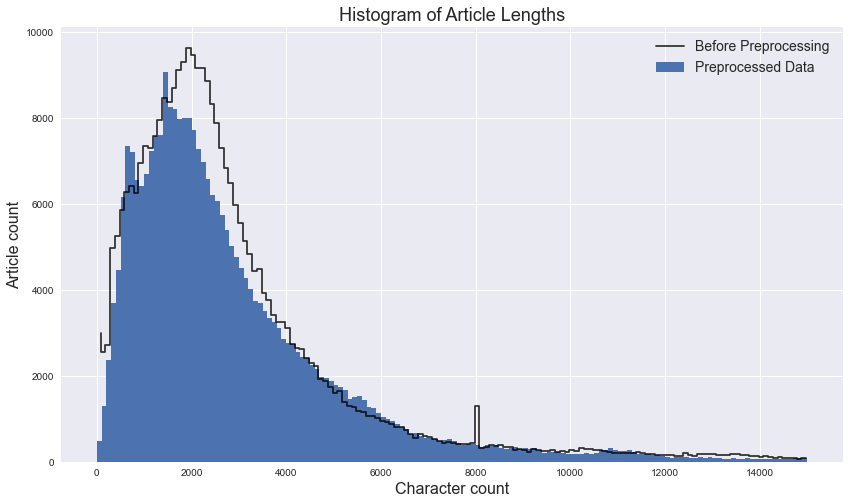

In [107]:
body_lengths = data['Body'].str.len()

desc = "A dent in article counts at 250 characters\nNot true"

y, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges), label="Preprocessed Data")
plt.step(x2+30, y2*0.41, 'k', alpha=0.8, label="Before Preprocessing")
plt.title("Histogram of Article Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Article count", fontsize=16)
plt.legend(fontsize=14);
#plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
#plt.plot([250,10000], [30,240], '--', c='red', alpha=.6)
#Ændr, så det passer med den endelige data.

dist_stats(body_lengths)

### Author contributions
How many articles have the authors written?

Mean: 159.58726790450928
STD: 430.7214839788824
Median: 27.0


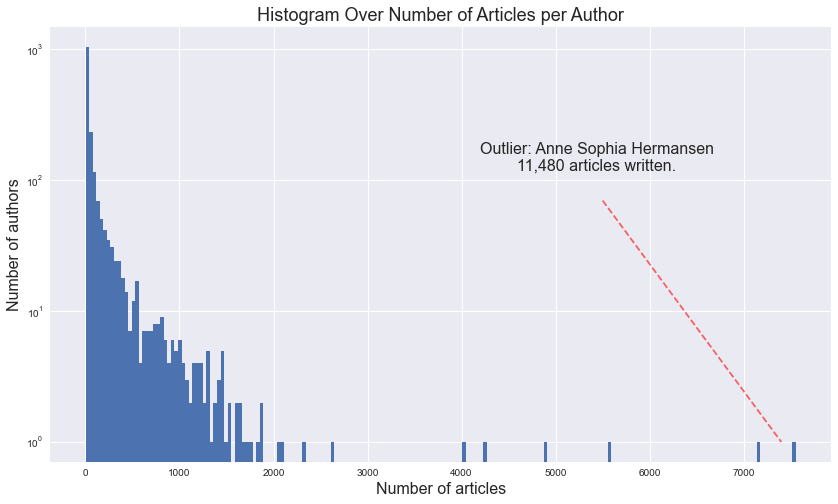

In [170]:
counts = list(data['Byline'].value_counts())

# plt.yscale('symlog')
# plt.xlim(-100,4000)

y, bin_edges = np.histogram(counts, bins=200)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges))

plt.yscale('log')
plt.title("Histogram Over Number of Articles per Author", fontsize=18)
plt.xlabel("Number of articles", fontsize=16)
plt.ylabel("Number of authors", fontsize=16)

desc = "Outlier: Anne Sophia Hermansen\n11,480 articles written."
plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
plt.plot([5500,7400], [70,1], '--', c='red', alpha=.6)

dist_stats(counts)

### Author body length
Do authors have certain body lengths? In articles, not their actual bodies. Let us make a plot to see if there is a correlation between article count and body length. But first, we need to find the average body length per author. 

In [94]:
df = pd.DataFrame(columns=['body_length', 'author'])
df['body_length'] = body_lengths
df['author'] = data['Byline']
df['author'].replace('', np.nan, inplace=True)
df = df.dropna()
avg_body_lengths = list(df.groupby(['author']).mean()['body_length'])

Text(0, 0.5, 'Number of authors')

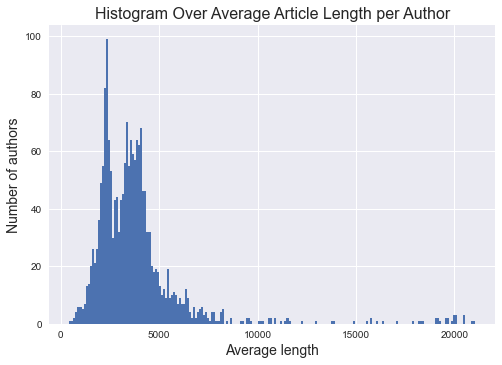

In [95]:
plt.hist(avg_body_lengths, bins=200);
plt.title("Histogram Over Average Article Length per Author", fontsize=16)
plt.xlabel("Average length", fontsize=14)
plt.ylabel("Number of authors", fontsize=14)

In [96]:
df2 = pd.DataFrame(index=data['Byline'].unique(),columns=['avg_len', 'article_count'])
avg_body_length_series = df.groupby(['author']).mean()['body_length']
article_count_series = data['Byline'].value_counts()

for i in data['Byline'].unique():
    if i == '':
        continue
    
    avg_len = avg_body_length_series[i]
    article_count = article_count_series[i]
    df2.loc[i] = [avg_len, article_count]

df2.head(5)

,avg_len,article_count
Annemette Grundtvig,1667.029091,550
Emma Busk,2360.276165,1137
Lasse Foghsgaard,1792.679412,340
Stine Kærgaard Nissen,787.315789,19
Kasper Villum Jensen,2216.770873,1593


**Correlation between average length and article count**

Make a dataframe with author, average article length, article count

Pearsin correlation: -0.012972263970456492


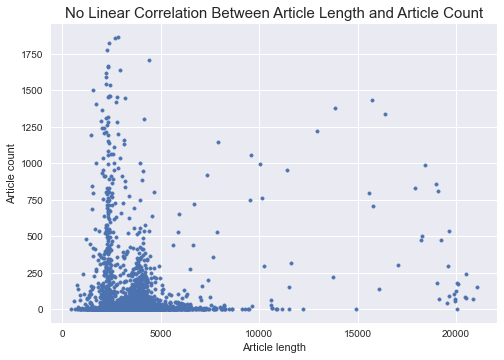

In [108]:
x = df2.avg_len
y = df2.article_count
plt.scatter(x[y<2000], y[y<2000], marker='.')
plt.ylabel("Article count")
plt.xlabel("Article length")

x = x.to_numpy(dtype=float)
y = y.to_numpy(dtype=float)
x = np.nan_to_num(x)
y = np.nan_to_num(y)

corr, sig = pearsonr(x,y)
print("Pearsin correlation:", corr)

plt.title("No Linear Correlation Between Article Length and Article Count", fontsize=15);

## Publication

In [138]:
dates = list(data.PublicationDate.str[8:10])
int_dates = []
old_af = []
future = []
for i in dates:
    try:
        inti = int(i)
    except:
        continue
    
#     if inti < 1995:
#         old_af.append(inti)
#         continue
    if inti > 22:
        future.append(inti)
        continue
    int_dates.append(inti)

print(len(old_af), "articles from before 1995")
print(len(future), "articles from the future")

0 articles from before 1995
5010 articles from the future


c:\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


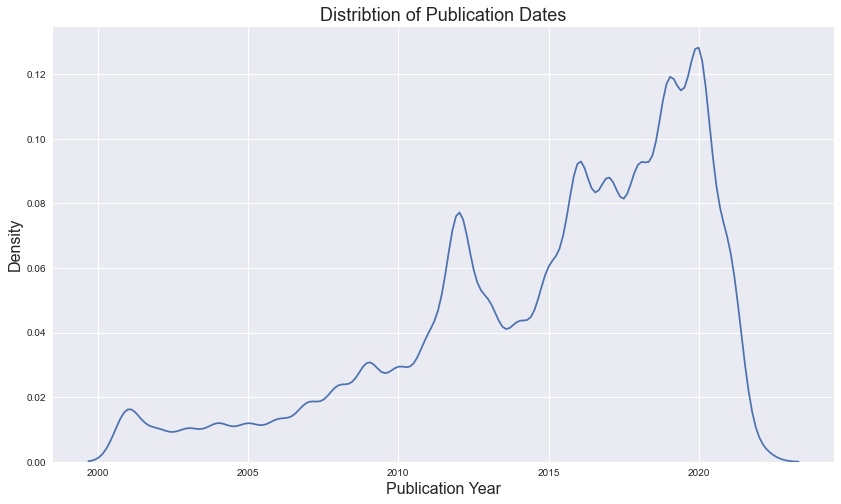

In [168]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(14,8))
sns.distplot(int_dates, hist=False)
plt.title("Distribtion of Publication Dates", fontsize=18)
plt.xlabel("Publication Year", fontsize=16)
plt.ylabel("Density", fontsize=16)
ax.set_xticklabels(plt.xticks[0].astype(int));

### Headline length

Mean: 57.068864644208205
STD: 22.750211363106228
Median: 54.0


AndersonResult(statistic=2802.0388447247096, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

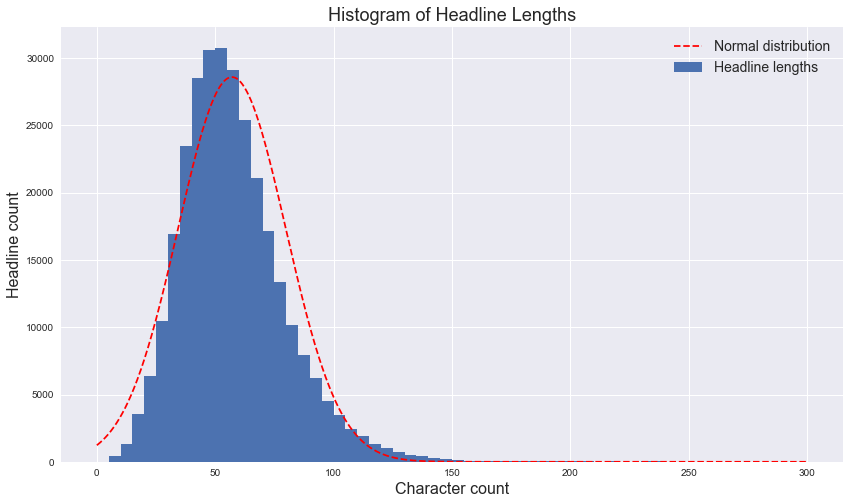

In [238]:
from scipy.stats import anderson

def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

header_lengths = sorted(data['Header'].str.len())

y, bin_edges = np.histogram(header_lengths, bins=50, range=(0,250))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges), label="Headline lengths")
plt.title("Histogram of Headline Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Headline count", fontsize=16)

norm = normal_dist(np.linspace(0,300,1000), np.mean(header_lengths), np.std(header_lengths))
plt.plot(np.linspace(0,300,1000), norm*400, '--', c='red', label="Normal distribution")
plt.legend(fontsize=14)

dist_stats(body_lengths)
anderson(header_lengths)

In [242]:
dist_stats(list(data.Domain.value_counts()))

Mean: 1880.1375
STD: 7478.047291478822
Median: 159.0


# Testing

In [3]:
data = pd.read_json('data/additional/scraped_data_raw.json')

In [4]:
def split_sentences(text):
    '''Returns an array with text split into sentences'''
    return np.array(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text), dtype=str)

In [5]:
text = list(data.head(20000).Body.astype(str))
texts = [split_sentences(t) for t in text]
final_text = ''
for text in tqdm(texts):
    for phrase in text: 
        if len(''.join(phrase)) > 10:
            phrase = phrase.strip('\n')
            final_text += ''.join(phrase)
            final_text += '\n'
final_text = final_text[:-1]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [6]:
with open('text.txt', 'w', encoding='utf-8') as f:
    f.write(final_text)

In [7]:
lens = [len(x) for x in final_text.split('\n')]

In [8]:
z = [x for x in range(len(lens)) if lens[x] == 0]

In [9]:
z

[]

In [86]:
lens[:100]

[143,
 45,
 104,
 45,
 128,
 117,
 119,
 50,
 20,
 29,
 152,
 93,
 295,
 64,
 23,
 100,
 95,
 124,
 128,
 51,
 116,
 51,
 23,
 143,
 45,
 162,
 154,
 38,
 82,
 88,
 25,
 16,
 23,
 18,
 132,
 52,
 82,
 105,
 84,
 134,
 138,
 231,
 90,
 80,
 74,
 225,
 182,
 106,
 124,
 64,
 106,
 160,
 122,
 161,
 74,
 176,
 307,
 77,
 102,
 60,
 126,
 168,
 68,
 183,
 113,
 75,
 38,
 48,
 30,
 33,
 105,
 71,
 29,
 66,
 109,
 71,
 224,
 144,
 264,
 131,
 18,
 44,
 185,
 93,
 85,
 147,
 111,
 38,
 93,
 163,
 182,
 61,
 80,
 54,
 89,
 62,
 59,
 78,
 70,
 150]